## Converting object-labeled wisdom dataset to cluttered omniglot format

In [3]:
import os
import cv2
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from dataset_utils import mkdir_if_missing
from PIL import Image
from skimage import io
from tqdm import tqdm
import pprint
import json

In [5]:
# input directories
AMODAL_MASK_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/dataset"
SCENE_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/depth_ims"
JSON_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/color_ims"
MASK_DIR = "/nfs/diskstation/dmwang/labeled_wisdom_real/phoxi/modal_segmasks"

# output directories
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real/fold_0003"
mkdir_if_missing(OUT_DIR)
mkdir_if_missing(os.path.join(OUT_DIR, "train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-one-shot"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-one-shot"))

# real dataset parameters
NUM_IMS = 1  # 400

# original image shape
IM_WIDTH = 1032
IM_HEIGHT = 772

# 1:3 ratio between im_size and tar_size
IM_SIZE = 384
TAR_SIZE = 128

# Image distortion
ANGLE = 100
SHEAR = 2.5

# For storage purposes
BLOCK_SIZE = 1

In [6]:
def rot_x(phi, theta, ptx, pty):
    return np.cos(phi+theta)*ptx + np.sin(phi-theta)*pty


def rot_y(phi, theta, ptx, pty):
    return -np.sin(phi+theta)*ptx + np.cos(phi-theta)*pty


def prepare_img(img, angle=100, shear=2.5, scale=2):
    # Apply affine transformations and scale characters for data augmentation
    phi = np.radians(np.random.uniform(-angle, angle))
    theta = np.radians(np.random.uniform(-shear, shear))
    a = scale**np.random.uniform(-1, 1)
    b = scale**np.random.uniform(-1, 1)
    (x, y) = img.shape
    x = a * x
    y = b * y
    xextremes = [rot_x(phi, theta, 0, 0), rot_x(phi, theta, 0, y), rot_x(phi, theta, x, 0), rot_x(phi, theta, x, y)]
    yextremes = [rot_y(phi, theta, 0, 0), rot_y(phi, theta, 0, y), rot_y(phi, theta, x, 0), rot_y(phi, theta, x, y)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)

    aff_bas = np.array([[a*np.cos(phi+theta), b*np.sin(phi-theta), -mnx], [-a*np.sin(phi+theta), b*np.cos(phi-theta), -mny], [0, 0, 1]])
    aff_prm = np.linalg.inv(aff_bas)
    pil_img = Image.fromarray(img)
    pil_img = pil_img.transform((int(mxx - mnx),int(mxy - mny)),
                                    method=Image.AFFINE,
                                    data=np.ndarray.flatten(aff_prm[0:2, :]))
    pil_img = pil_img.resize((int(TAR_SIZE * (mxx - mnx) / 100), int(TAR_SIZE * (mxy - mny) / 100)))

    return np.array(pil_img)


def bbox(im):
    # get bounding box coordinates
    rows = np.any(im, axis=1)
    cols = np.any(im, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def make_target(modal_mask, angle=0, shear=0, scale=1):
    # make target image by cropping
    # formula: use the bigger bounding box length plus half of the smaller
    # margin between the edge of the image and the bbox
    
    # transformed_mask = prepare_img(modal_mask, angle, shear, scale)
    transformed_mask = modal_mask
    
    top, bot, left, right = bbox(transformed_mask)
    obj_size = max(bot - top, right - left)
    if bot - top > right - left:
        right += (bot - top - (right - left)) // 2
        left -= (bot - top - (right - left)) // 2
    else:
        bot += (right - left - (bot - top)) // 2
        top -= (right - left - (bot - top)) // 2
    margin = min(top, left, IM_HEIGHT - bot, IM_WIDTH - right)
    
    return cv2.resize(
        transformed_mask[max(0, top - margin):min(transformed_mask.shape[0], bot + margin),
                         max(0, left - margin):min(transformed_mask.shape[1], right + margin)],
        (TAR_SIZE, TAR_SIZE),
        interpolation=cv2.INTER_NEAREST)

def resize_scene(im):
    if len(im.shape) == 2:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0)), mode="constant")
    elif len(im.shape) == 3:
        im = np.pad(im, (((IM_WIDTH - IM_HEIGHT) // 2, (IM_WIDTH - IM_HEIGHT) // 2), (0, 0), (0, 0)), mode="constant")
    else:
        raise Exception("image dimensions not valid for scene/ground truth, shape: {}".format(im.shape))
    return cv2.resize(
        im,
        (IM_SIZE, IM_SIZE),
        interpolation=cv2.INTER_NEAREST)

  0%|          | 0/30 [00:00<?, ?it/s]

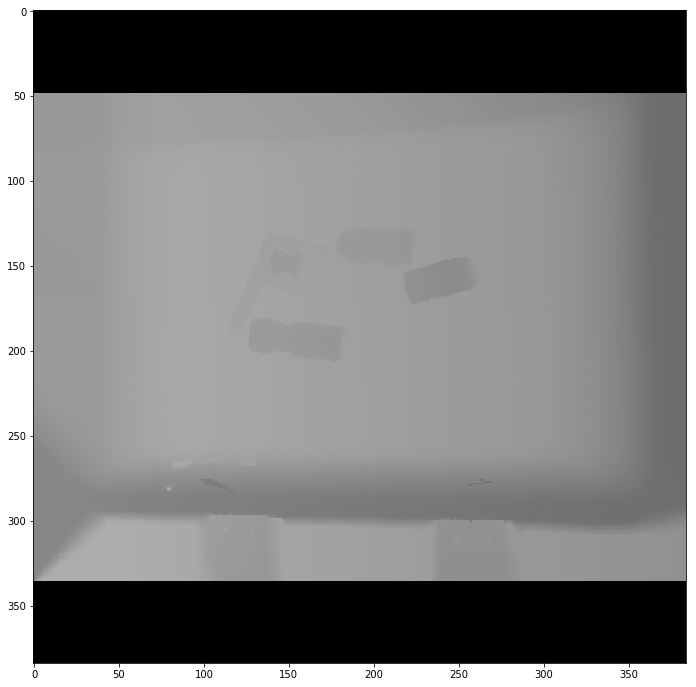

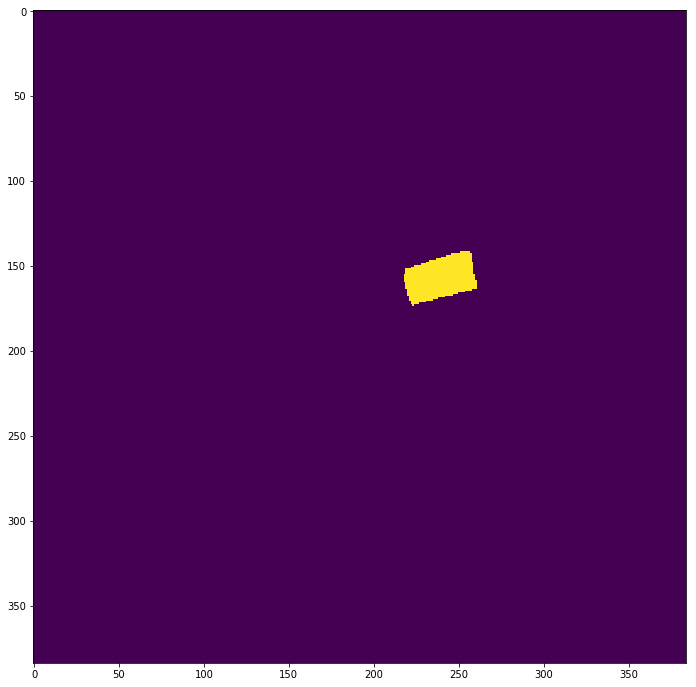

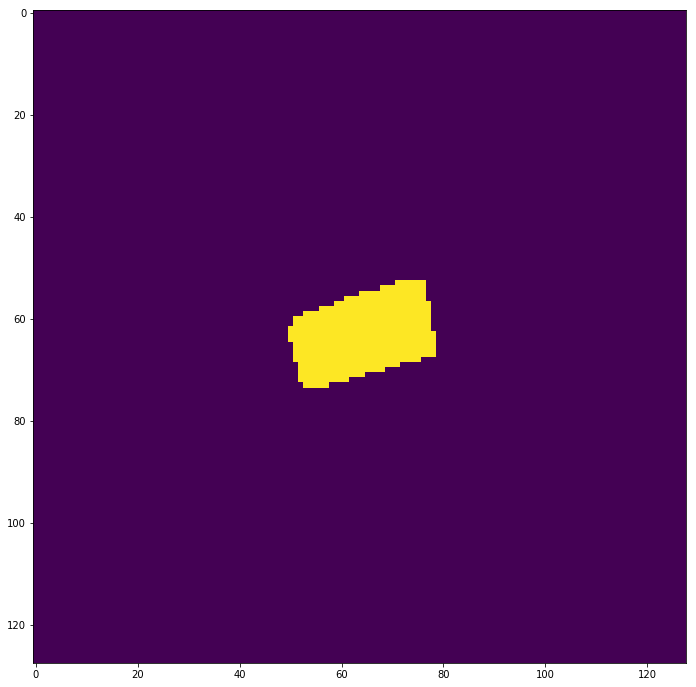

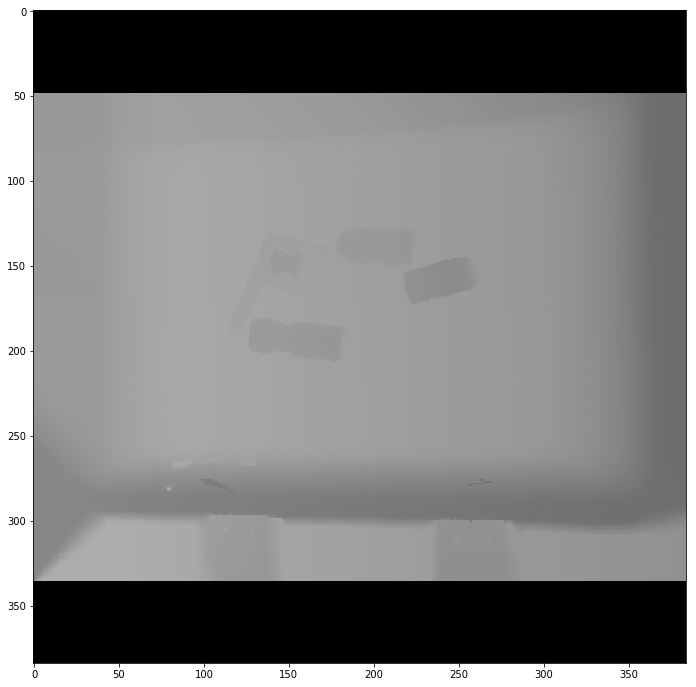

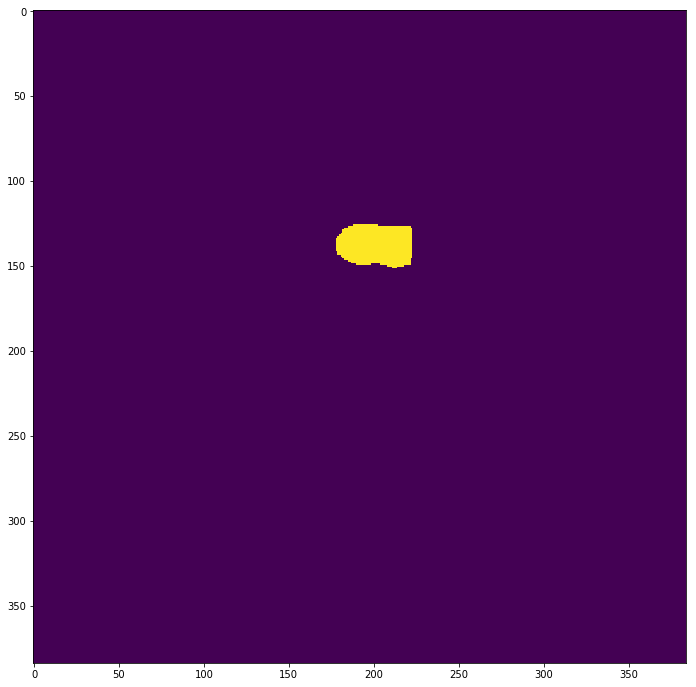

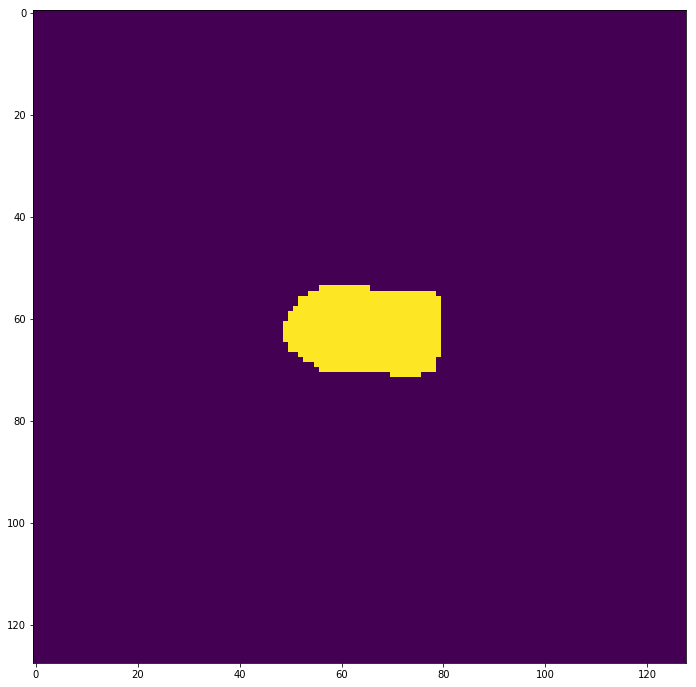

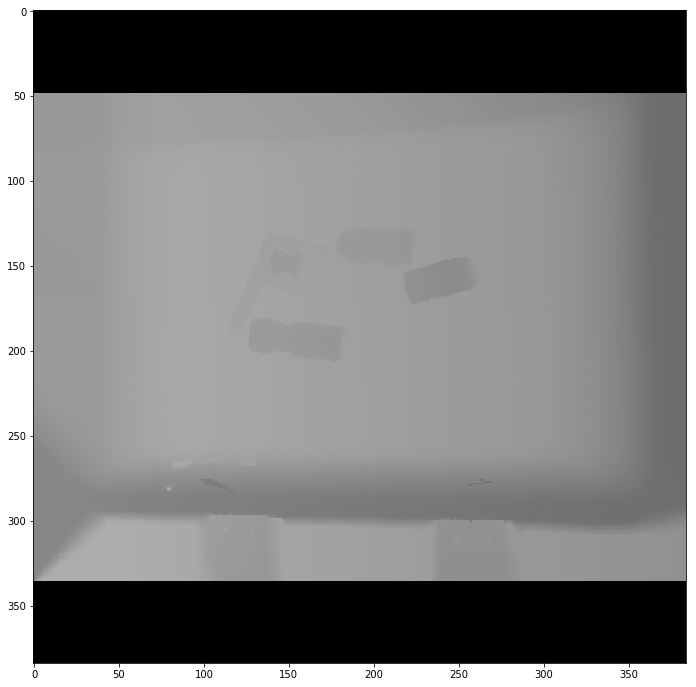

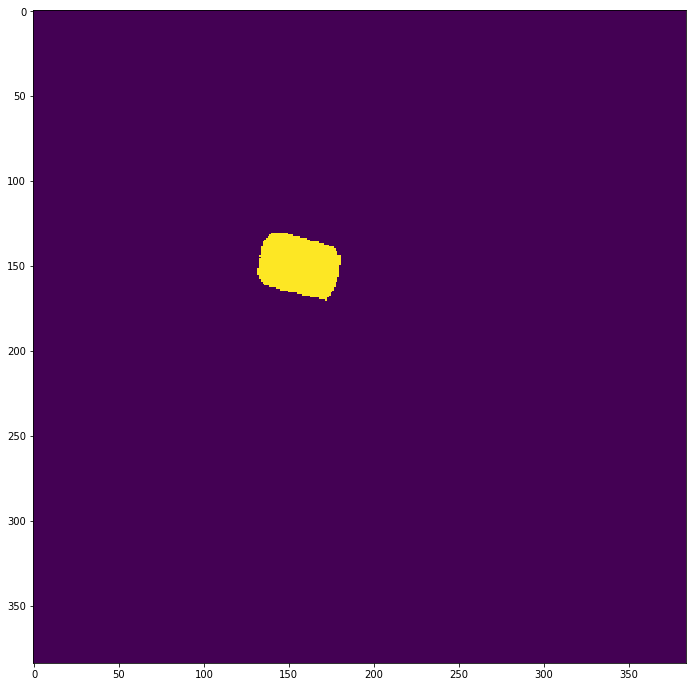

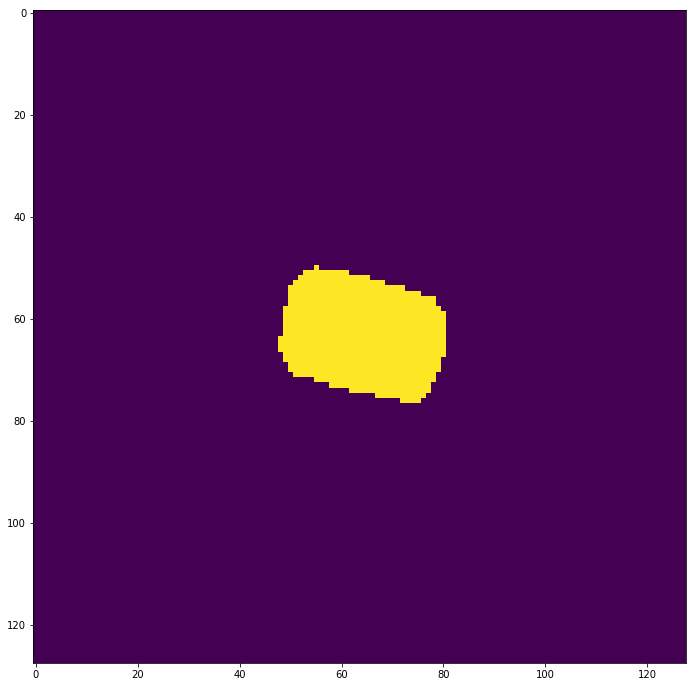

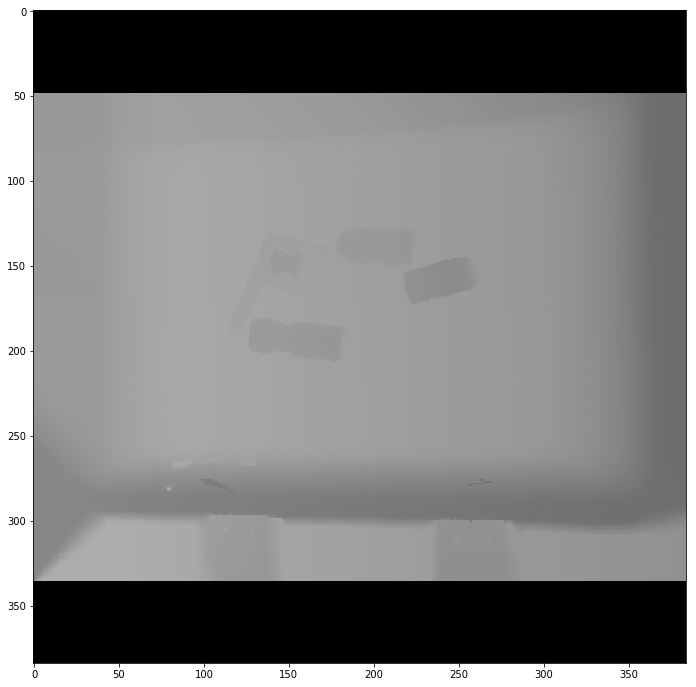

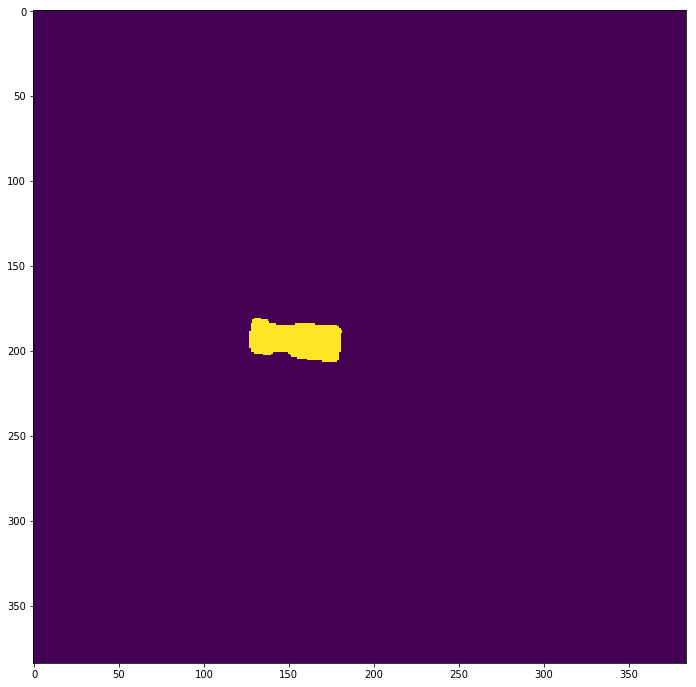

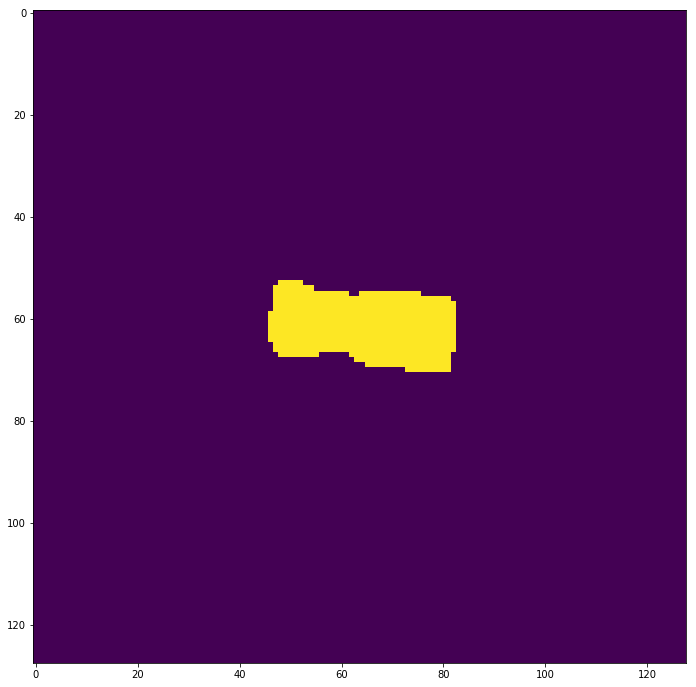

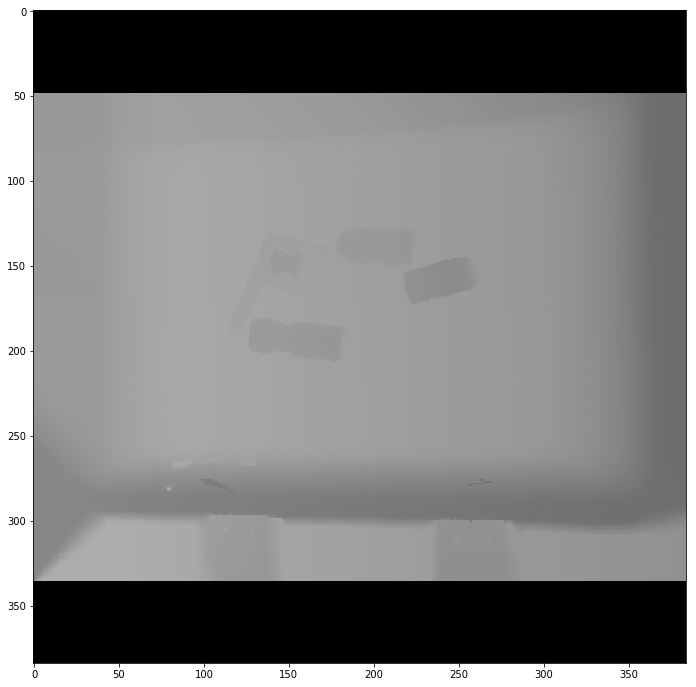

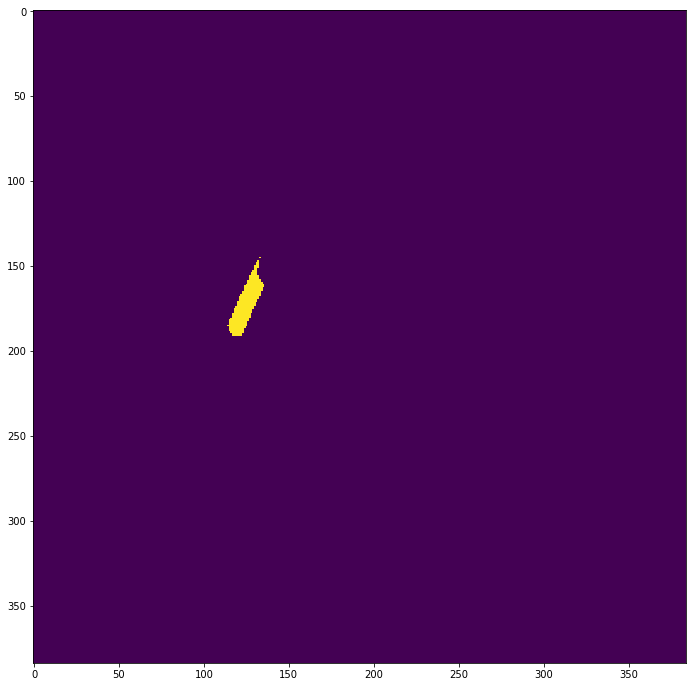

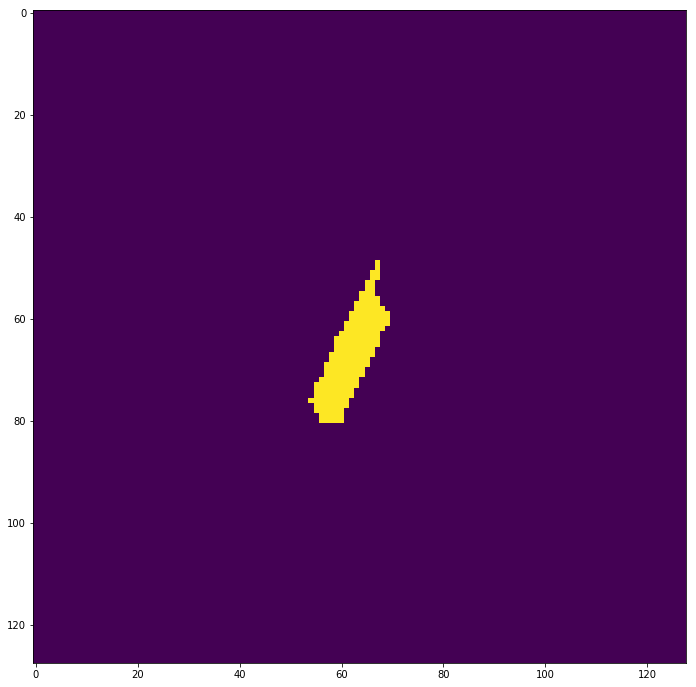

  3%|▎         | 1/30 [00:02<01:25,  2.93s/it]

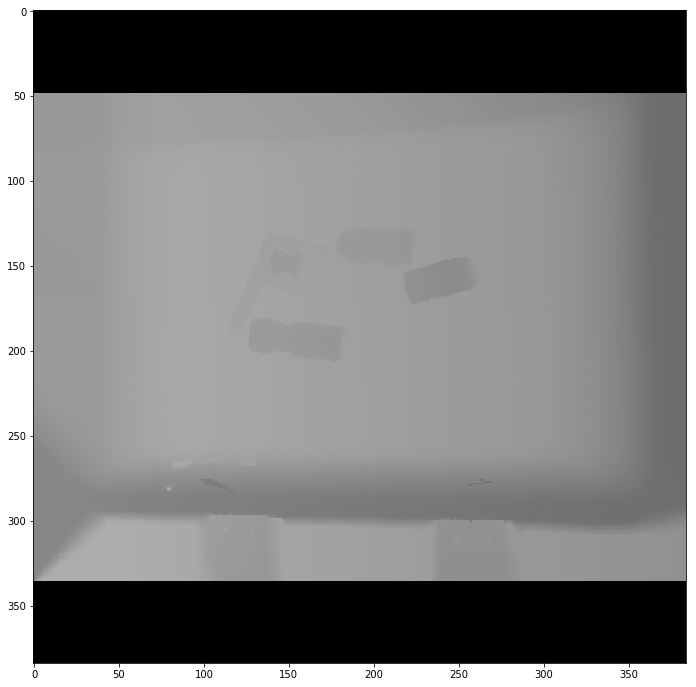

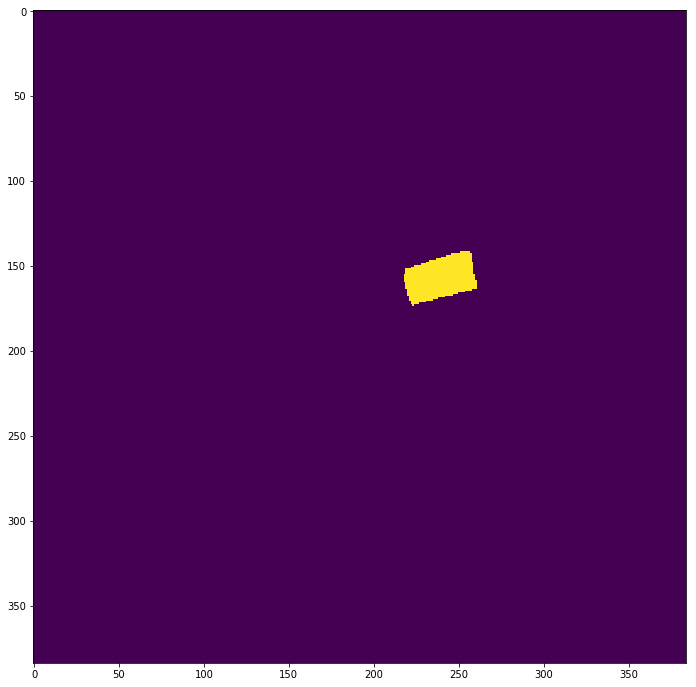

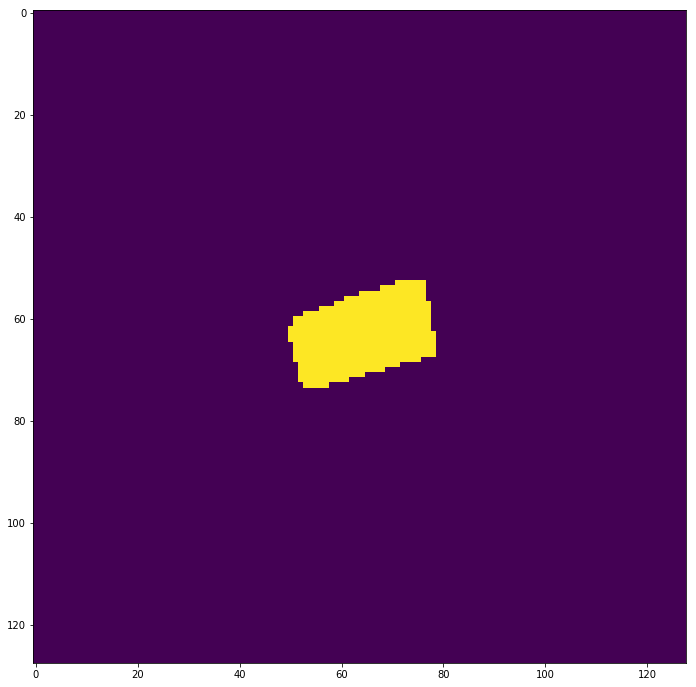

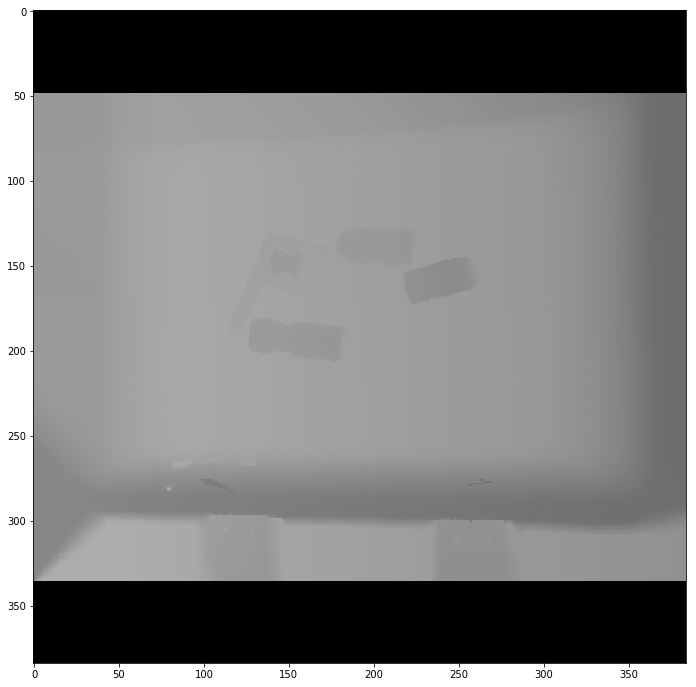

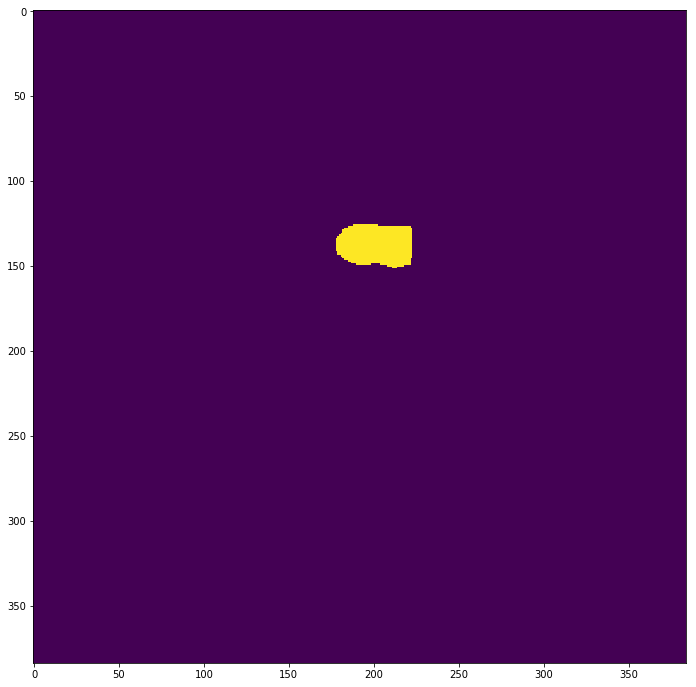

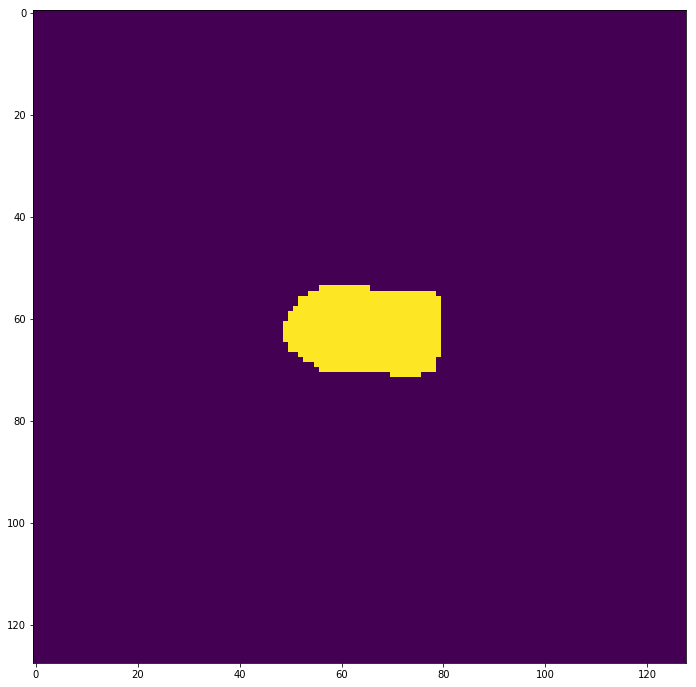

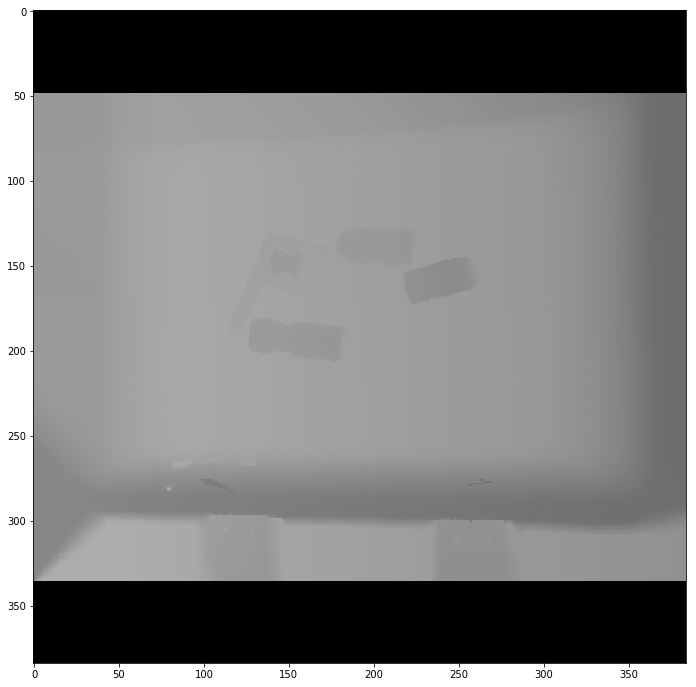

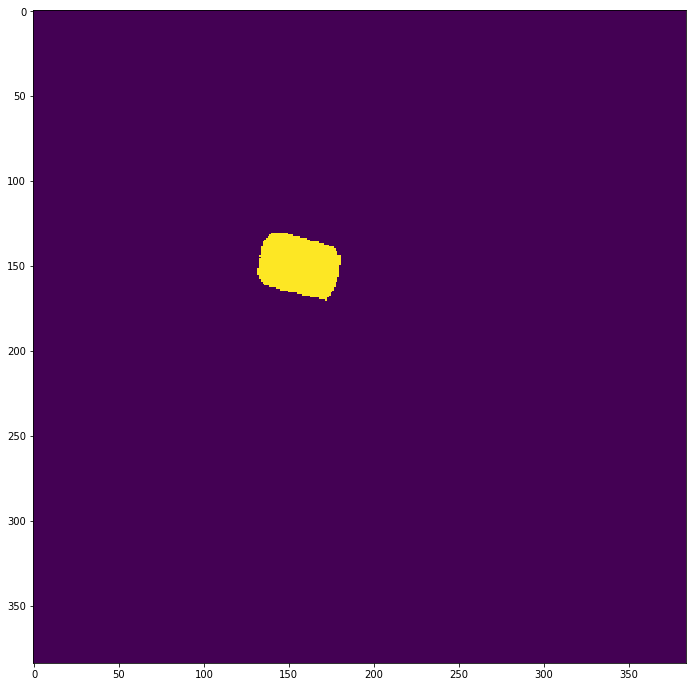

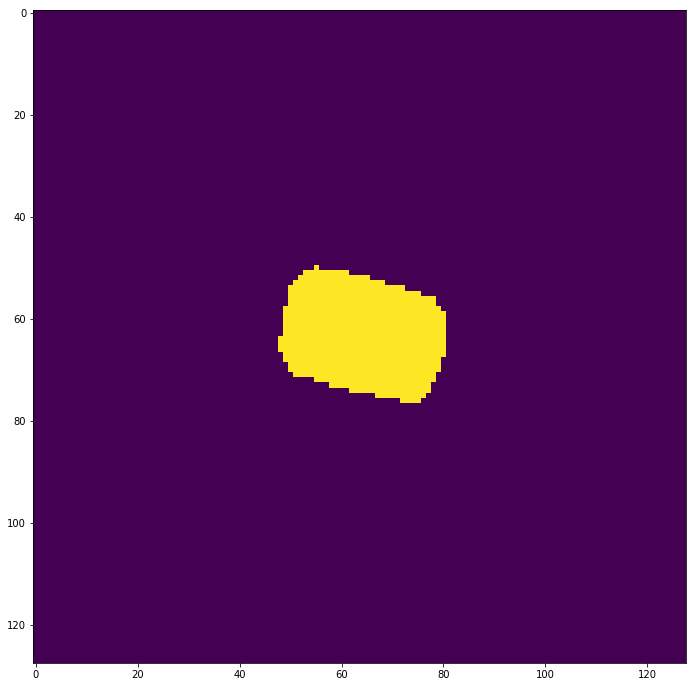

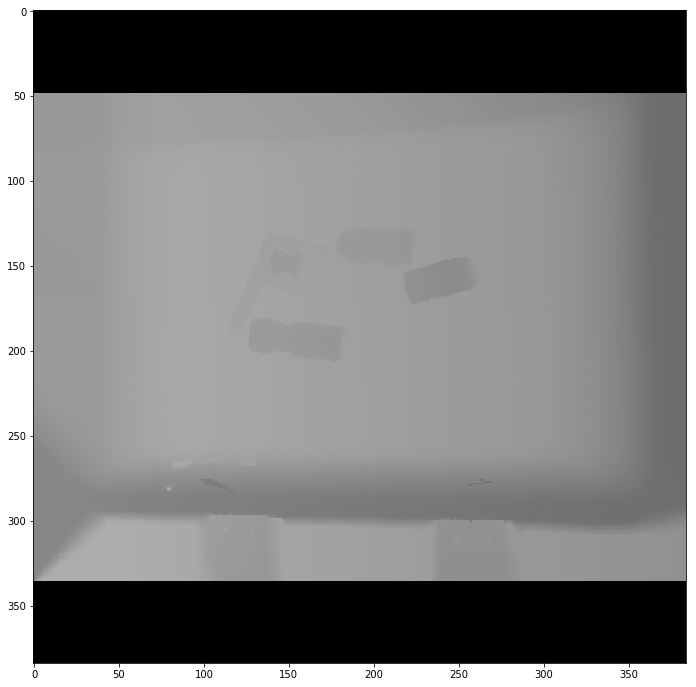

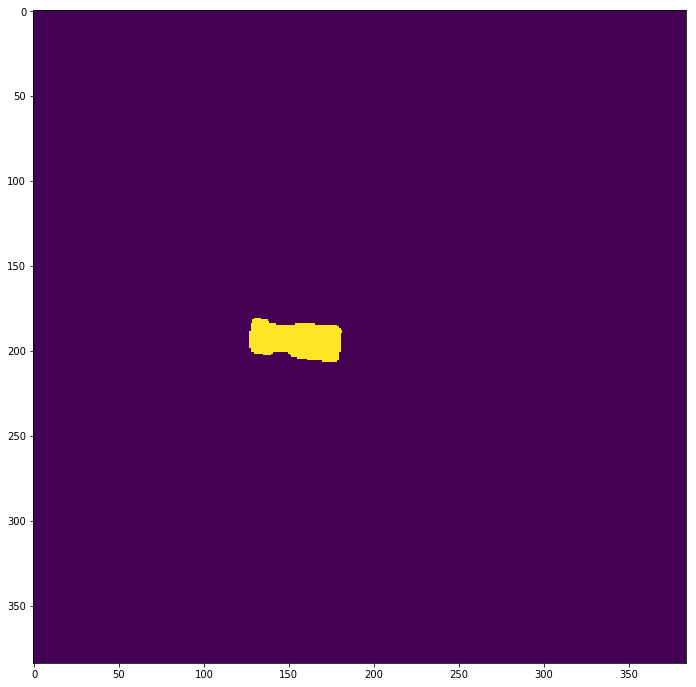

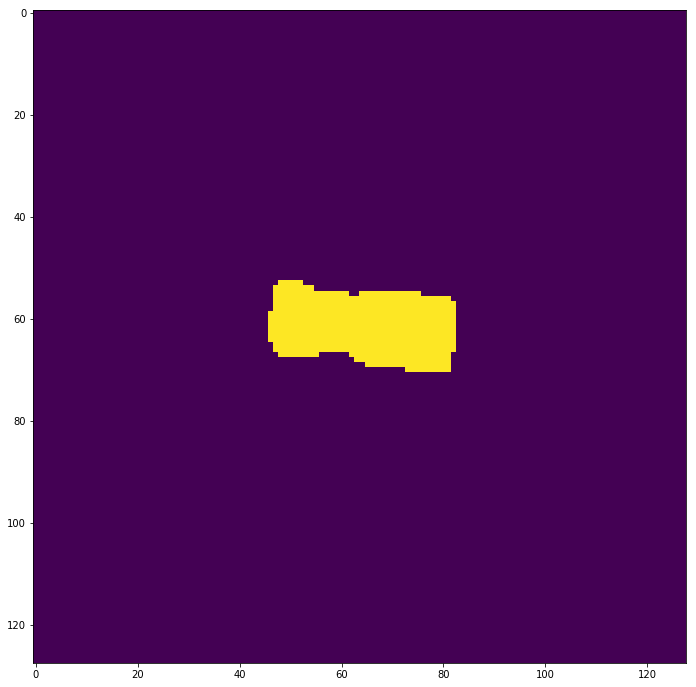

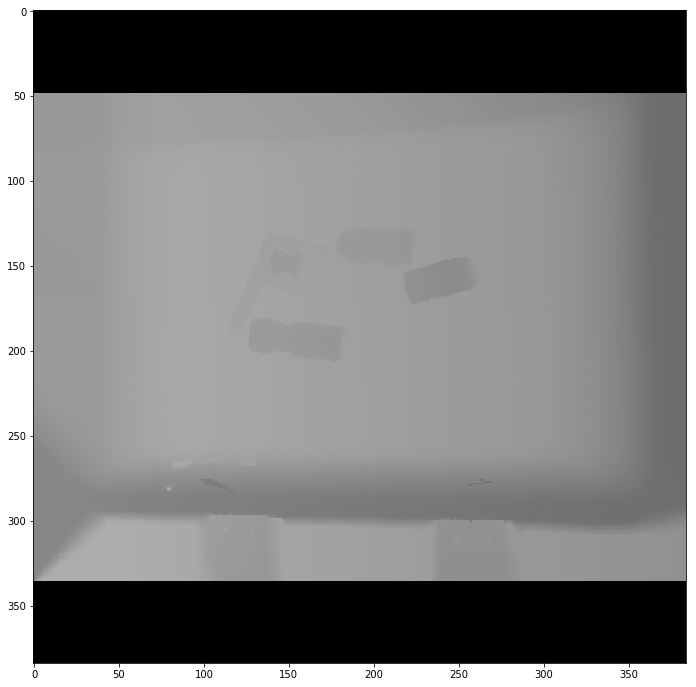

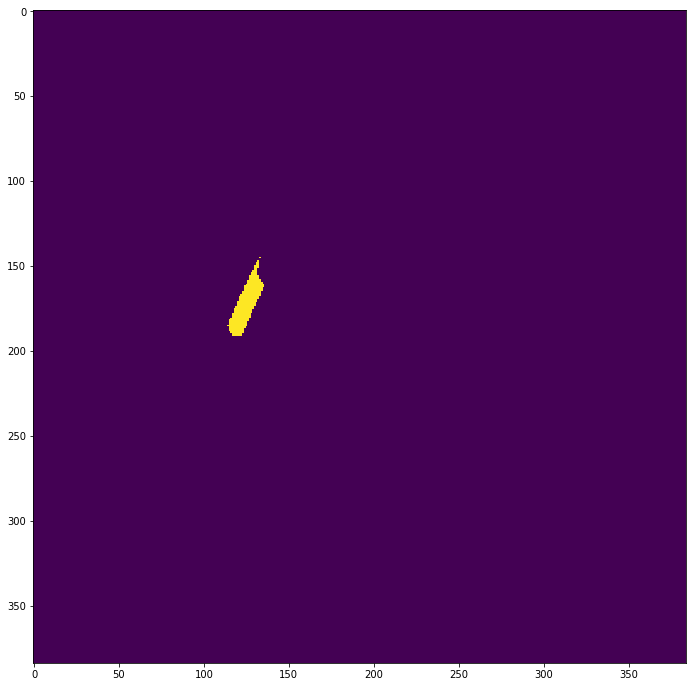

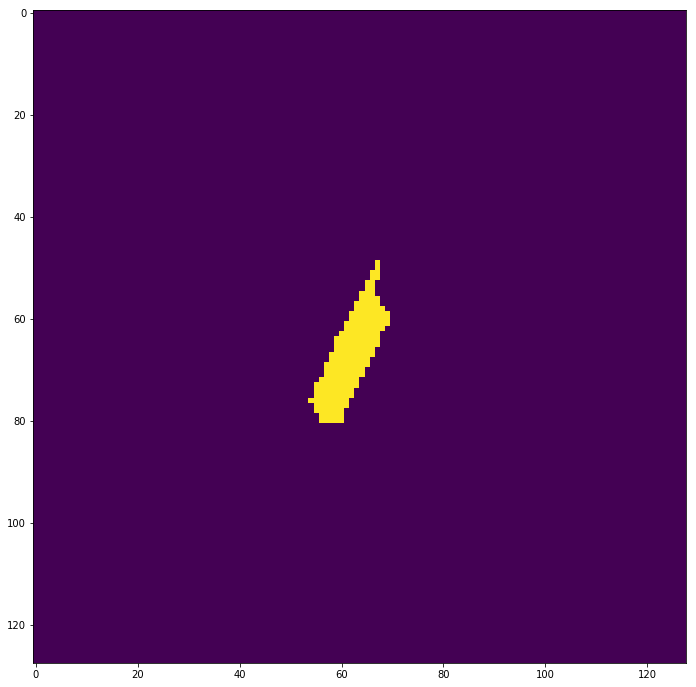

  7%|▋         | 2/30 [00:05<01:21,  2.90s/it]

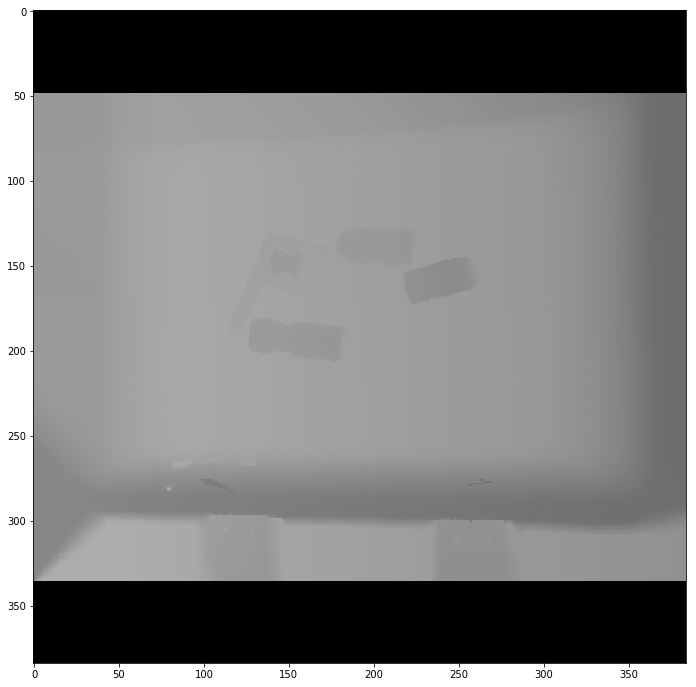

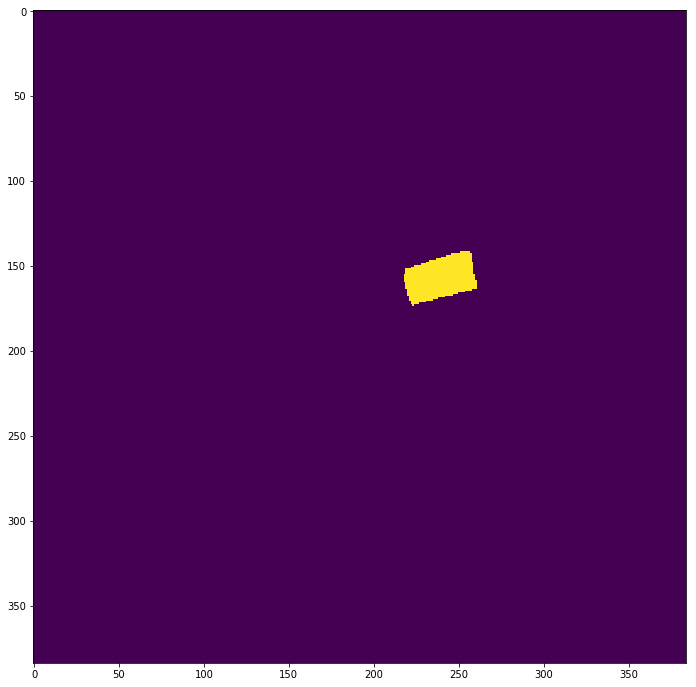

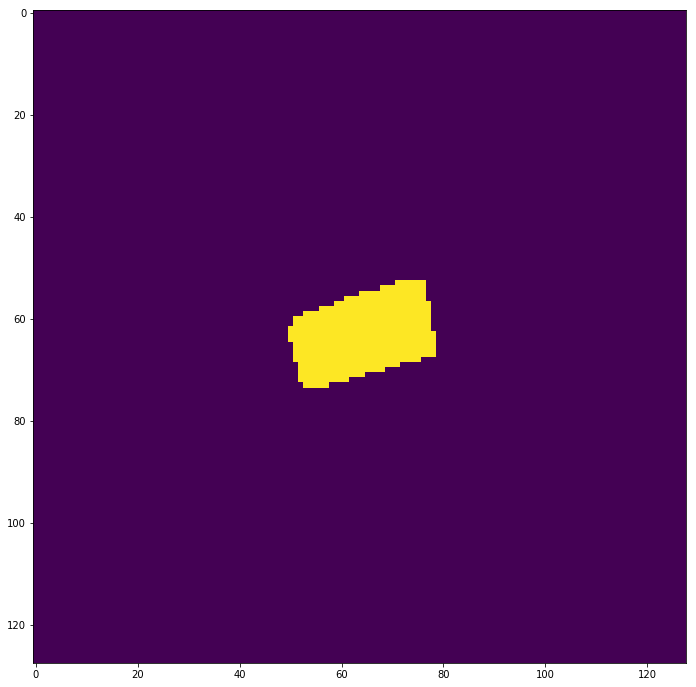

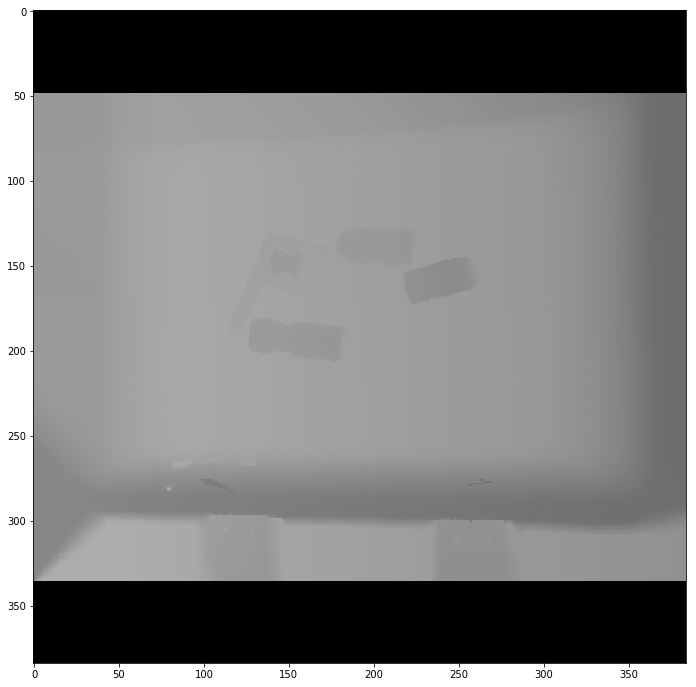

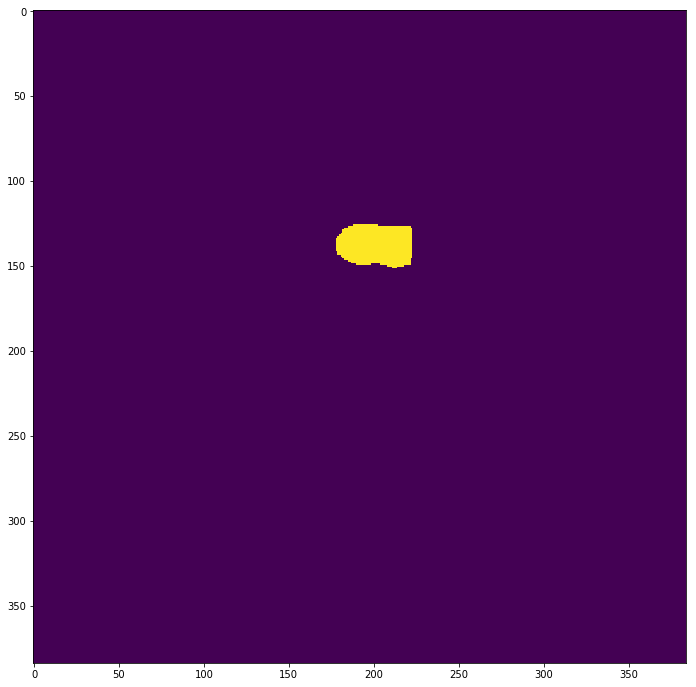

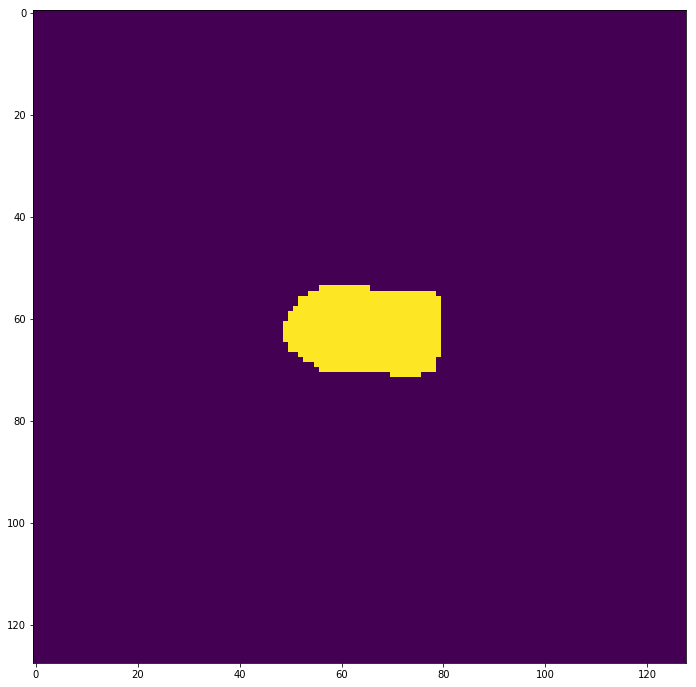

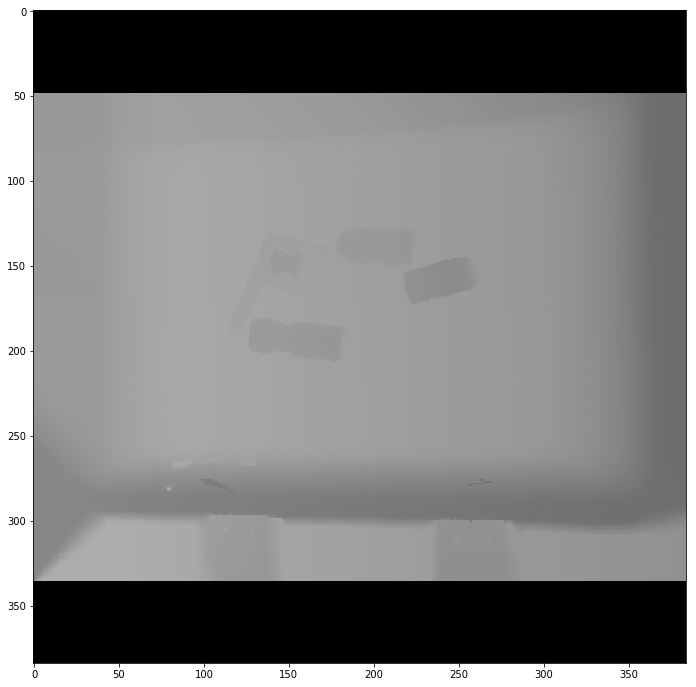

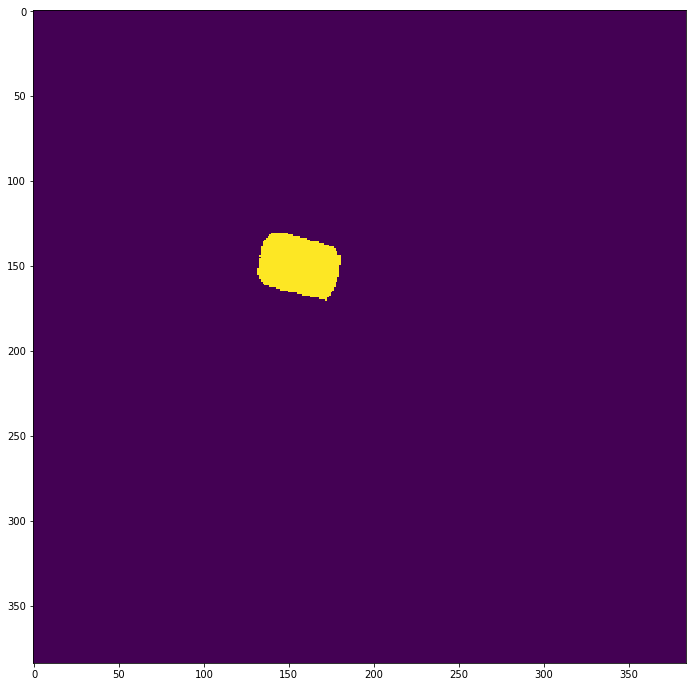

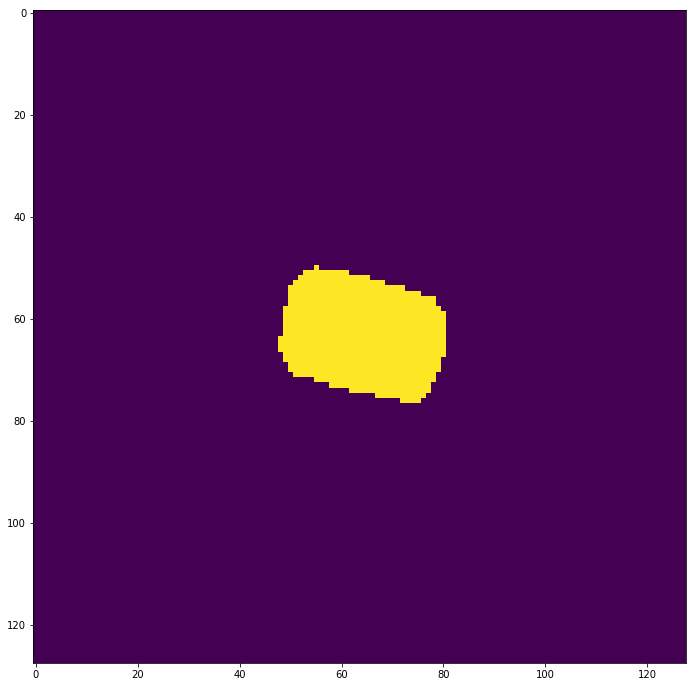

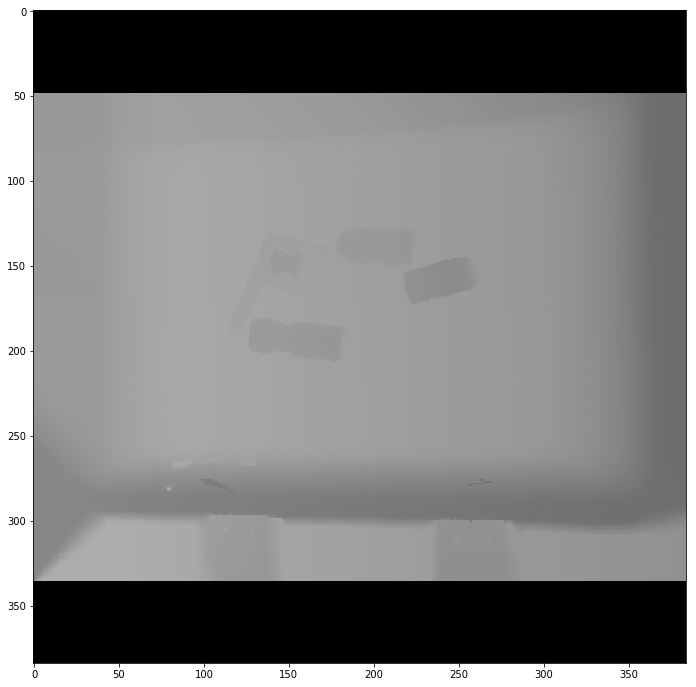

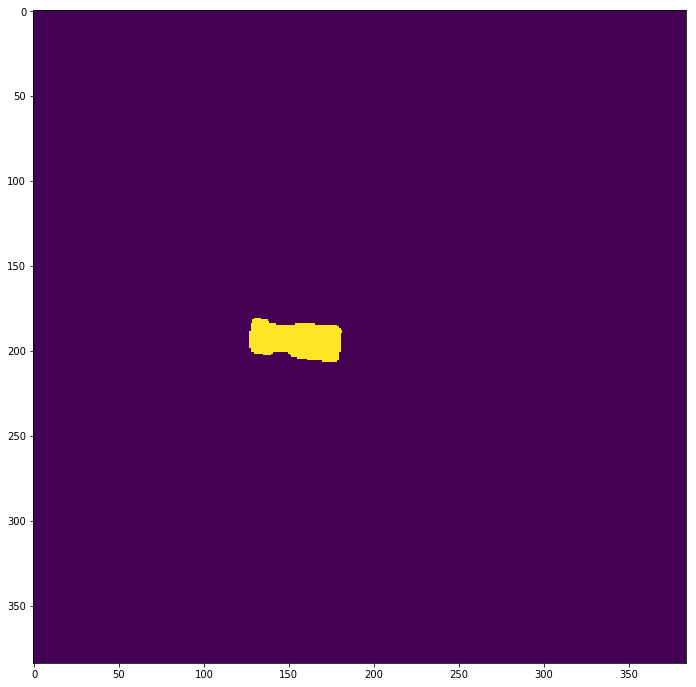

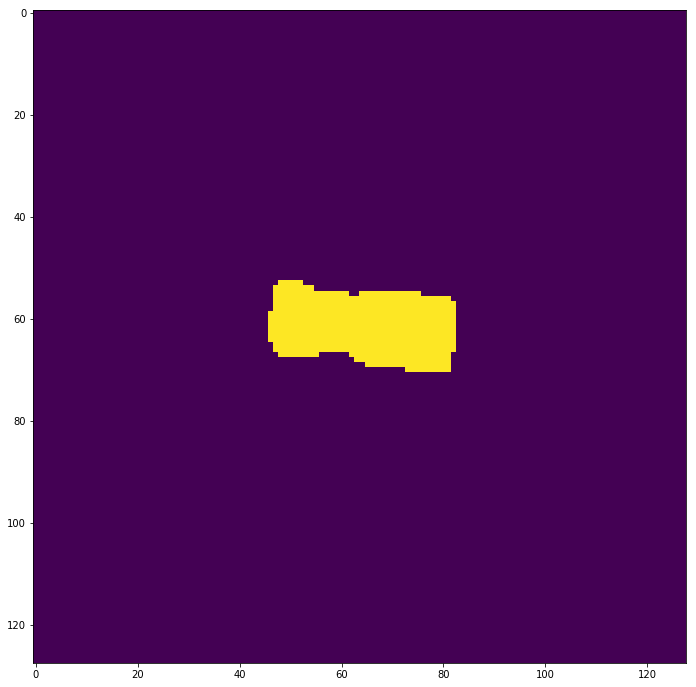

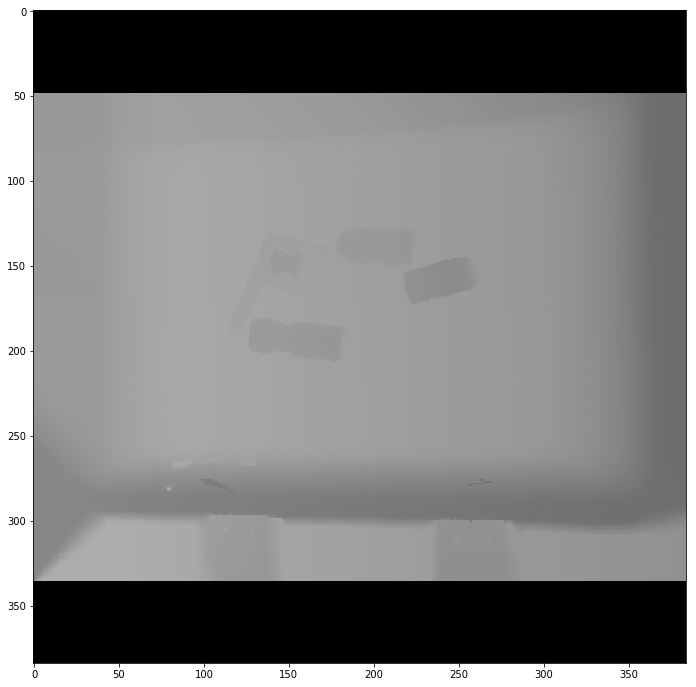

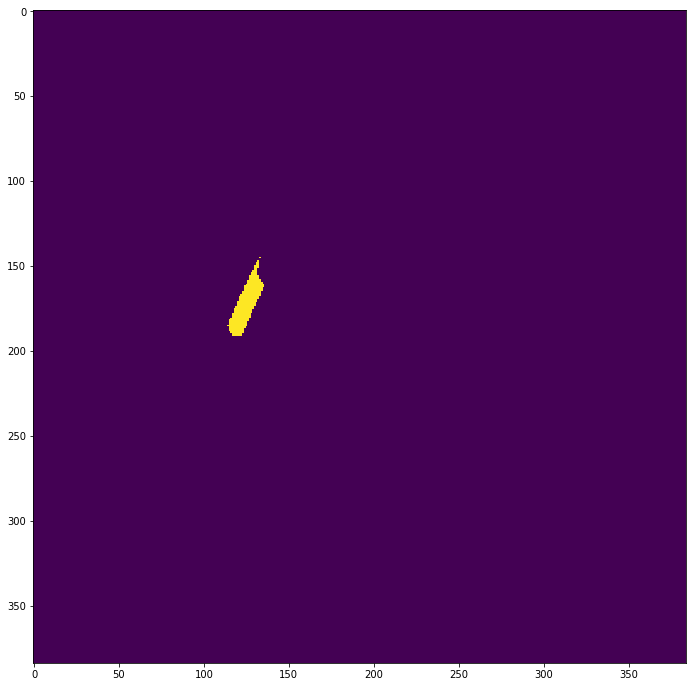

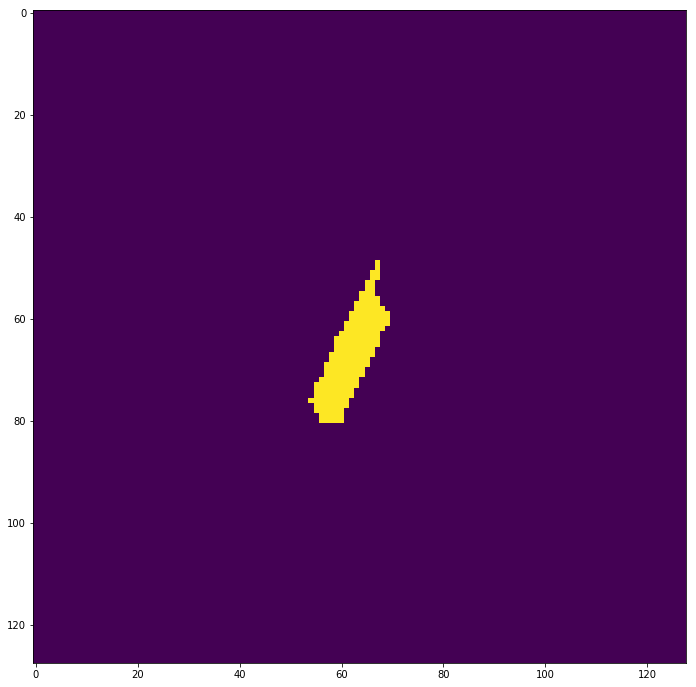

 10%|█         | 3/30 [00:08<01:18,  2.89s/it]

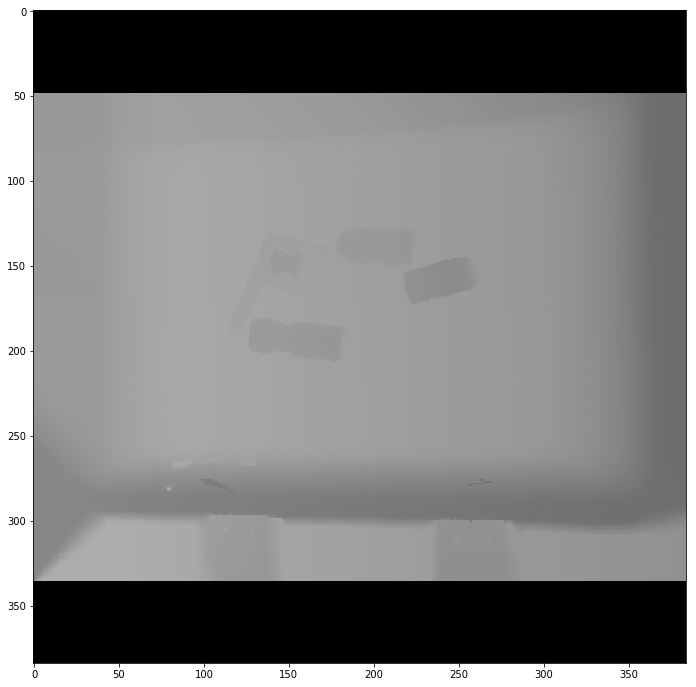

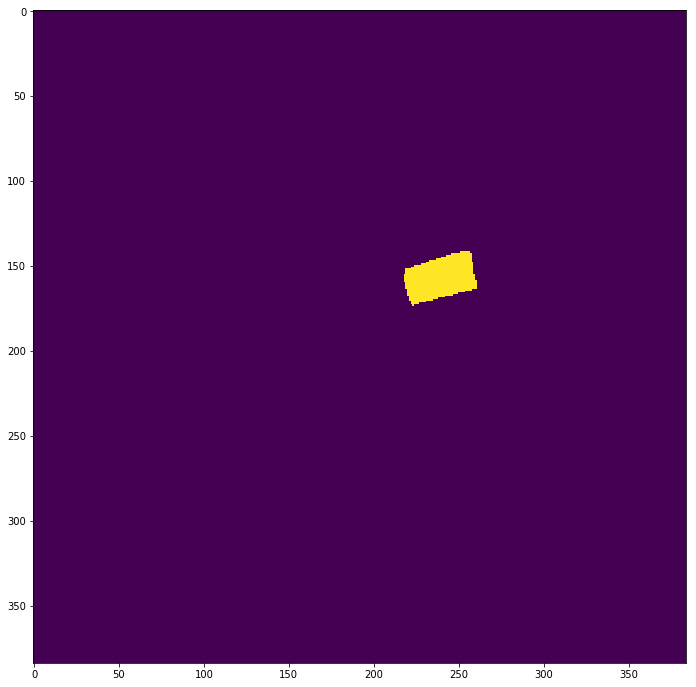

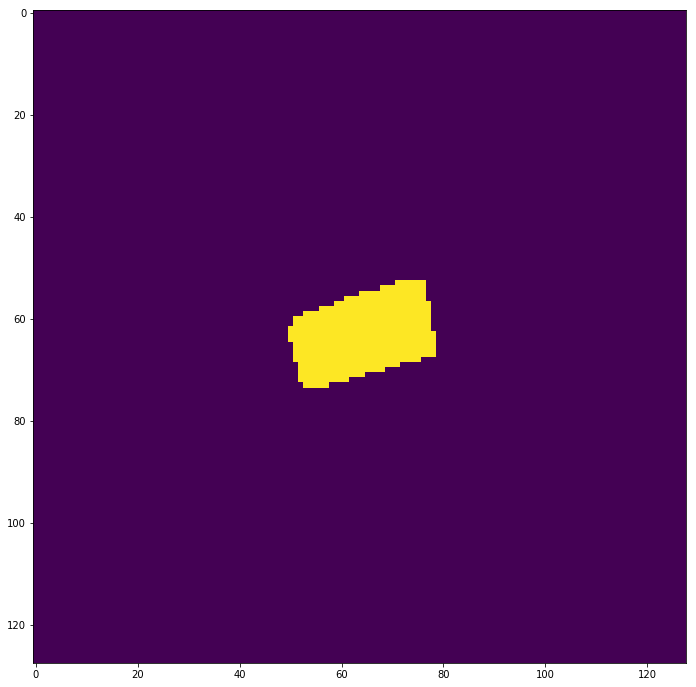

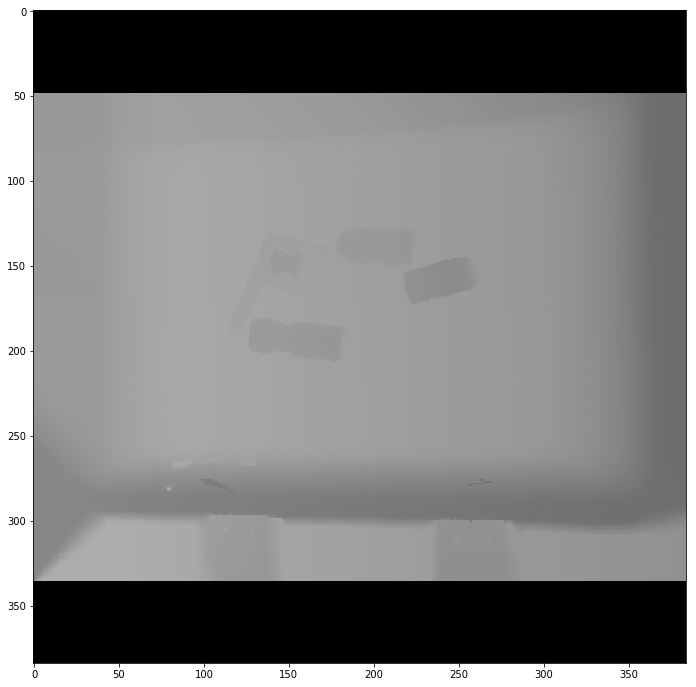

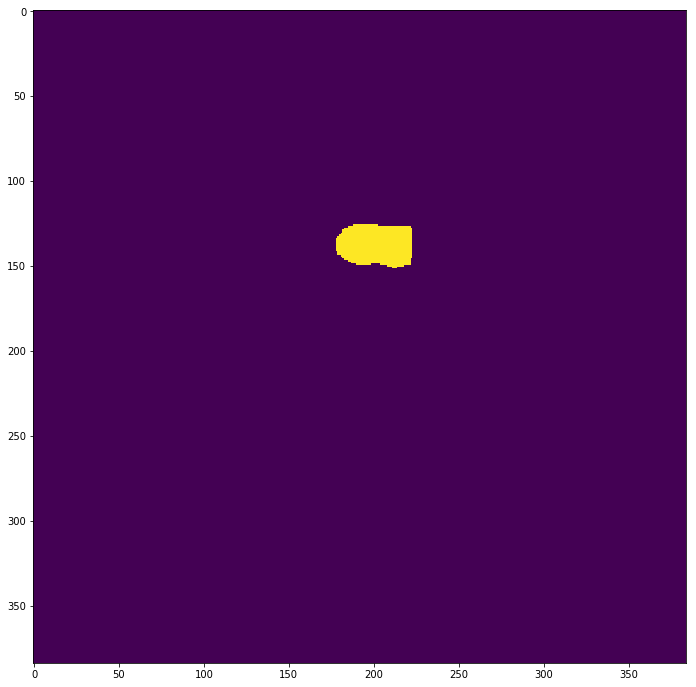

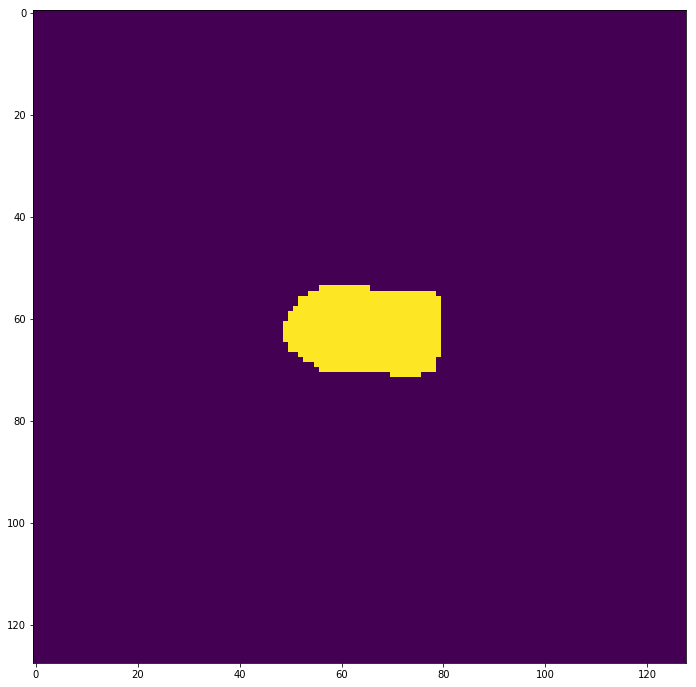

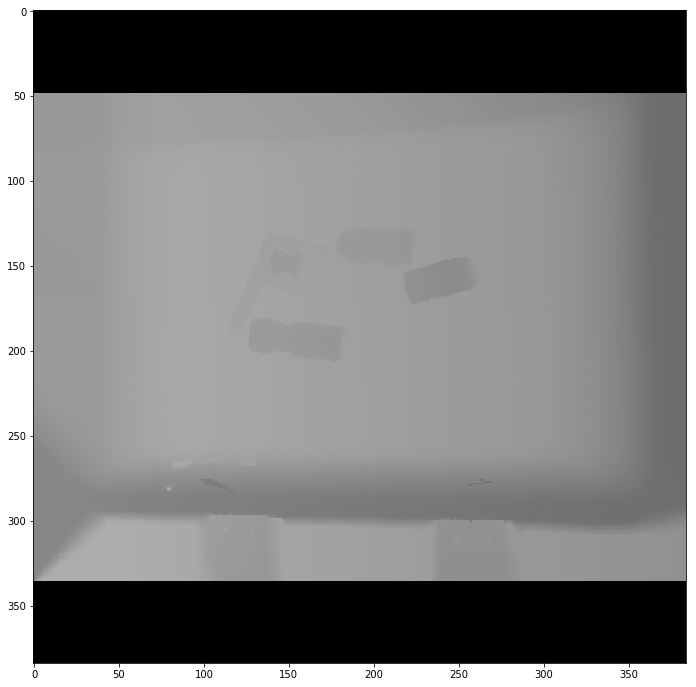

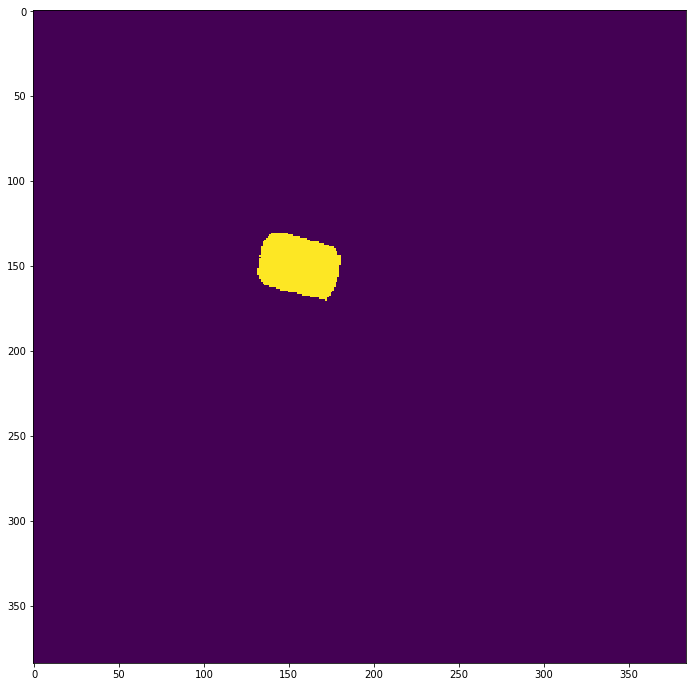

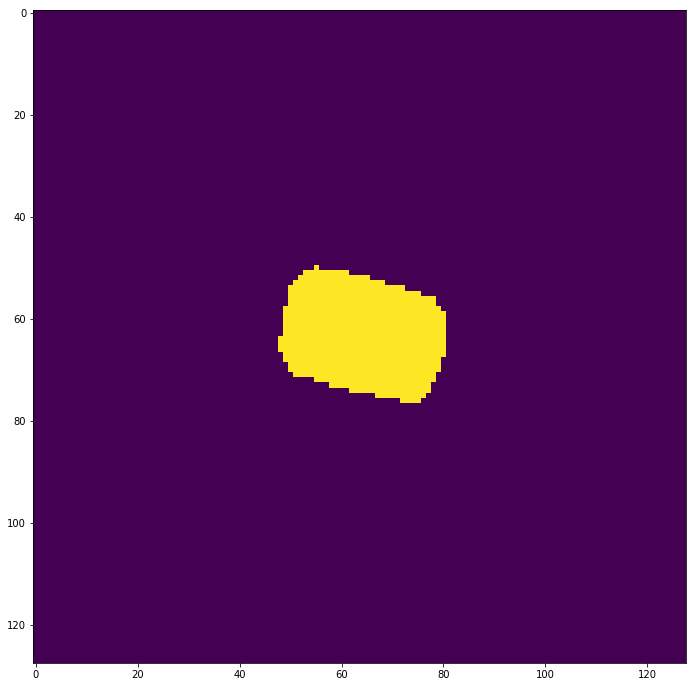

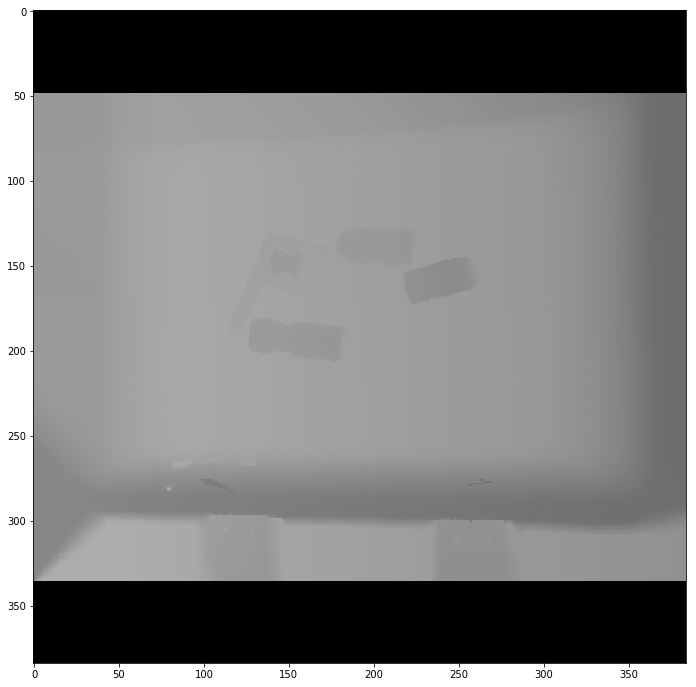

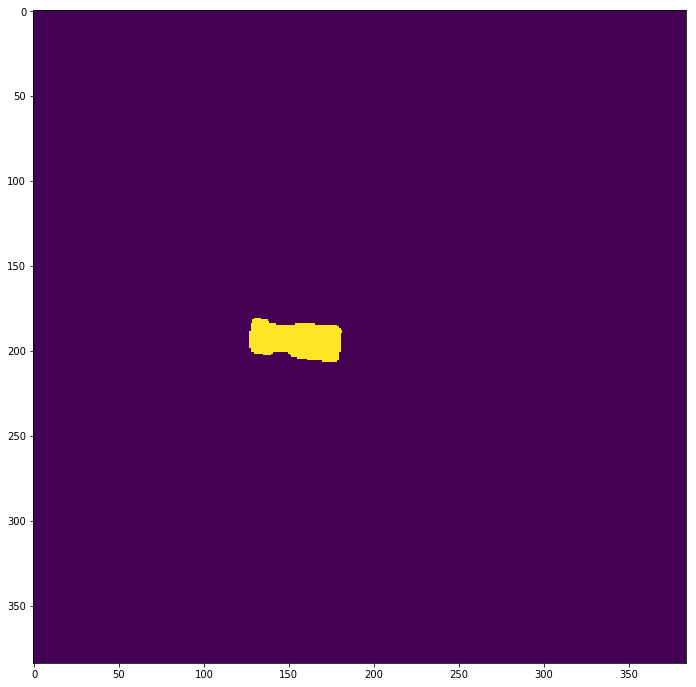

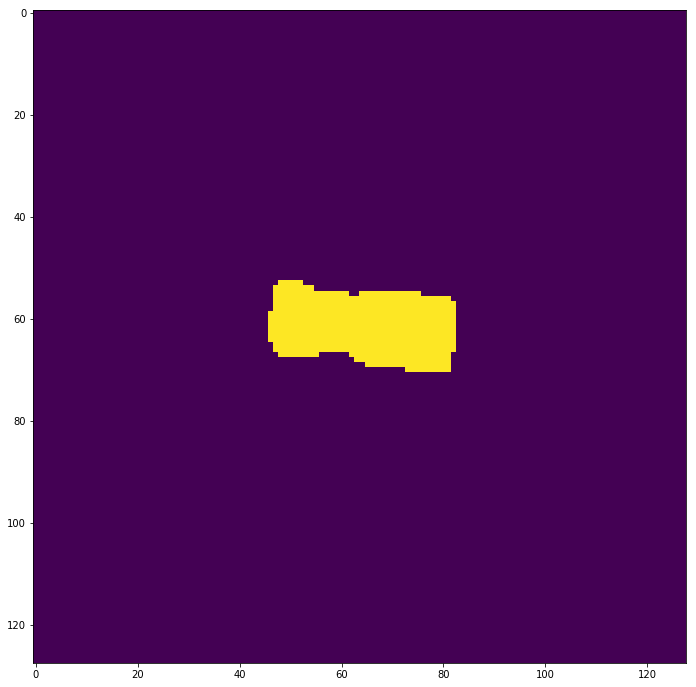

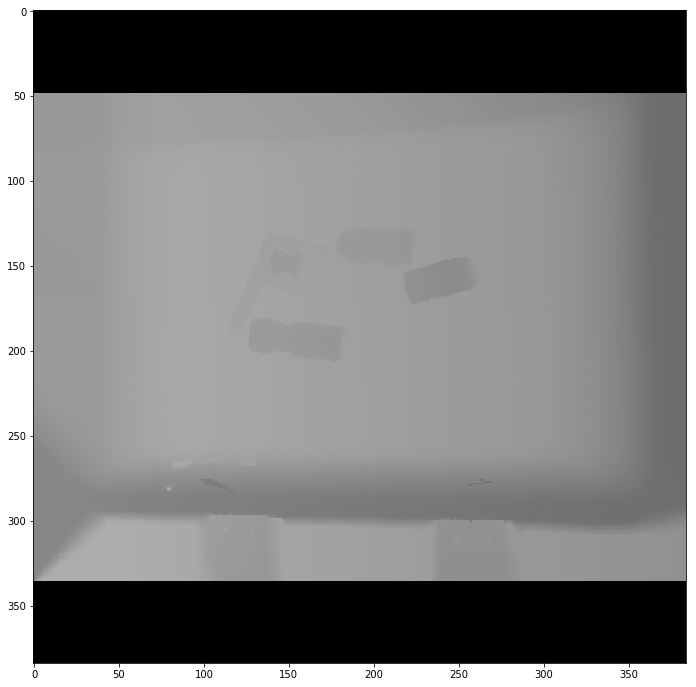

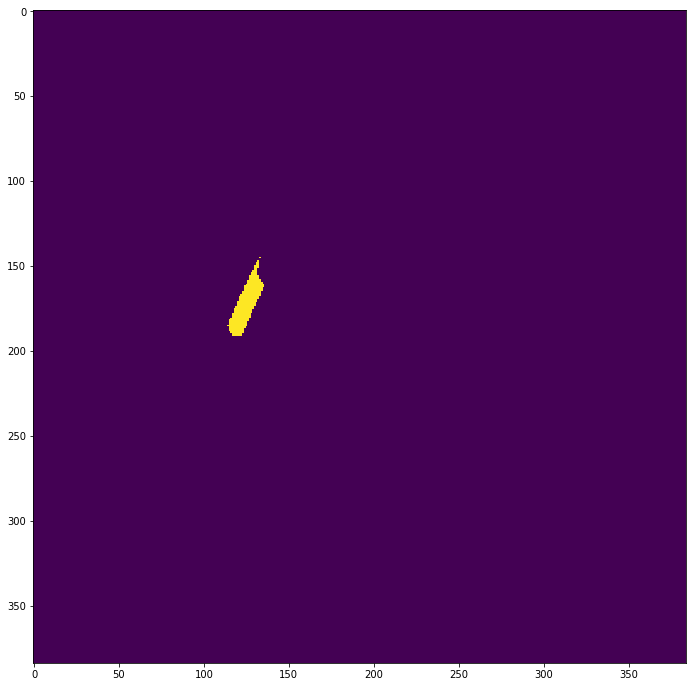

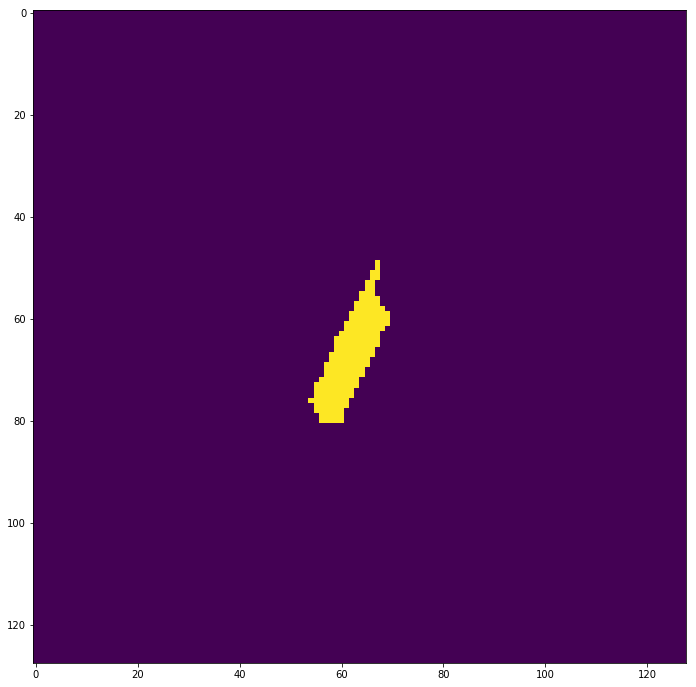

 13%|█▎        | 4/30 [00:11<01:15,  2.90s/it]

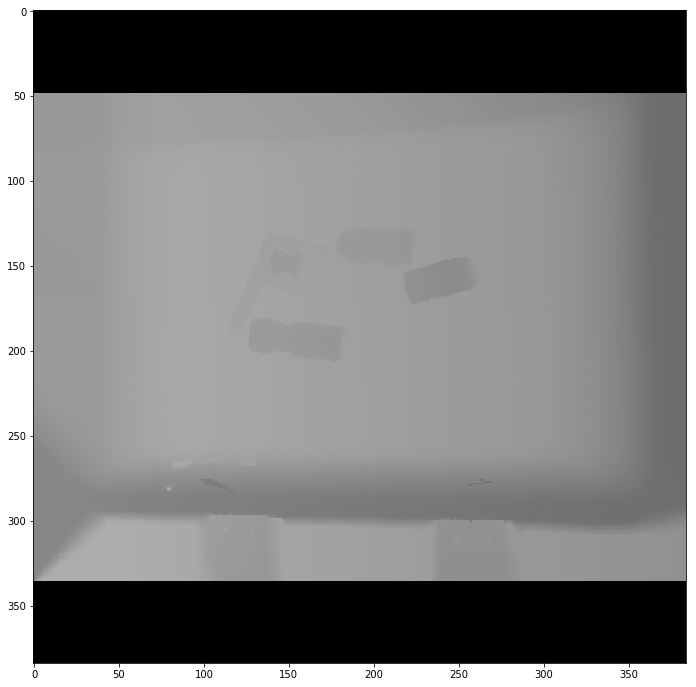

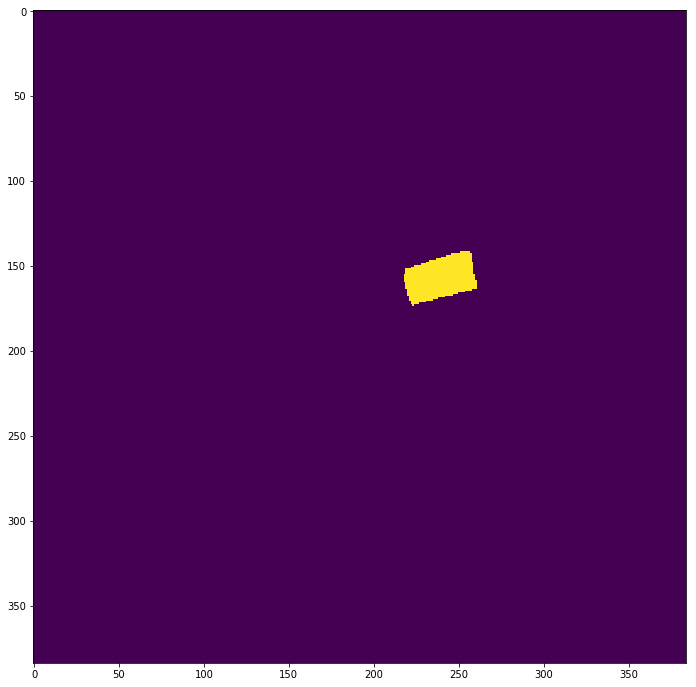

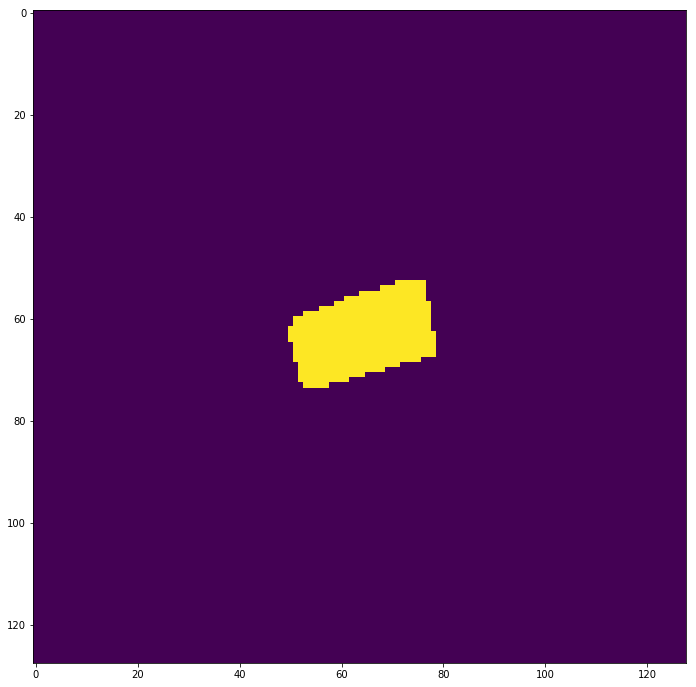

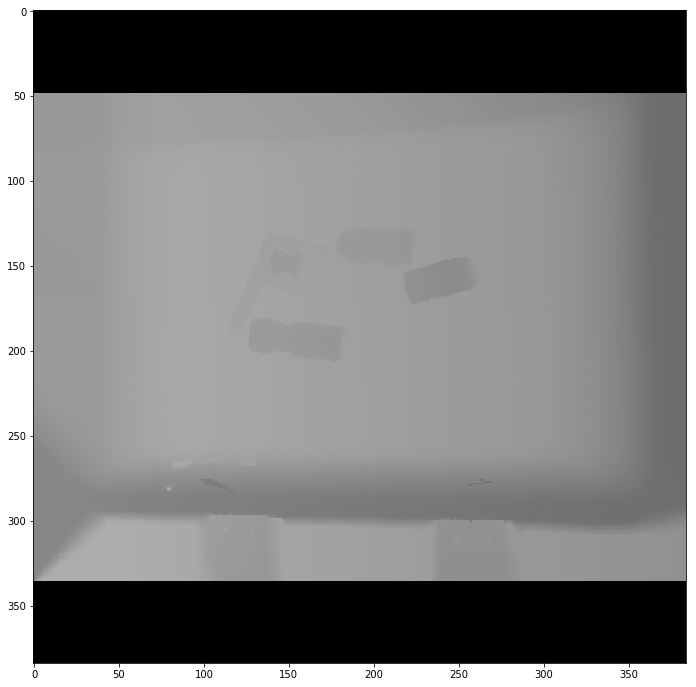

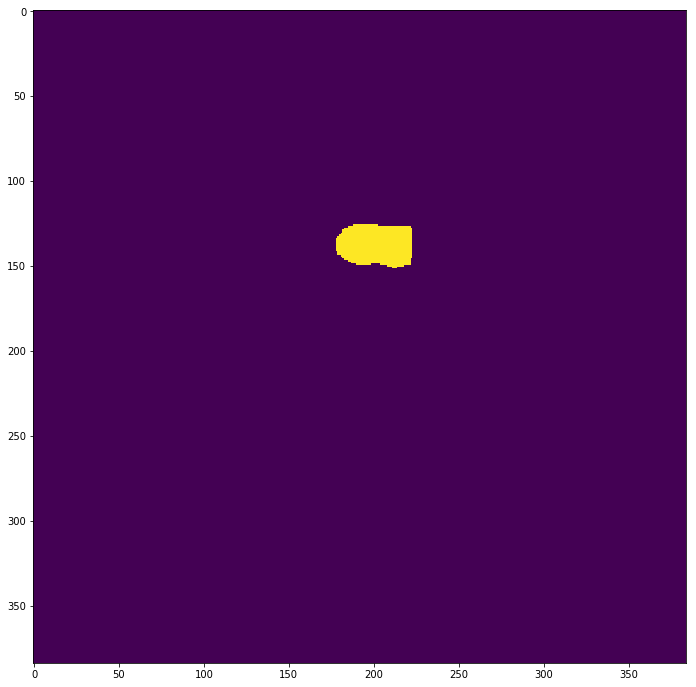

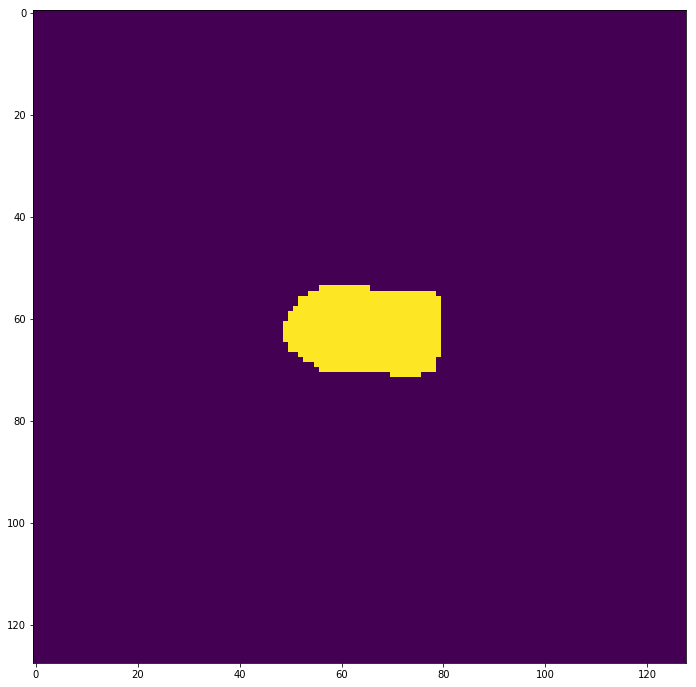

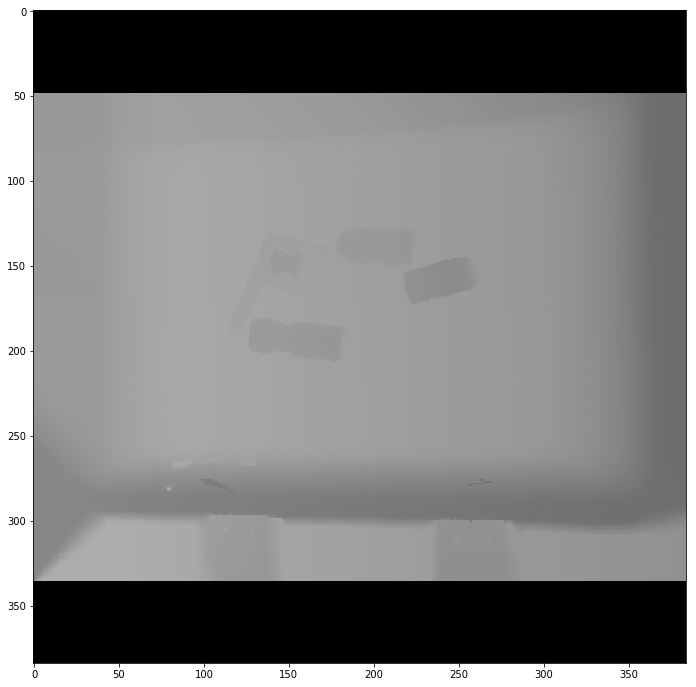

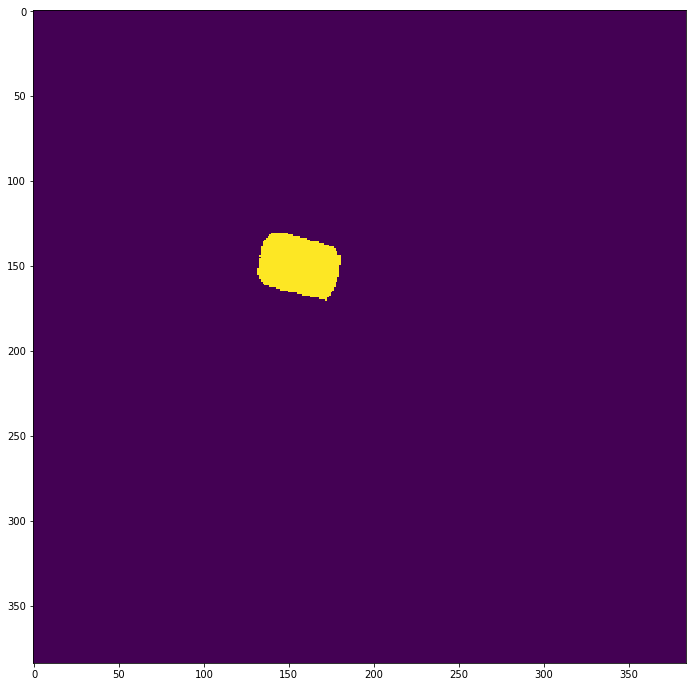

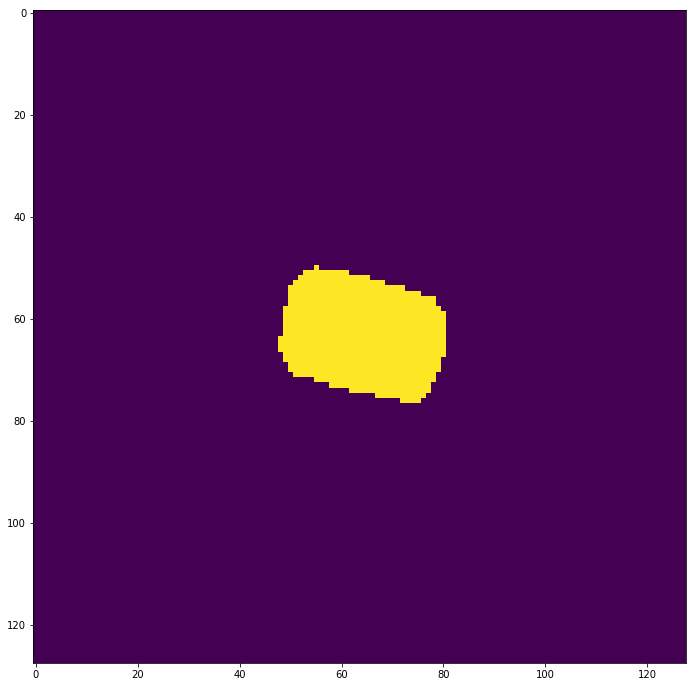

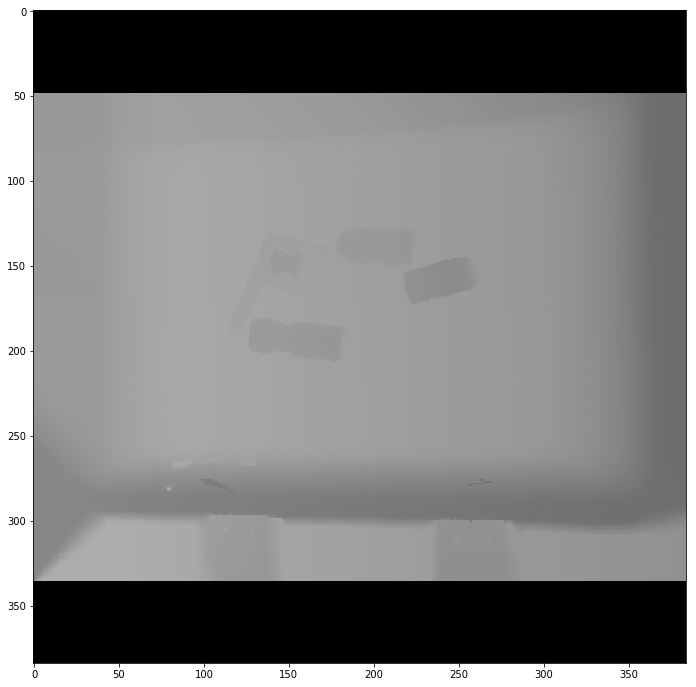

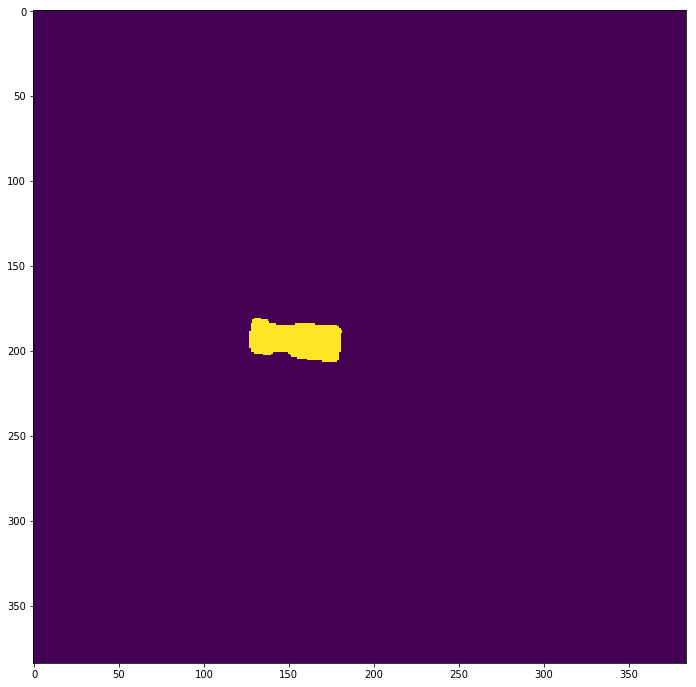

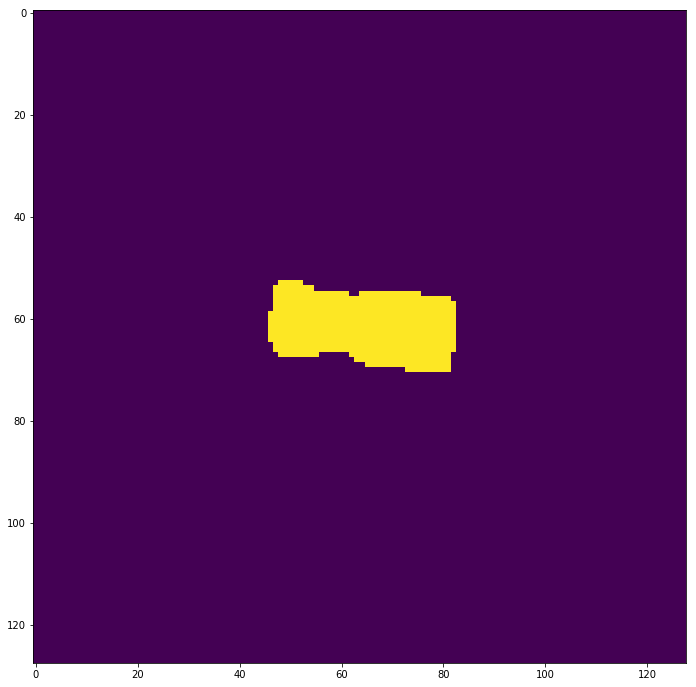

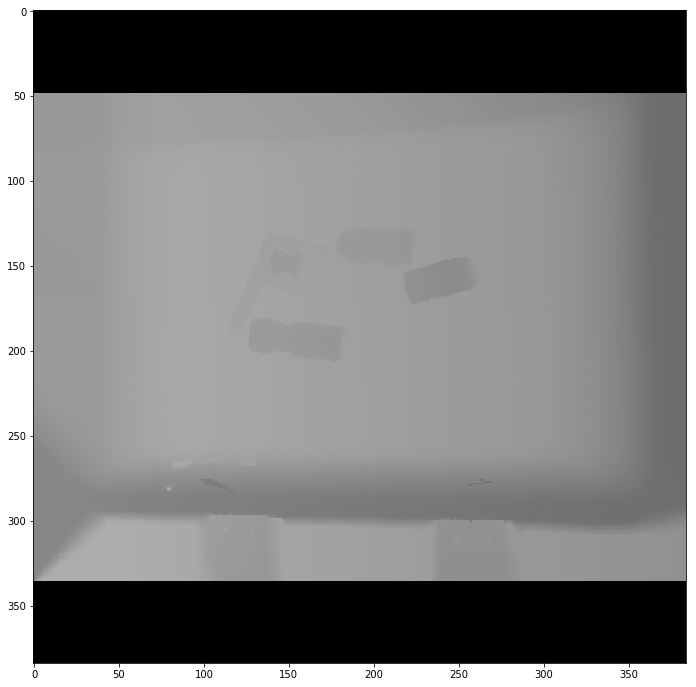

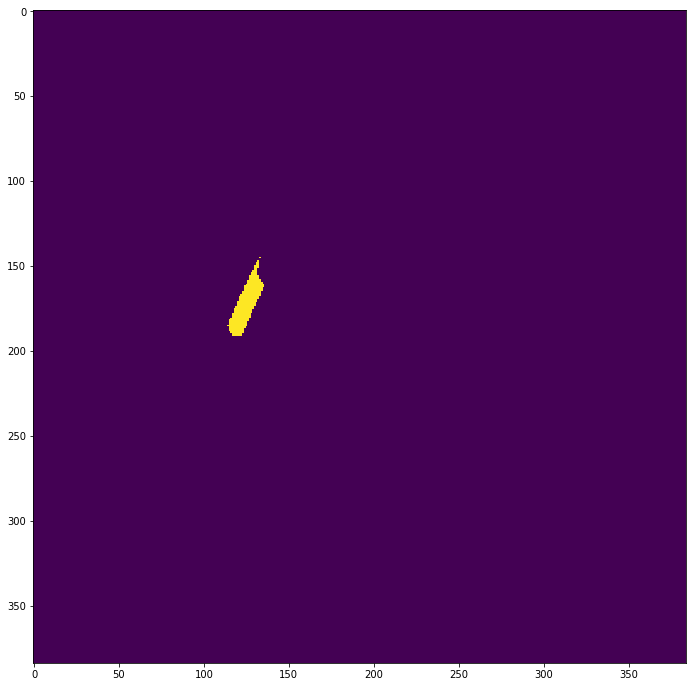

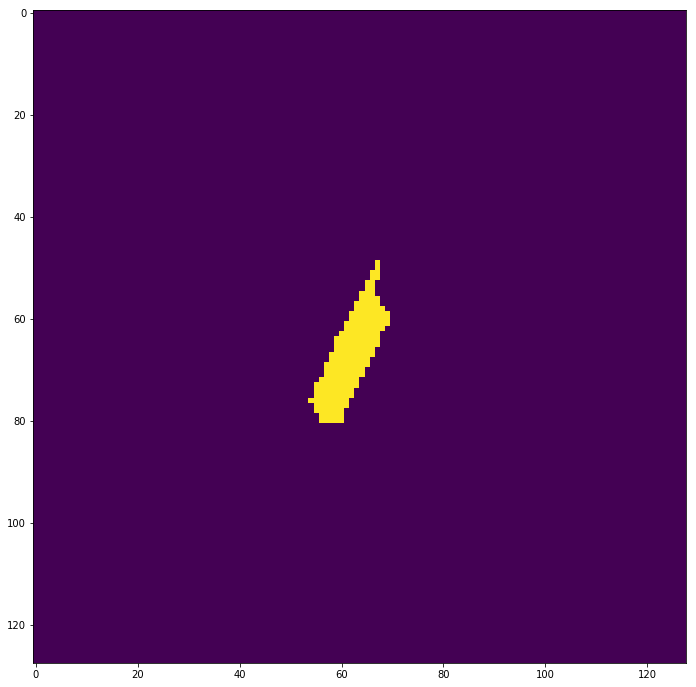

 17%|█▋        | 5/30 [00:14<01:12,  2.89s/it]

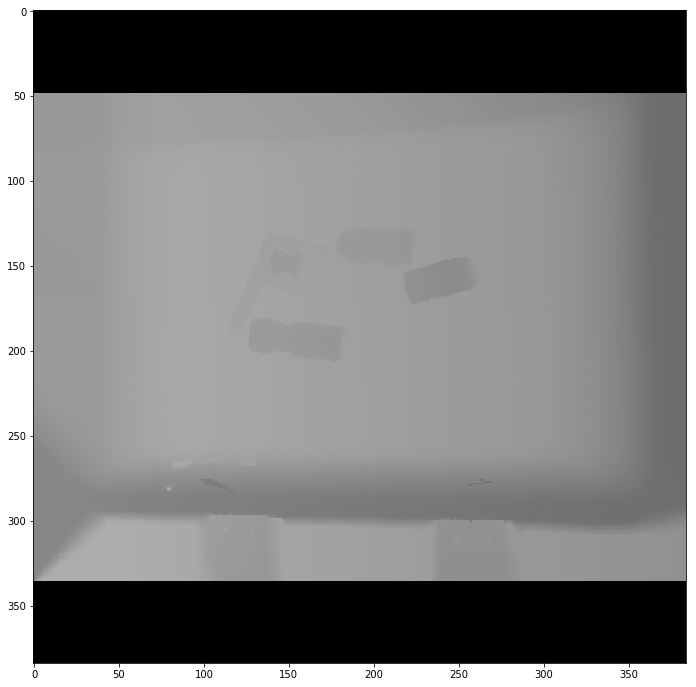

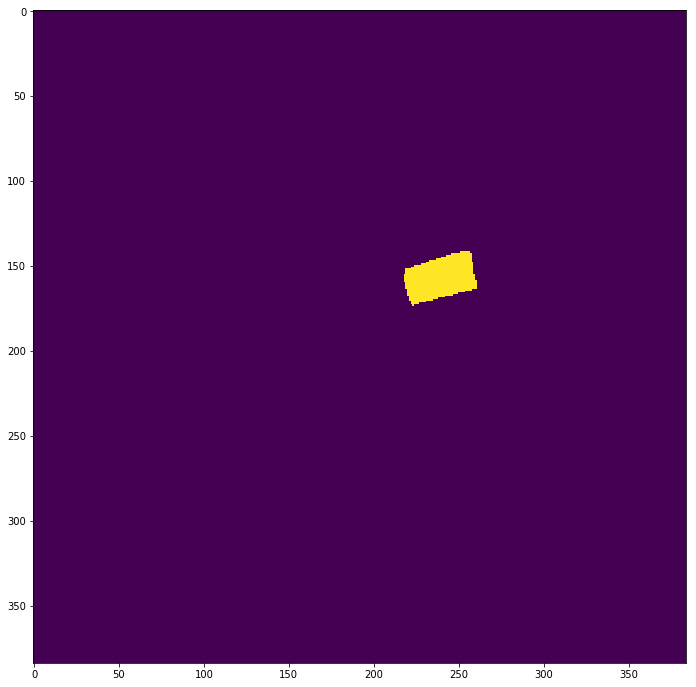

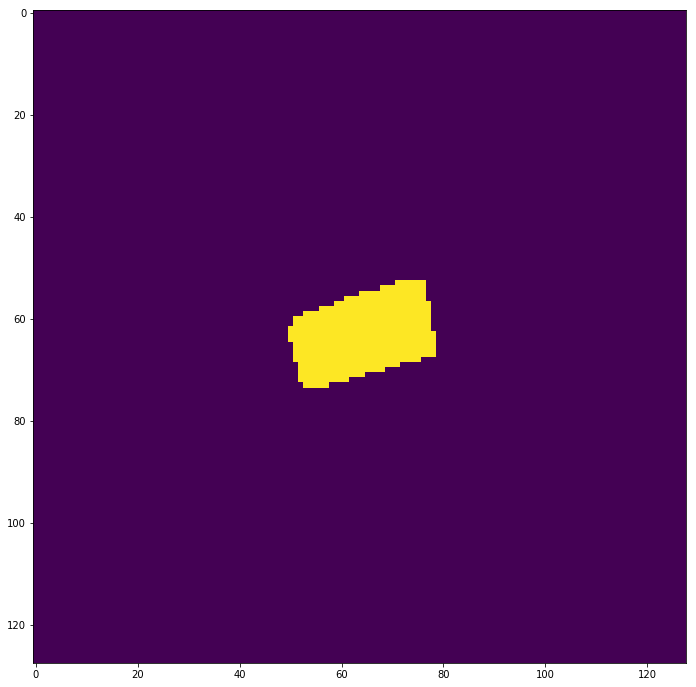

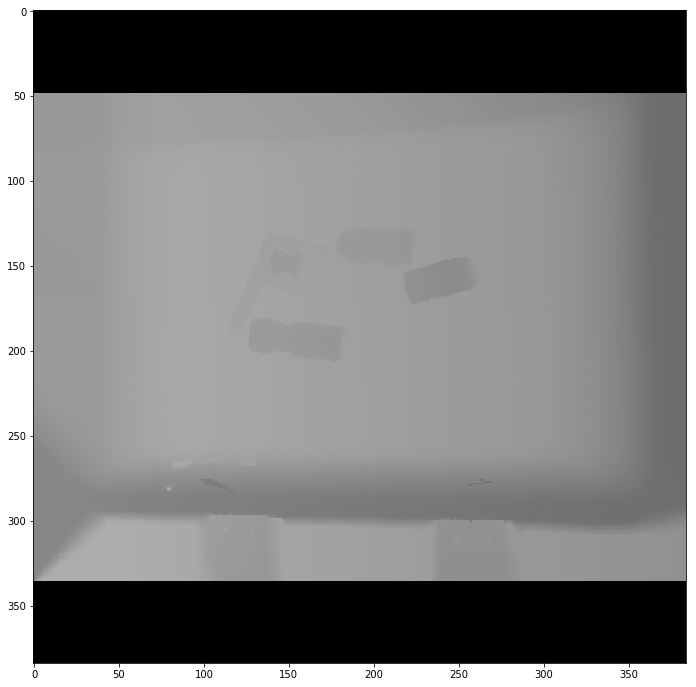

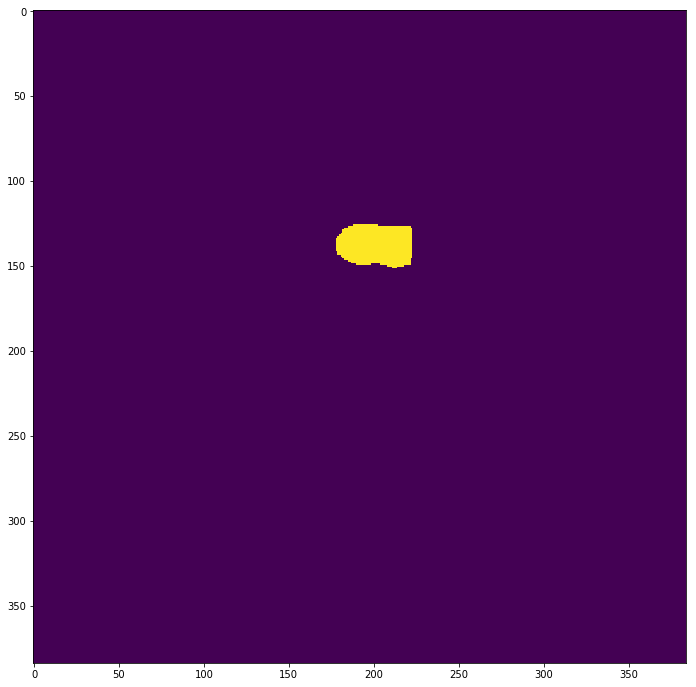

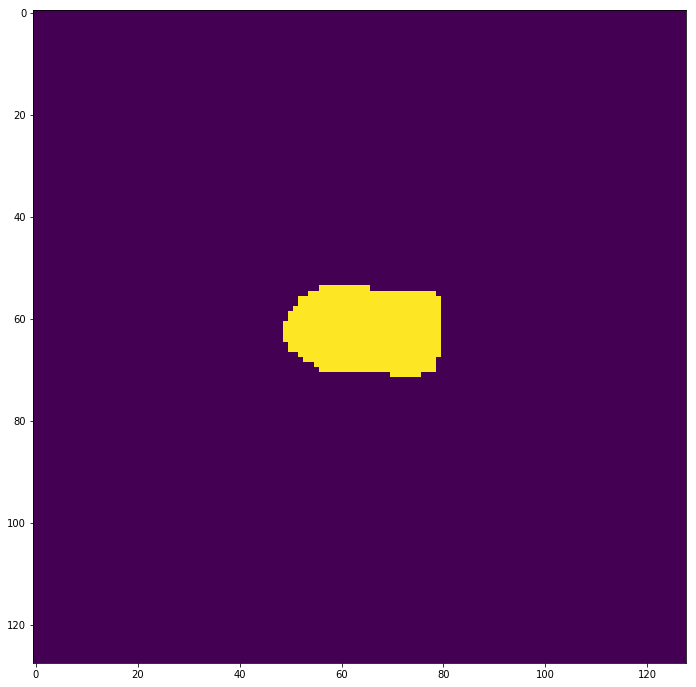

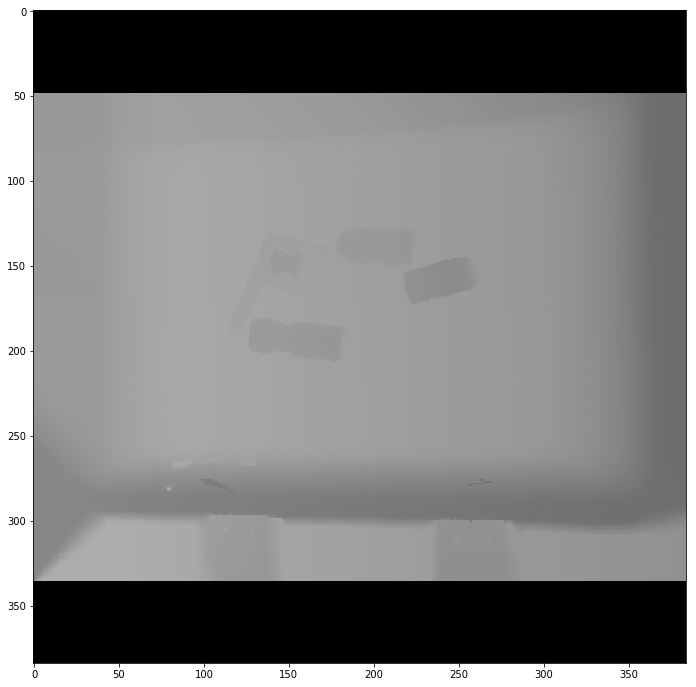

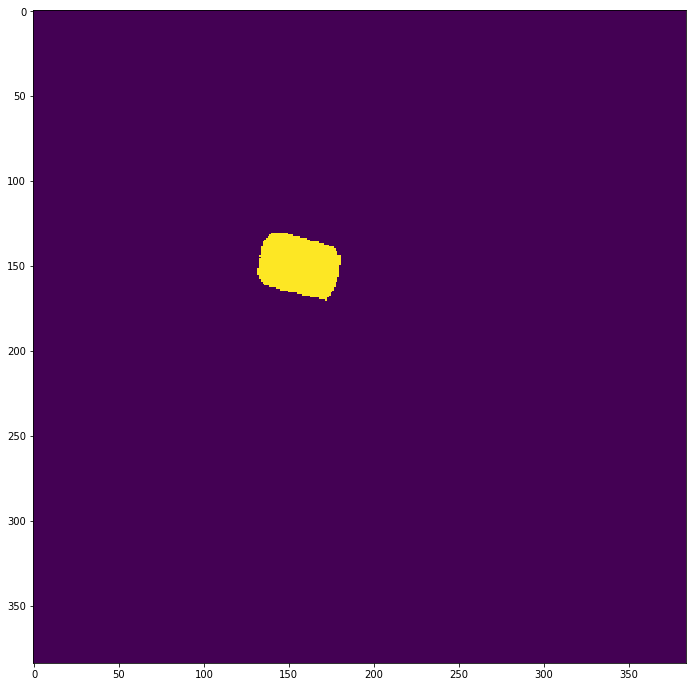

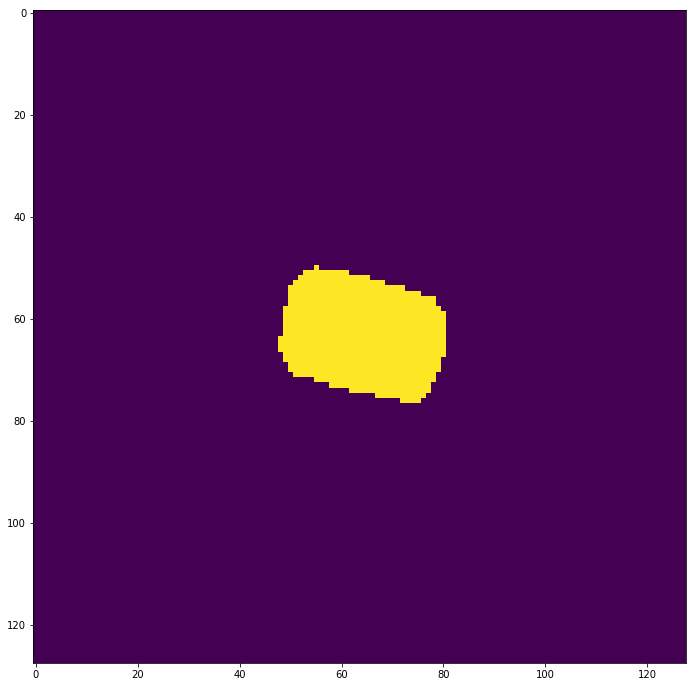

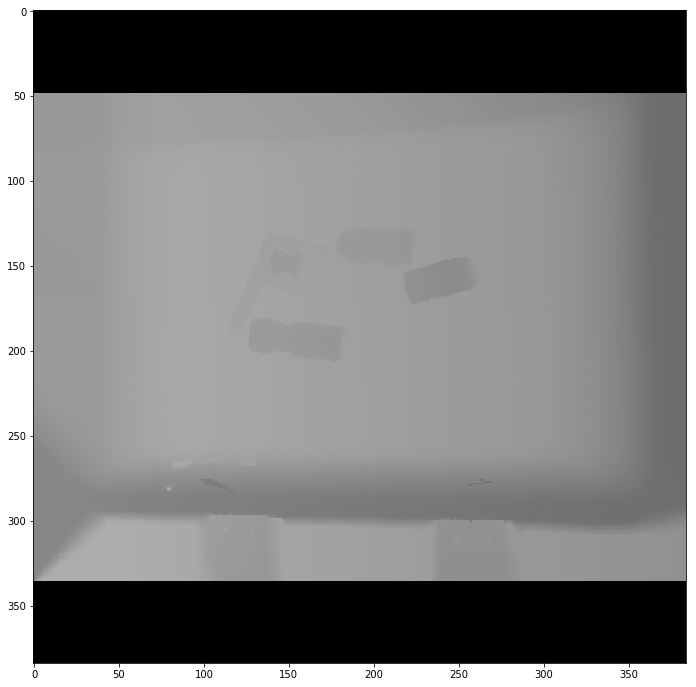

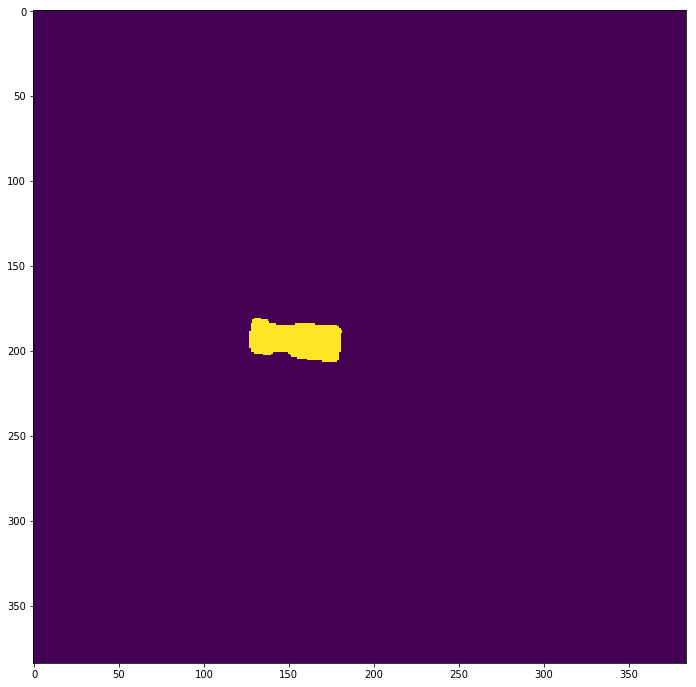

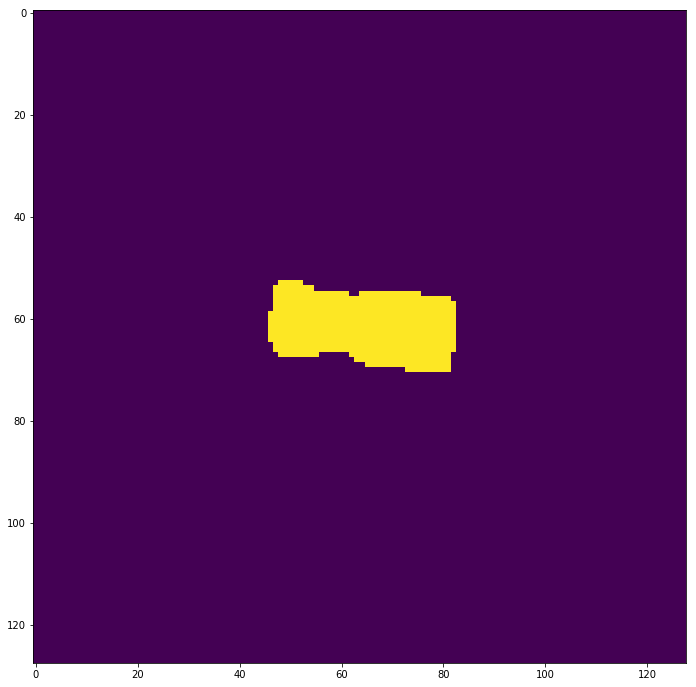

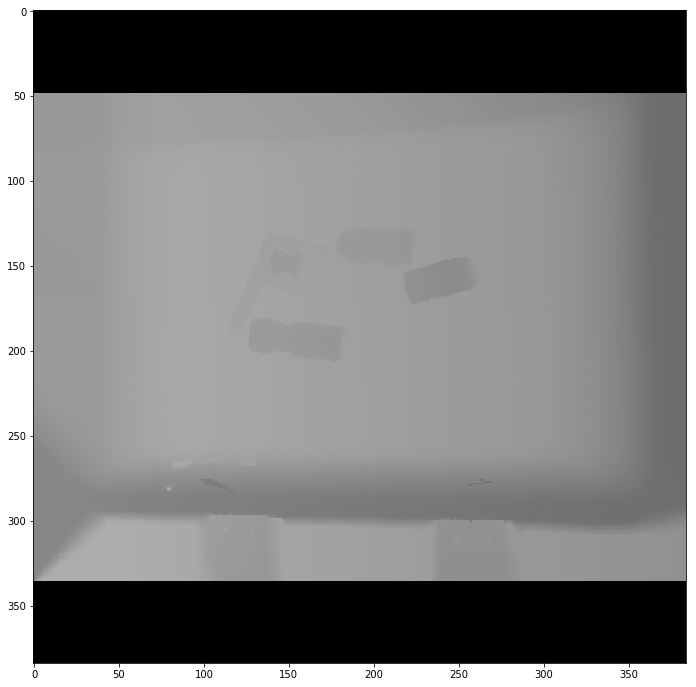

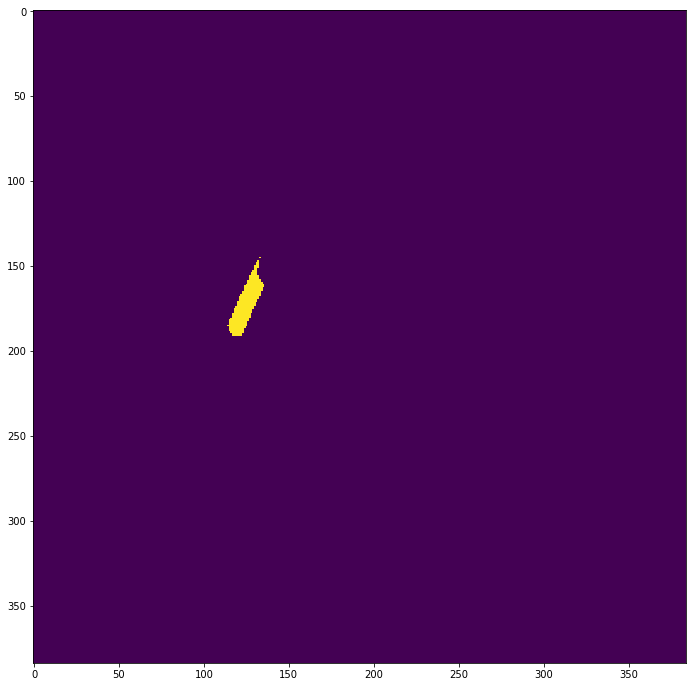

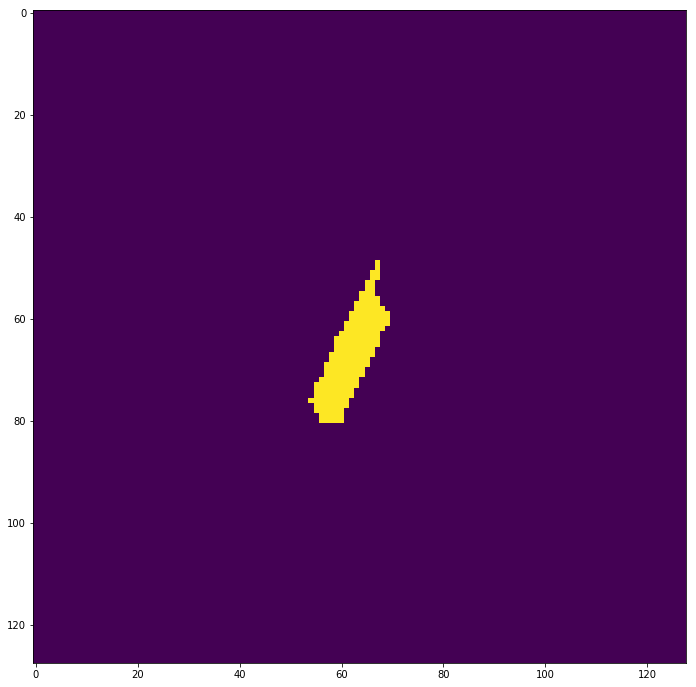

 20%|██        | 6/30 [00:17<01:09,  2.90s/it]

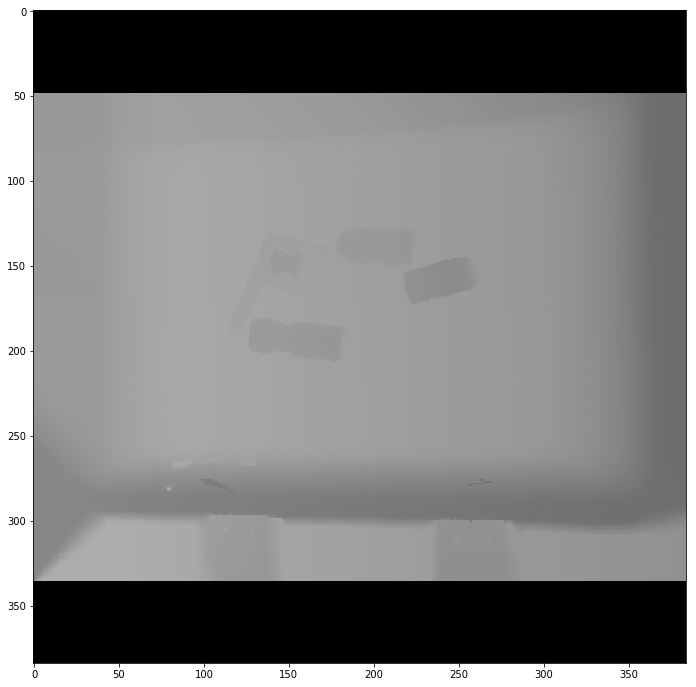

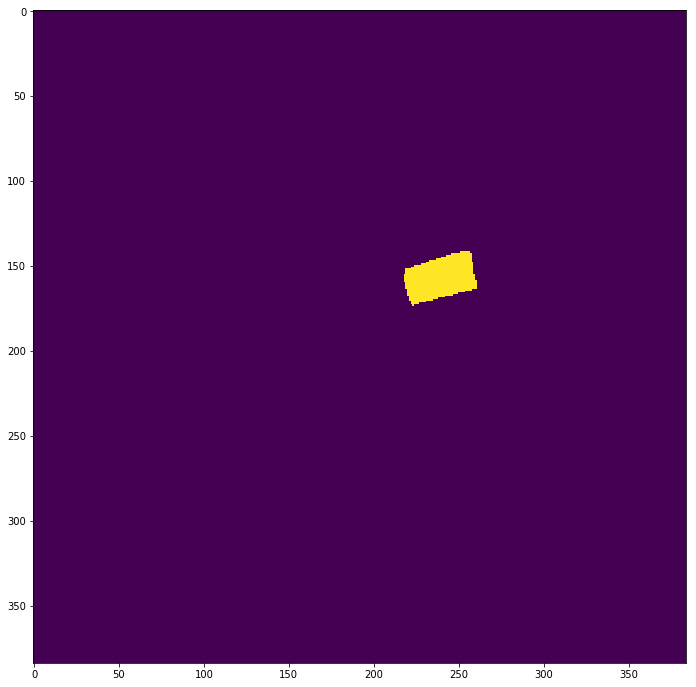

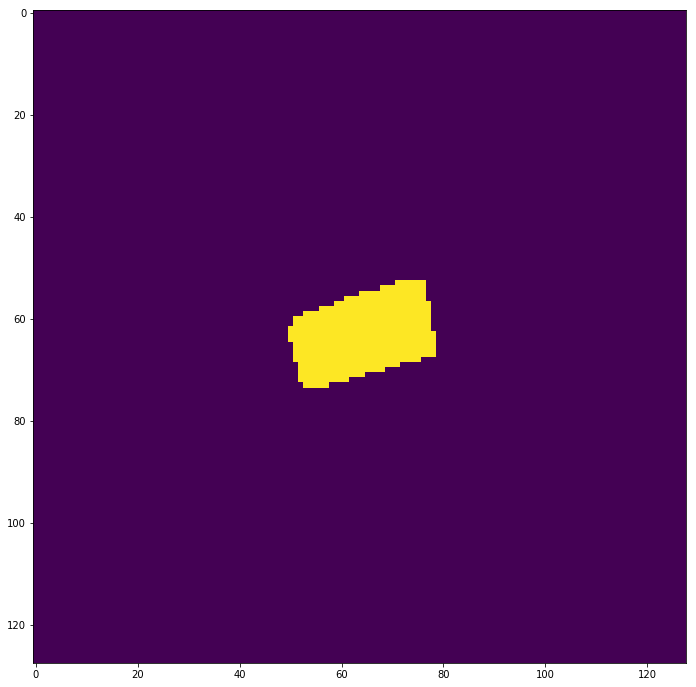

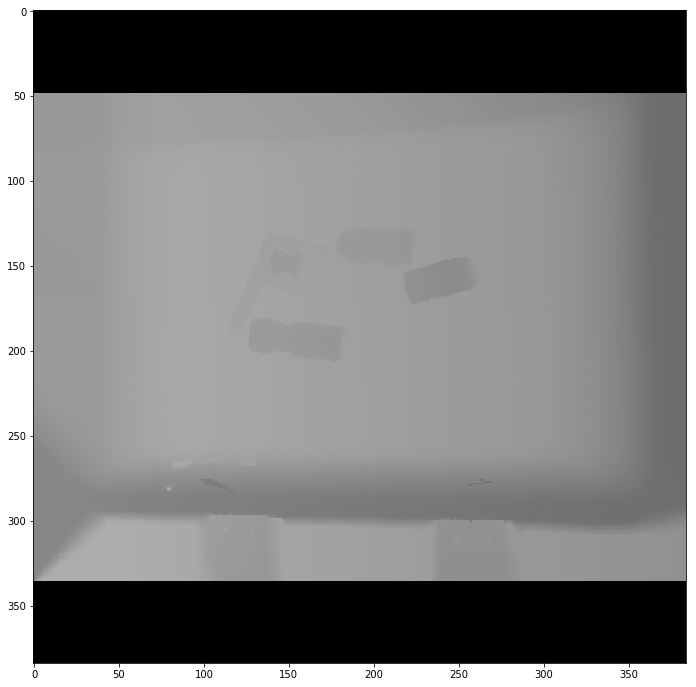

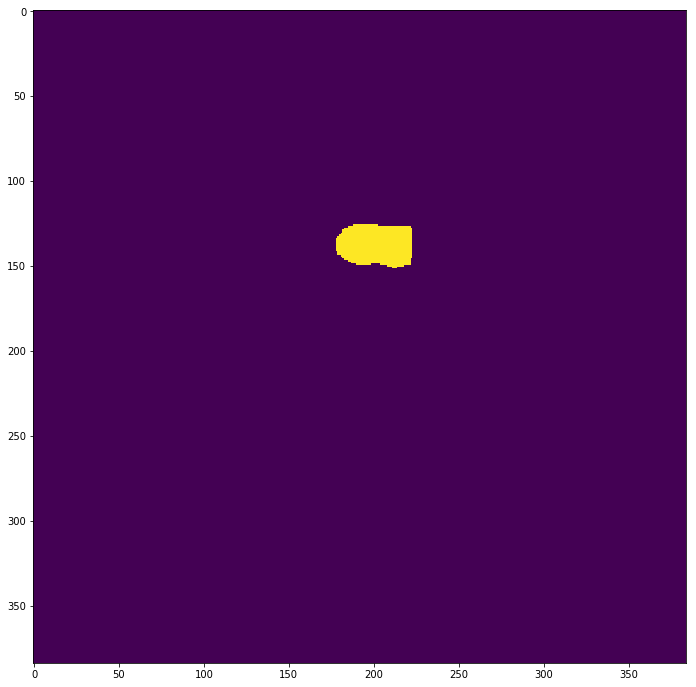

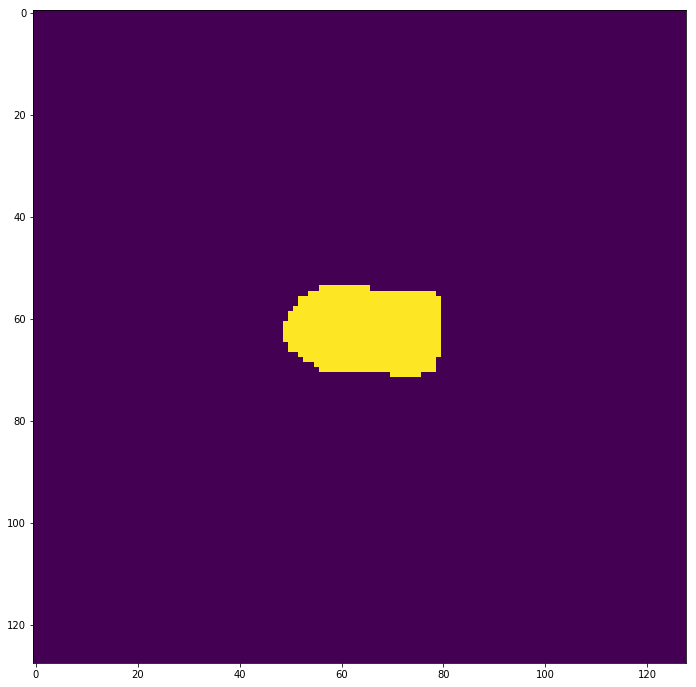

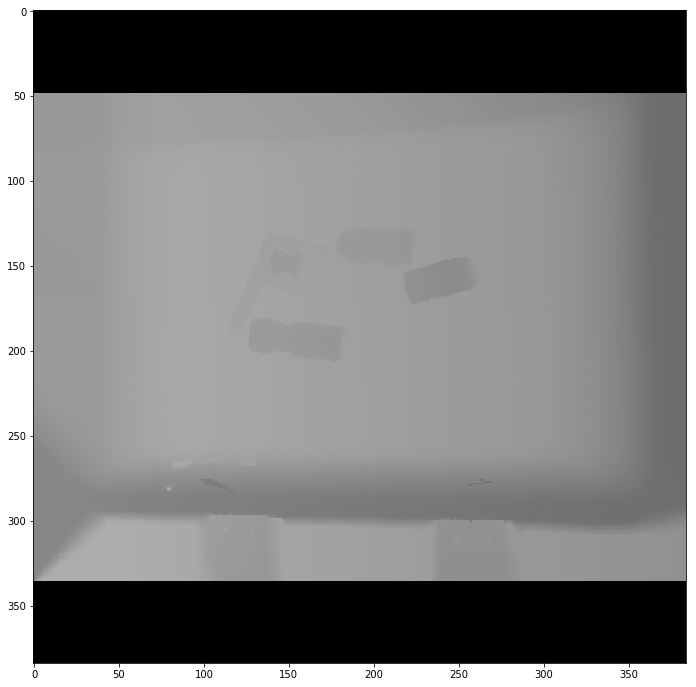

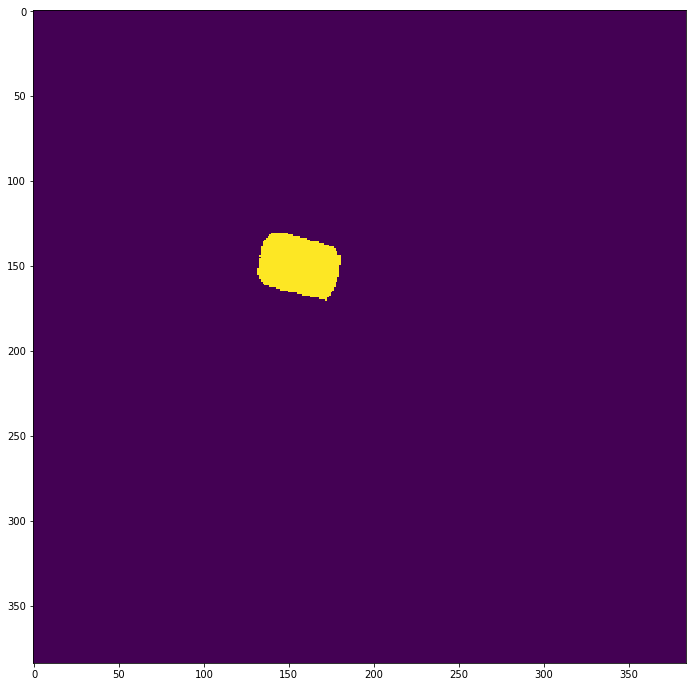

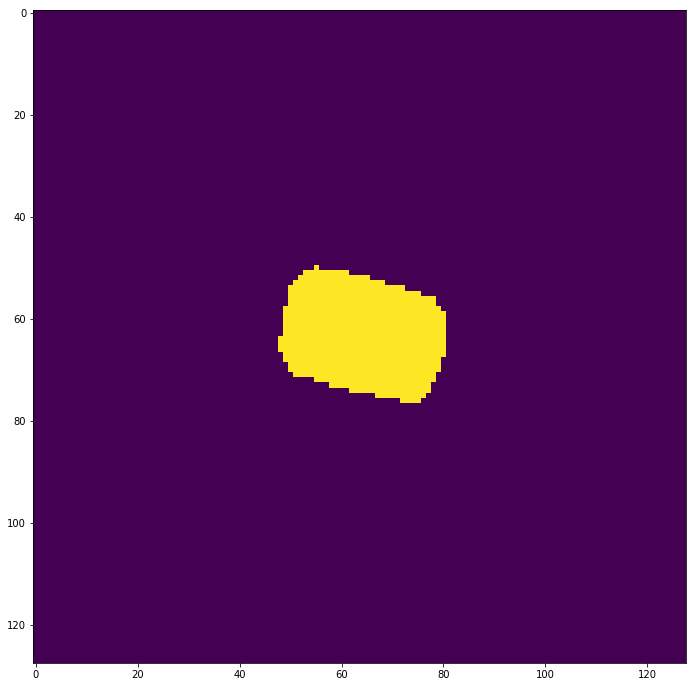

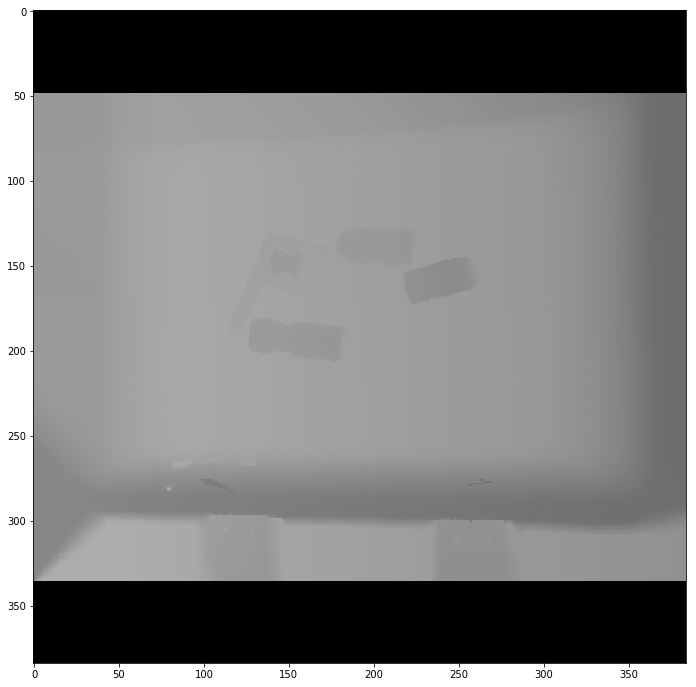

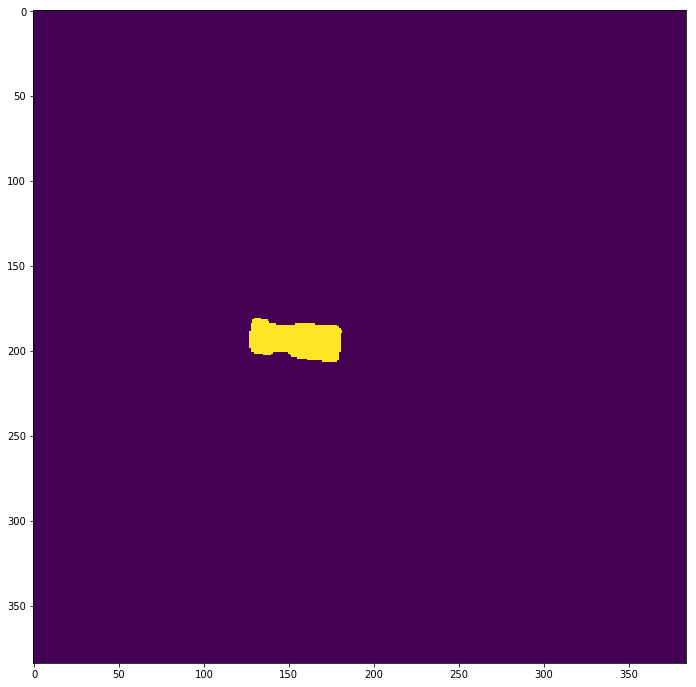

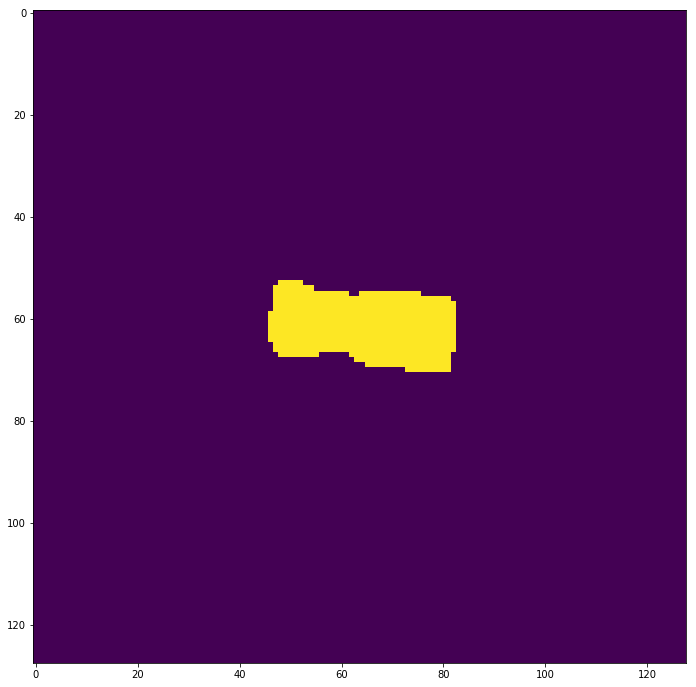

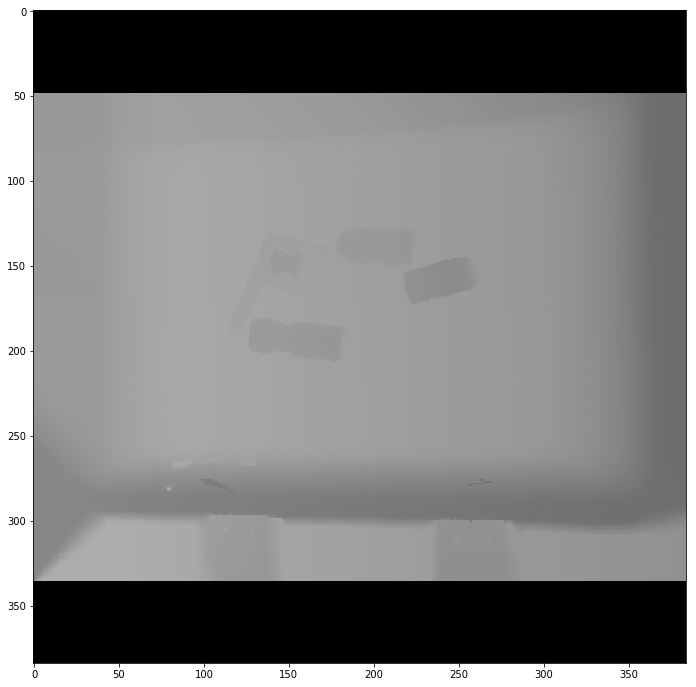

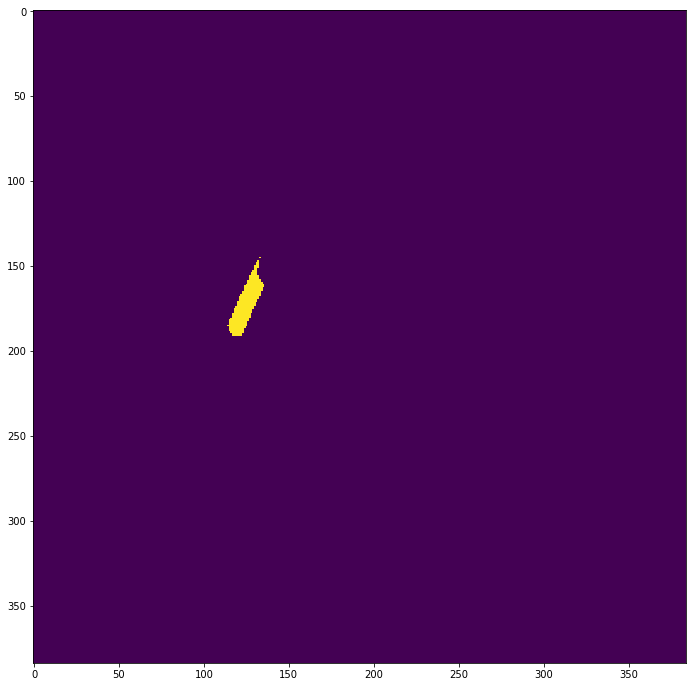

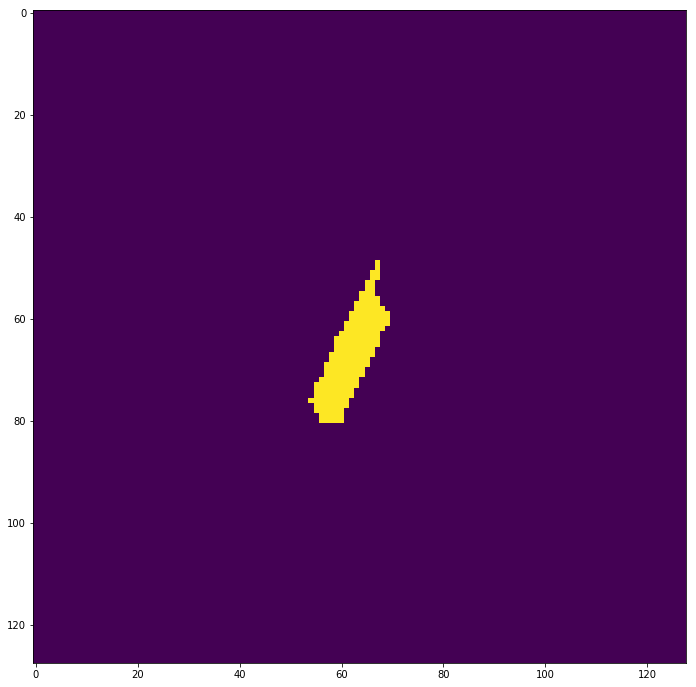

 23%|██▎       | 7/30 [00:20<01:06,  2.91s/it]

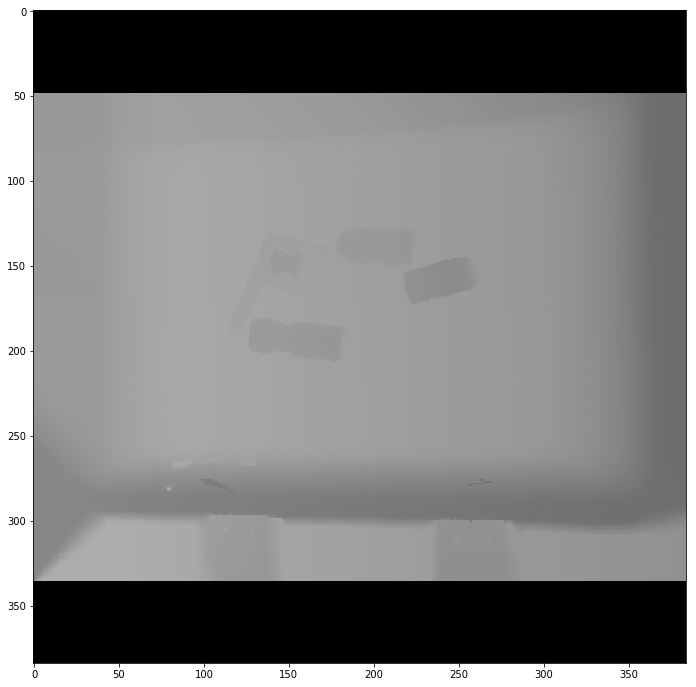

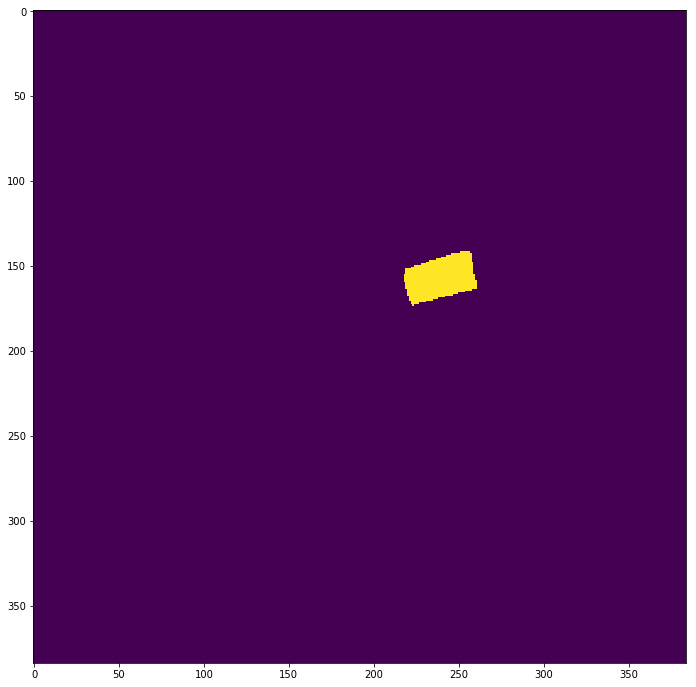

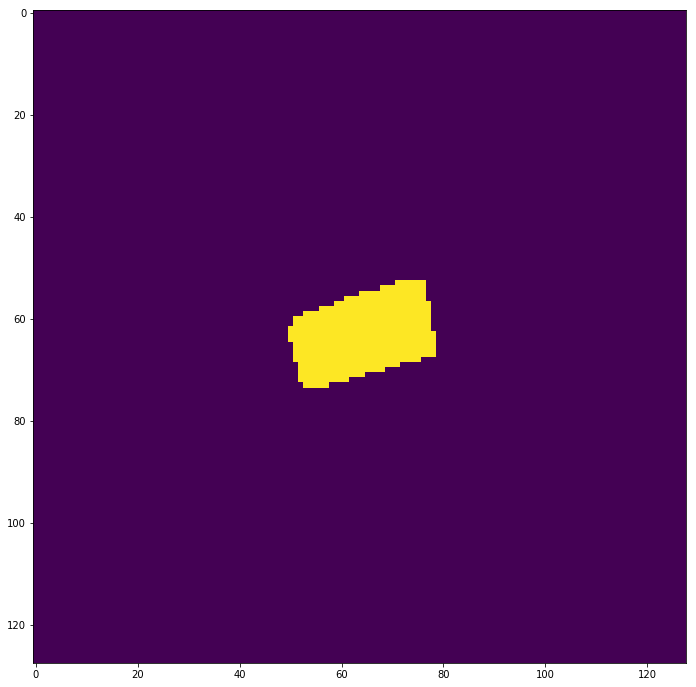

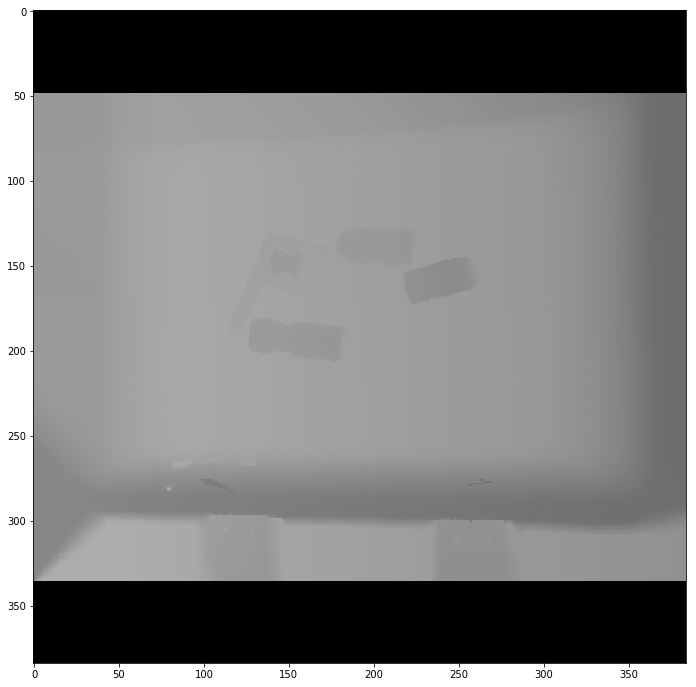

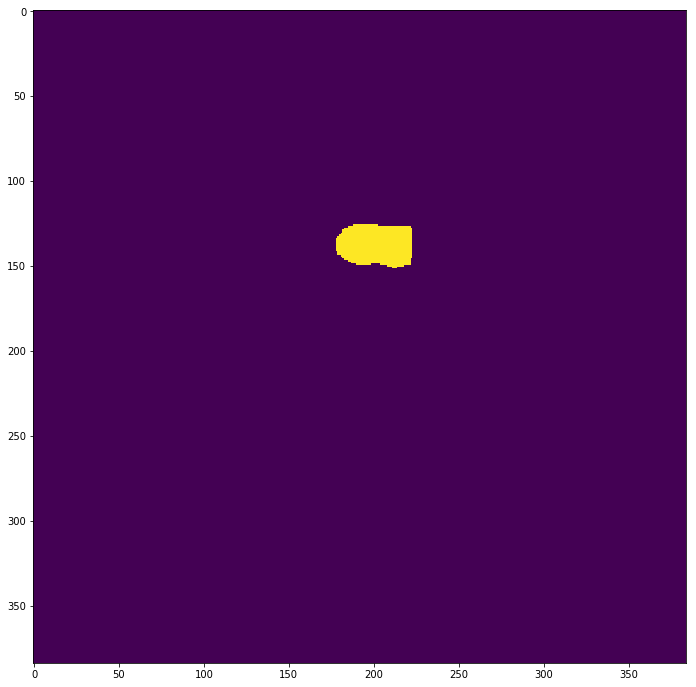

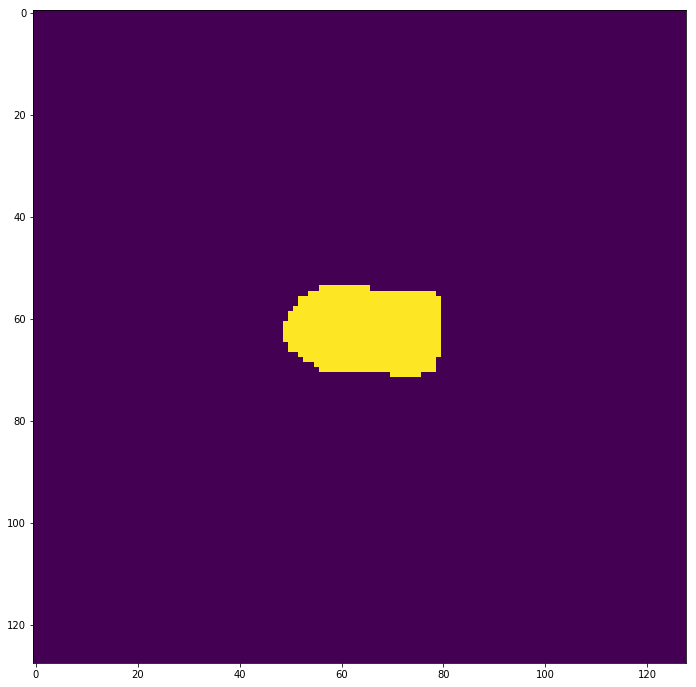

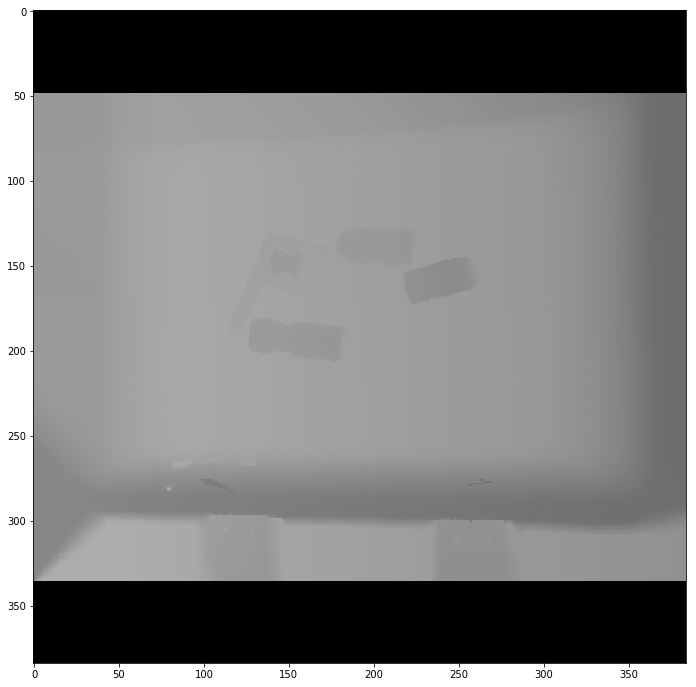

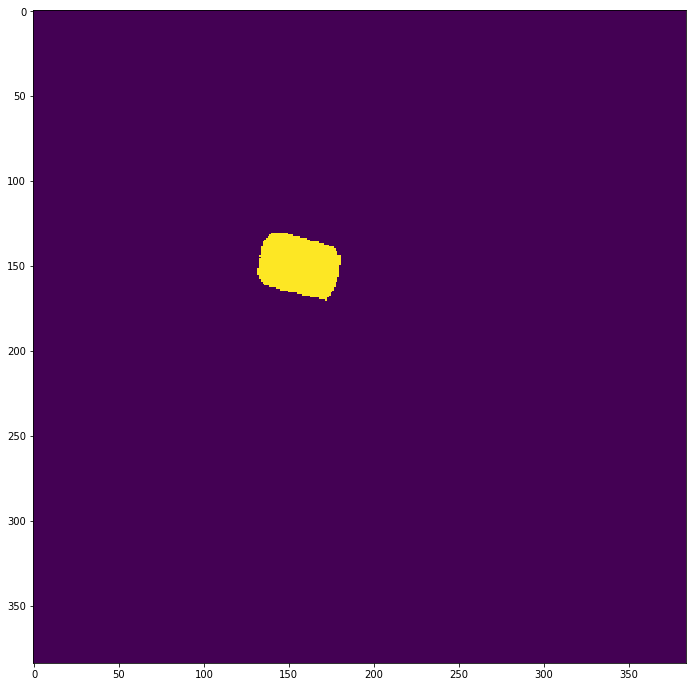

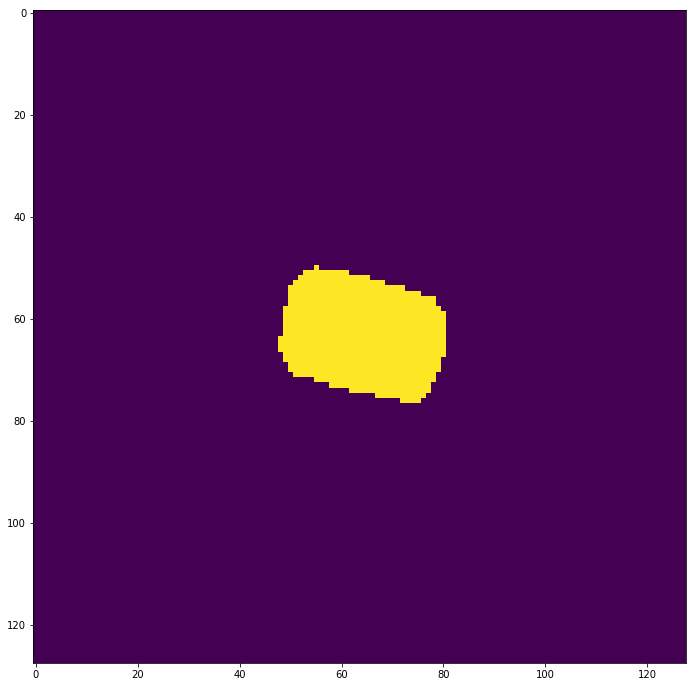

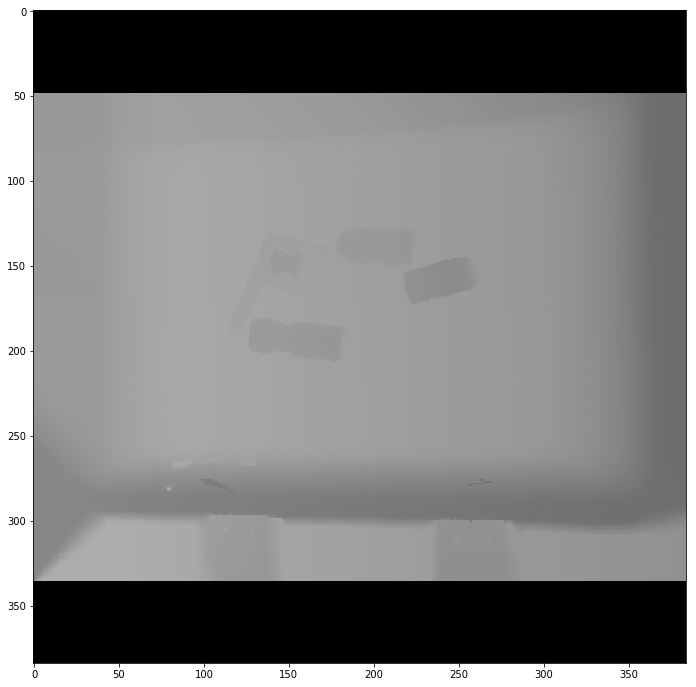

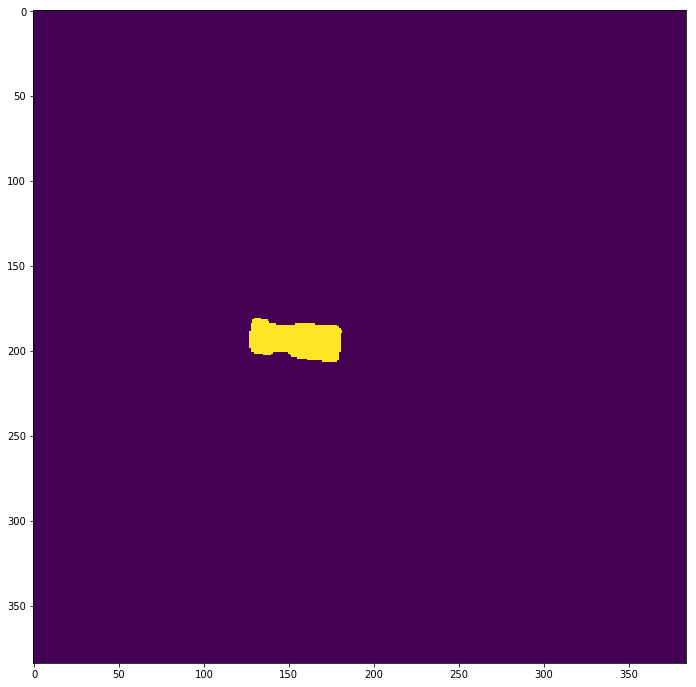

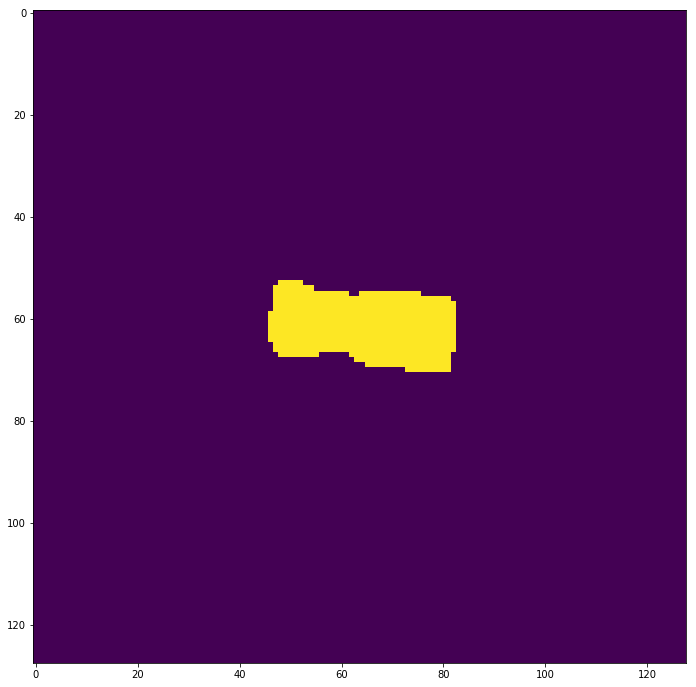

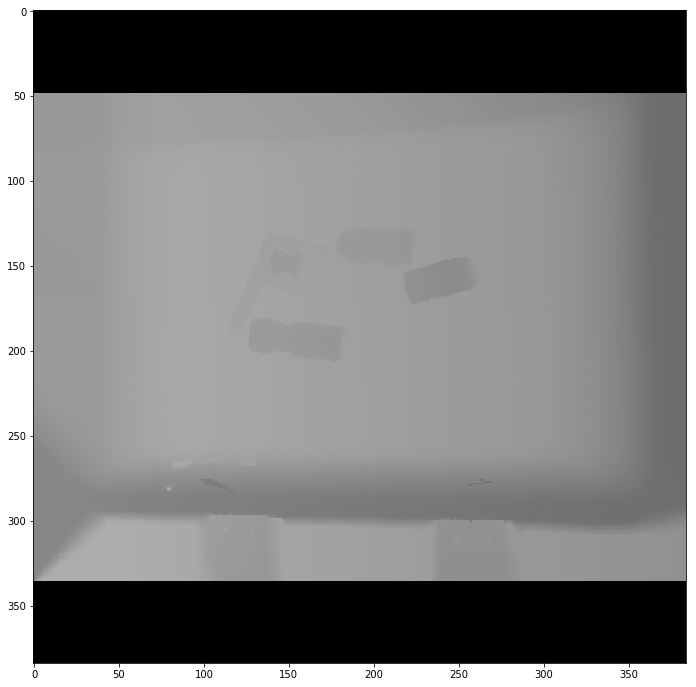

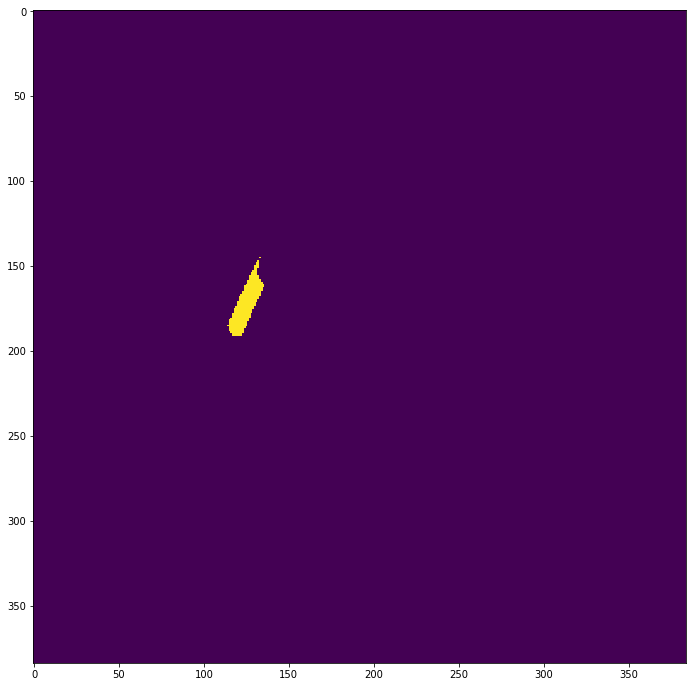

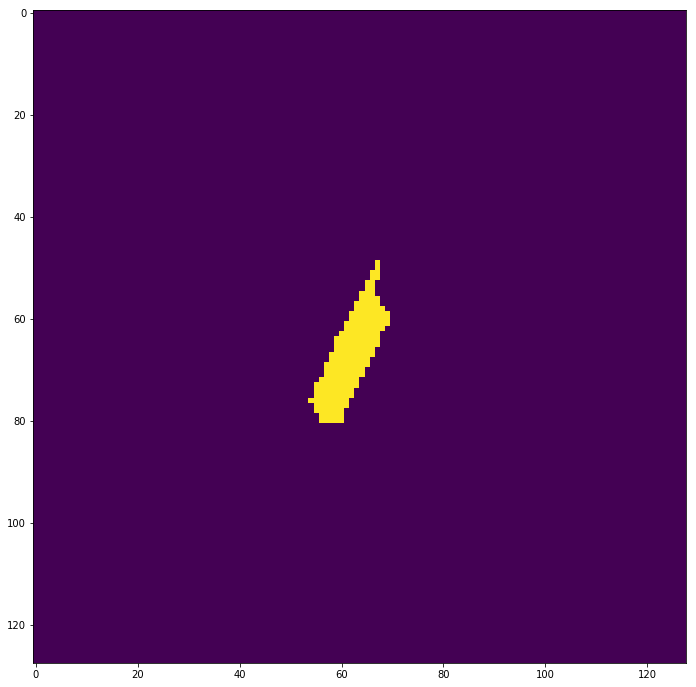

 27%|██▋       | 8/30 [00:23<01:03,  2.89s/it]

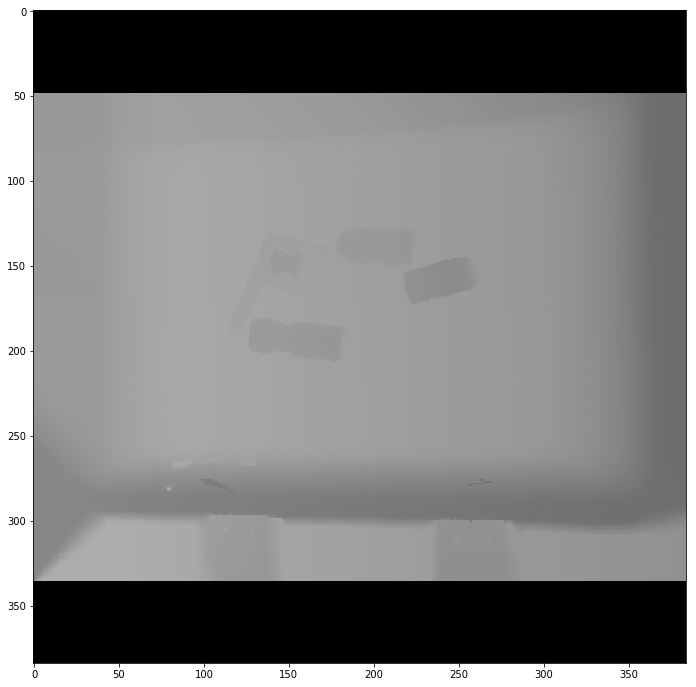

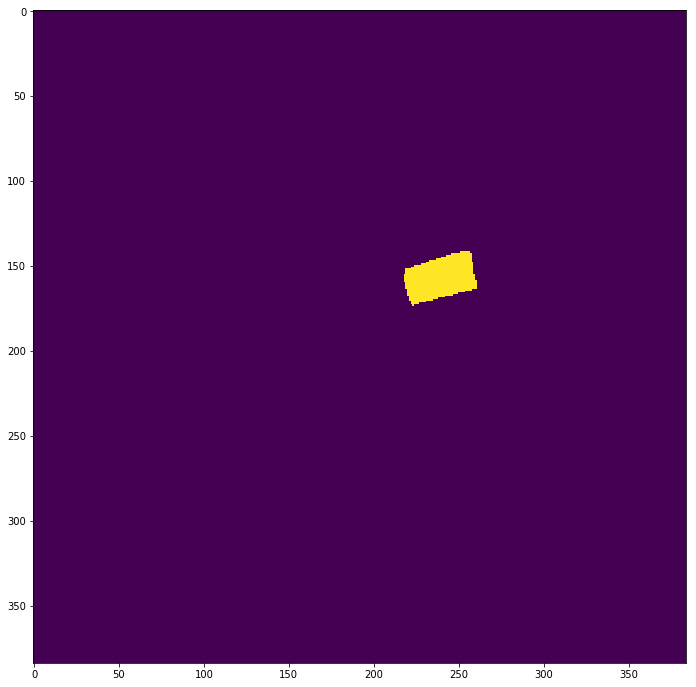

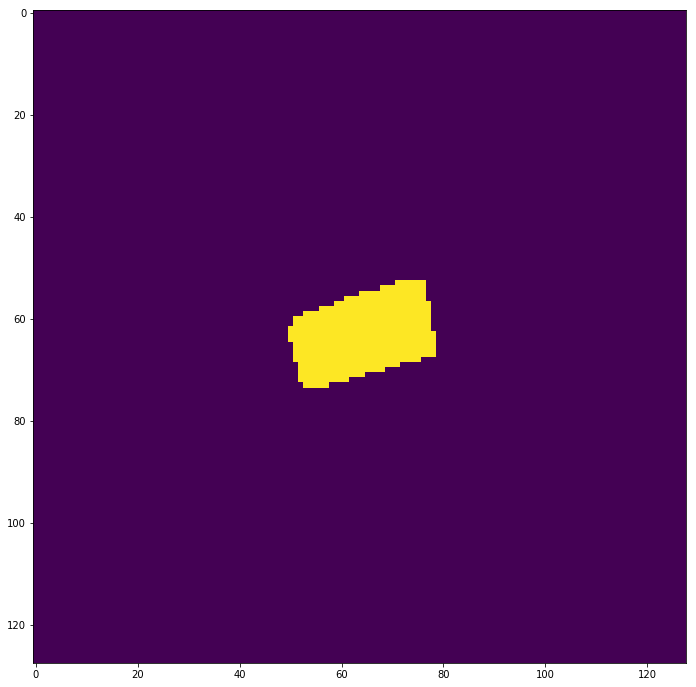

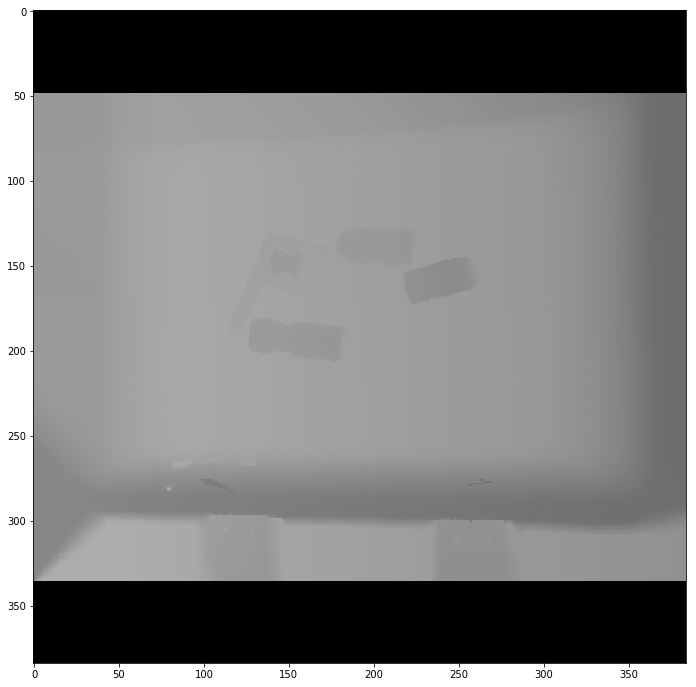

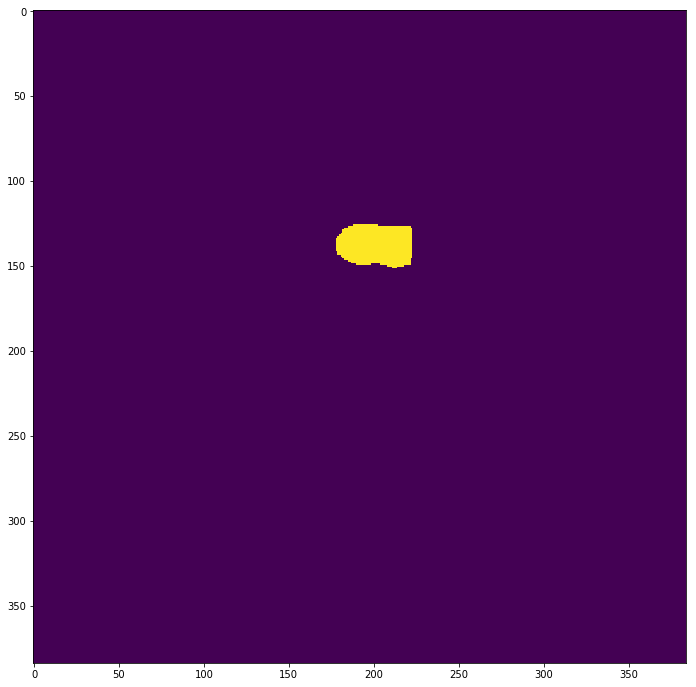

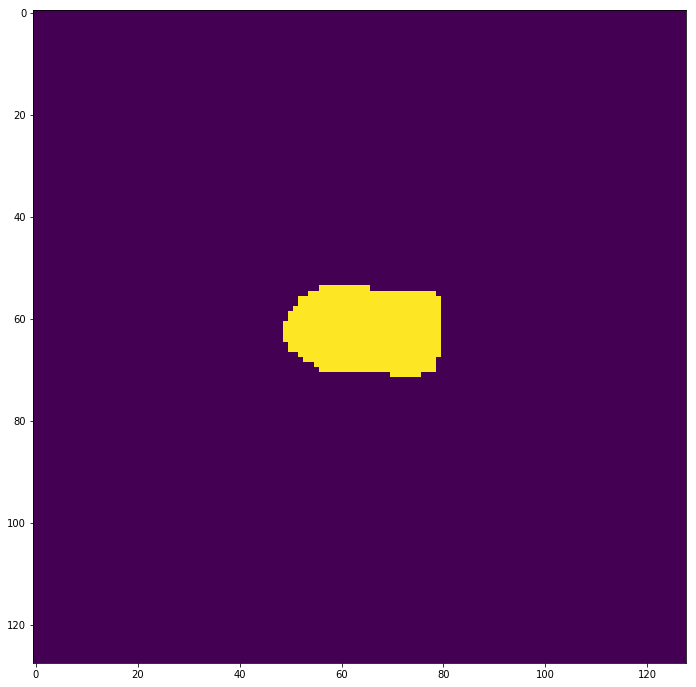

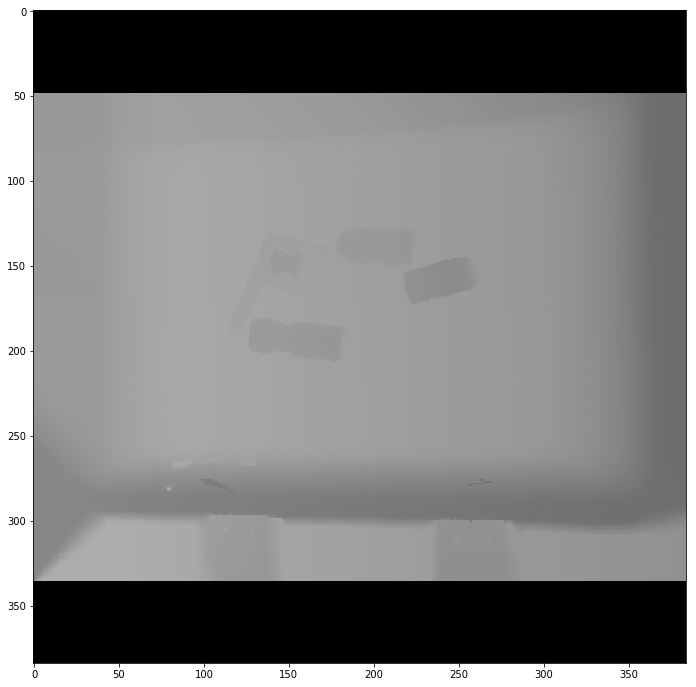

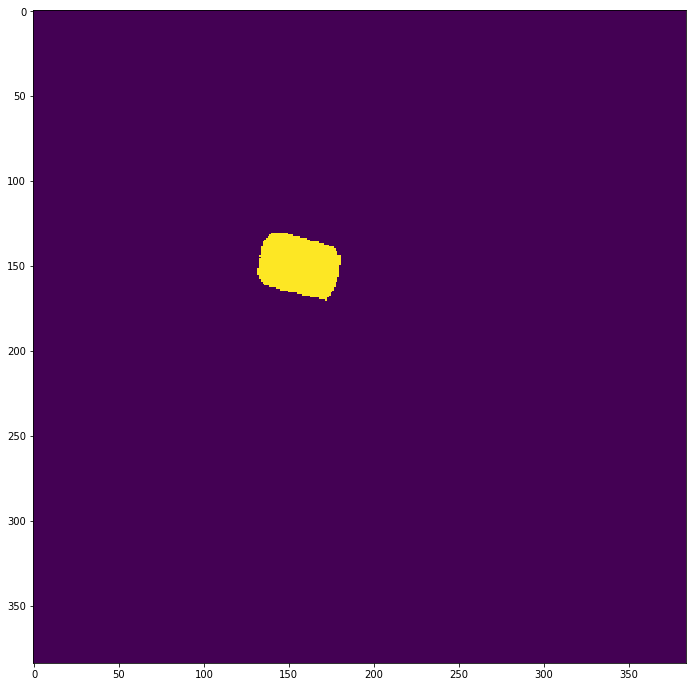

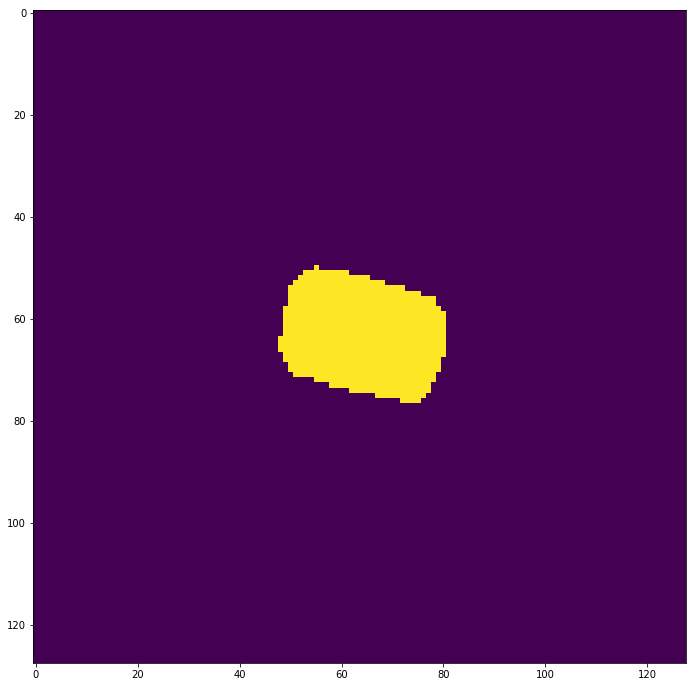

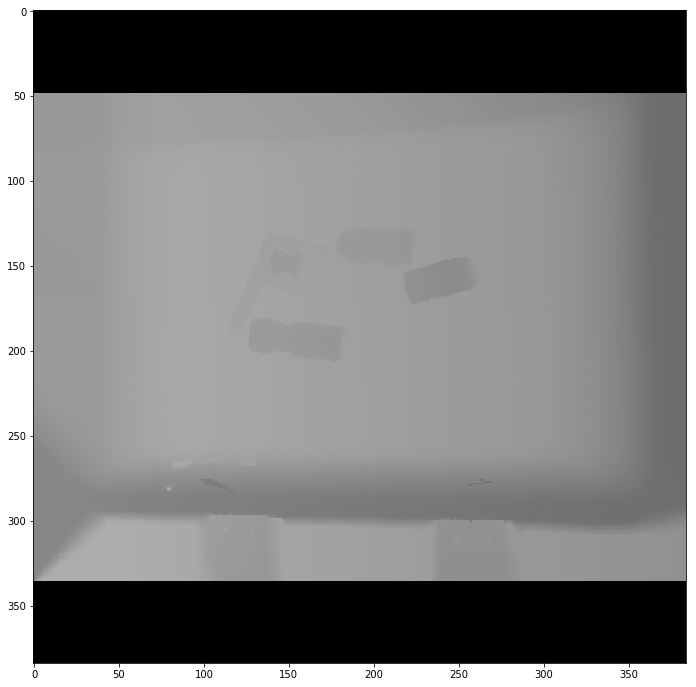

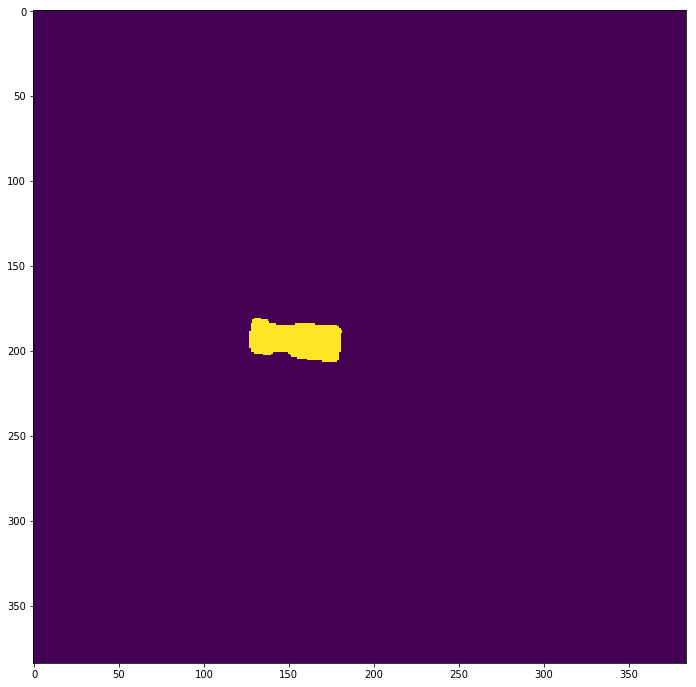

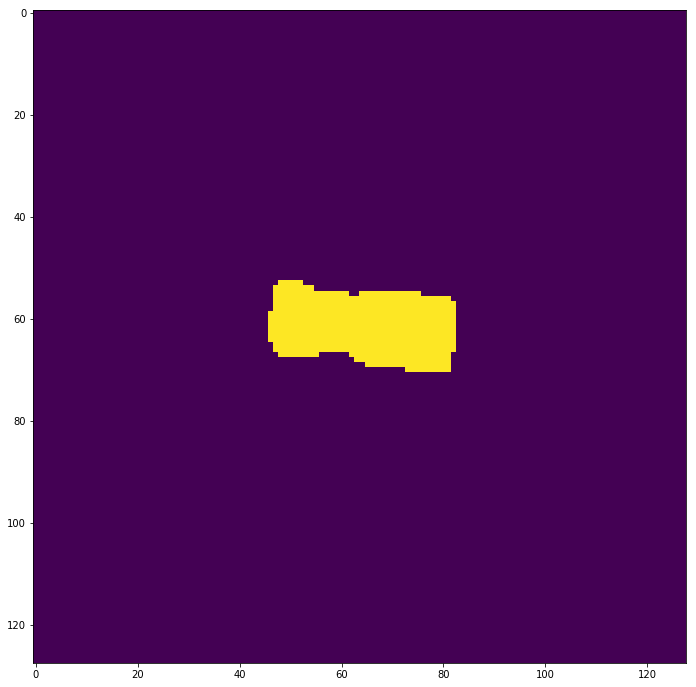

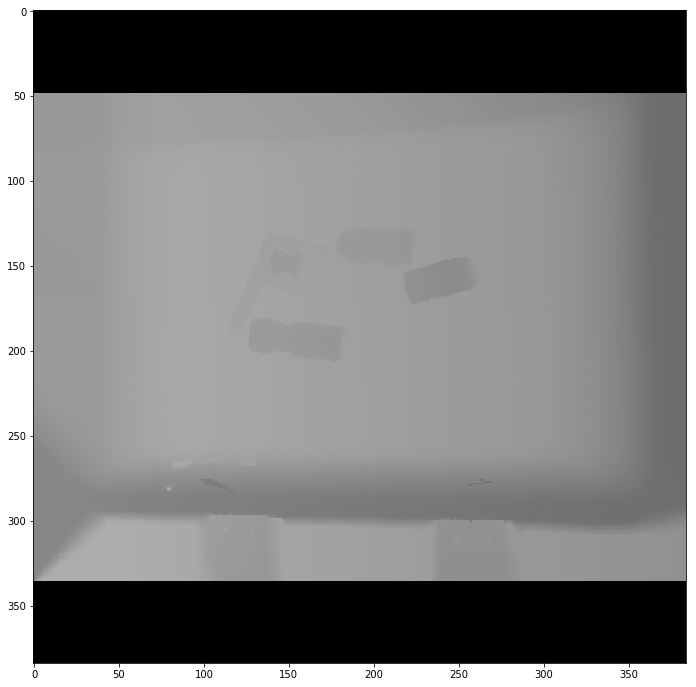

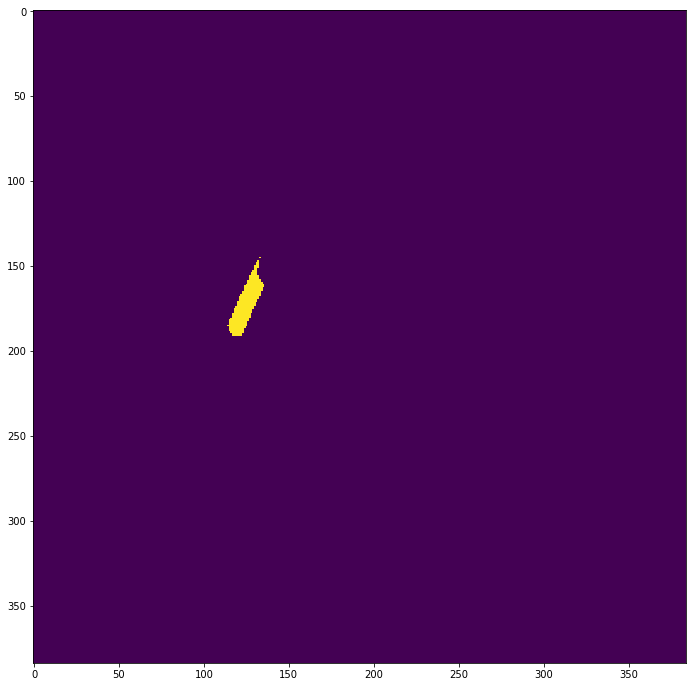

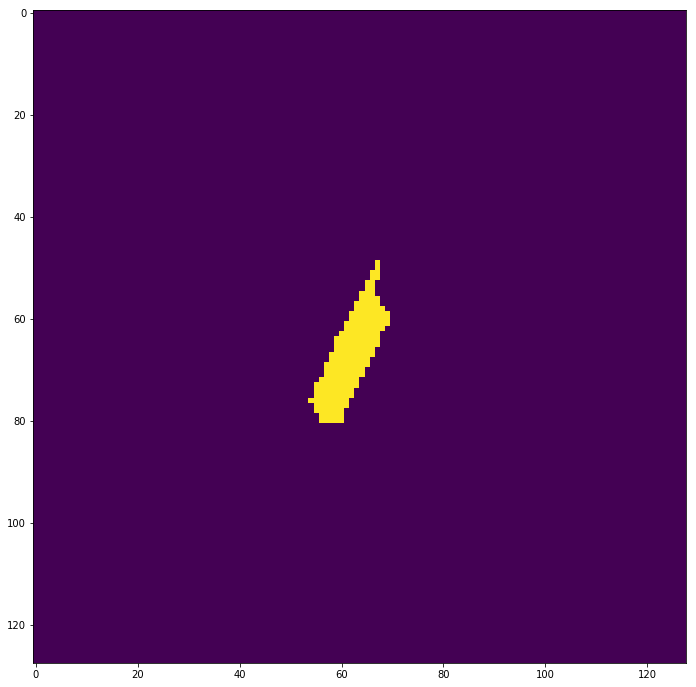

 30%|███       | 9/30 [00:26<01:00,  2.90s/it]

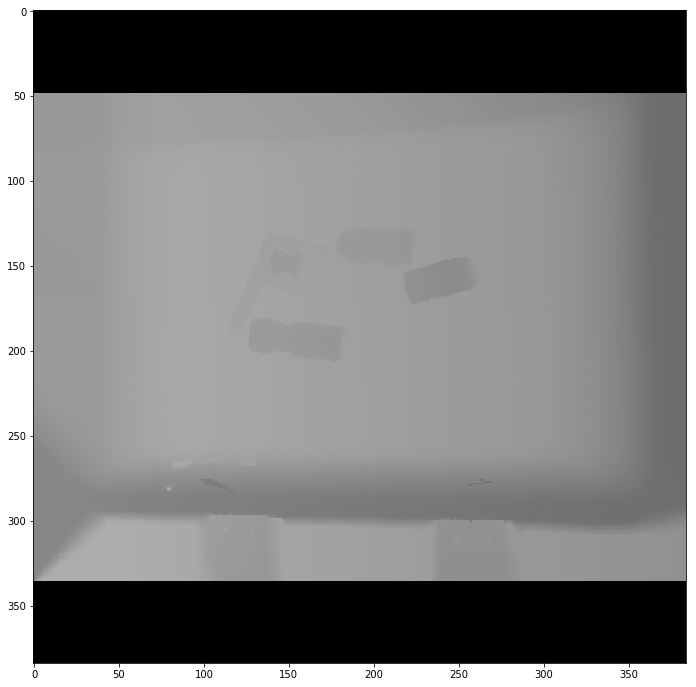

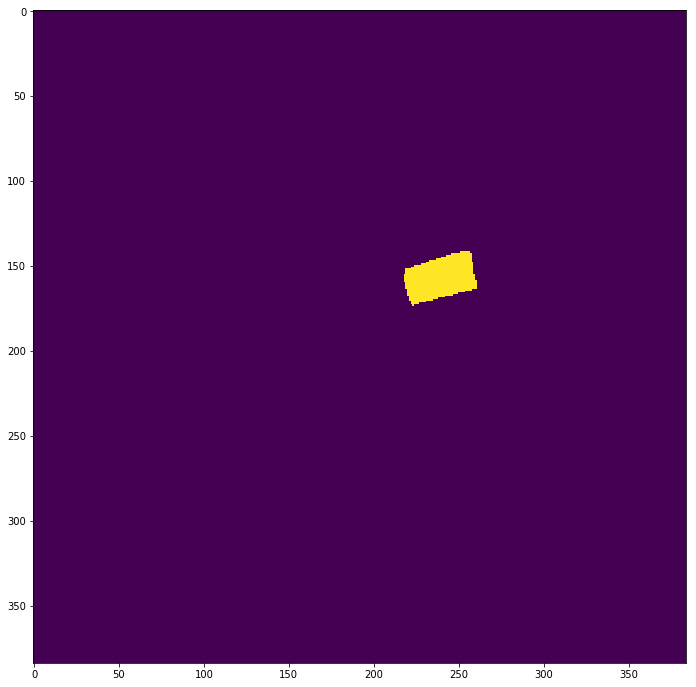

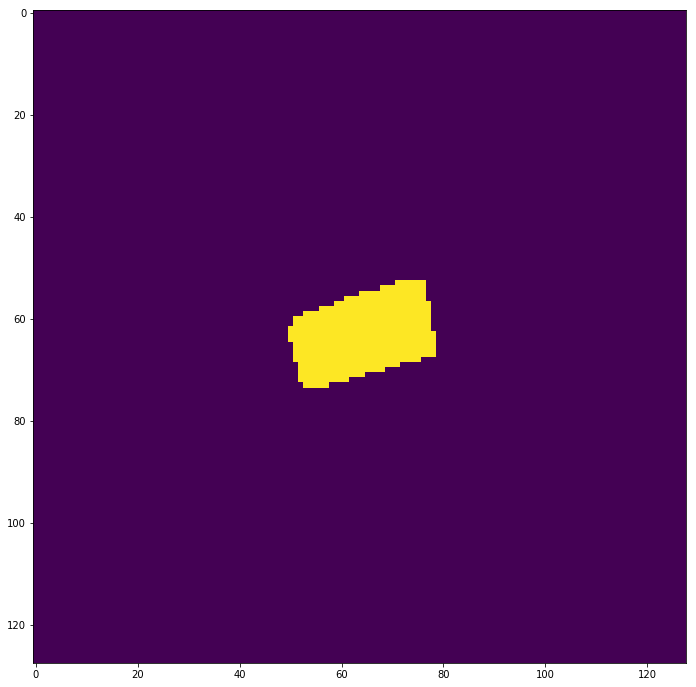

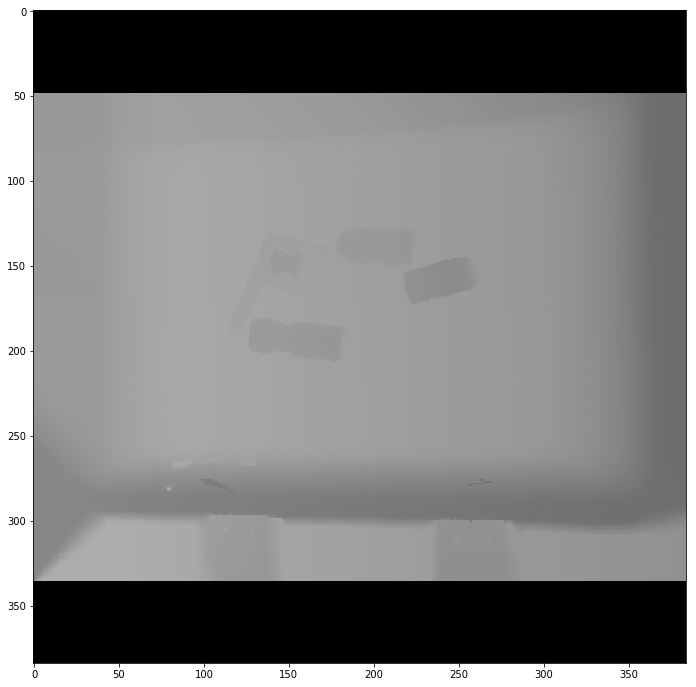

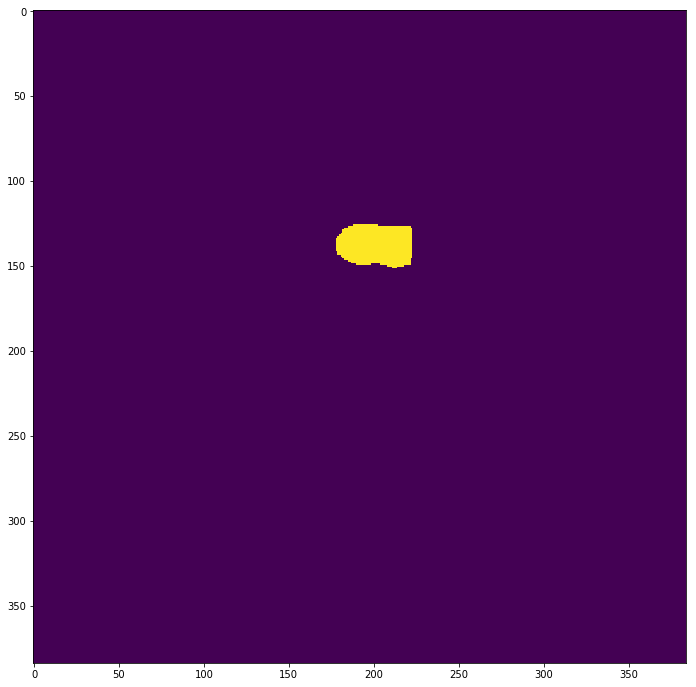

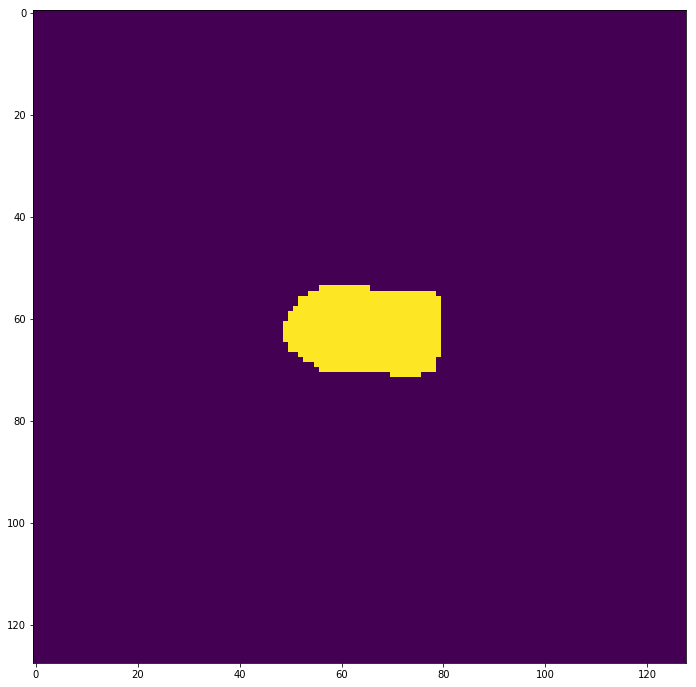

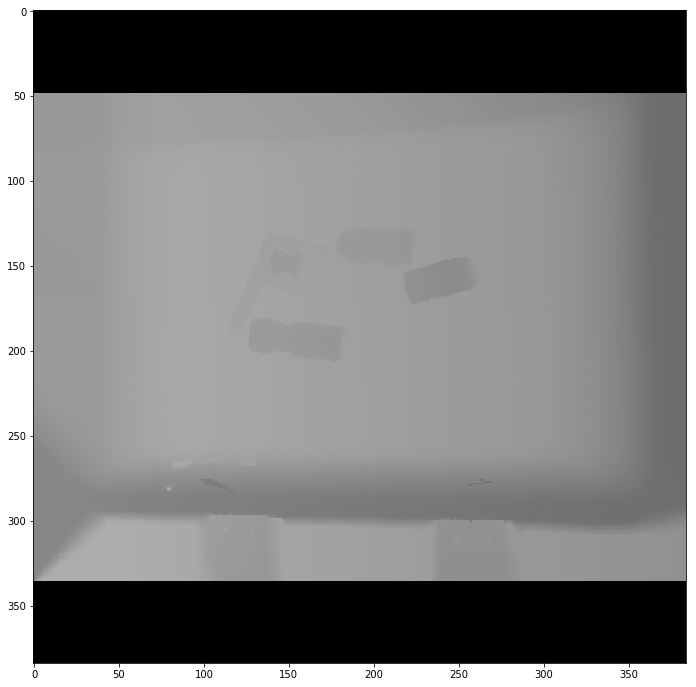

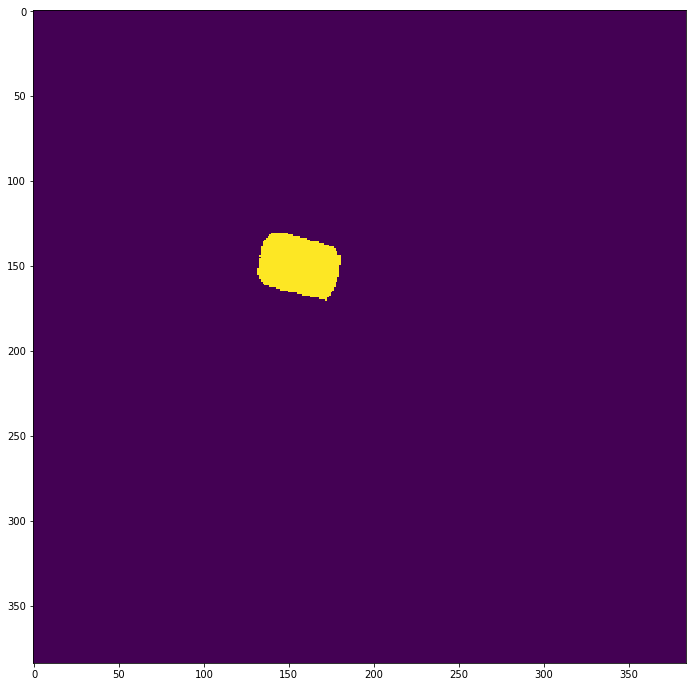

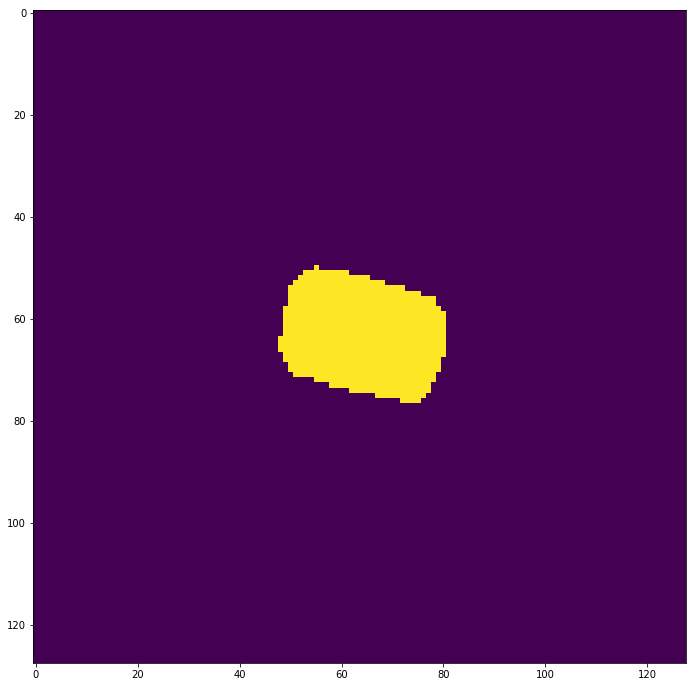

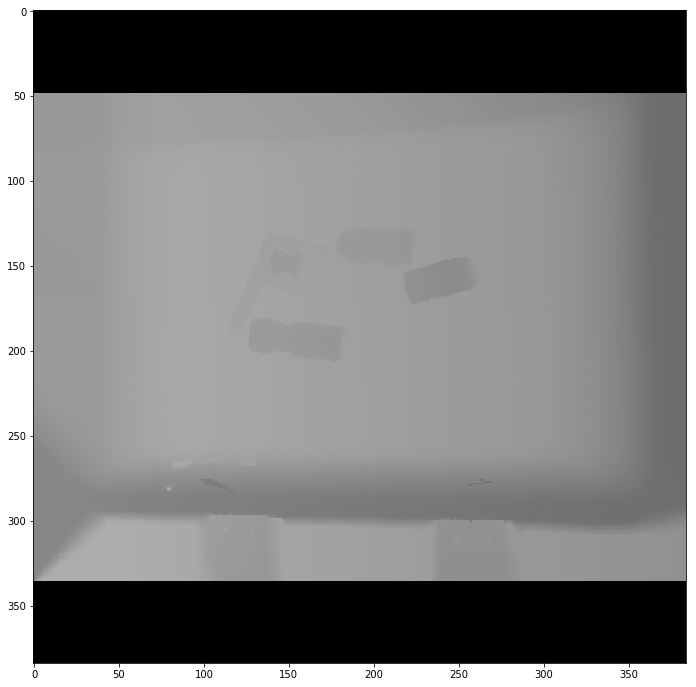

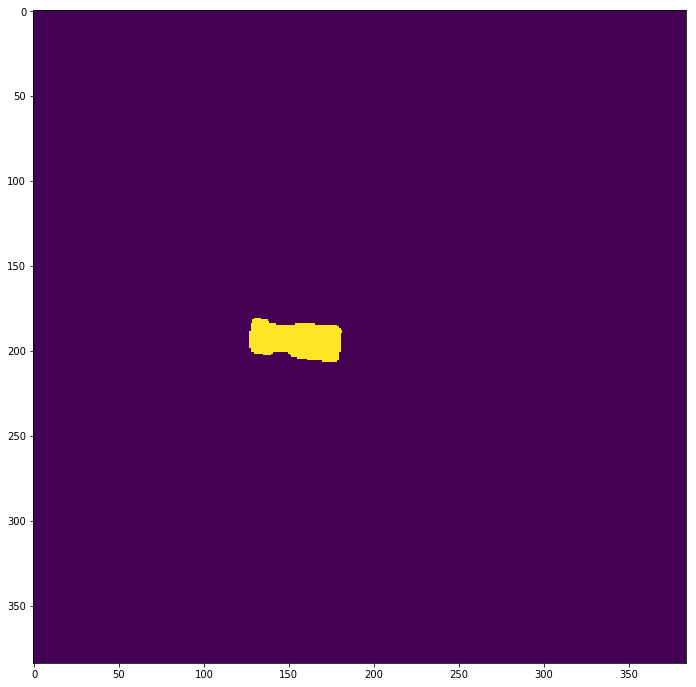

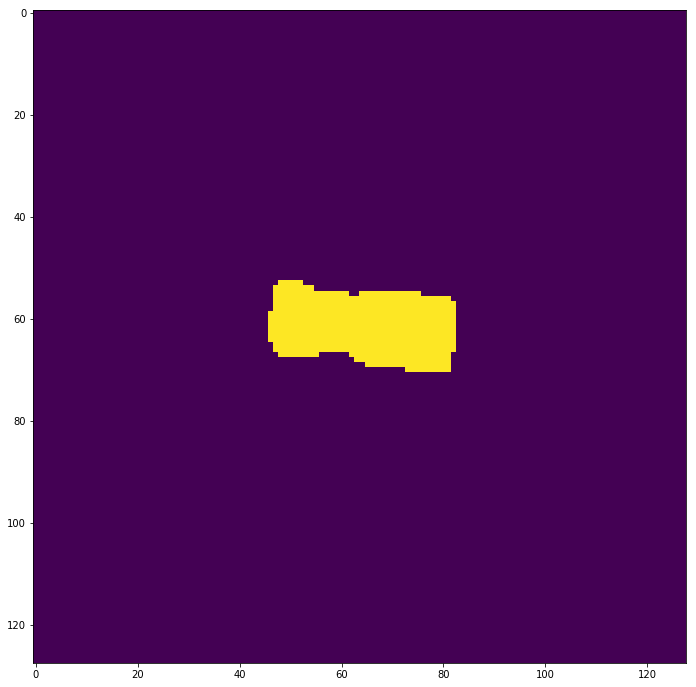

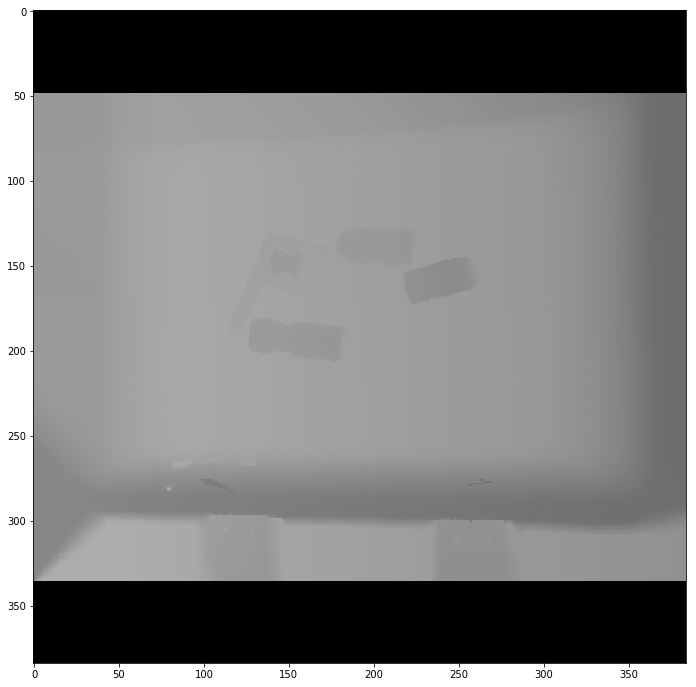

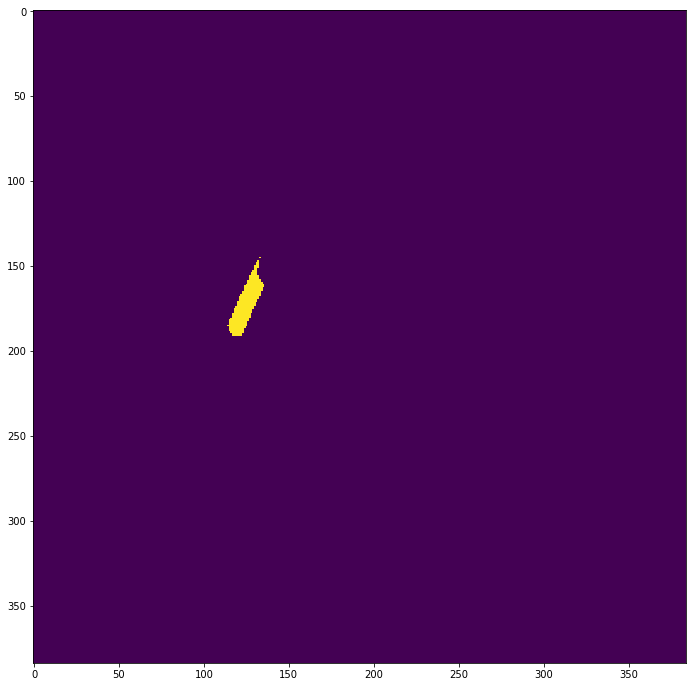

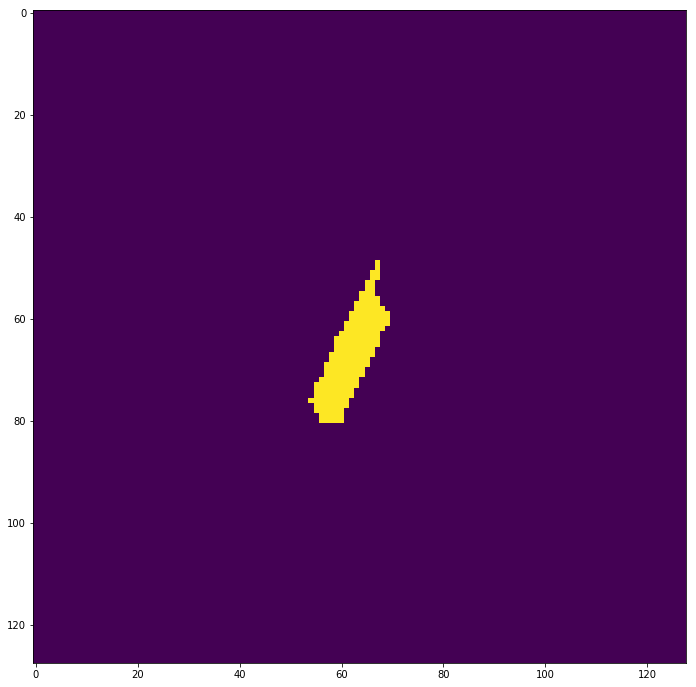

 33%|███▎      | 10/30 [00:28<00:57,  2.89s/it]

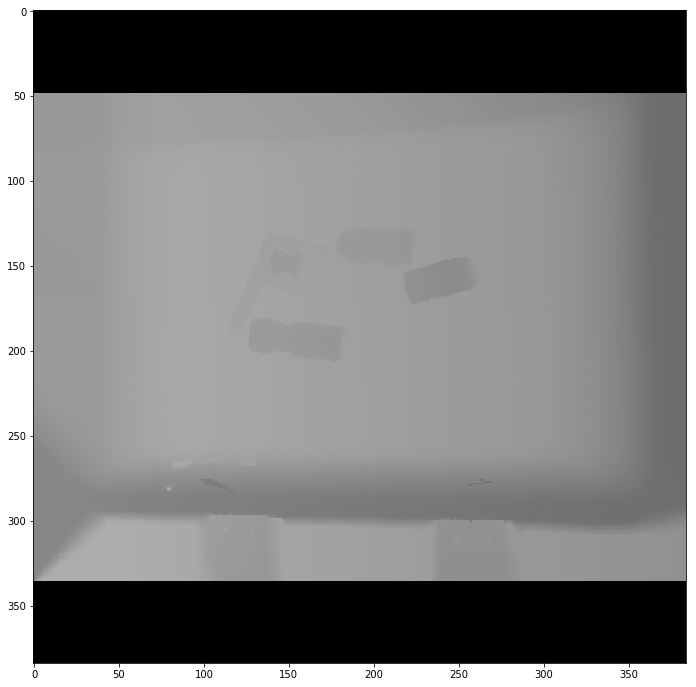

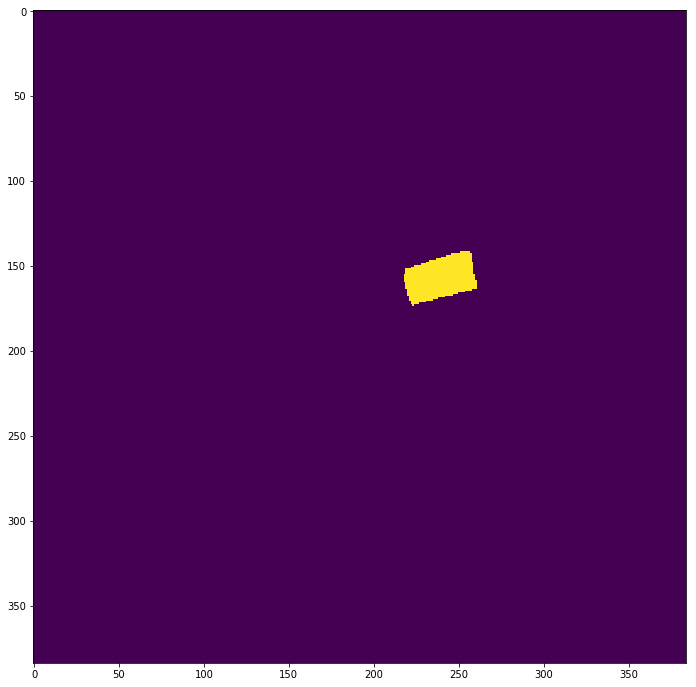

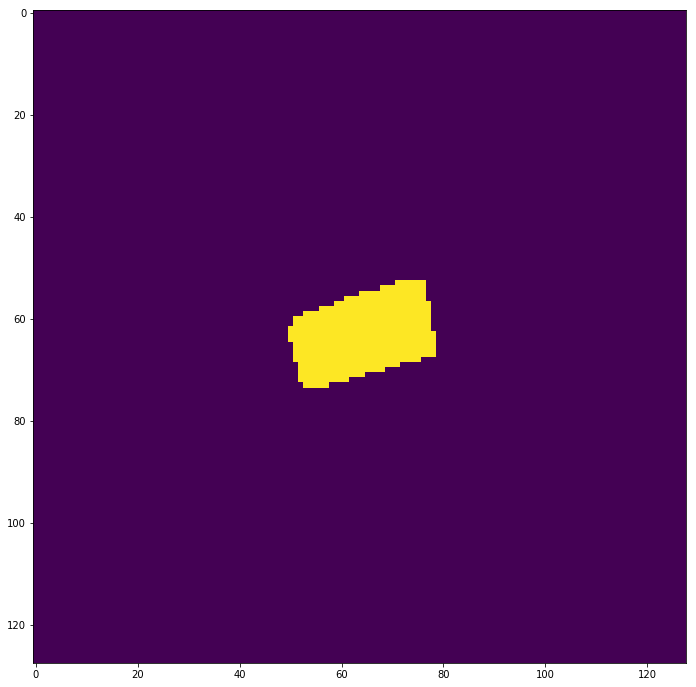

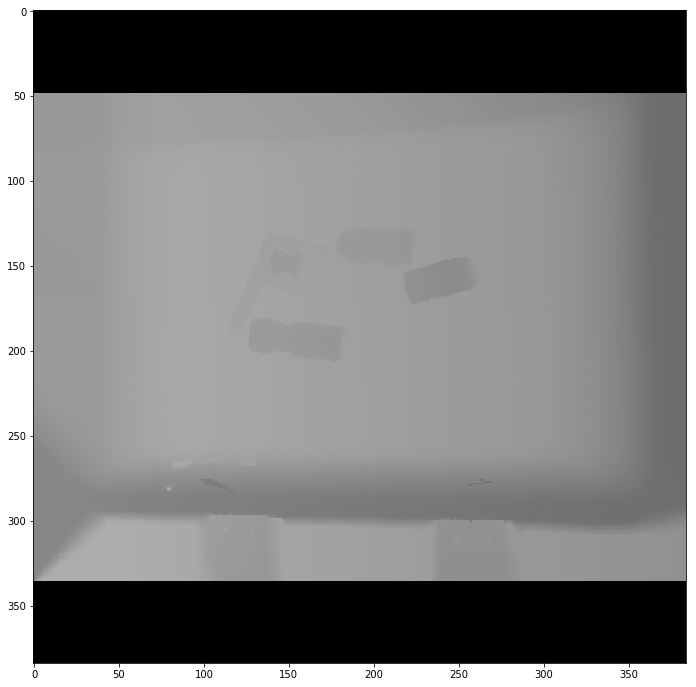

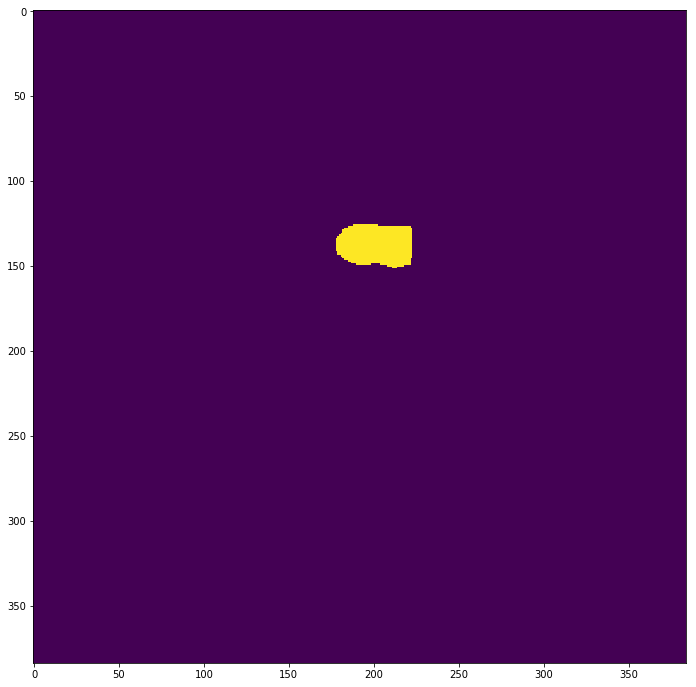

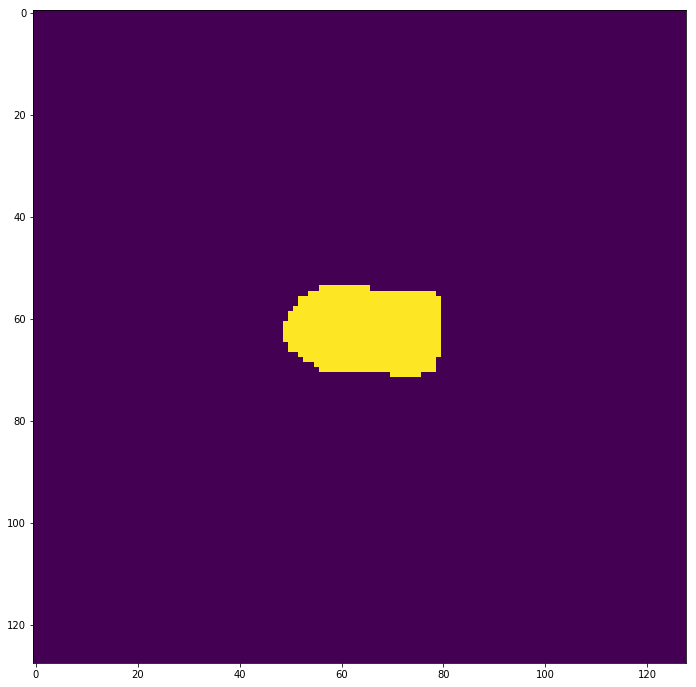

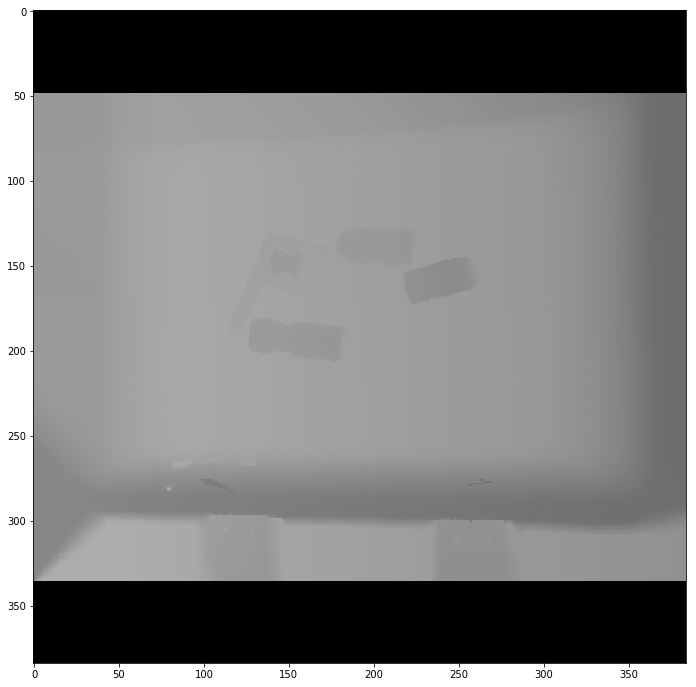

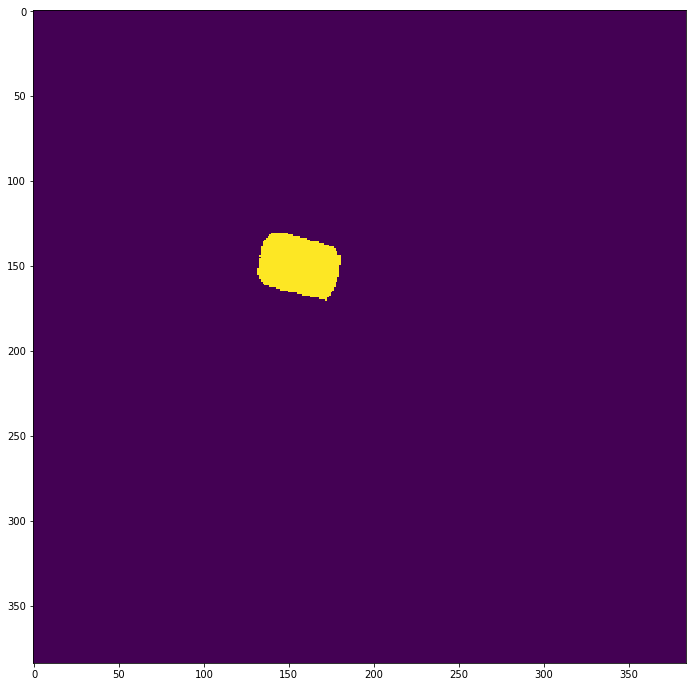

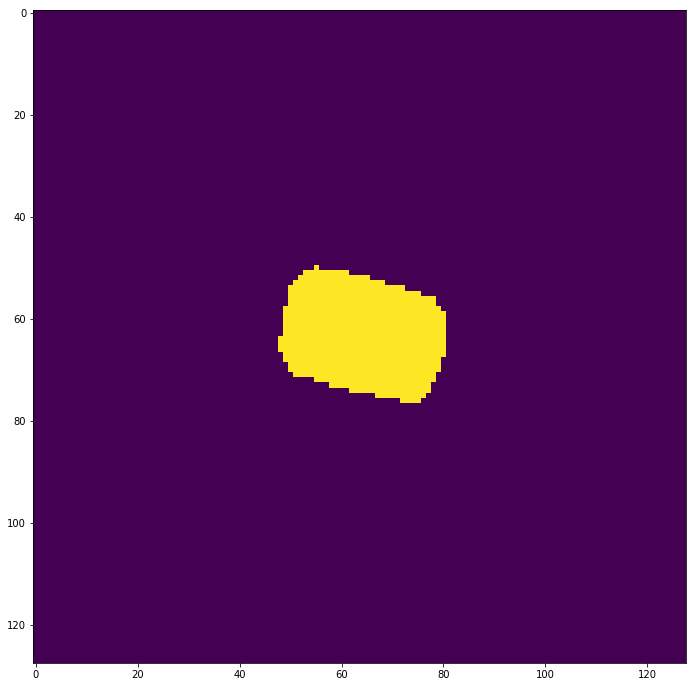

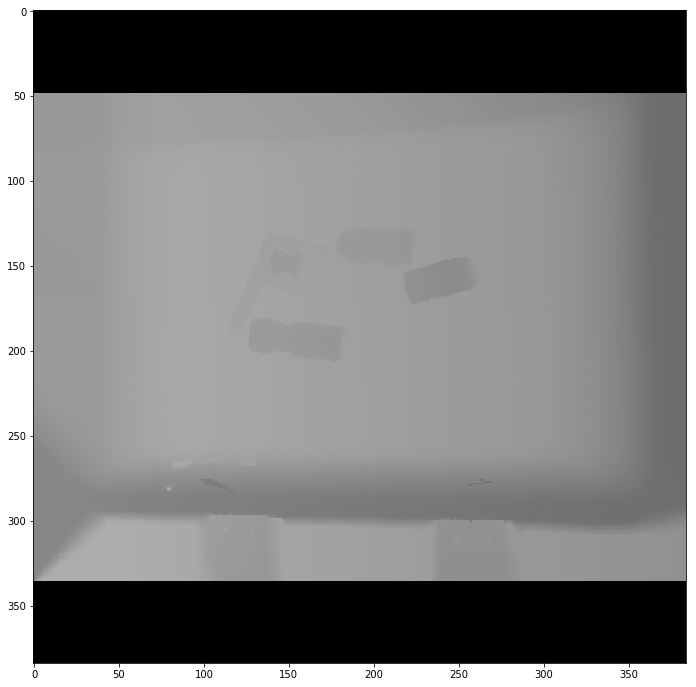

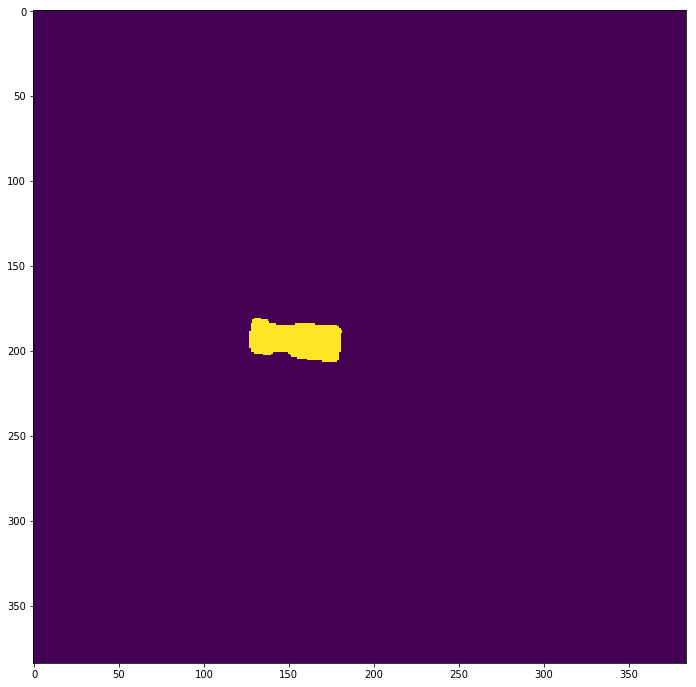

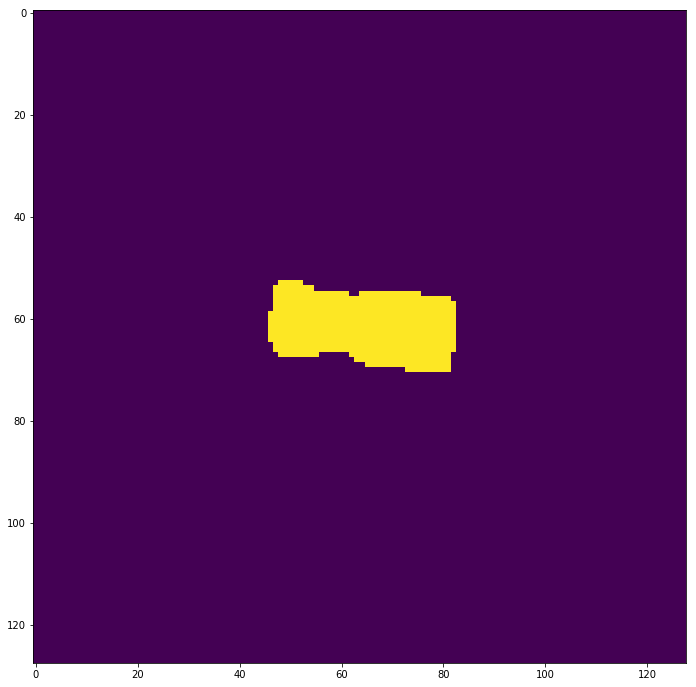

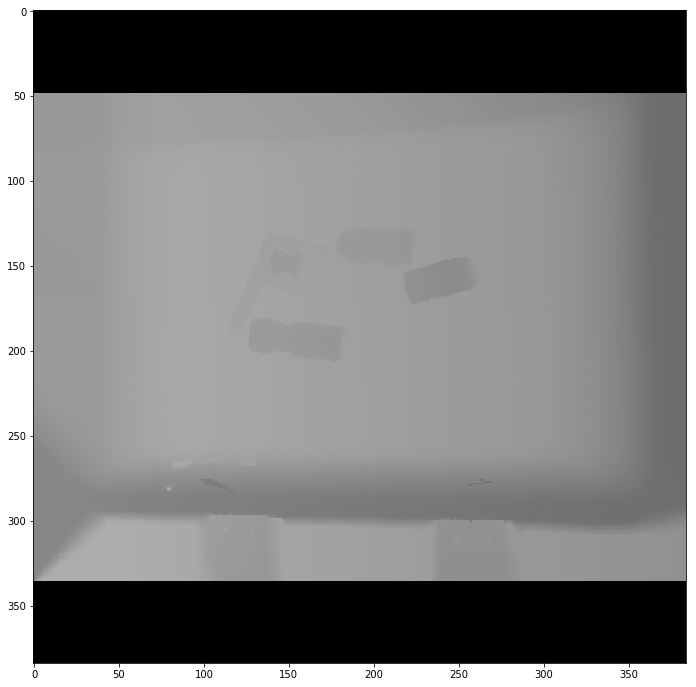

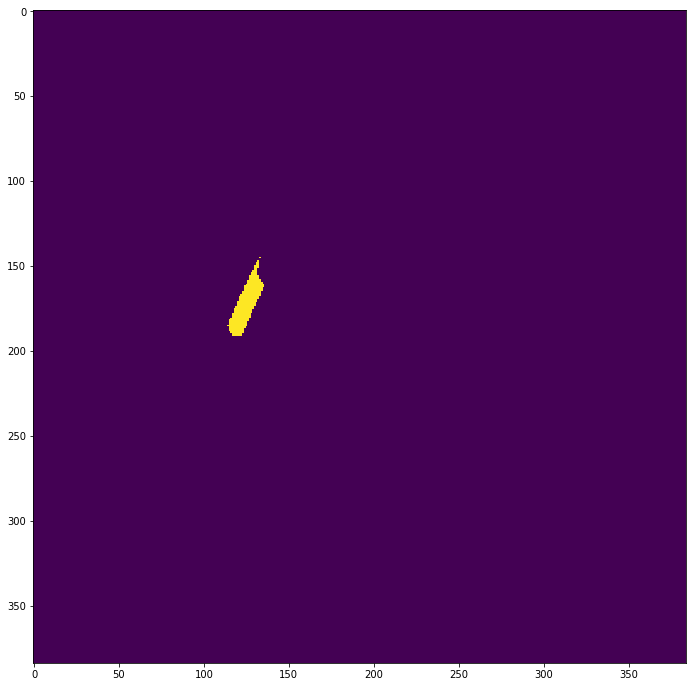

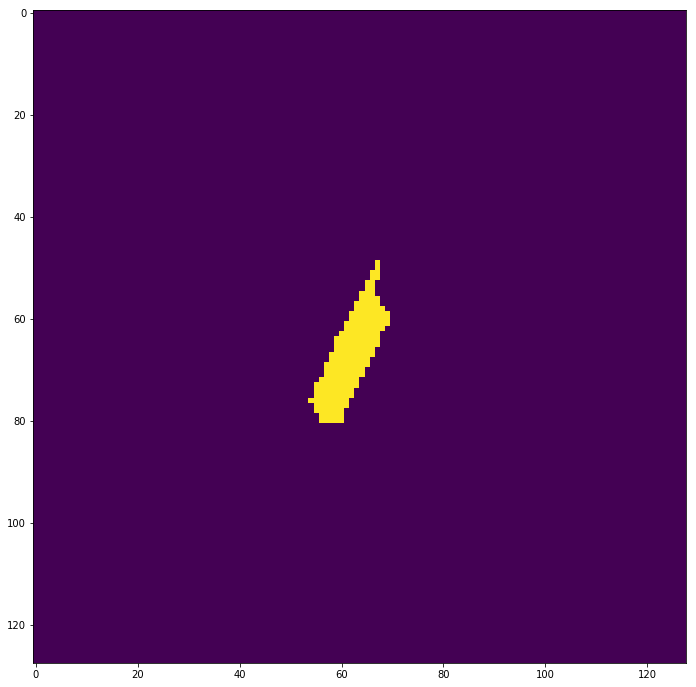

 37%|███▋      | 11/30 [00:31<00:54,  2.87s/it]

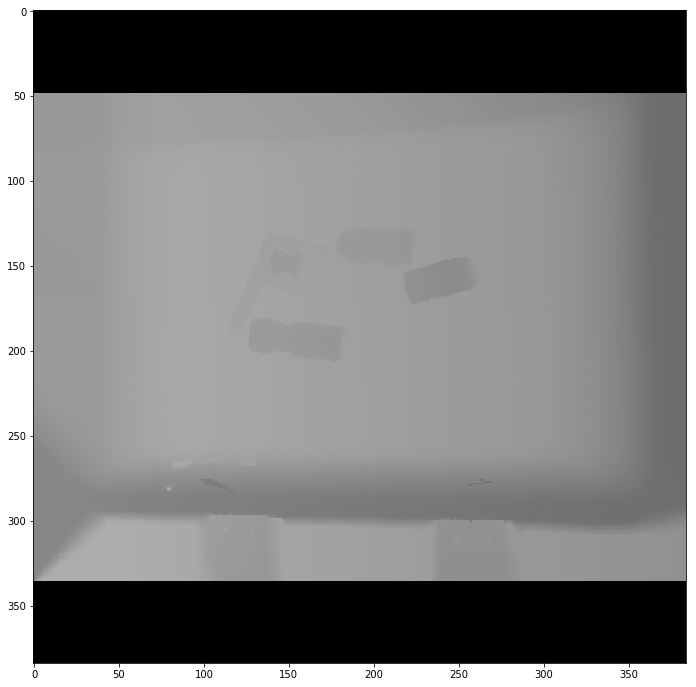

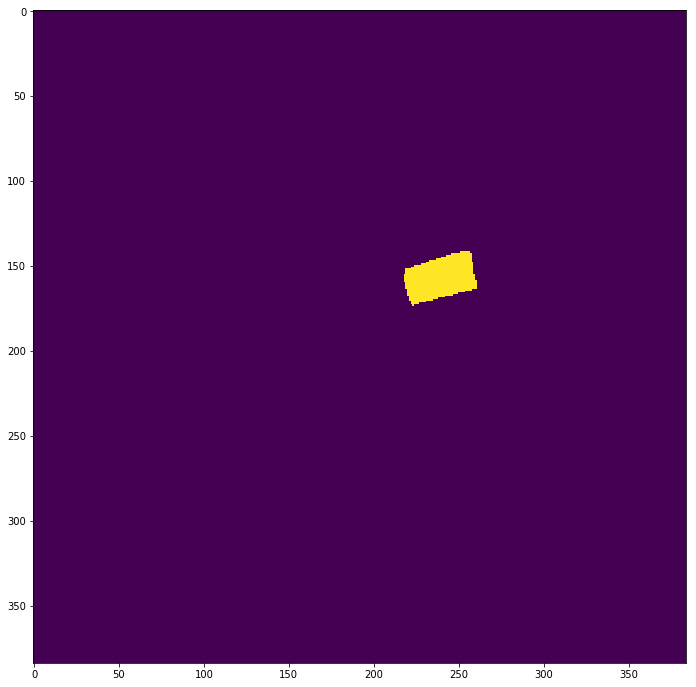

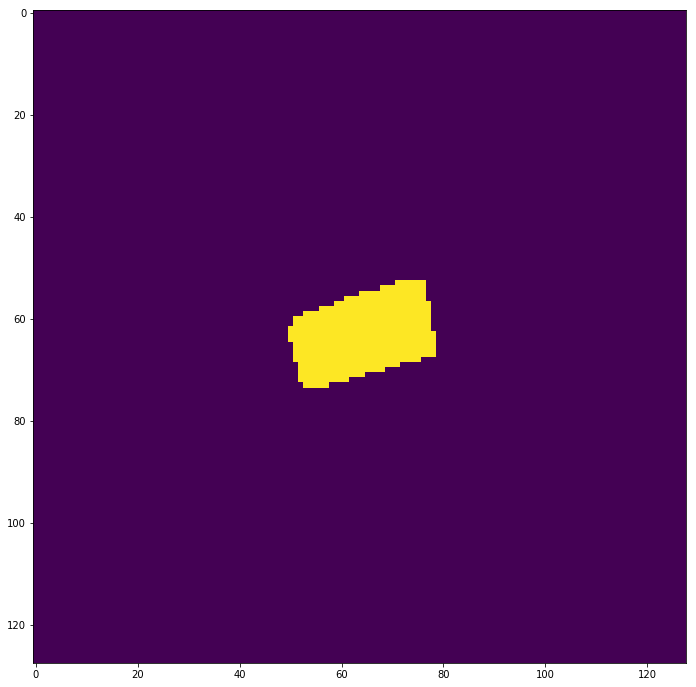

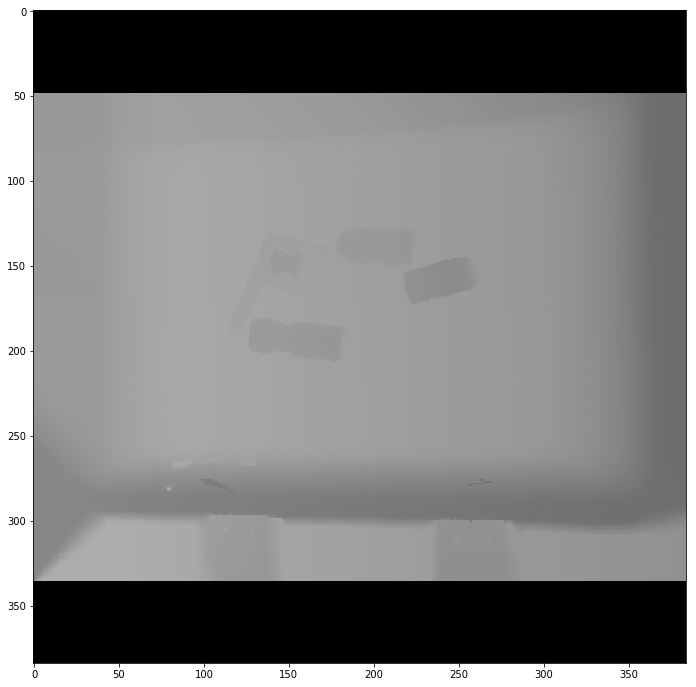

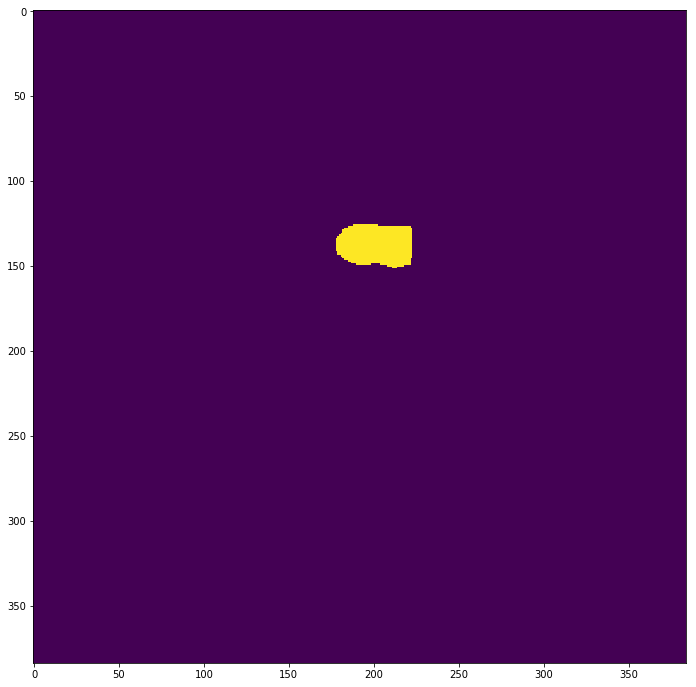

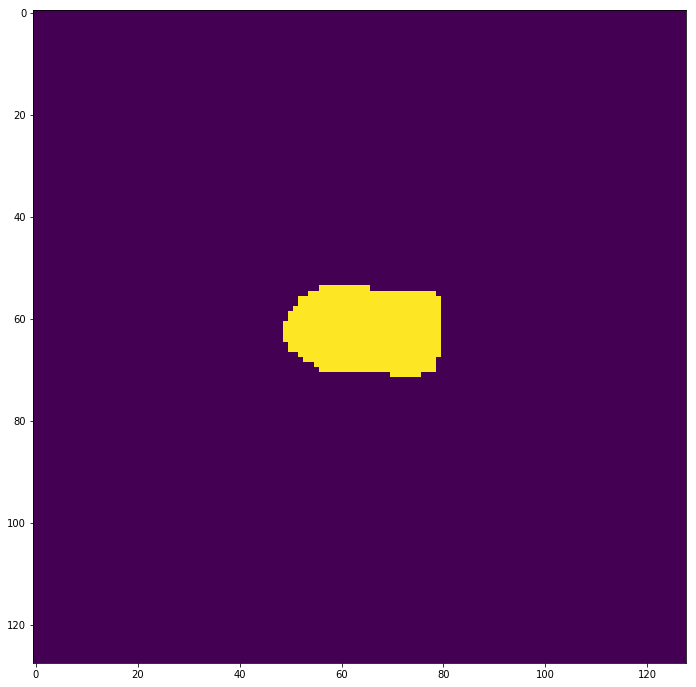

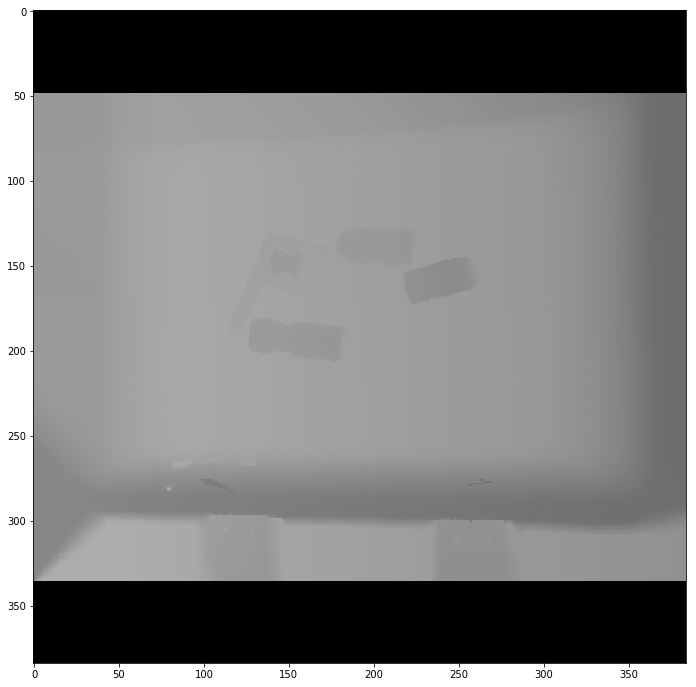

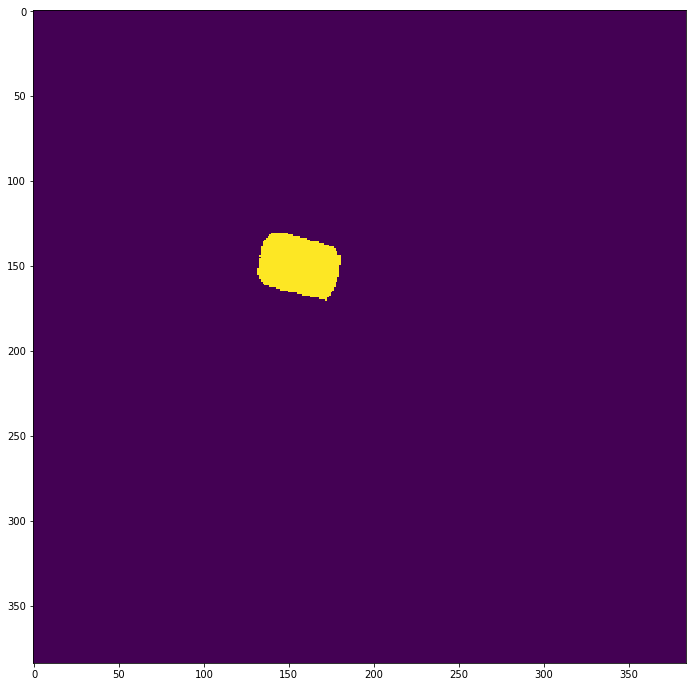

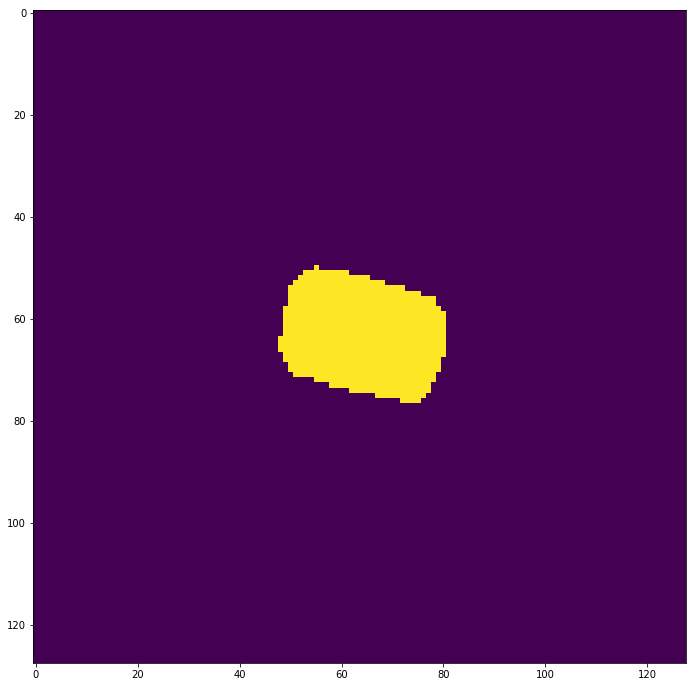

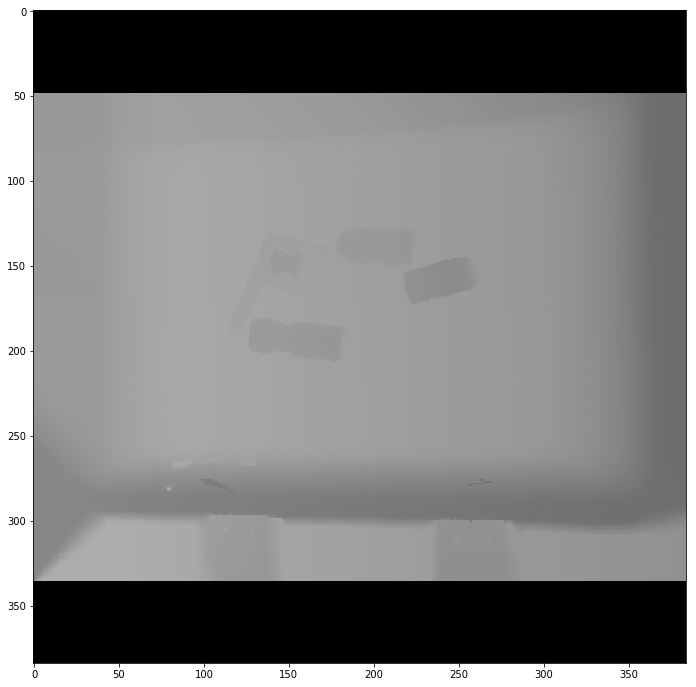

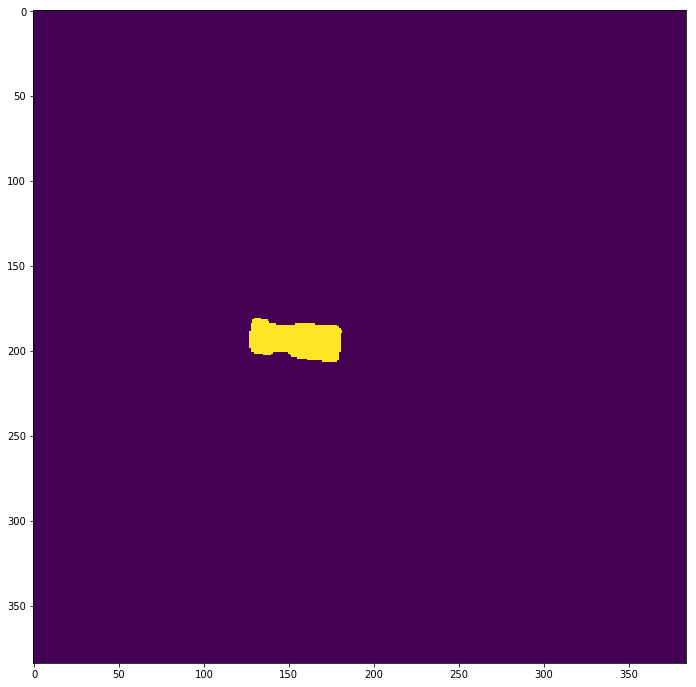

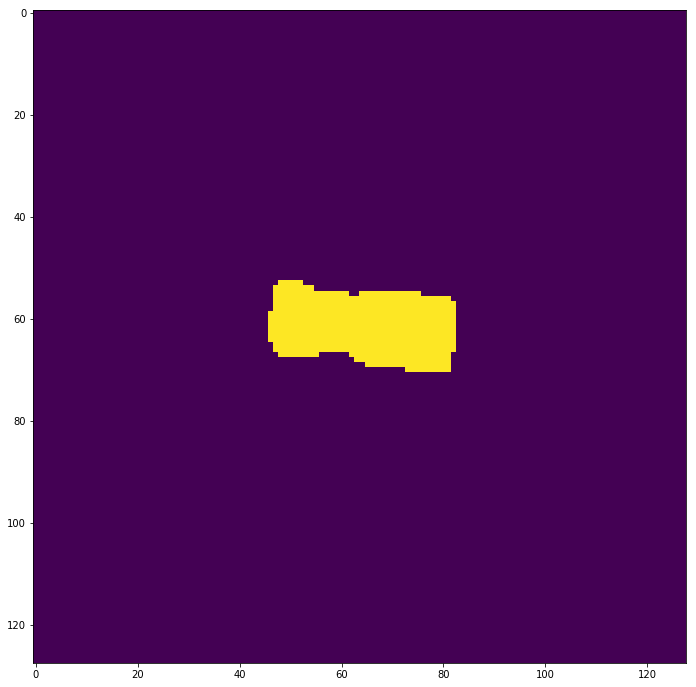

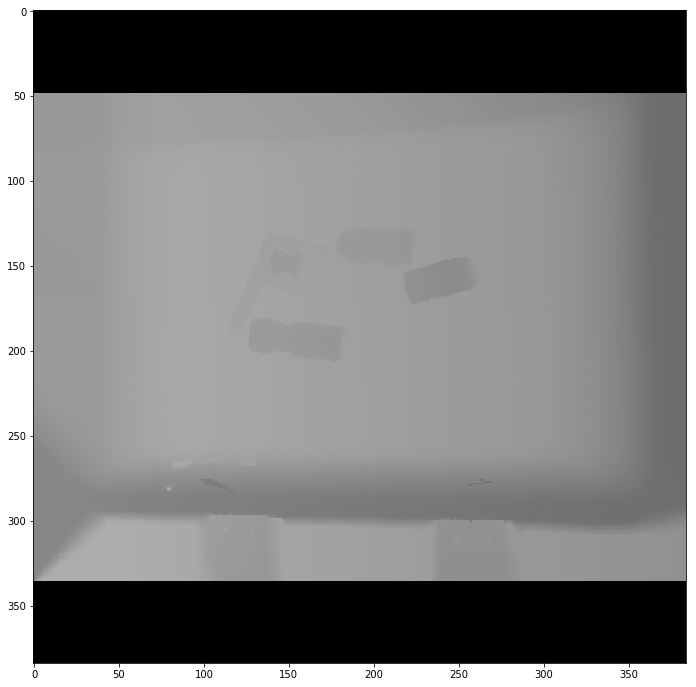

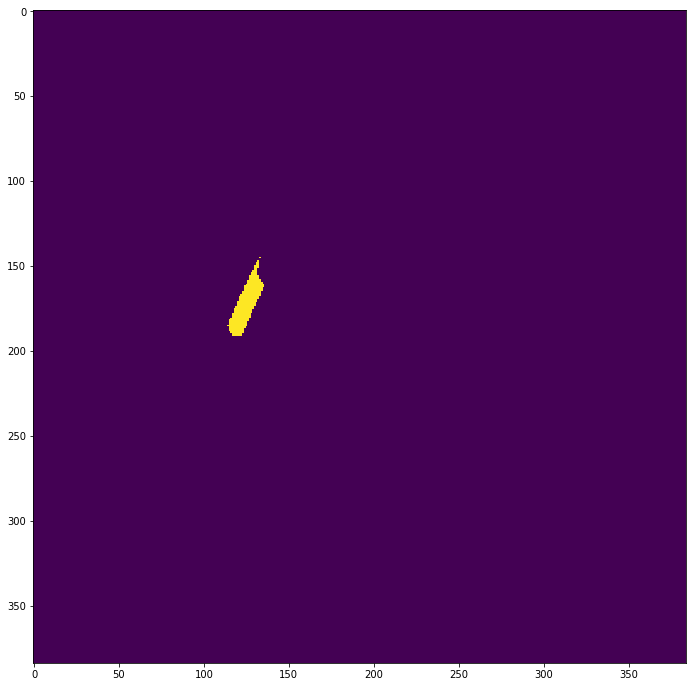

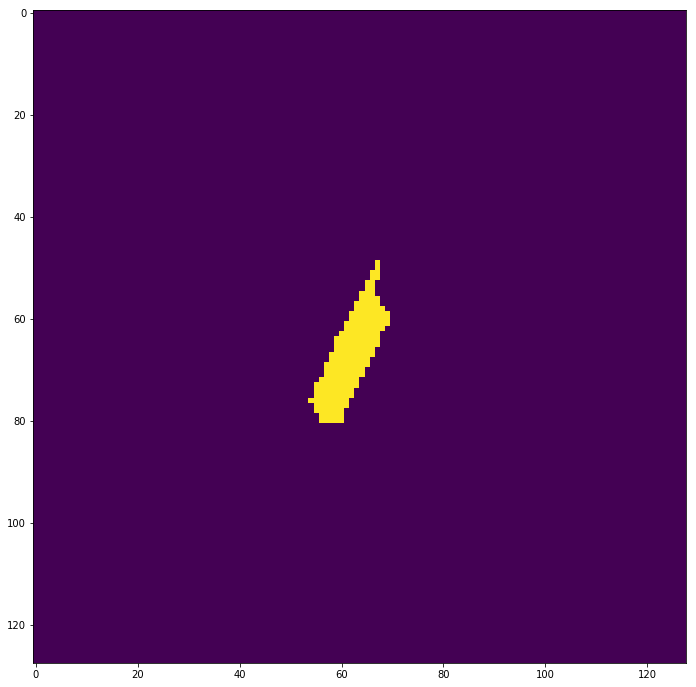

 40%|████      | 12/30 [00:34<00:51,  2.87s/it]

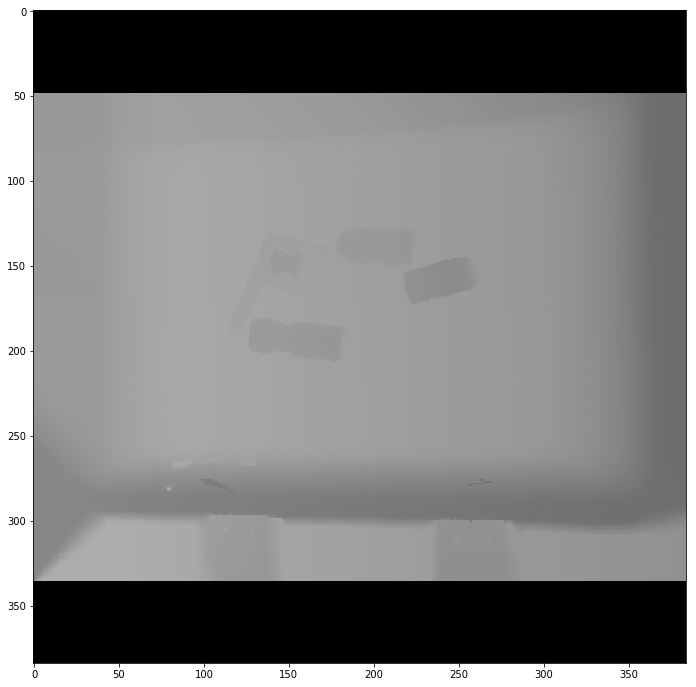

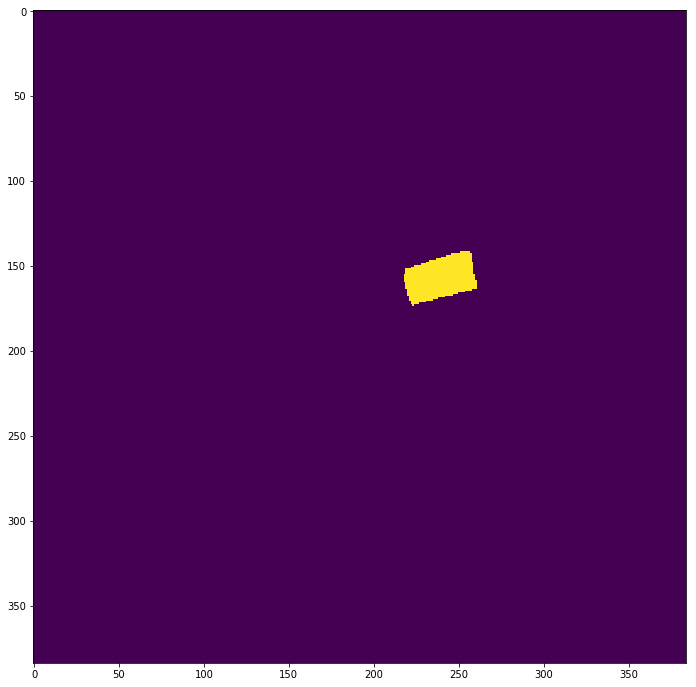

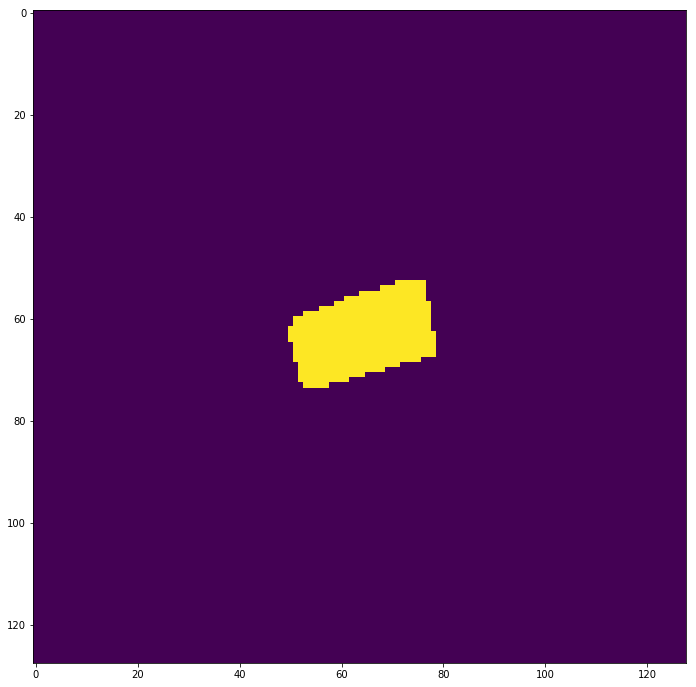

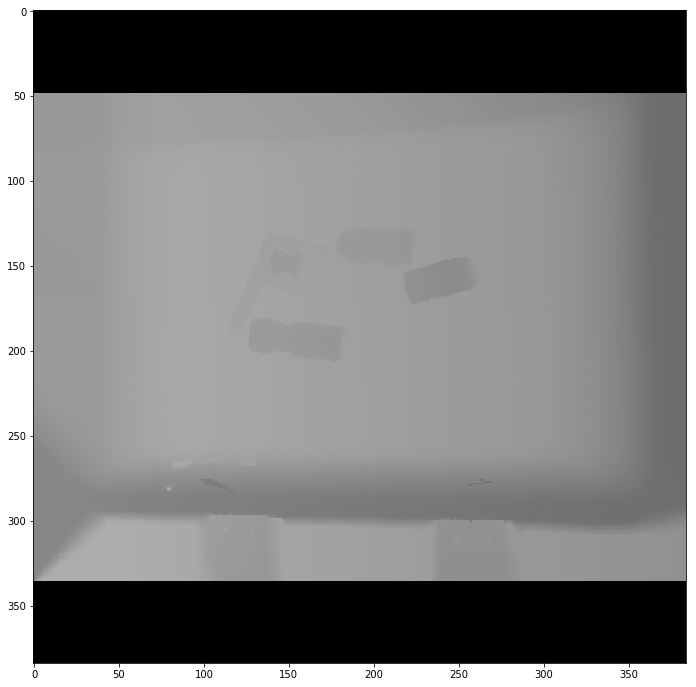

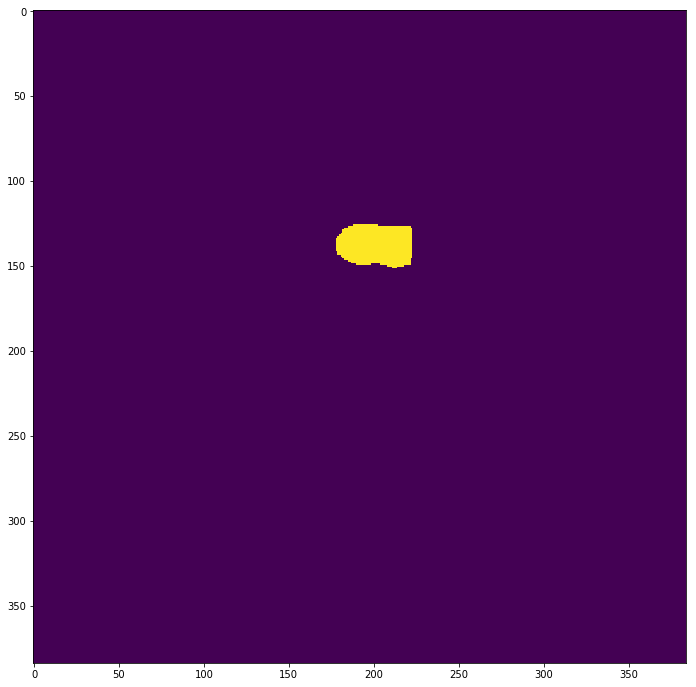

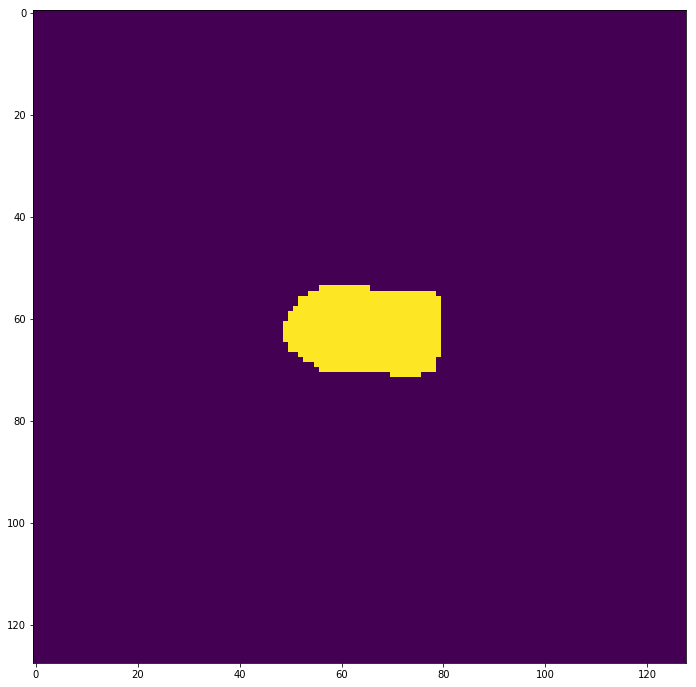

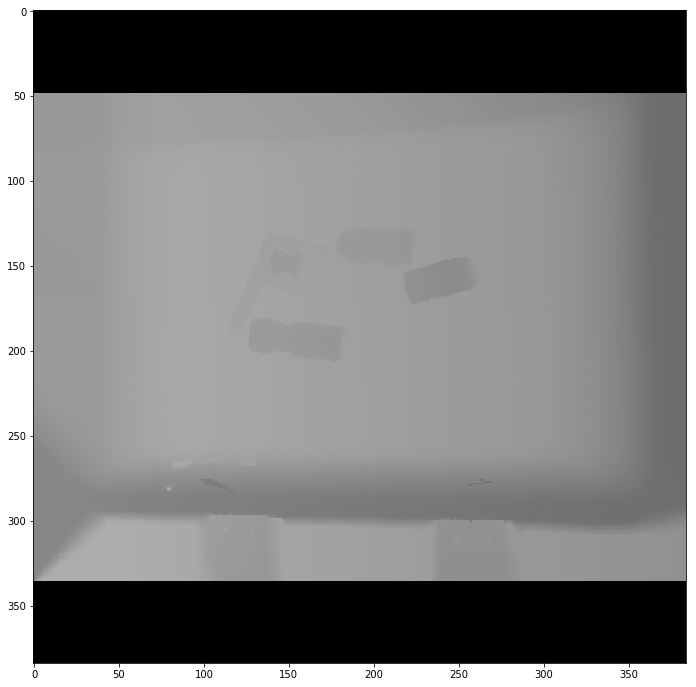

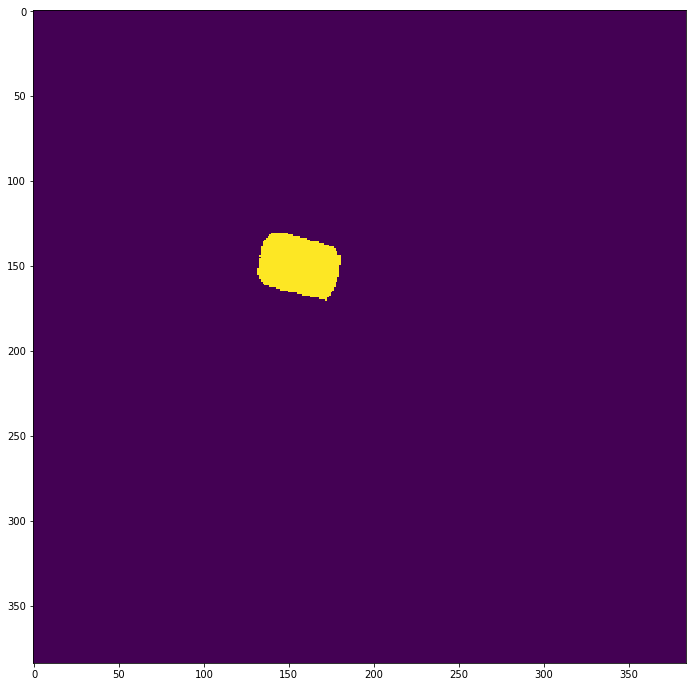

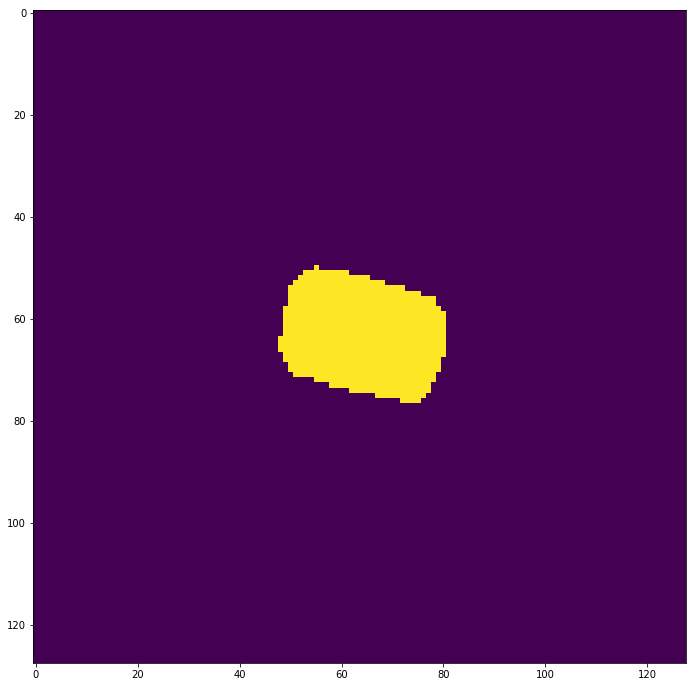

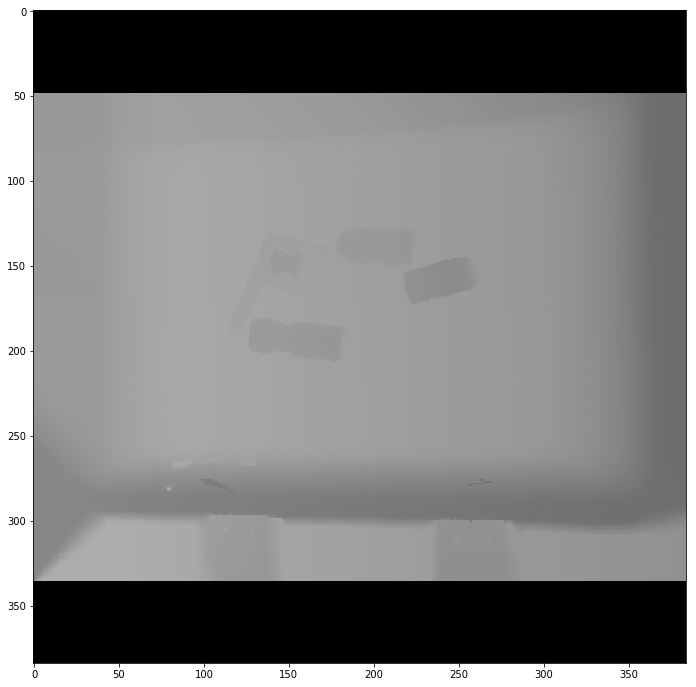

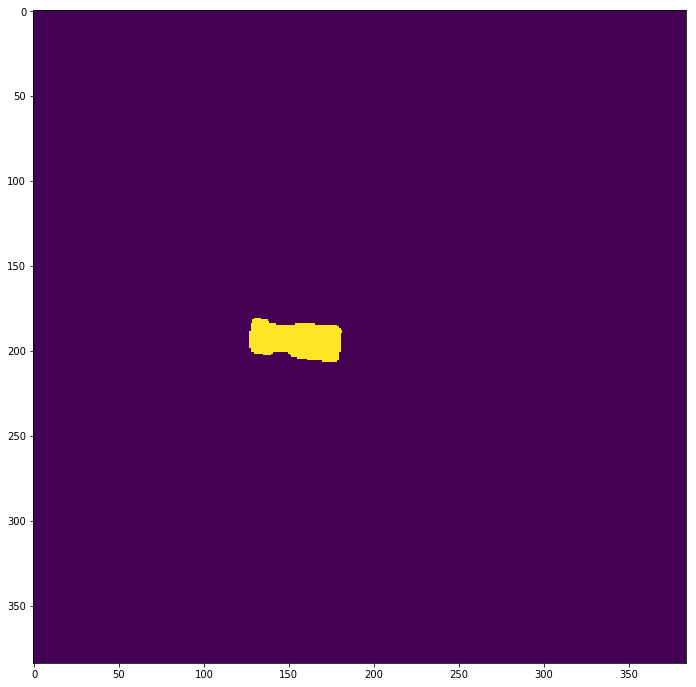

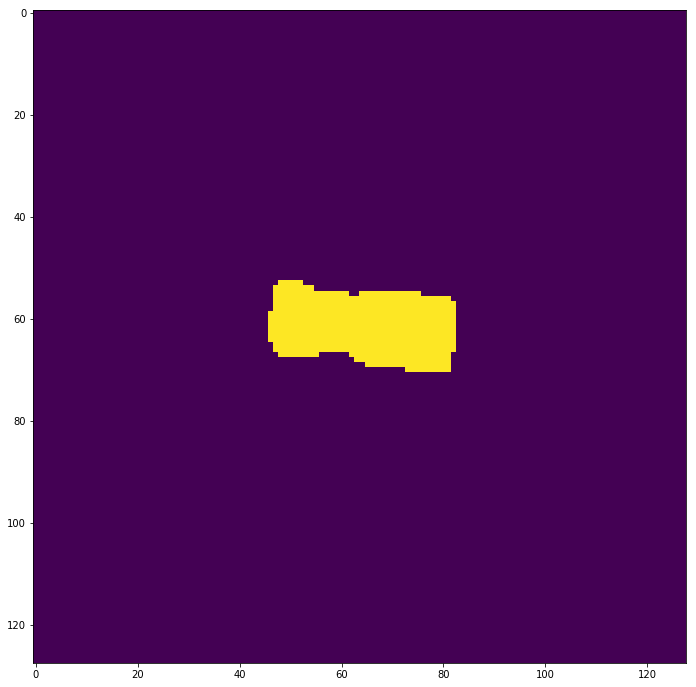

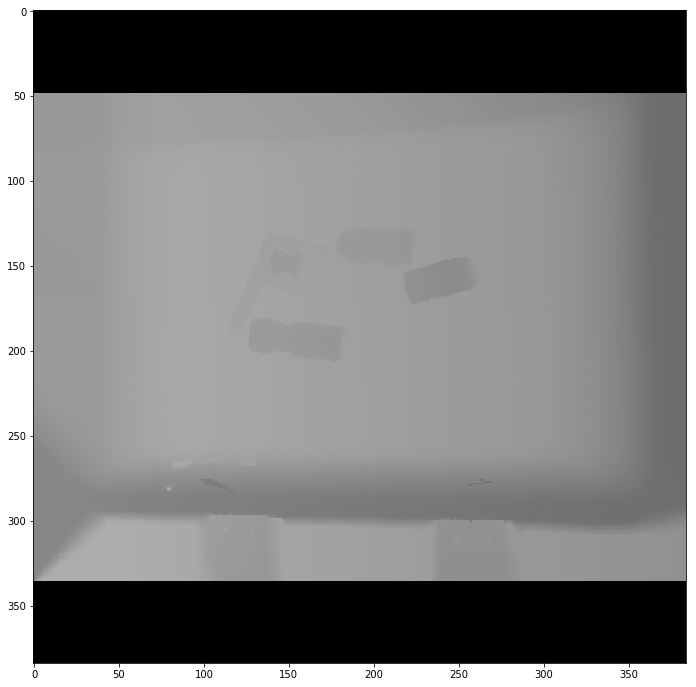

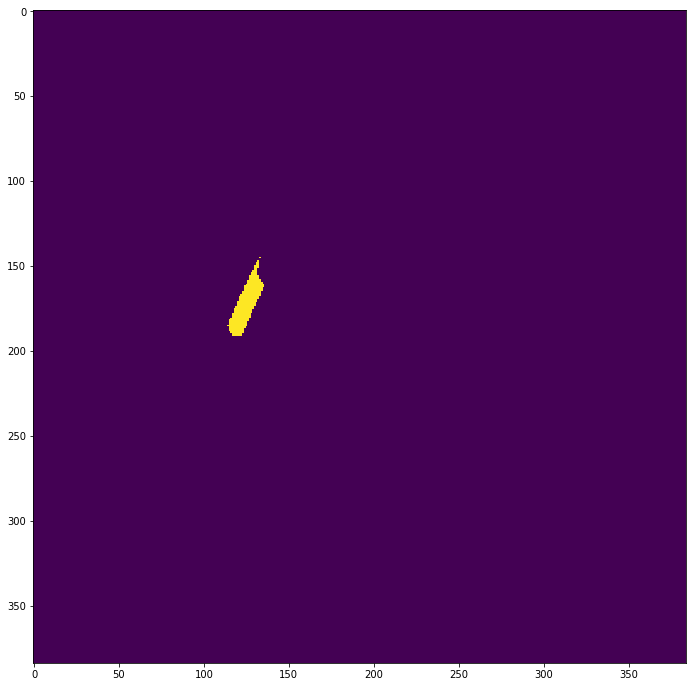

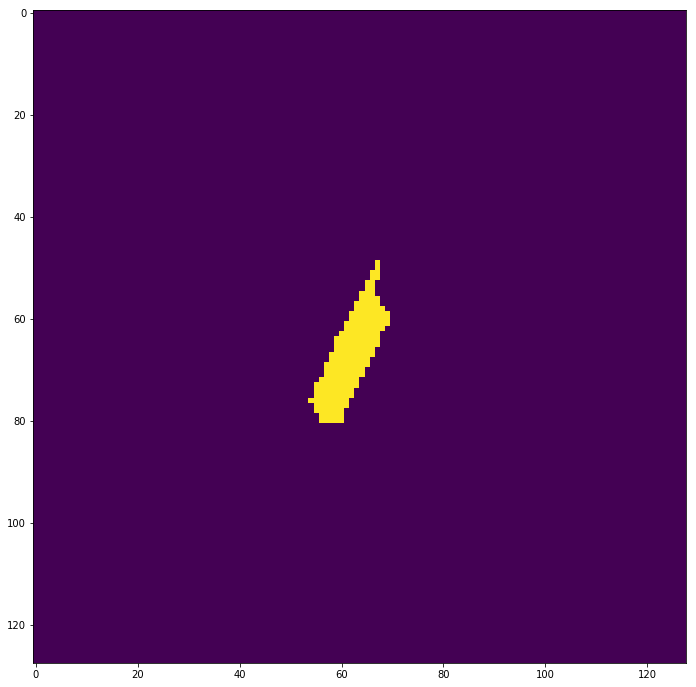

 43%|████▎     | 13/30 [00:37<00:48,  2.87s/it]

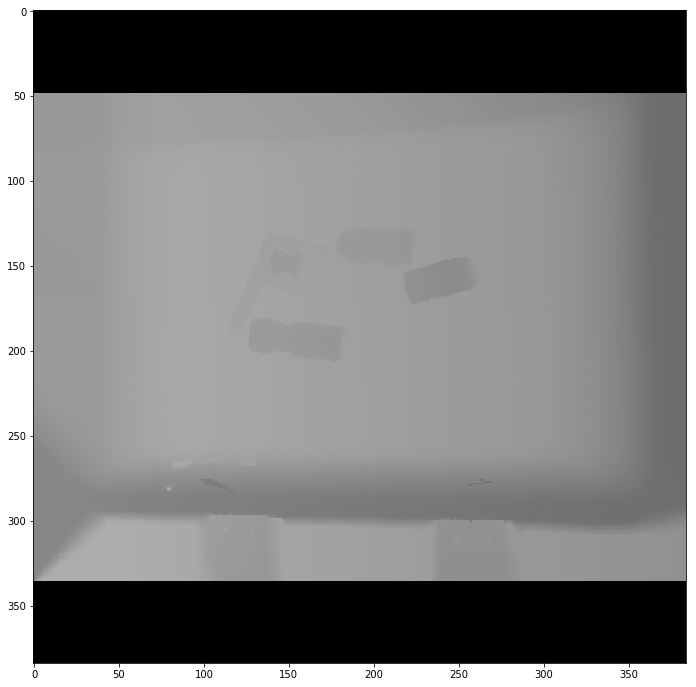

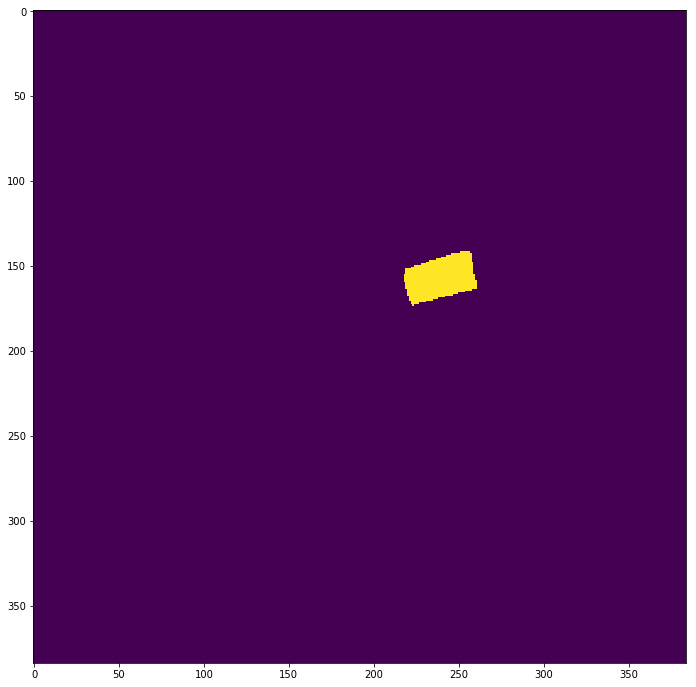

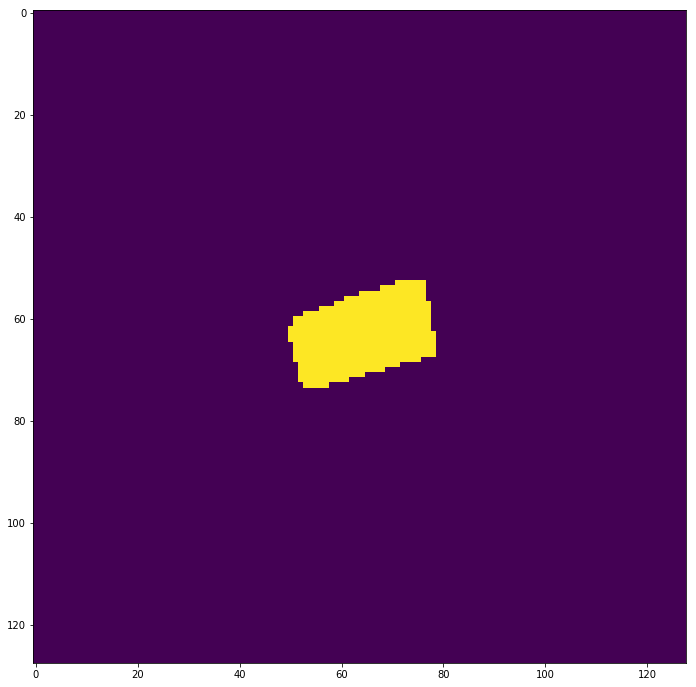

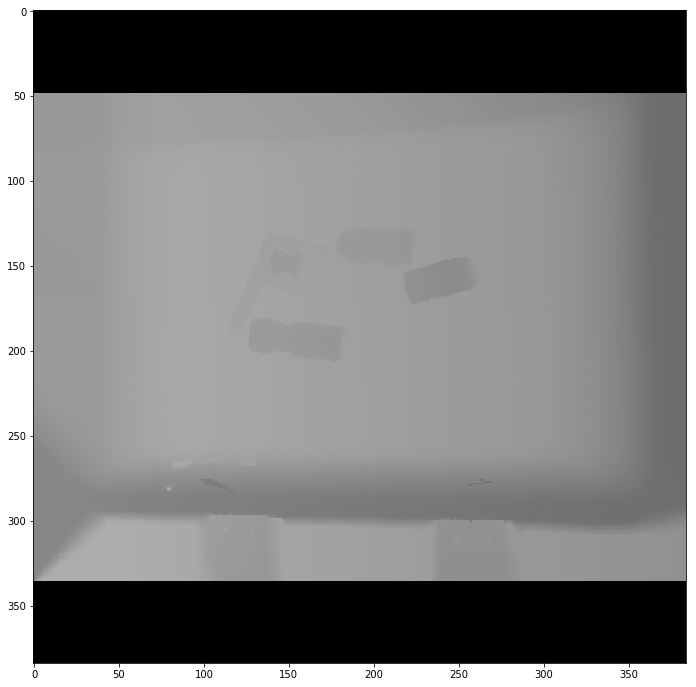

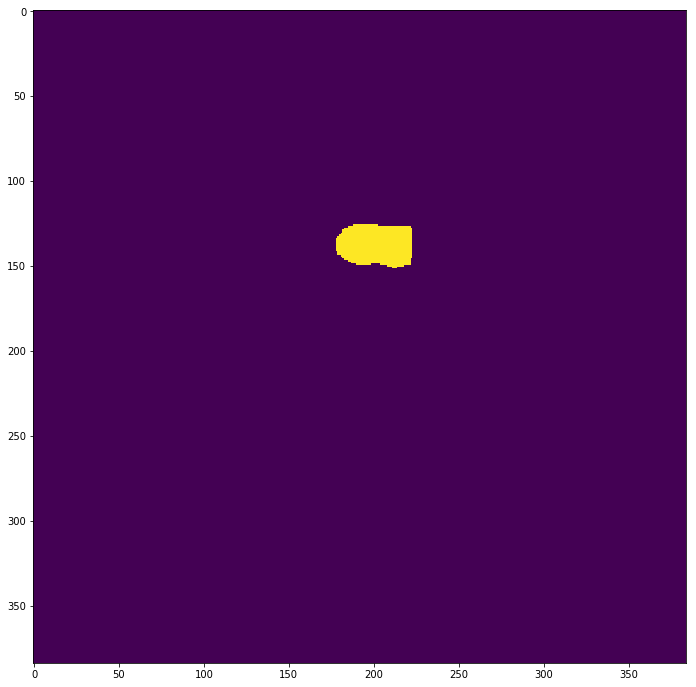

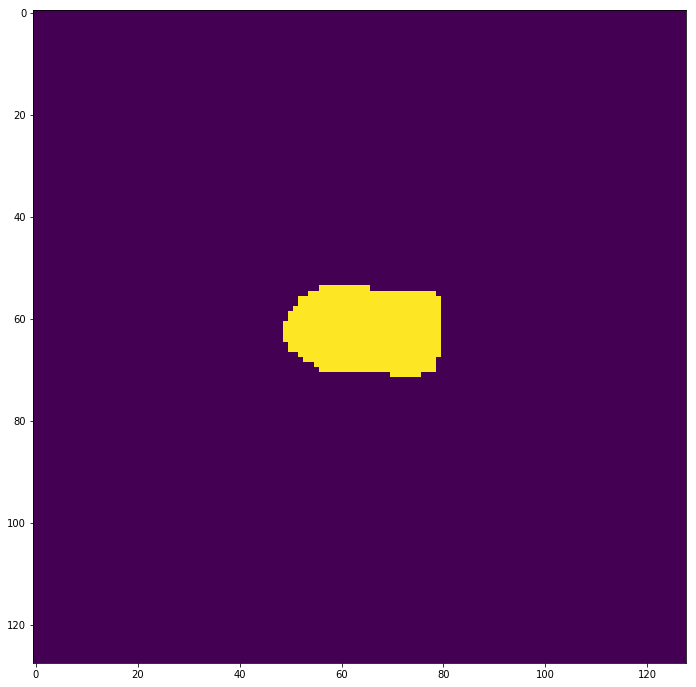

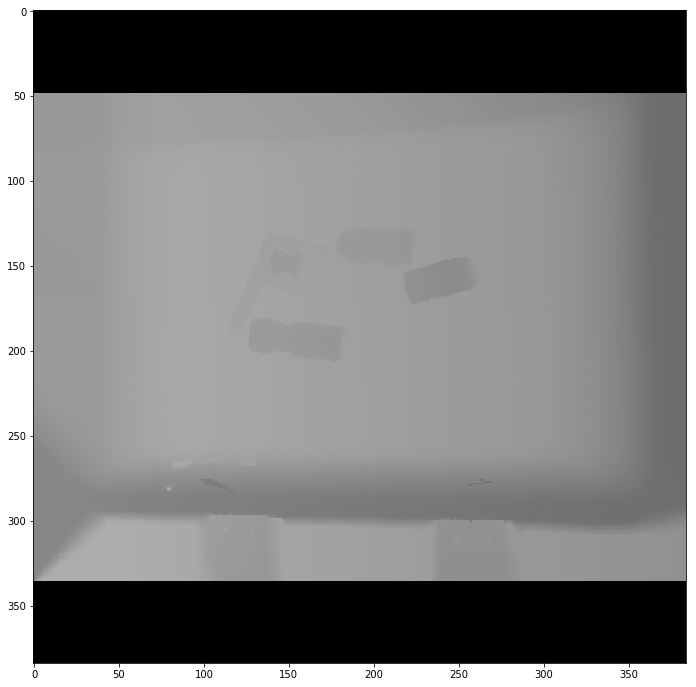

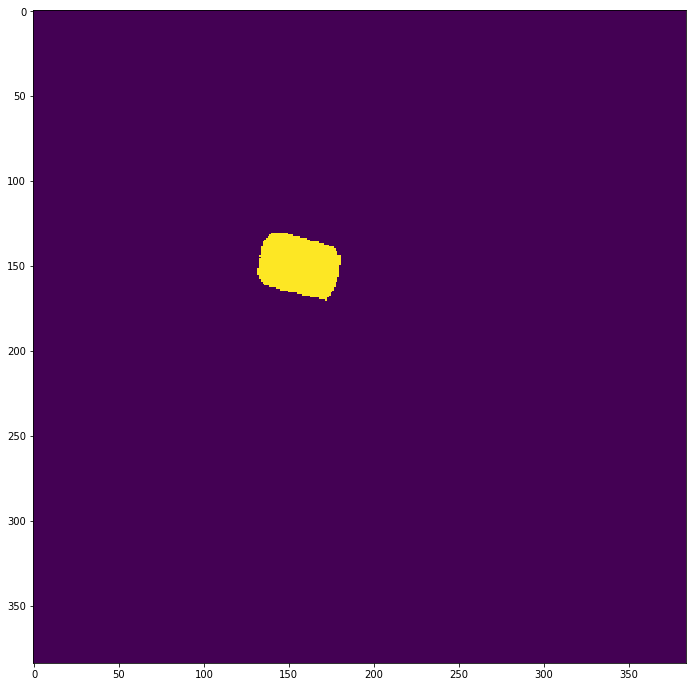

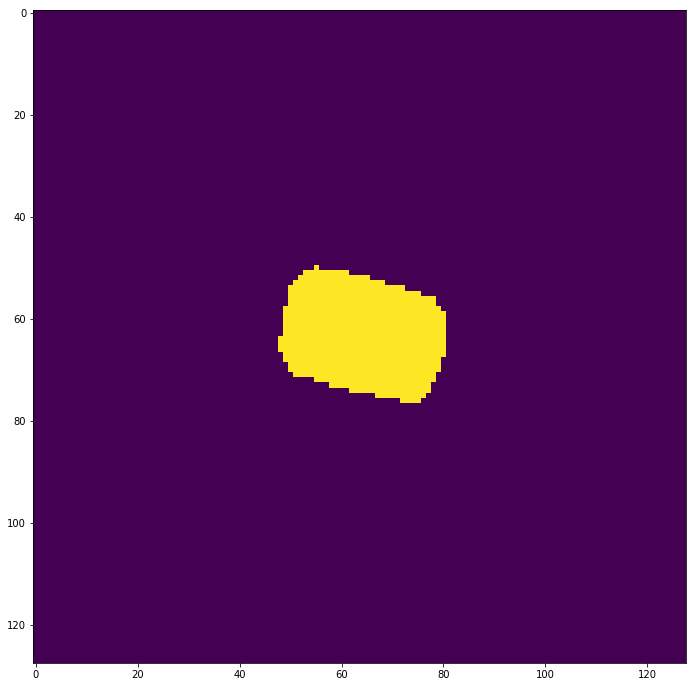

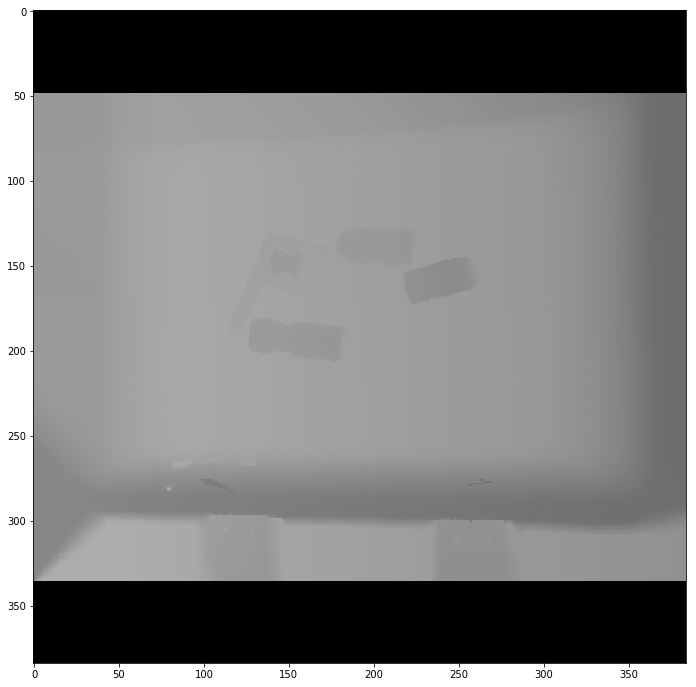

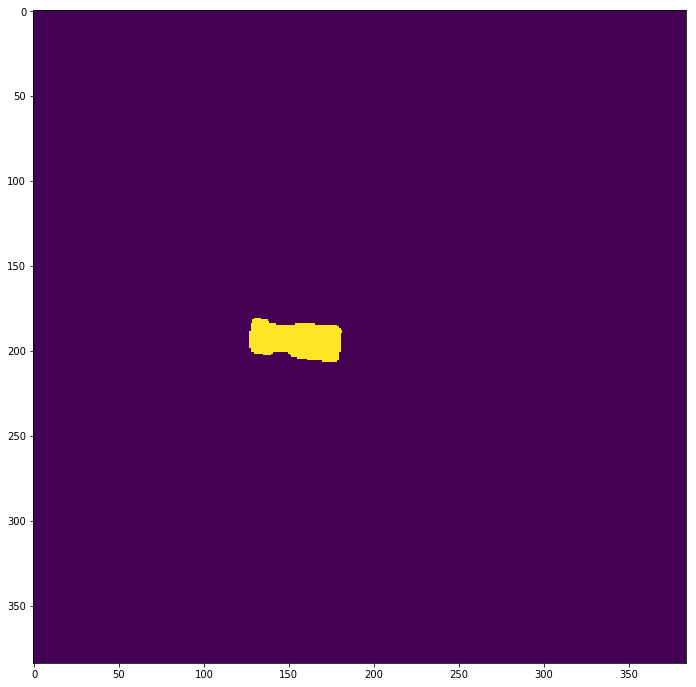

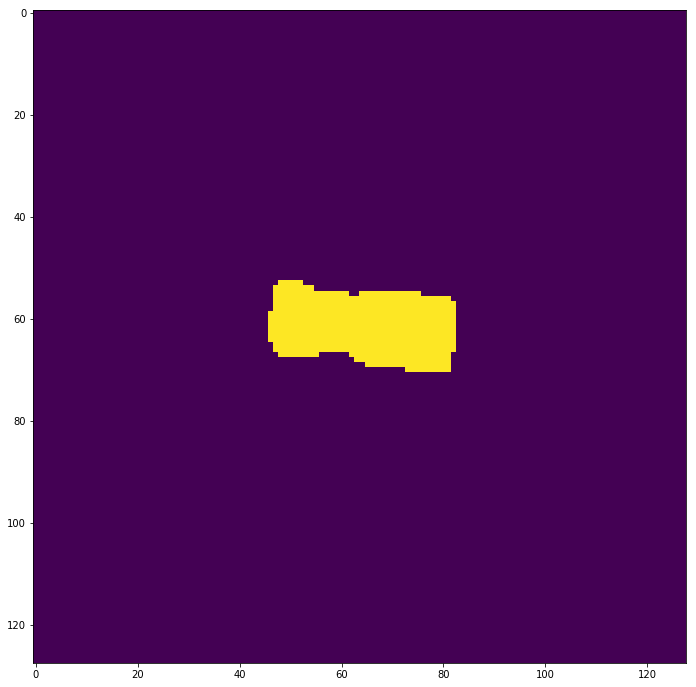

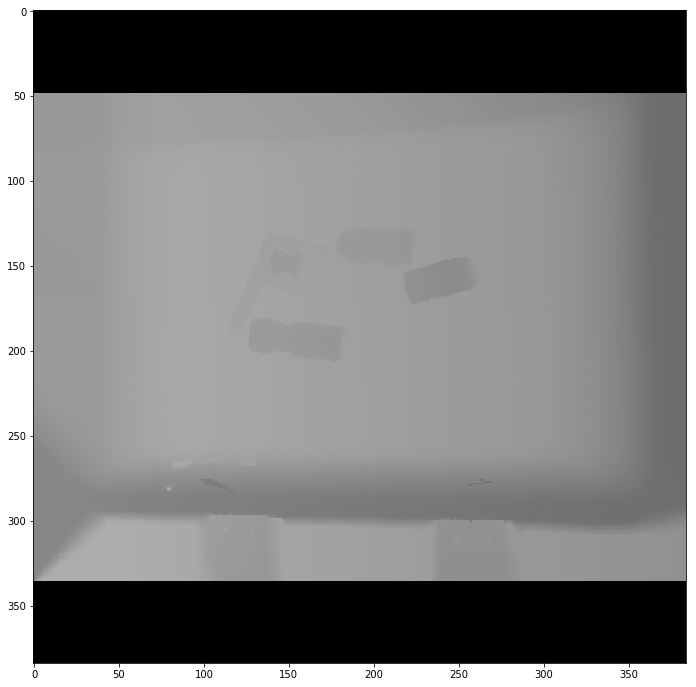

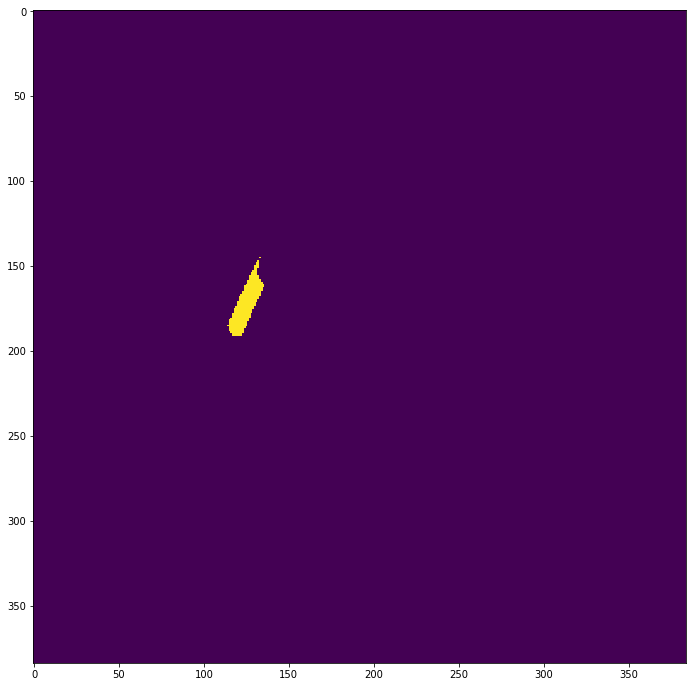

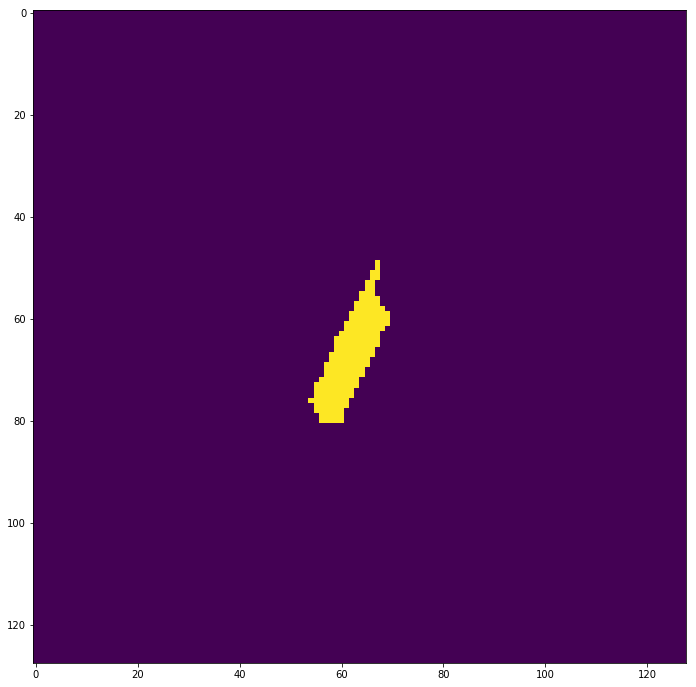

 47%|████▋     | 14/30 [00:40<00:45,  2.87s/it]

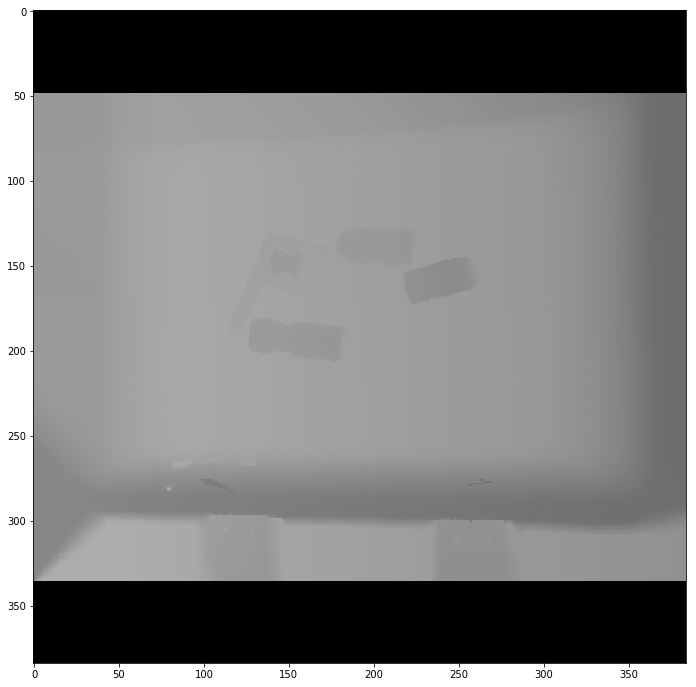

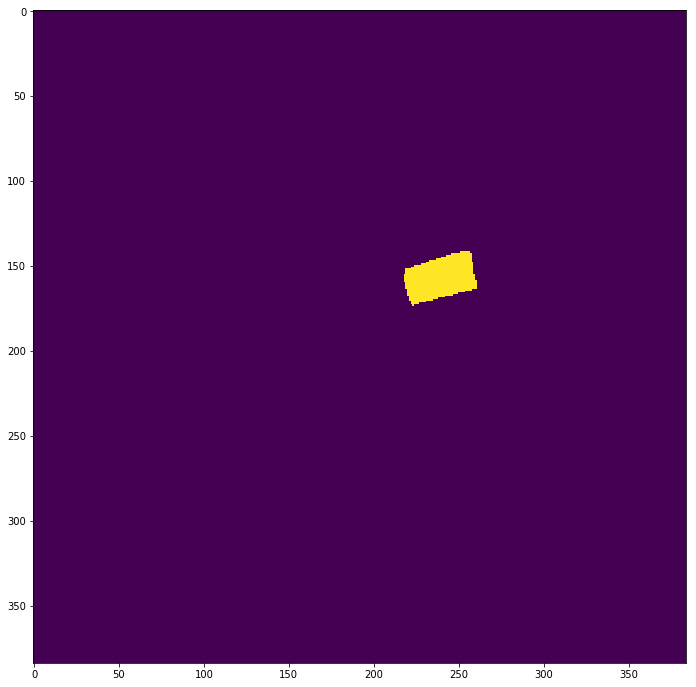

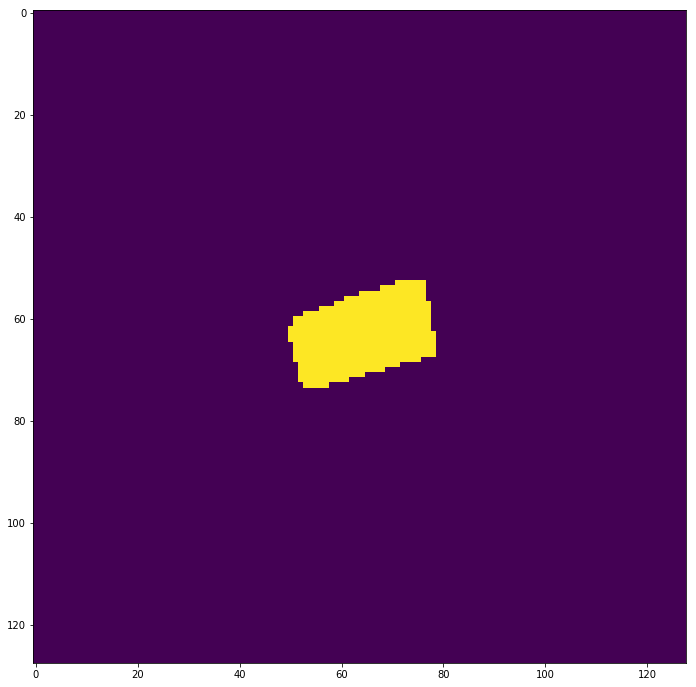

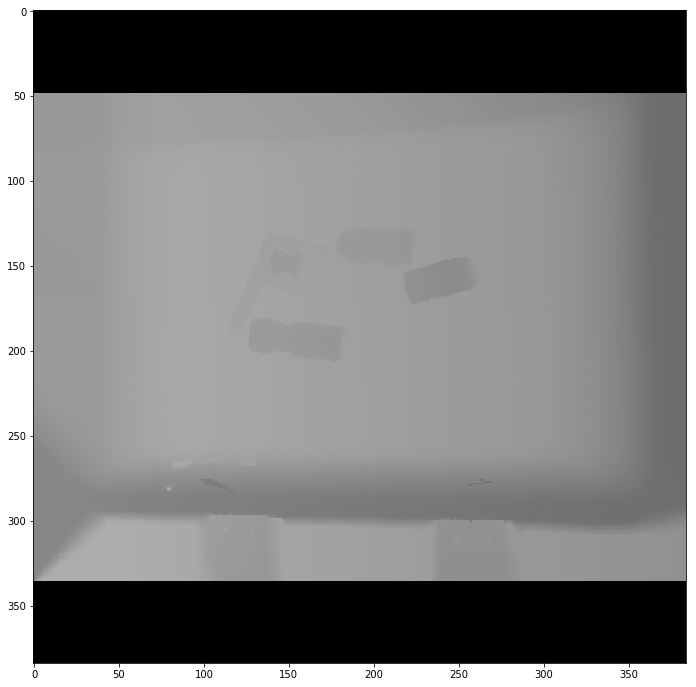

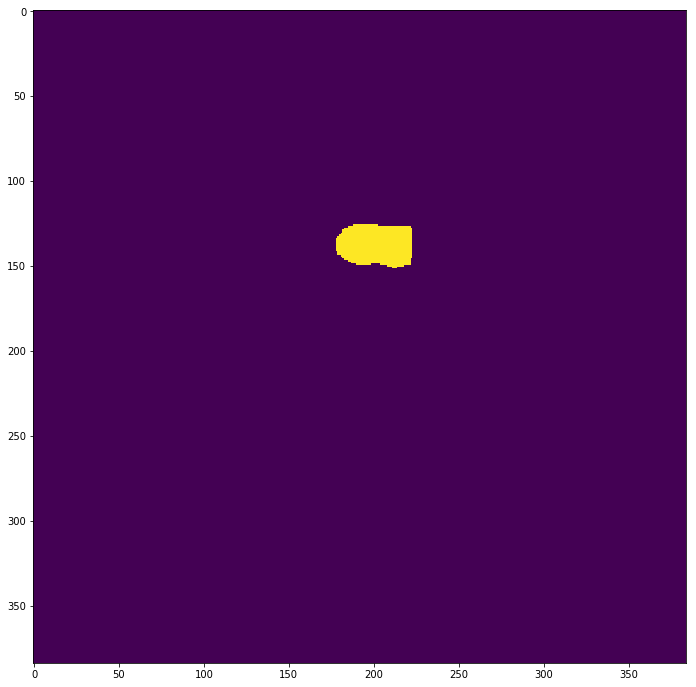

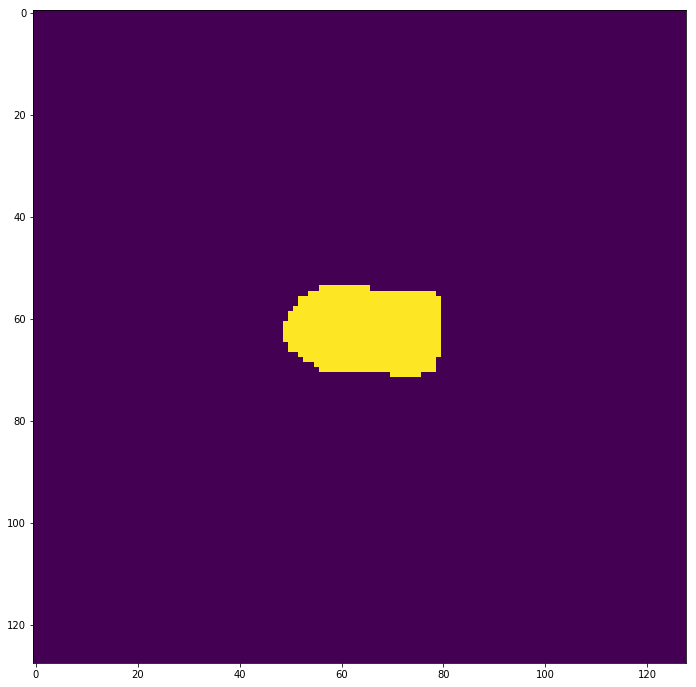

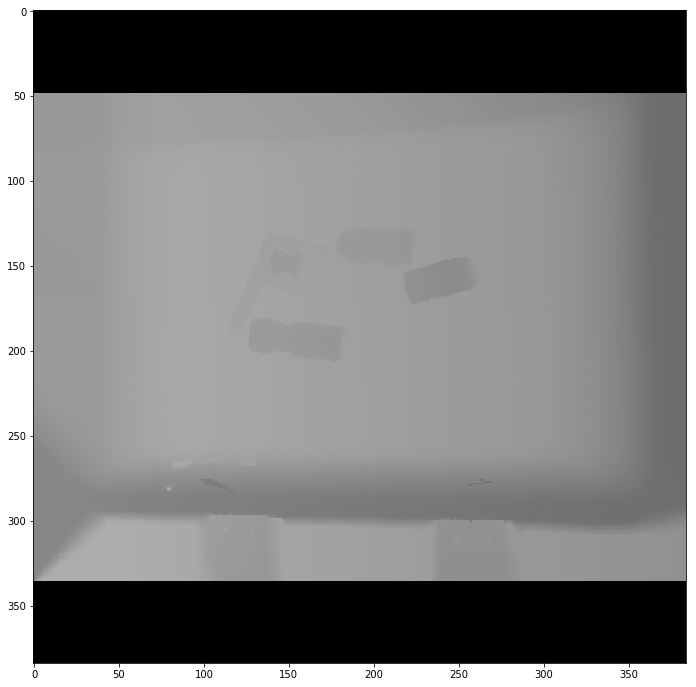

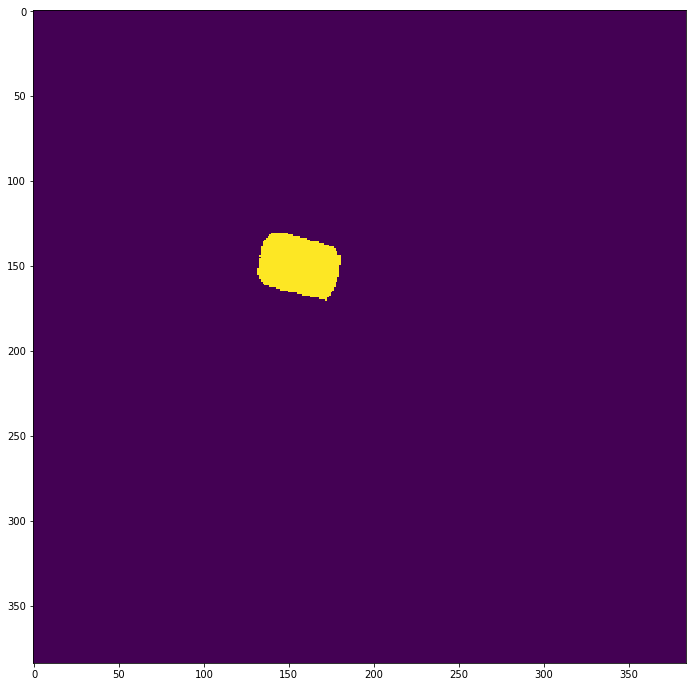

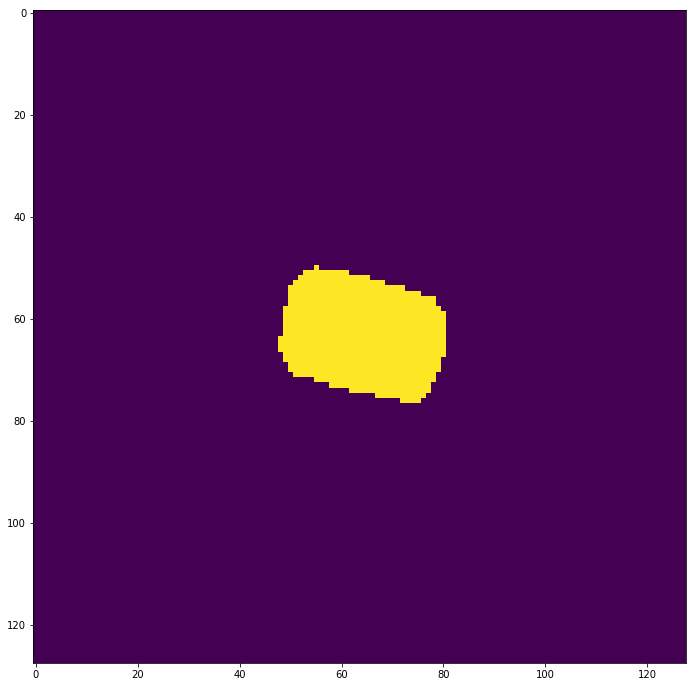

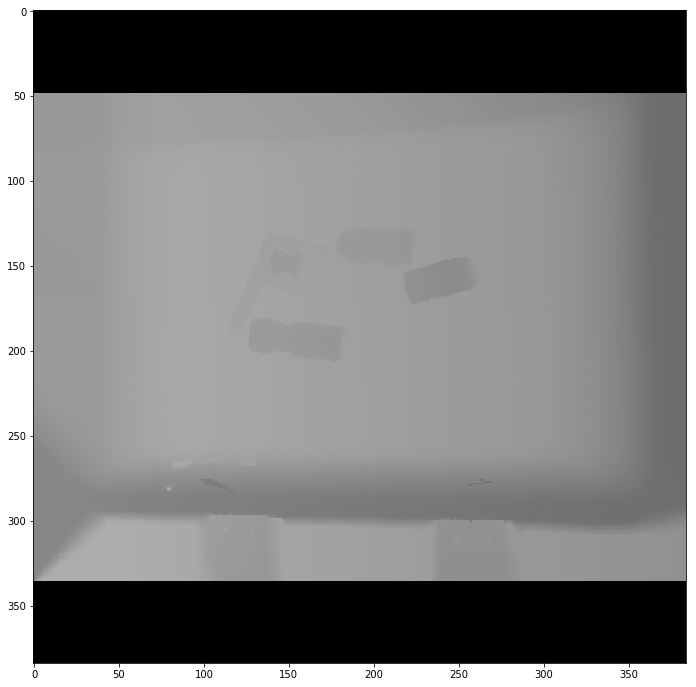

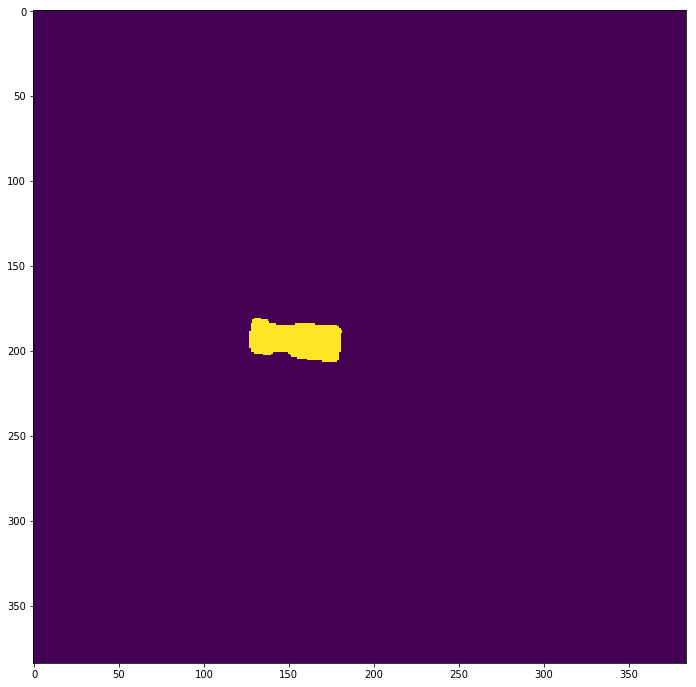

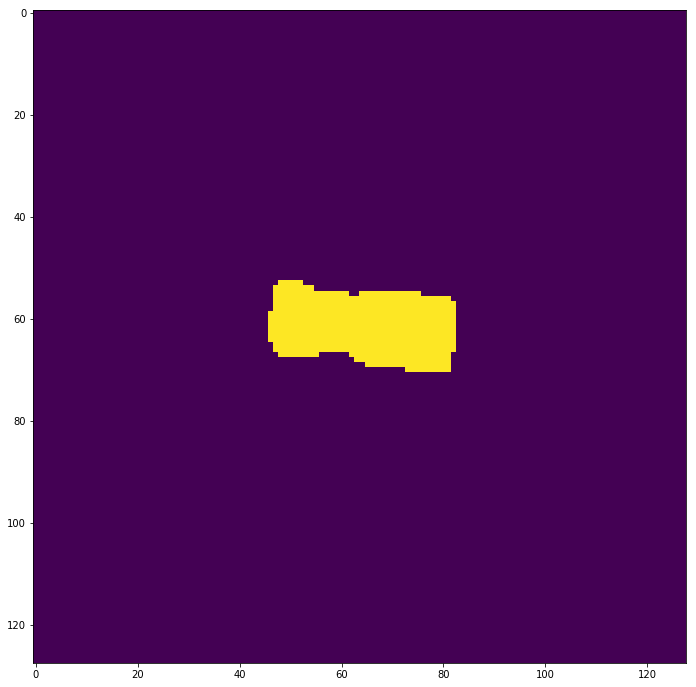

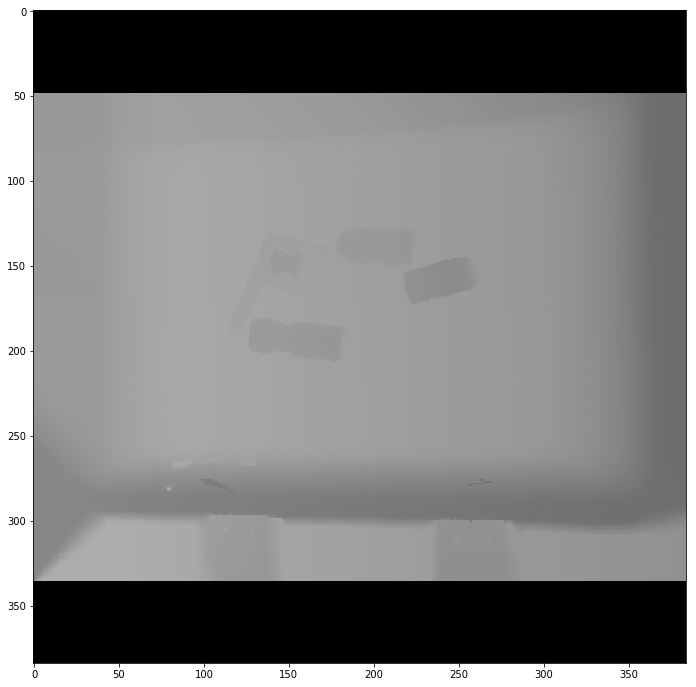

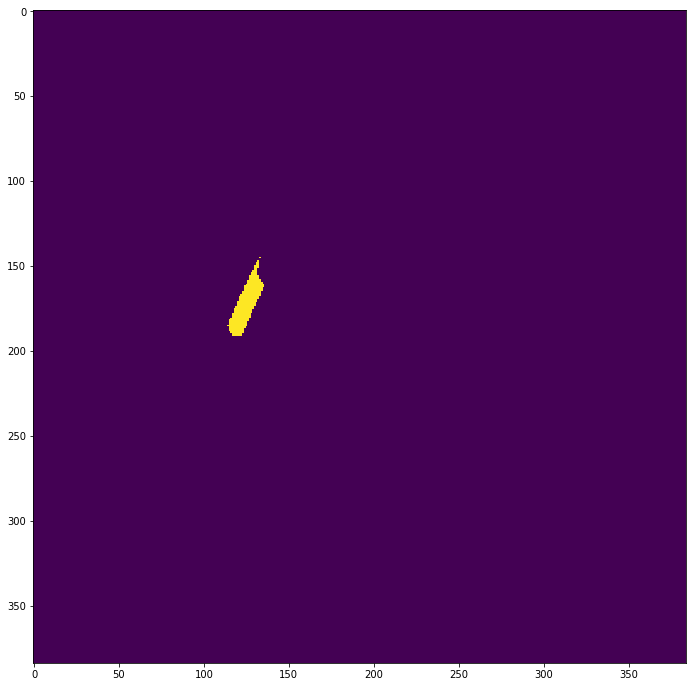

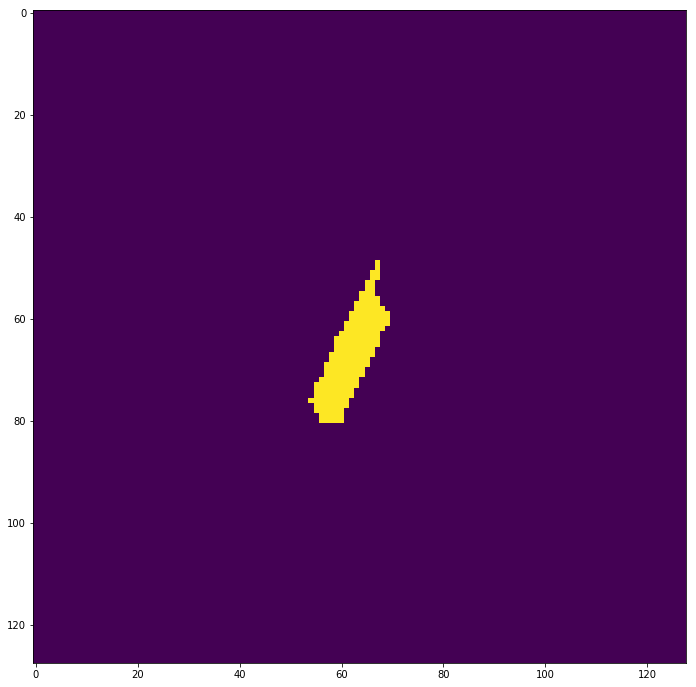

 50%|█████     | 15/30 [00:43<00:43,  2.88s/it]

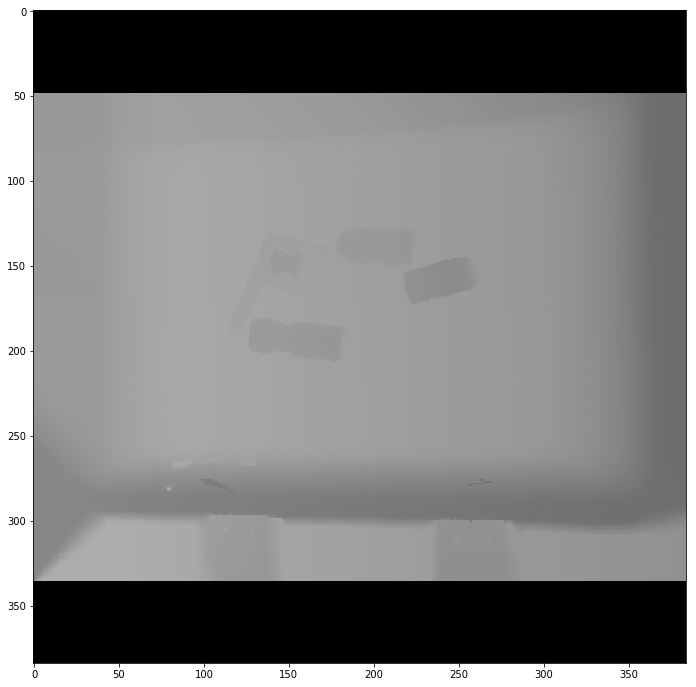

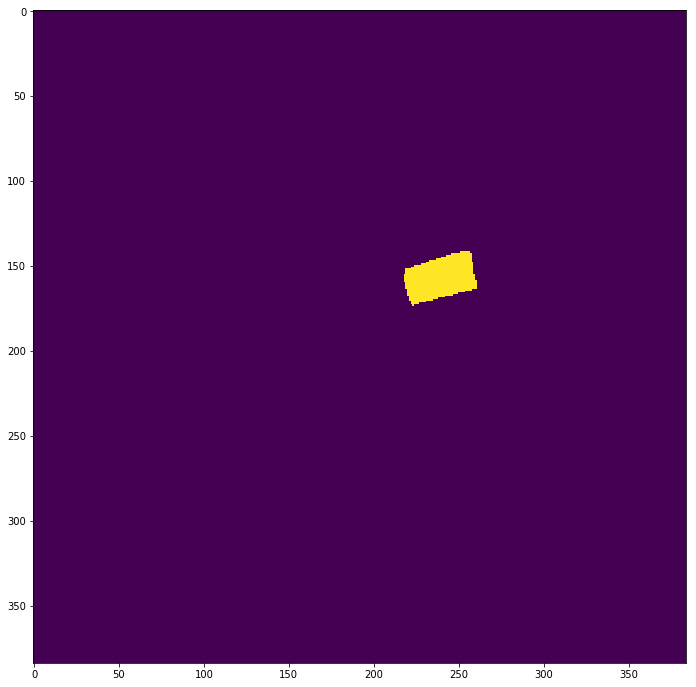

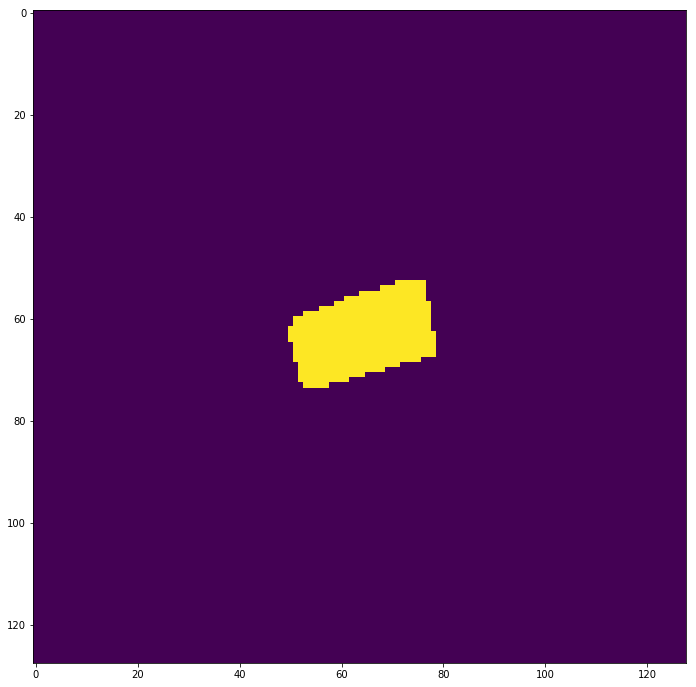

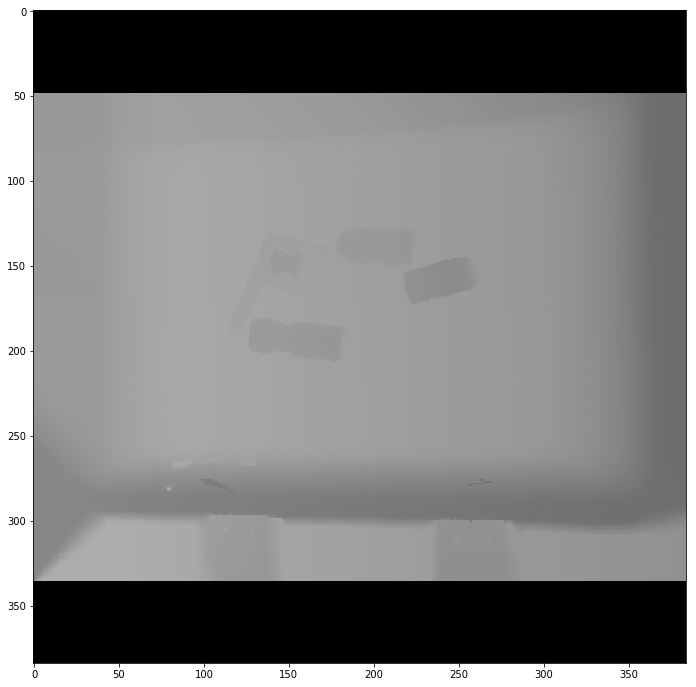

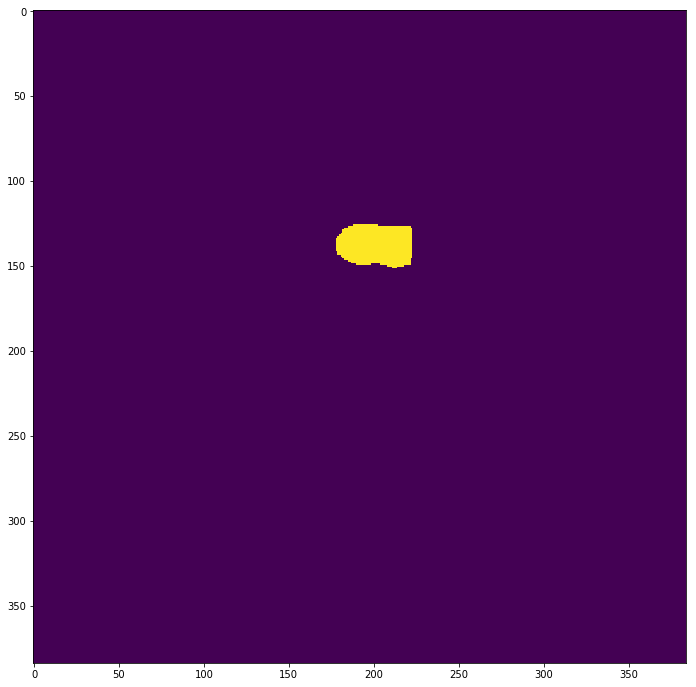

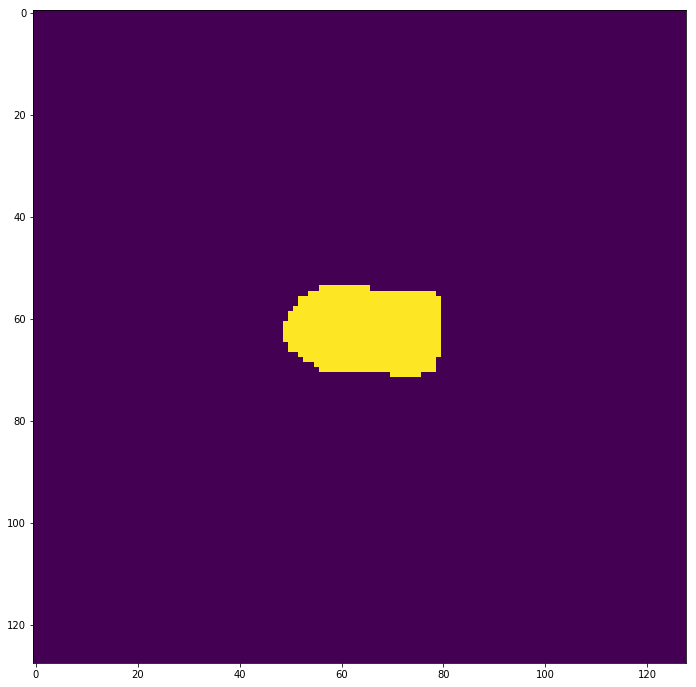

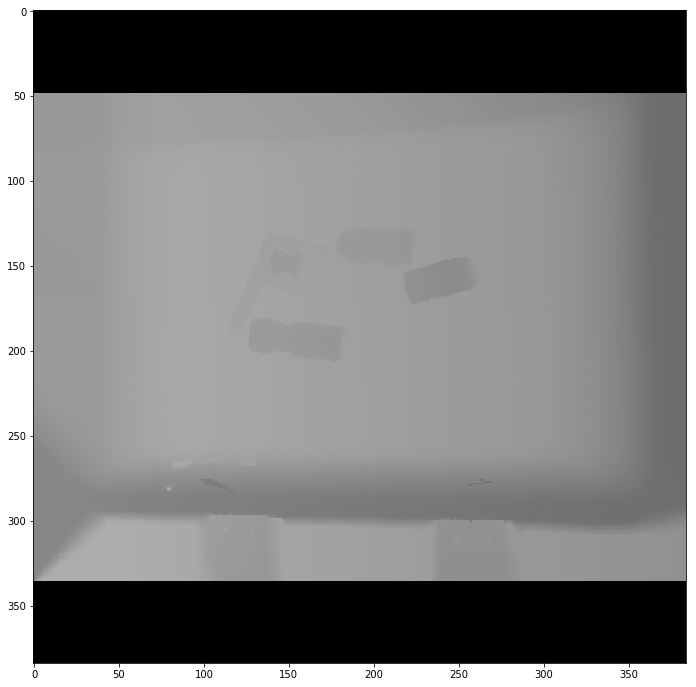

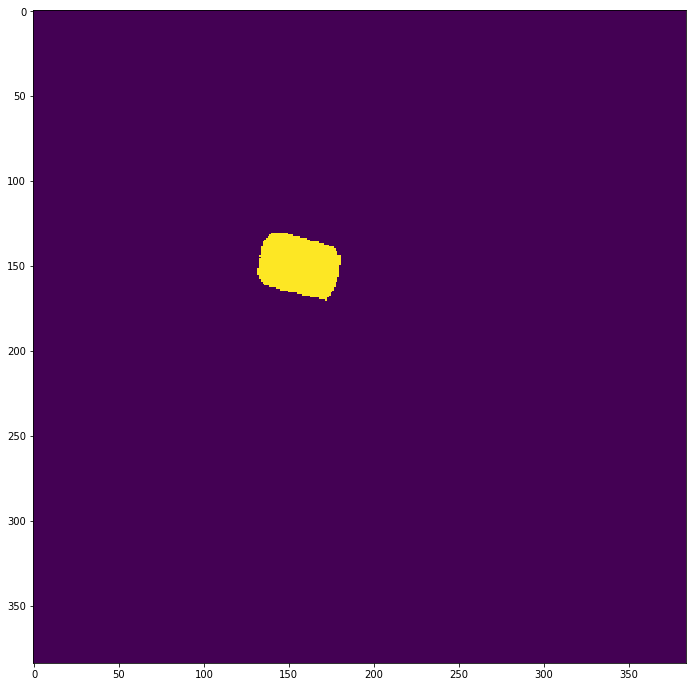

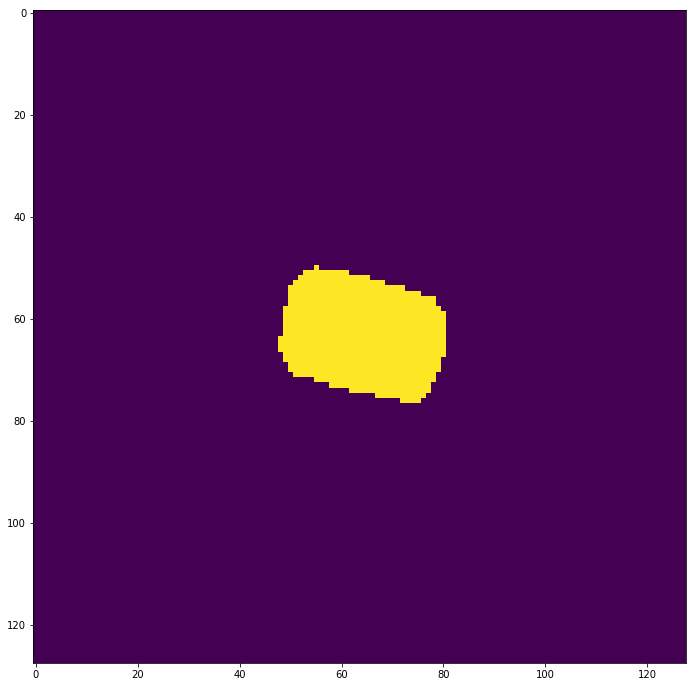

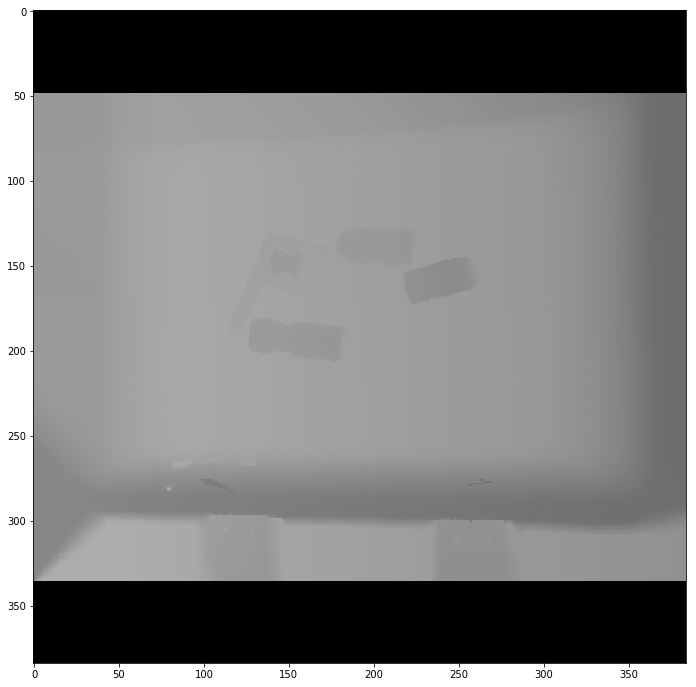

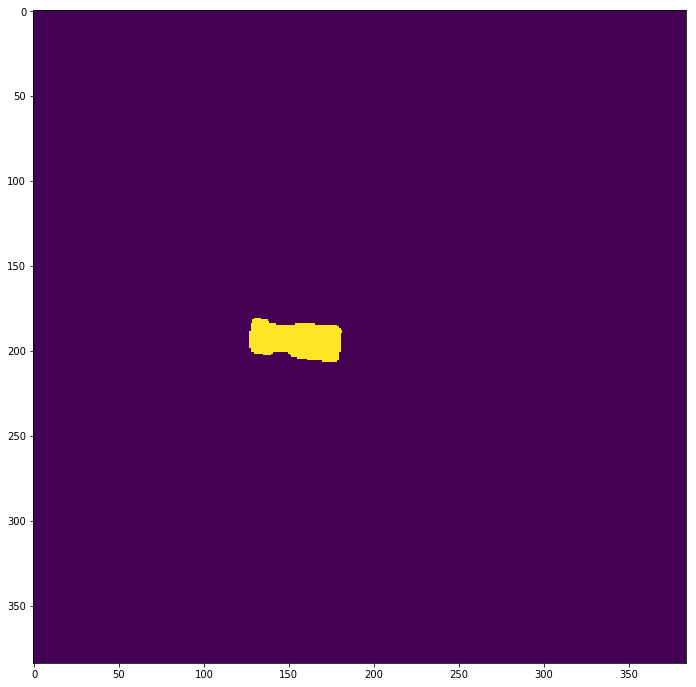

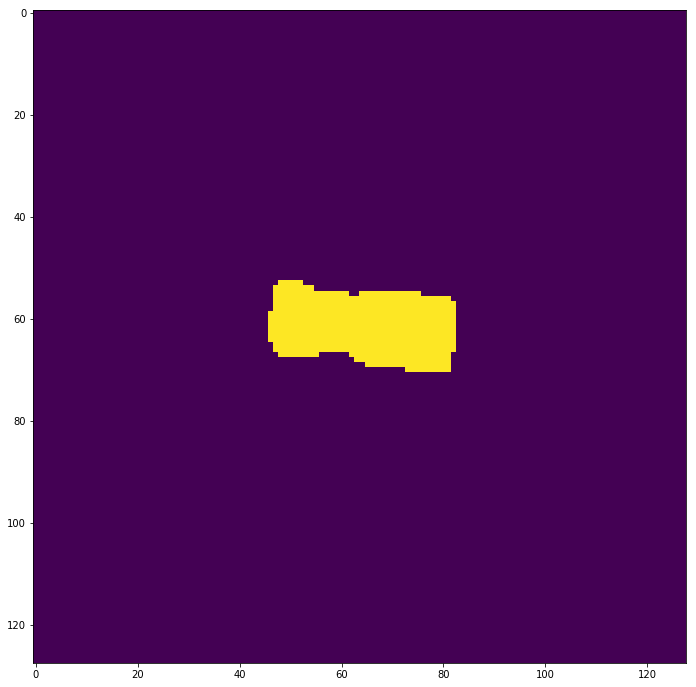

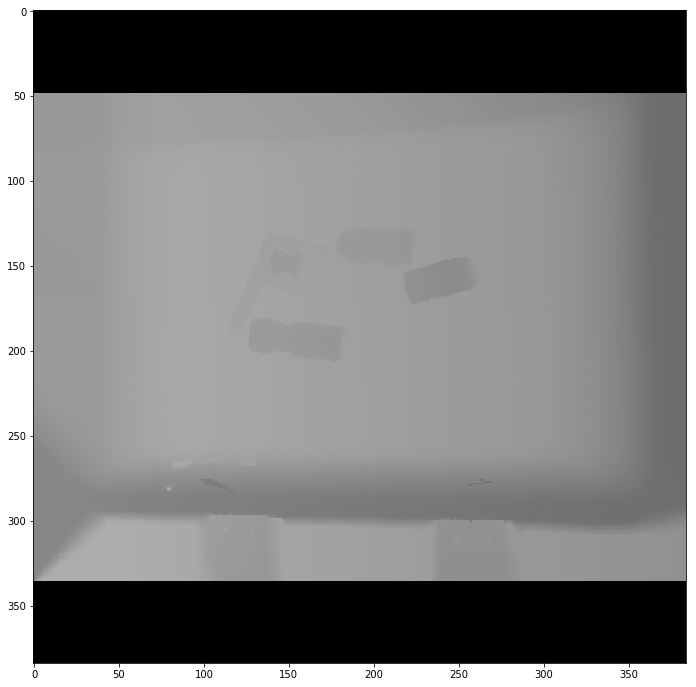

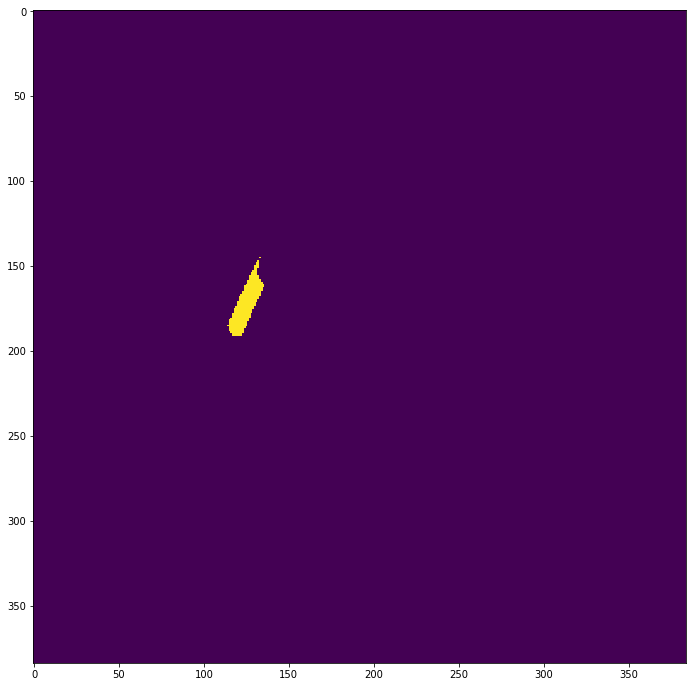

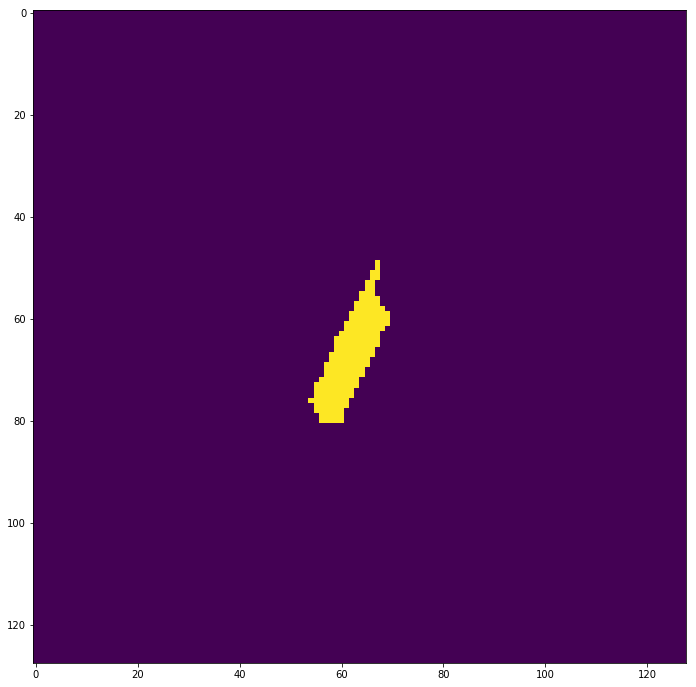

 53%|█████▎    | 16/30 [00:46<00:40,  2.89s/it]

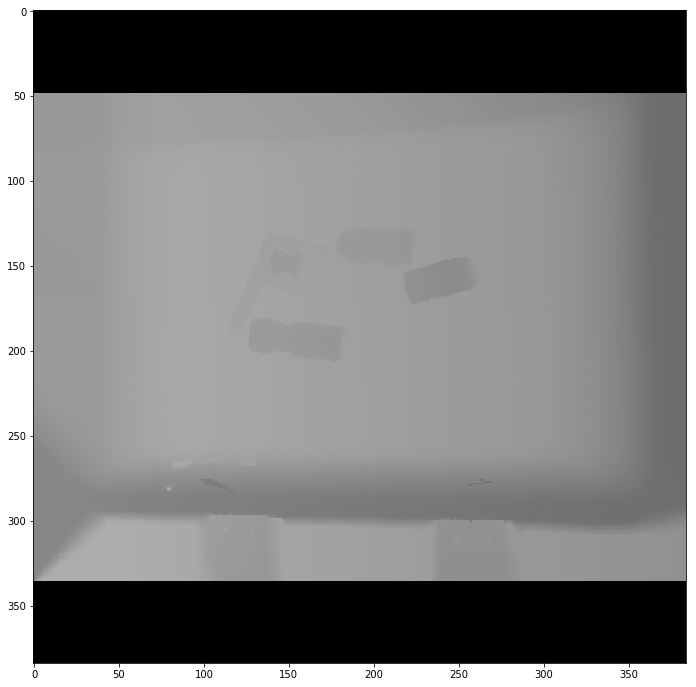

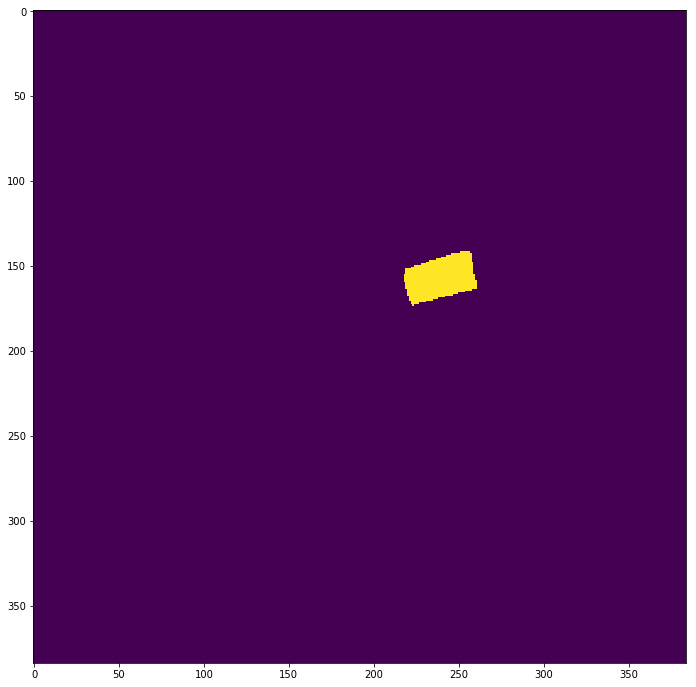

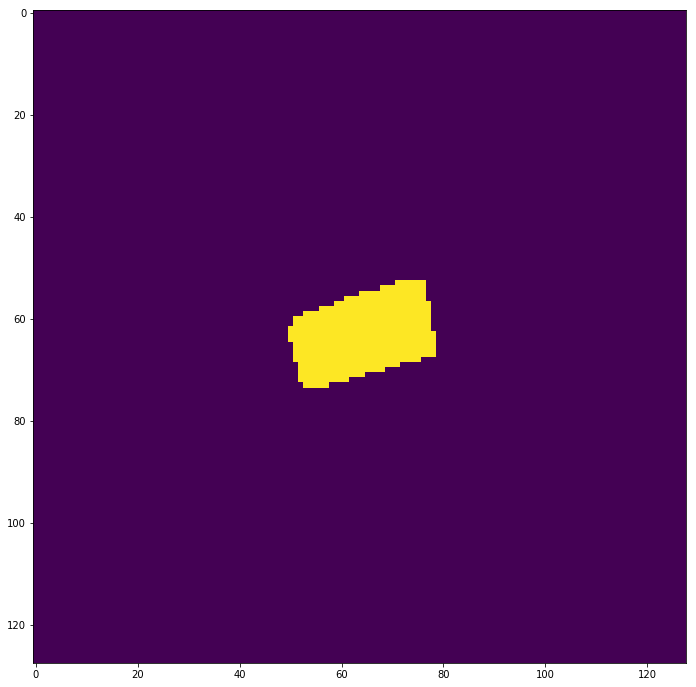

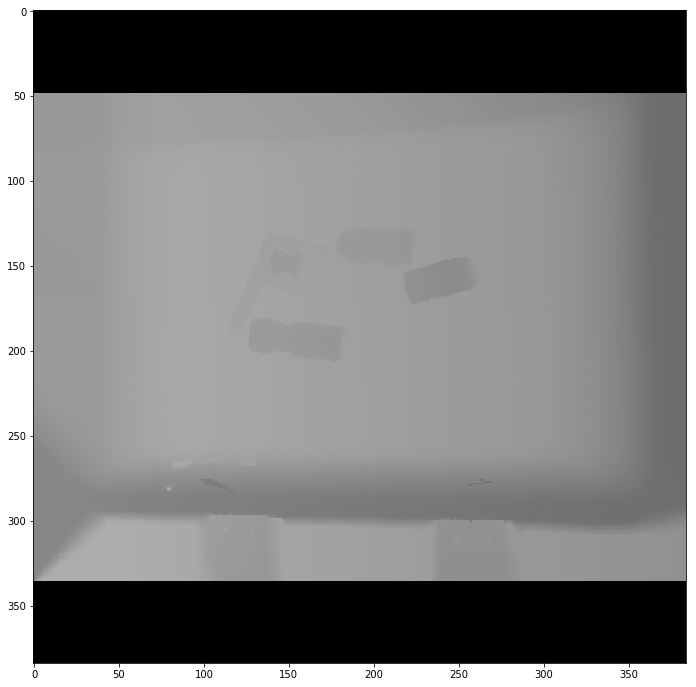

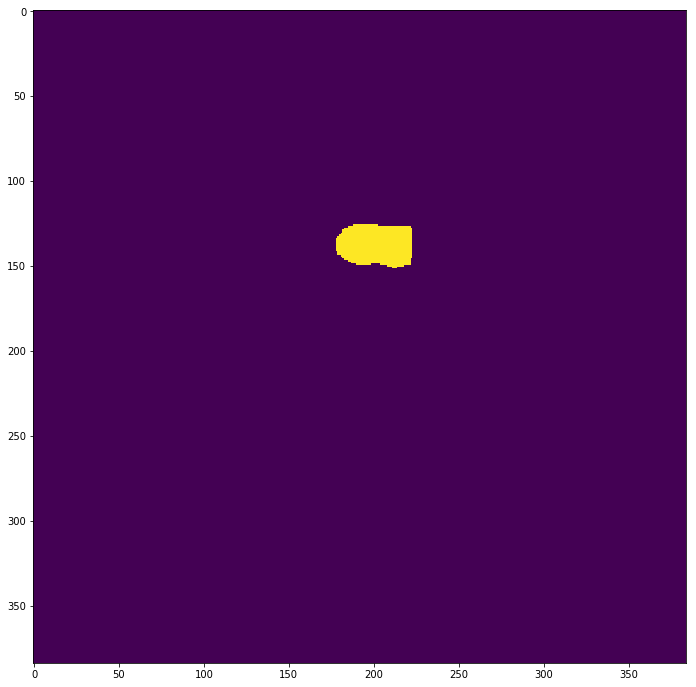

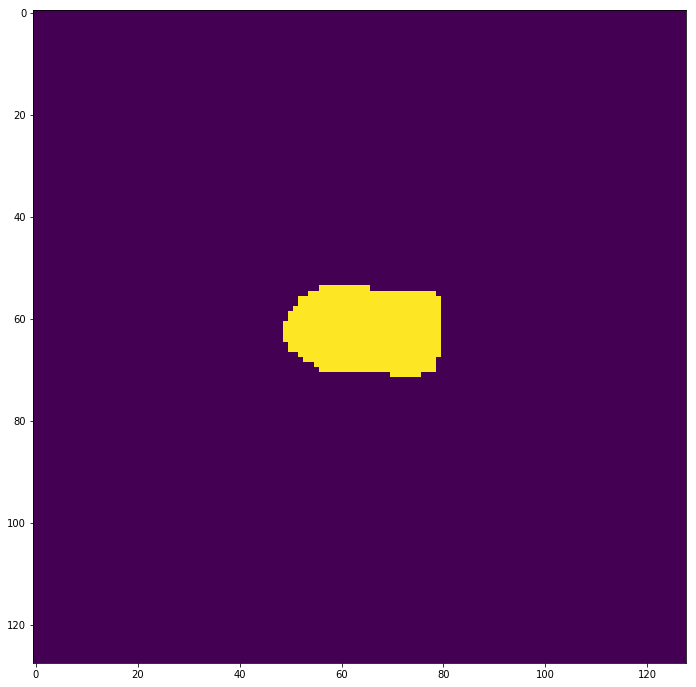

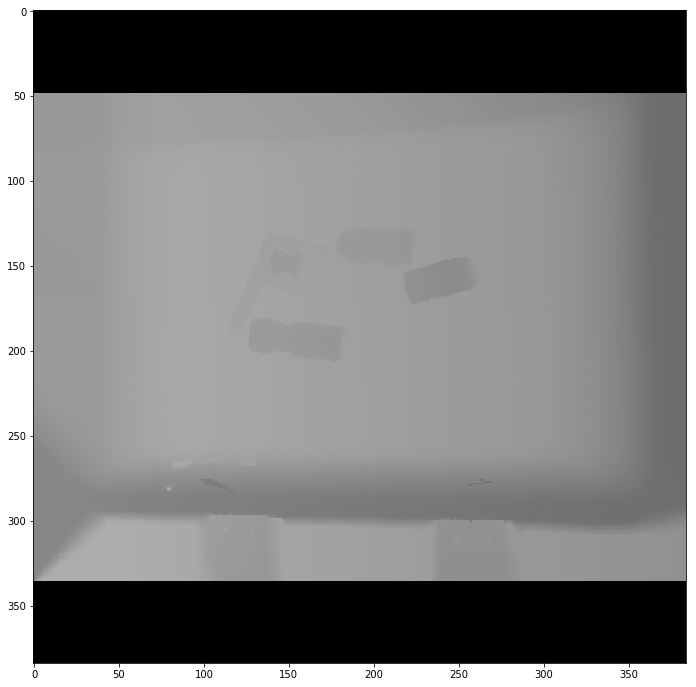

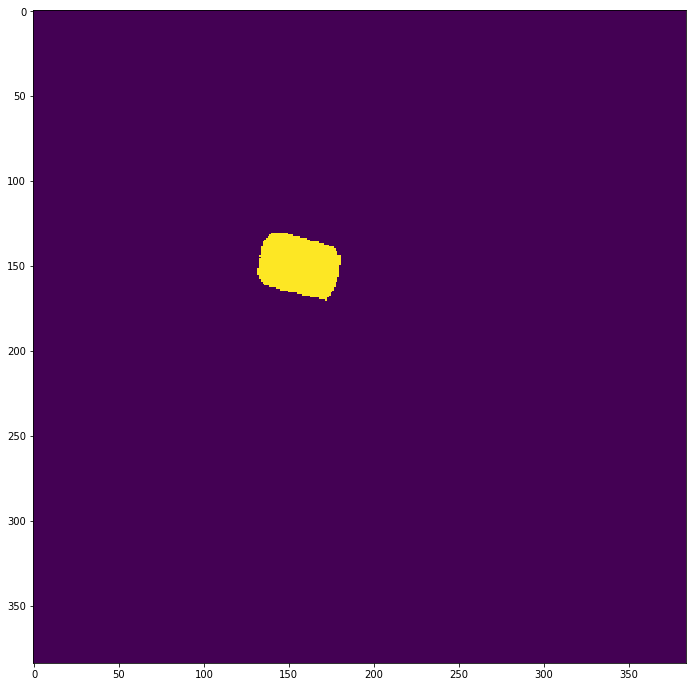

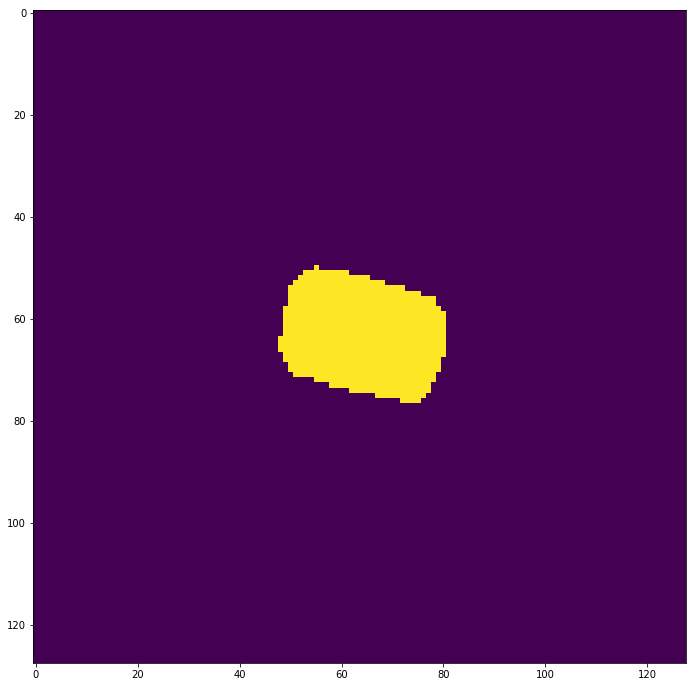

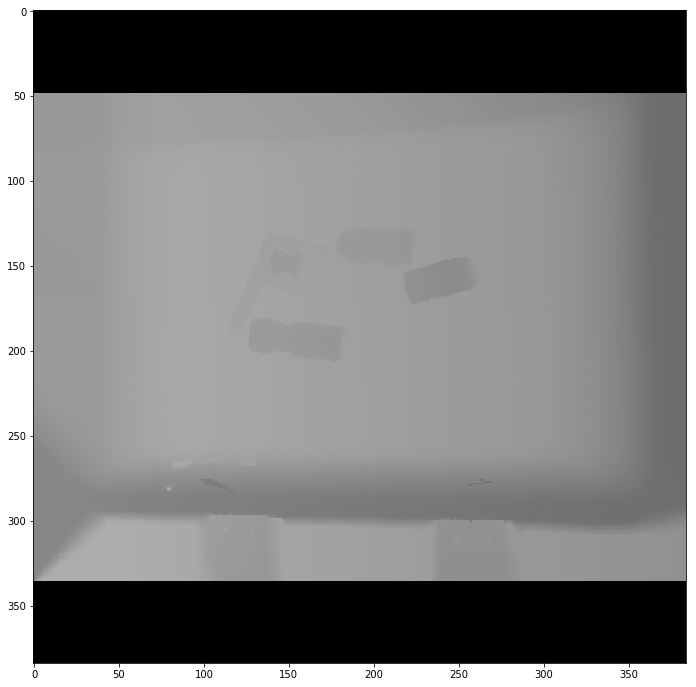

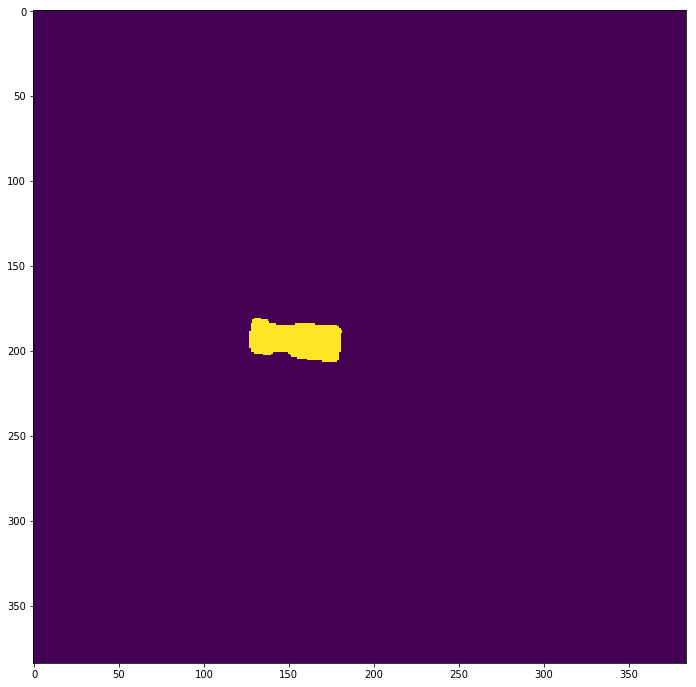

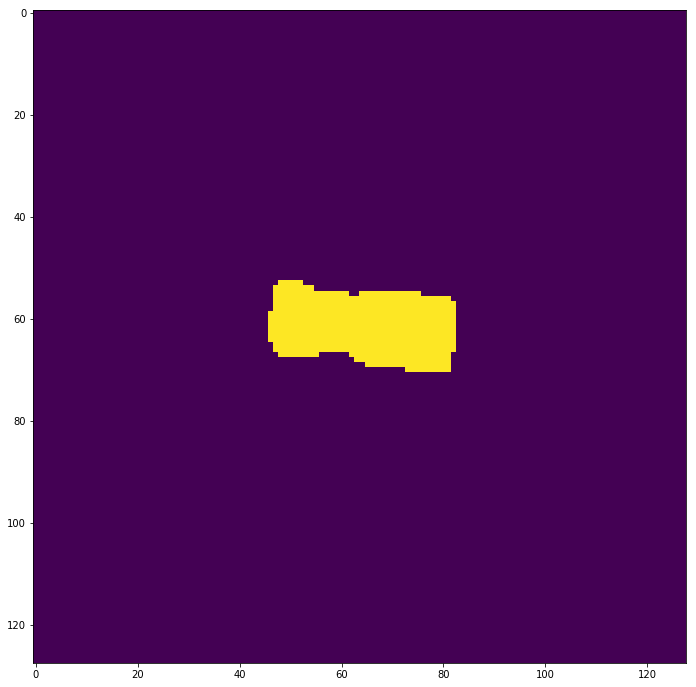

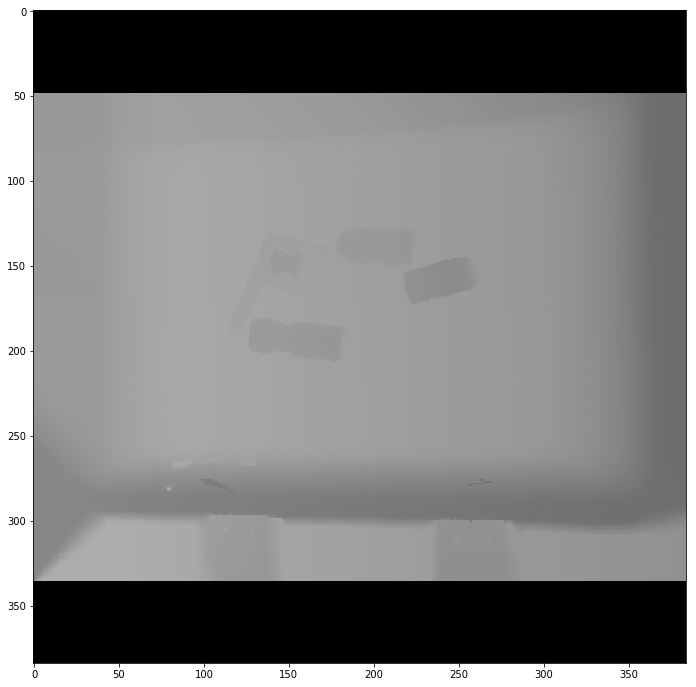

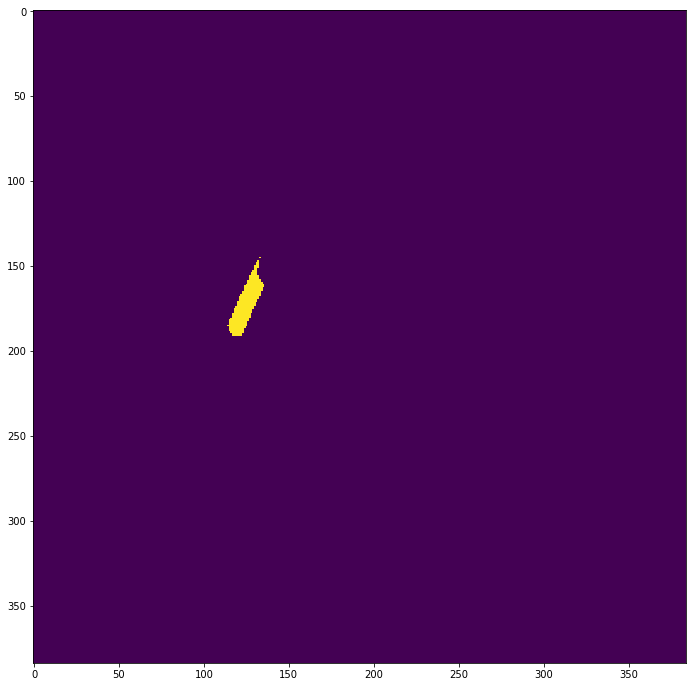

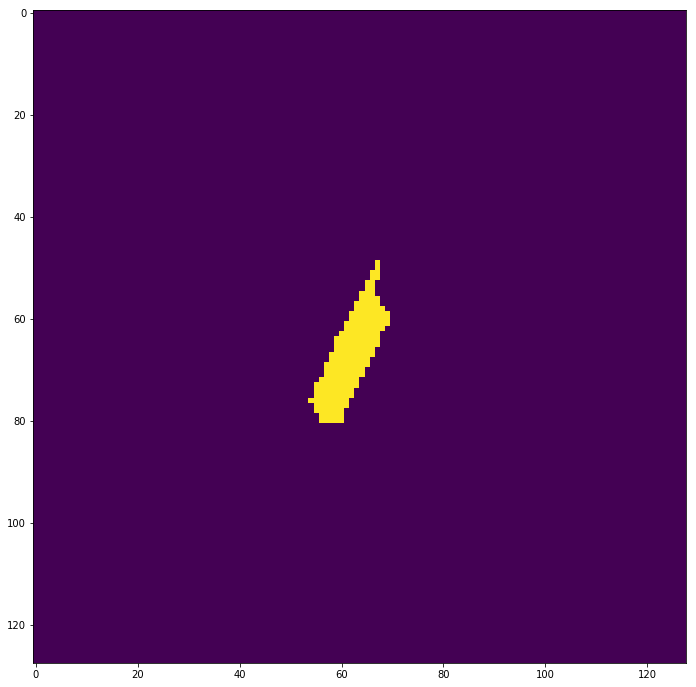

 57%|█████▋    | 17/30 [00:49<00:37,  2.89s/it]

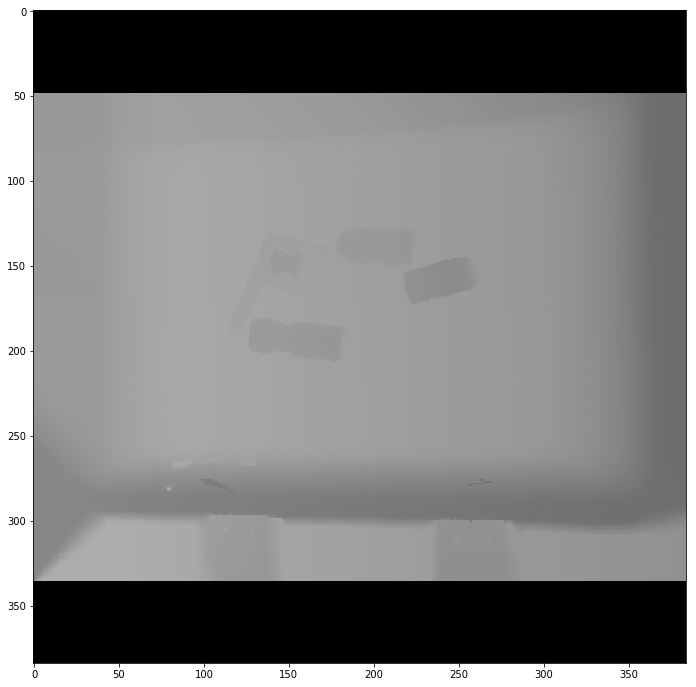

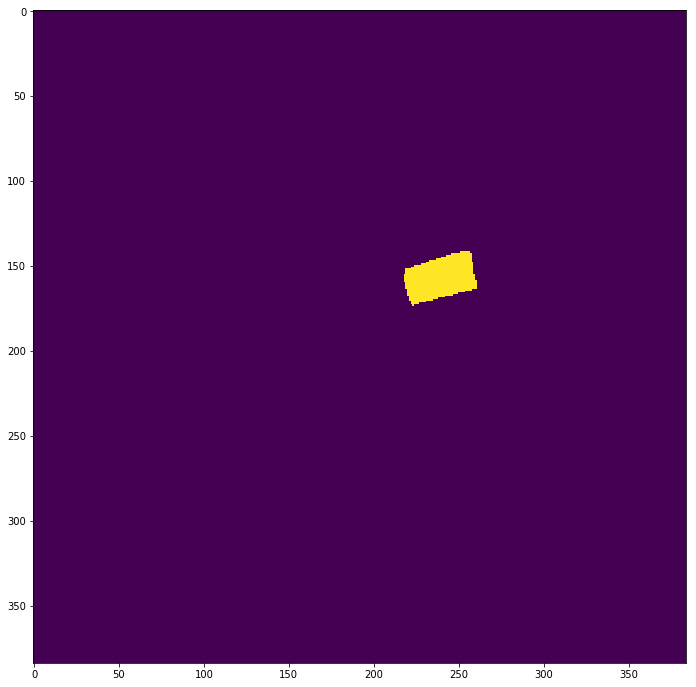

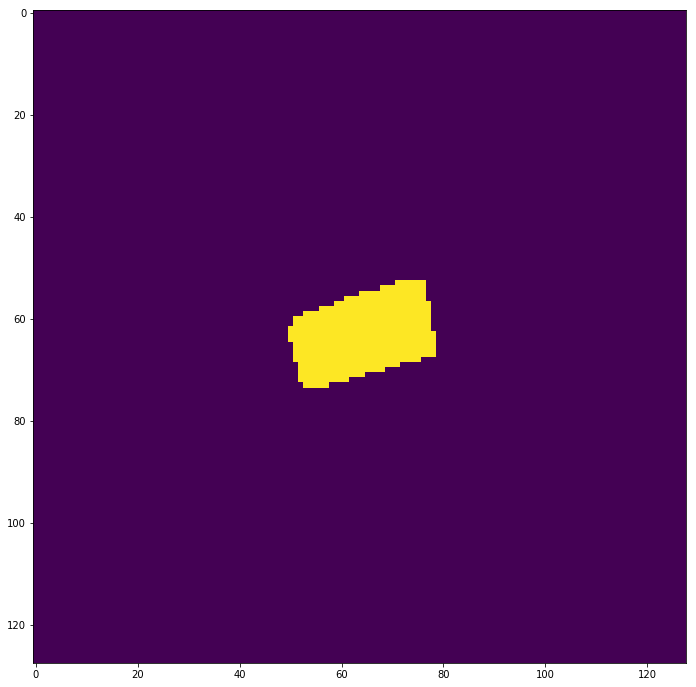

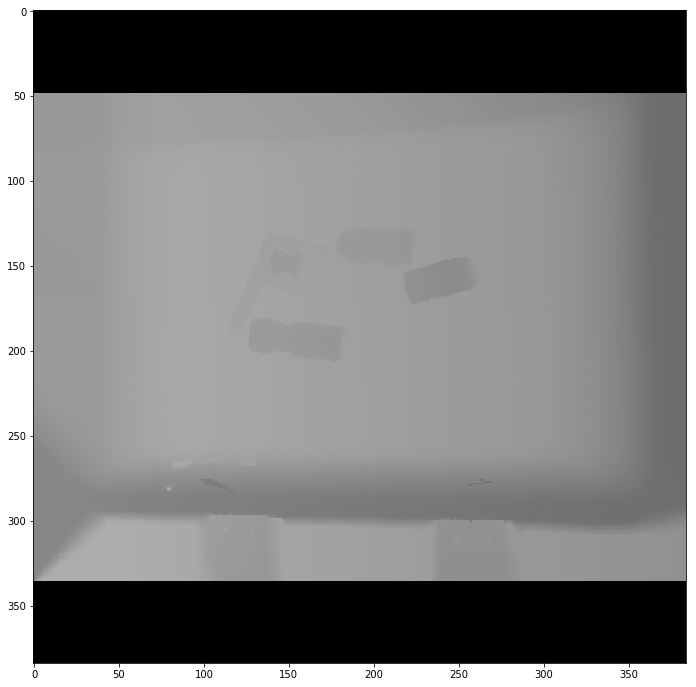

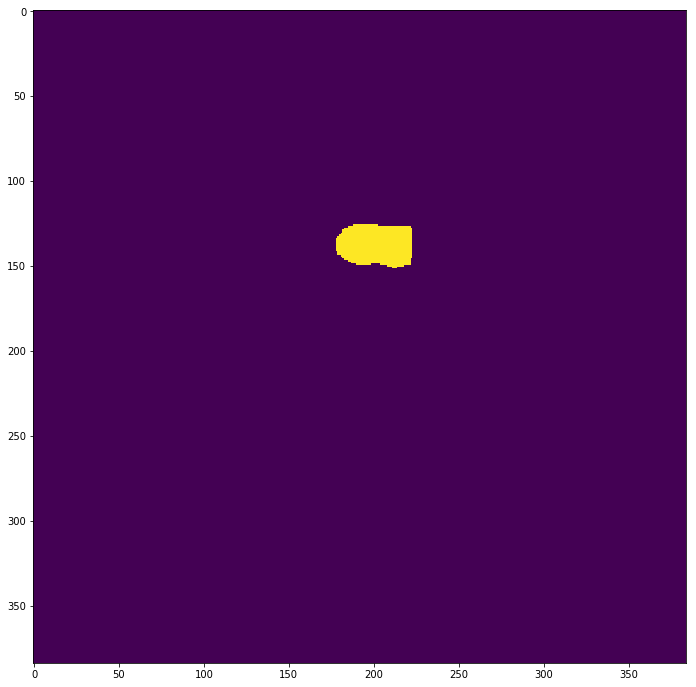

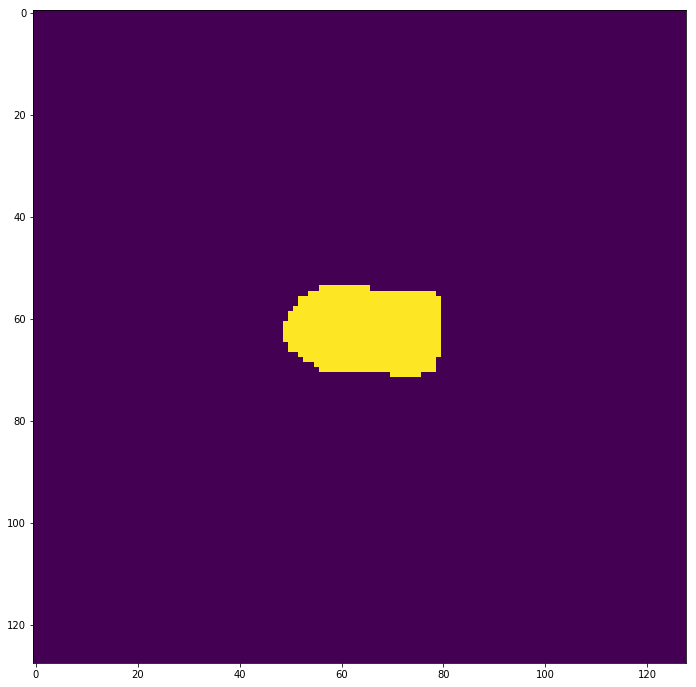

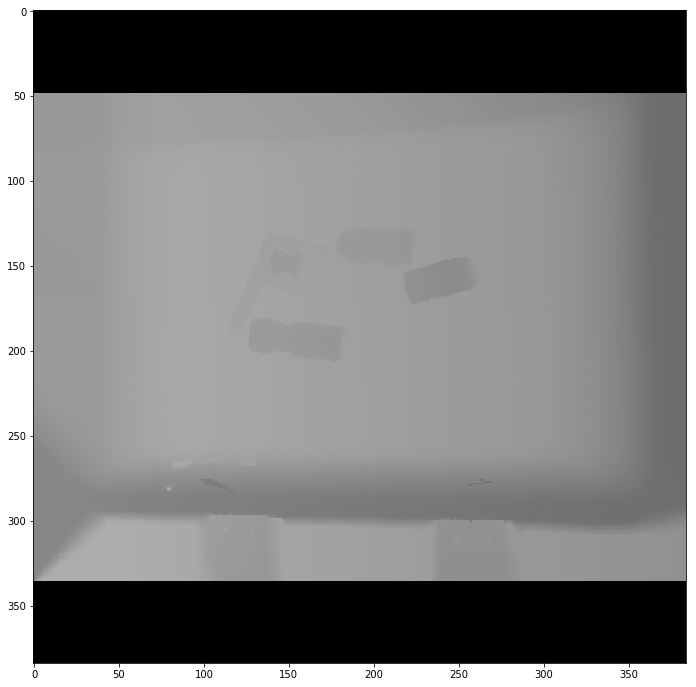

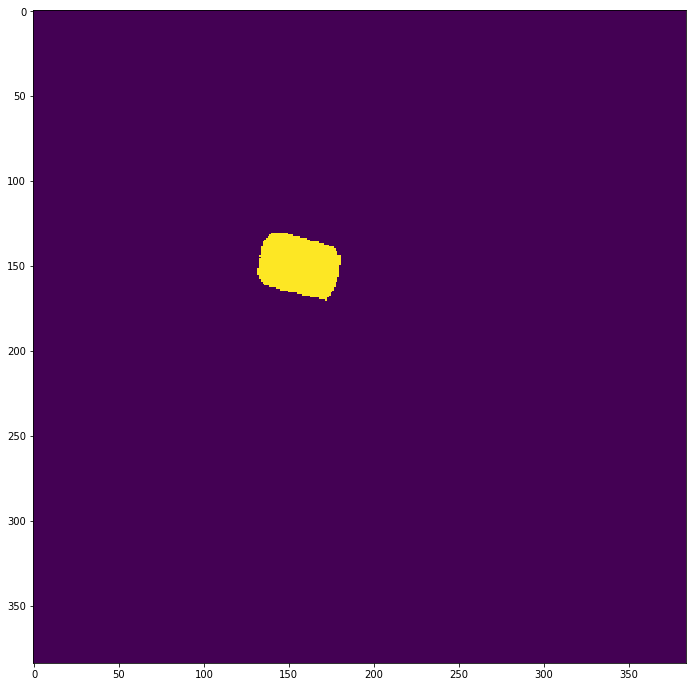

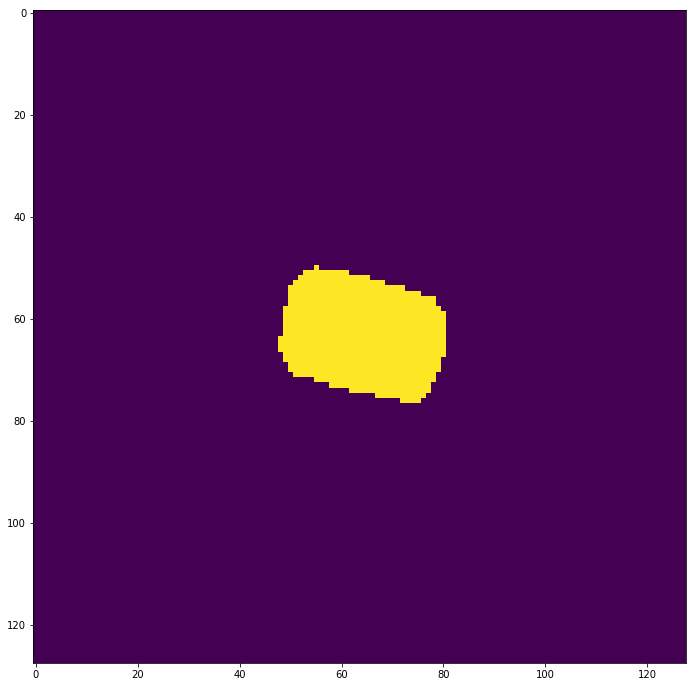

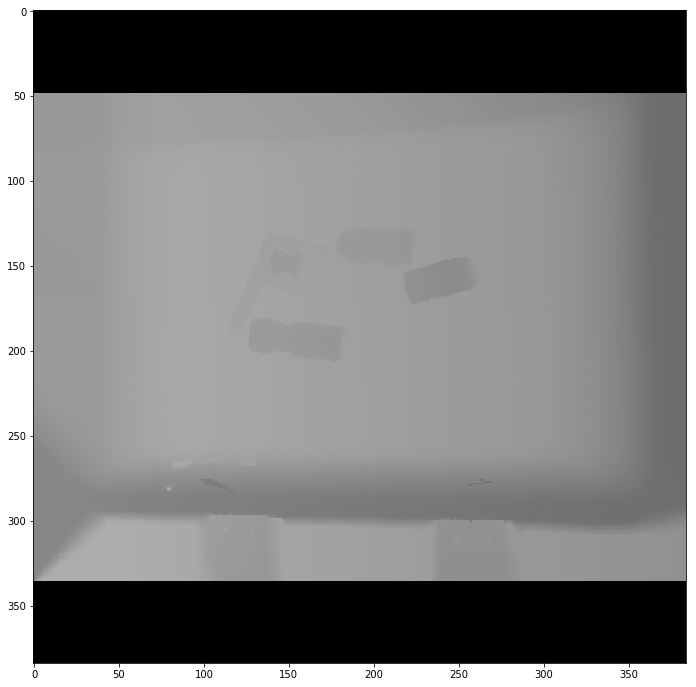

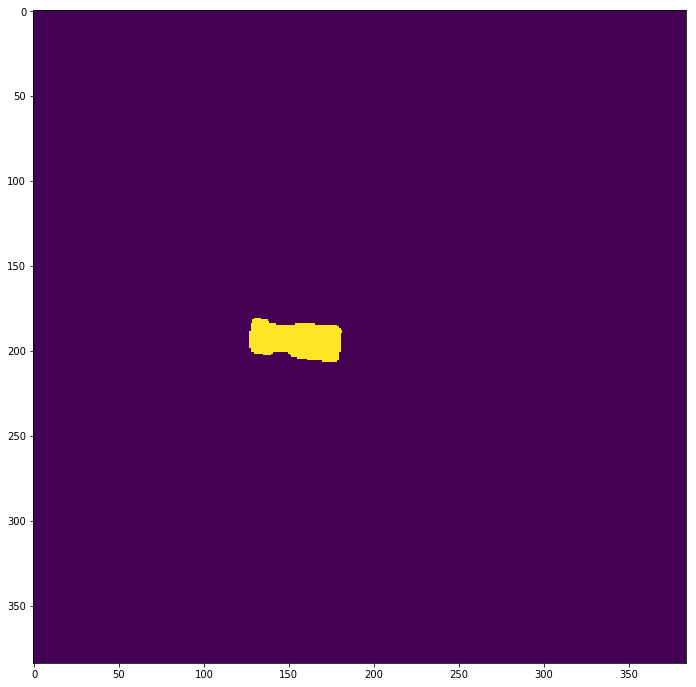

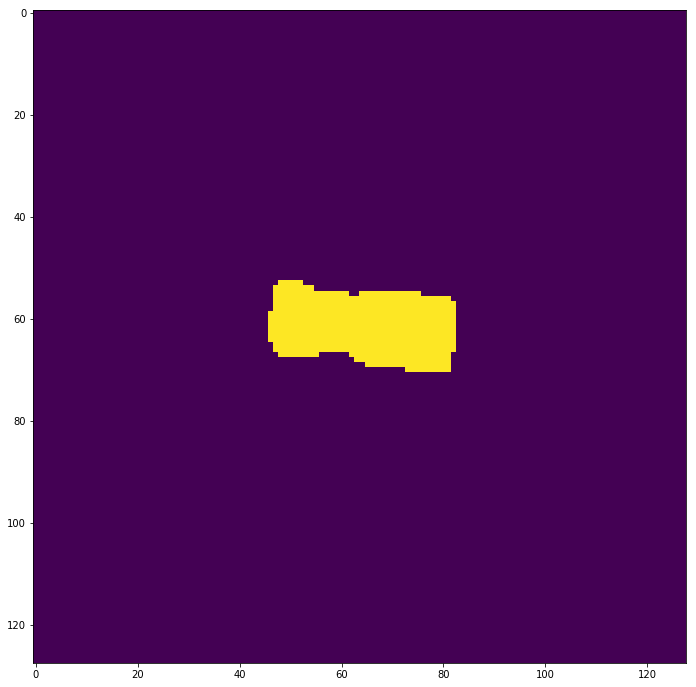

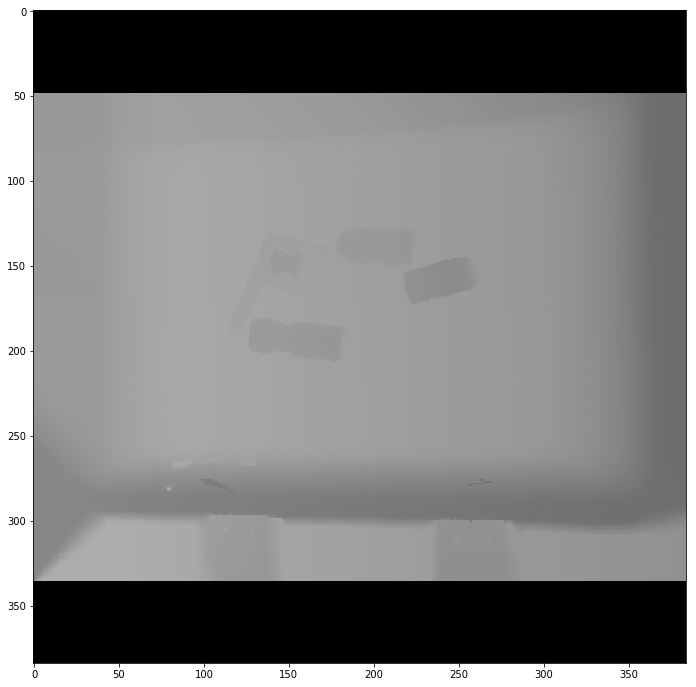

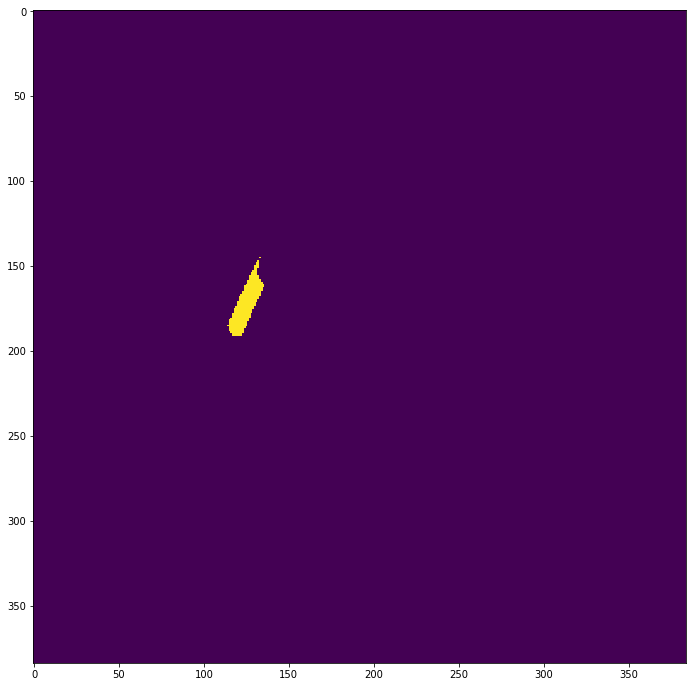

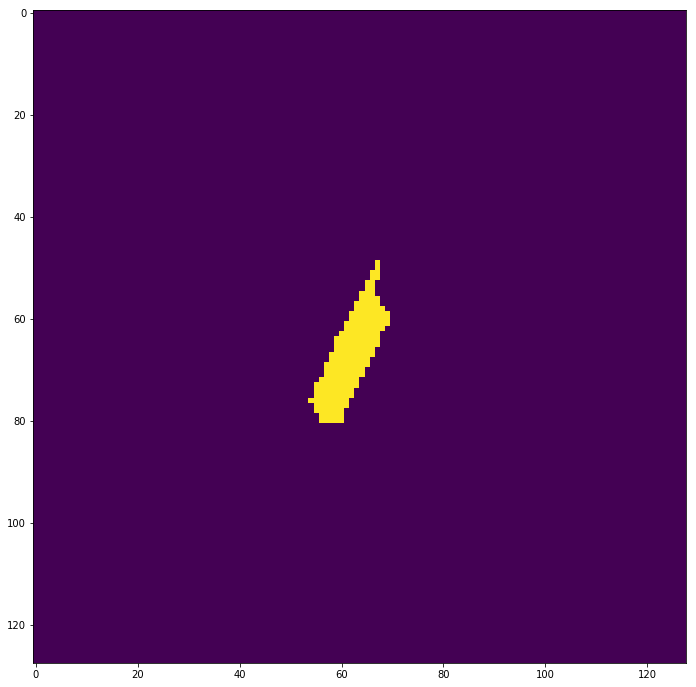

 60%|██████    | 18/30 [00:51<00:34,  2.90s/it]

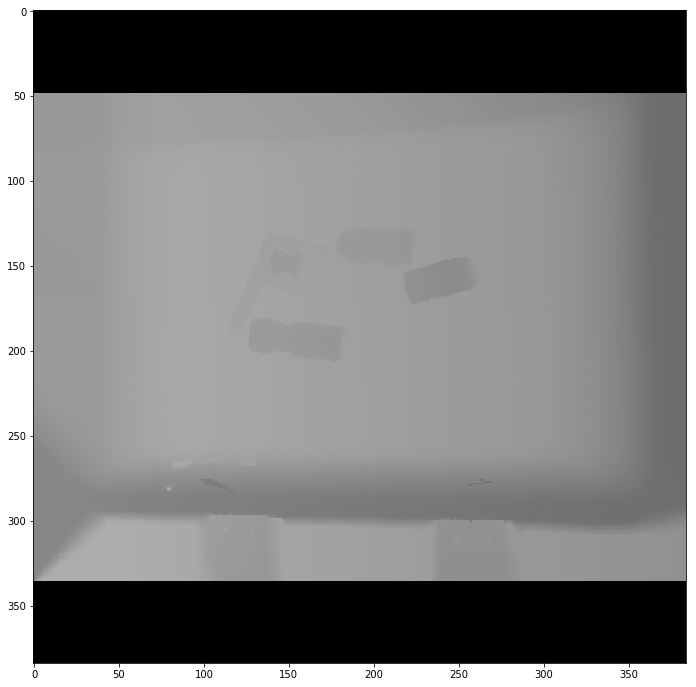

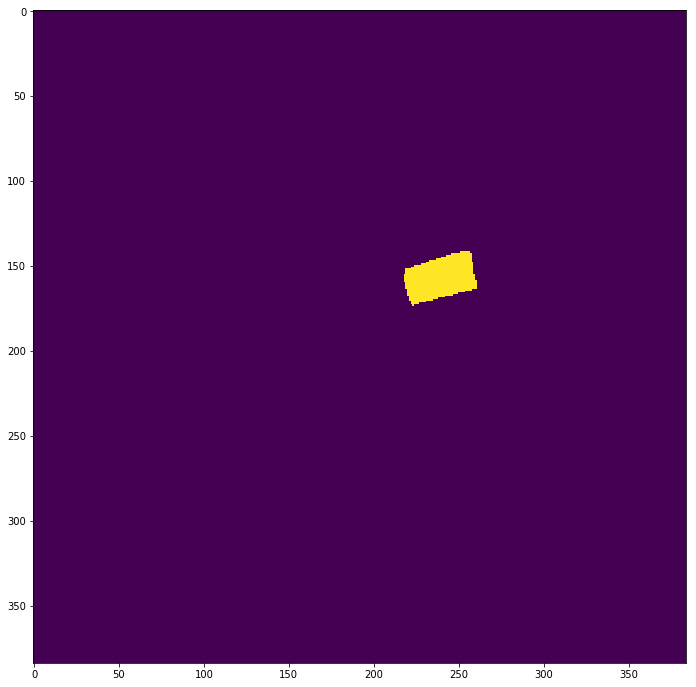

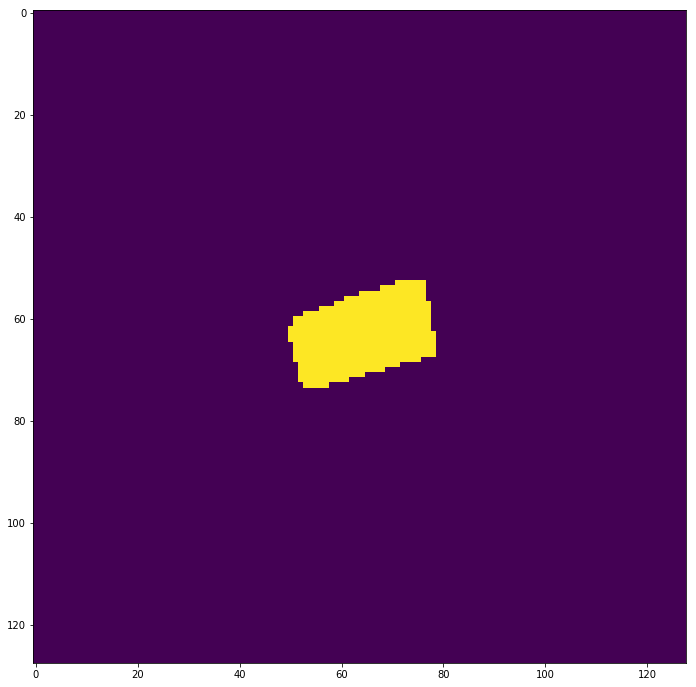

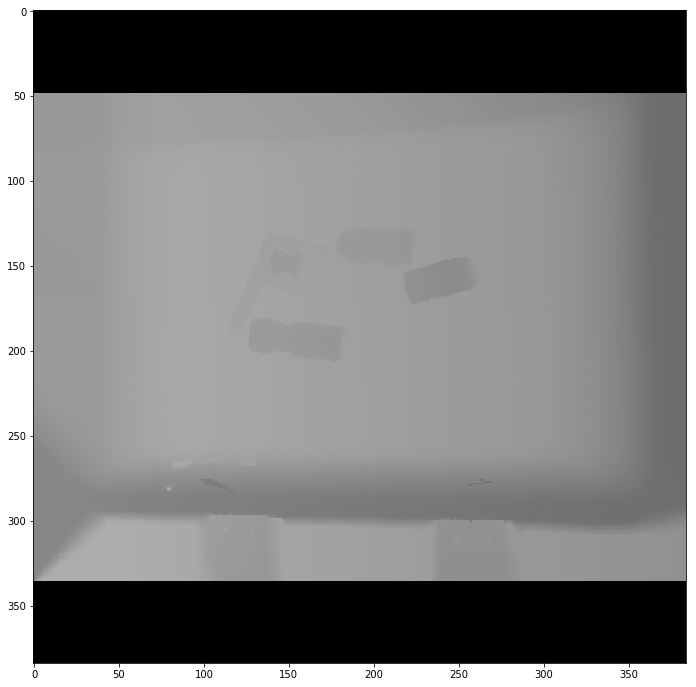

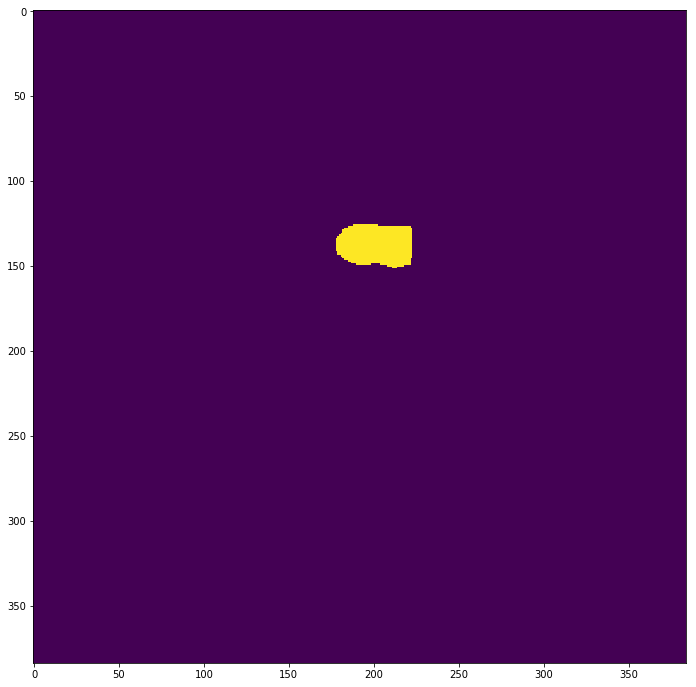

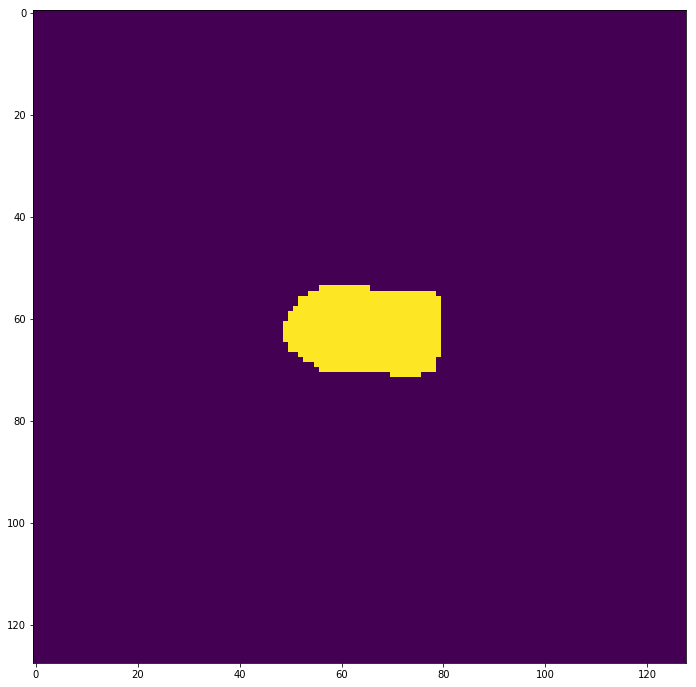

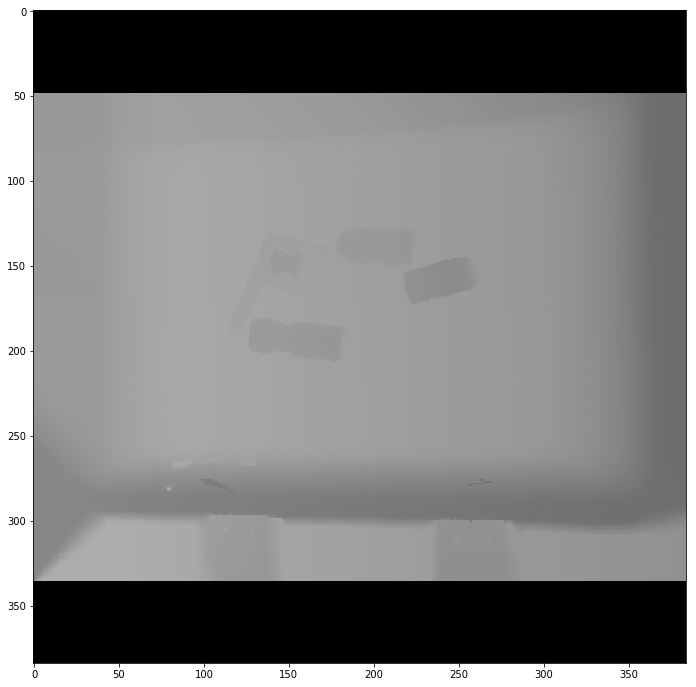

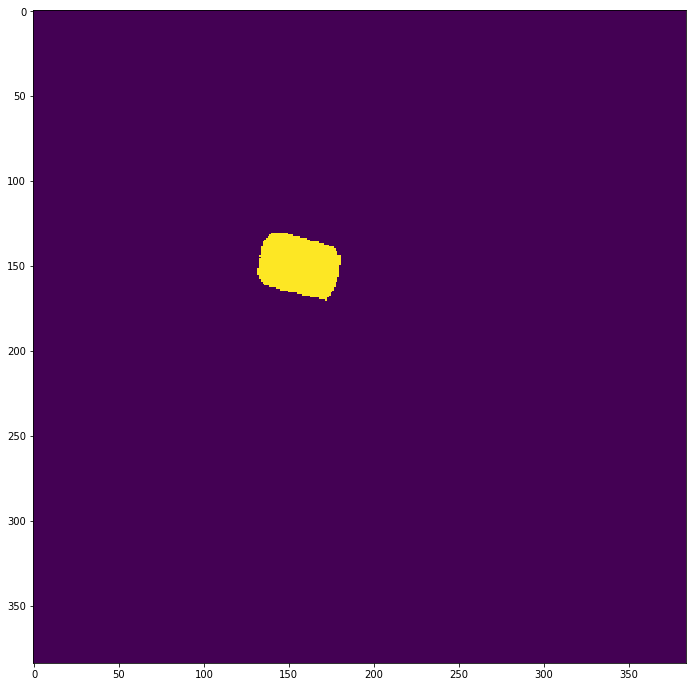

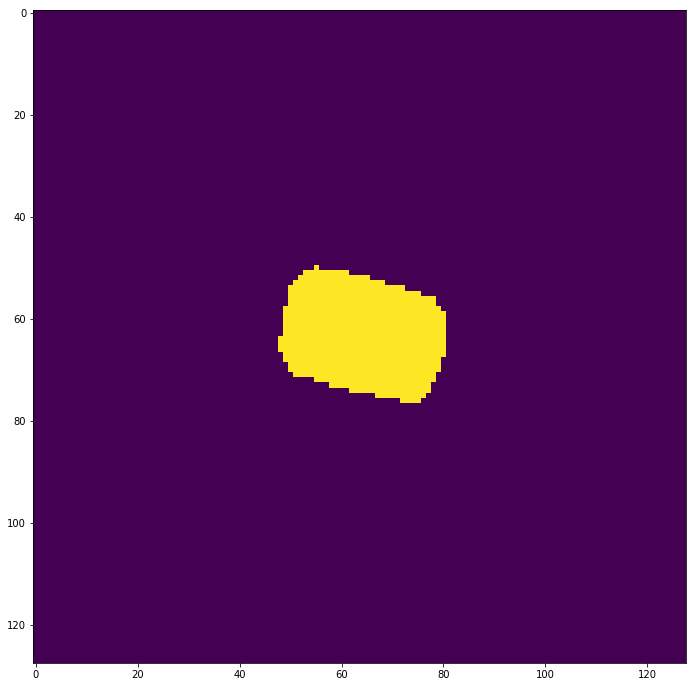

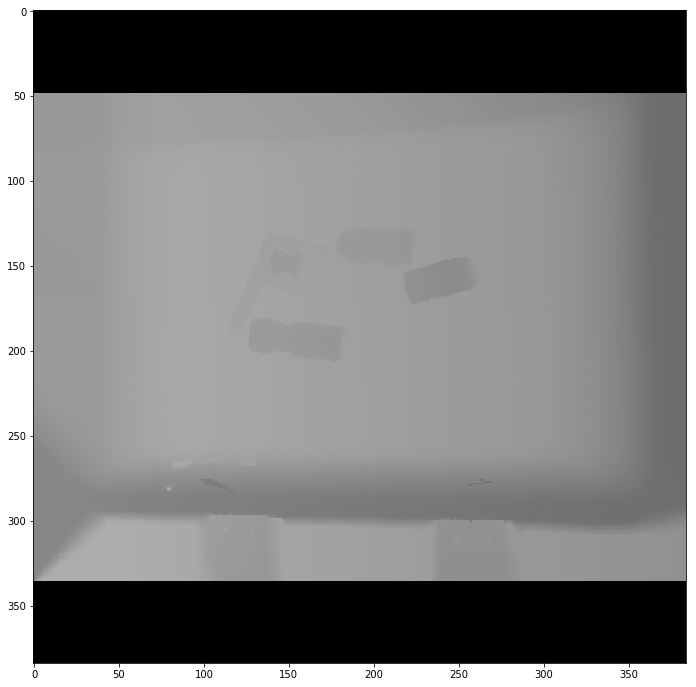

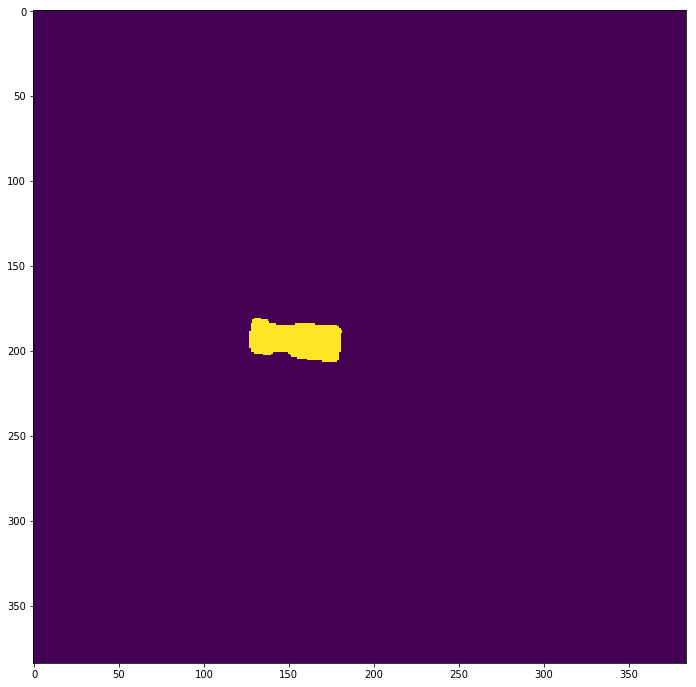

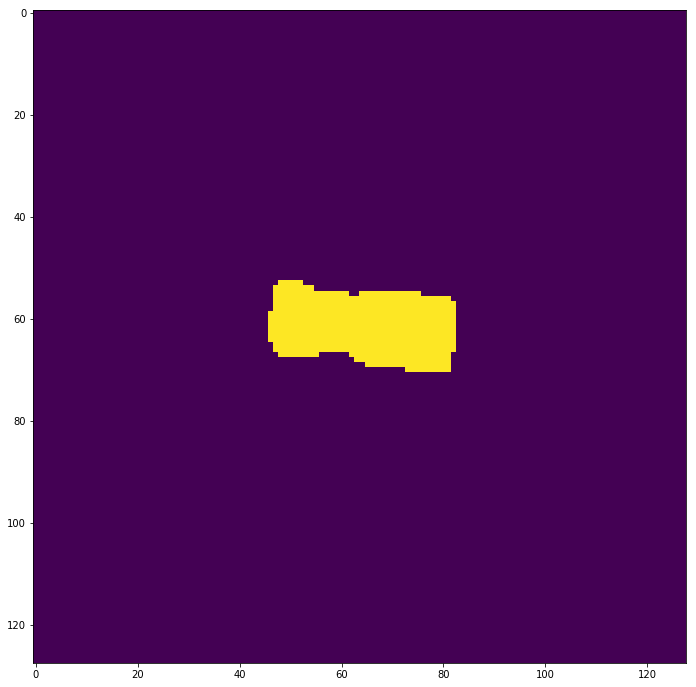

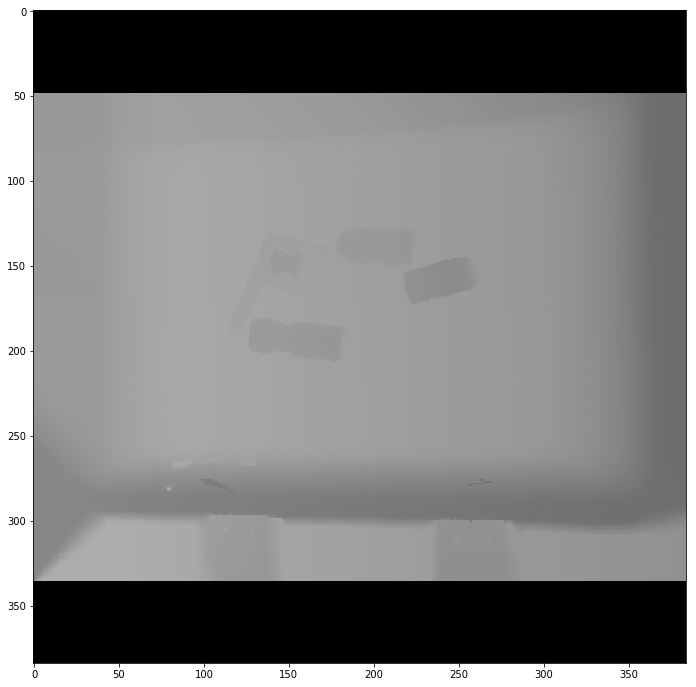

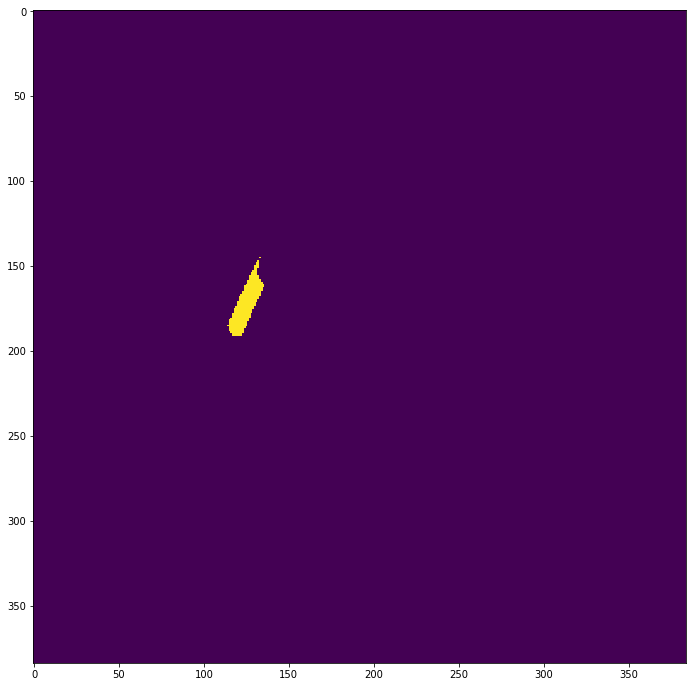

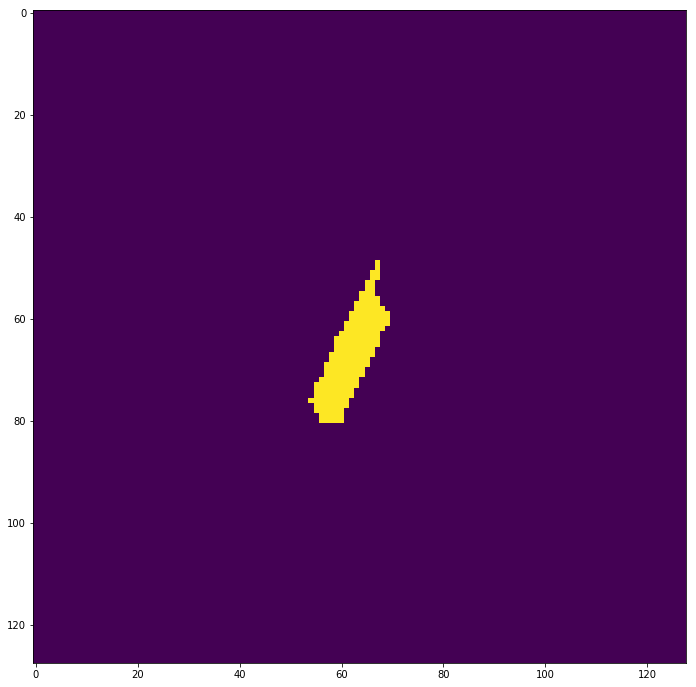

 63%|██████▎   | 19/30 [00:54<00:31,  2.90s/it]

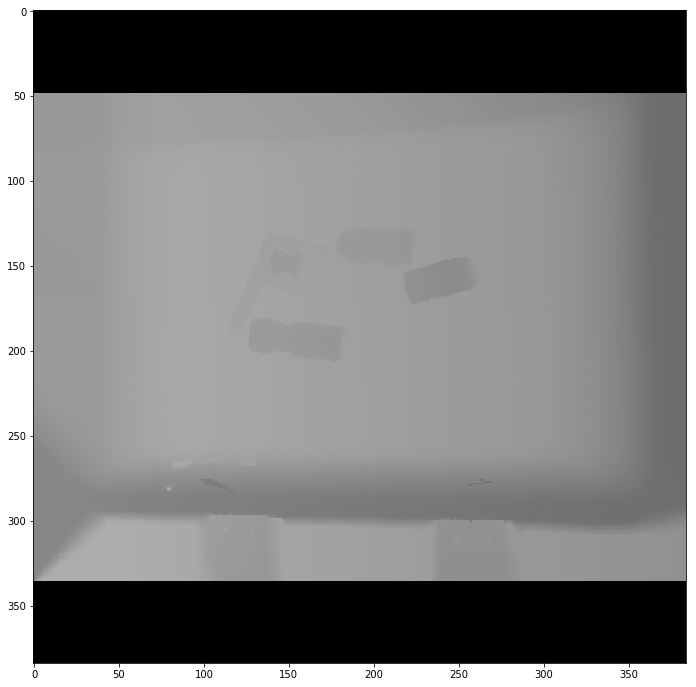

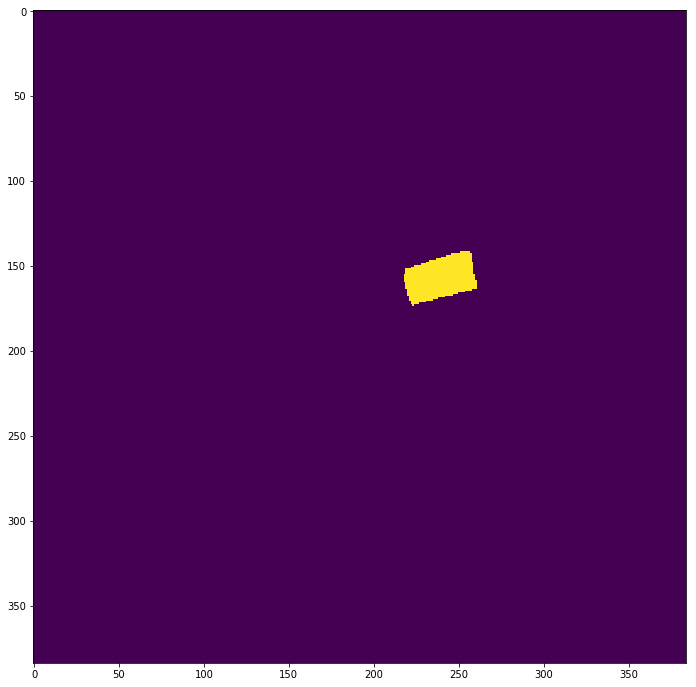

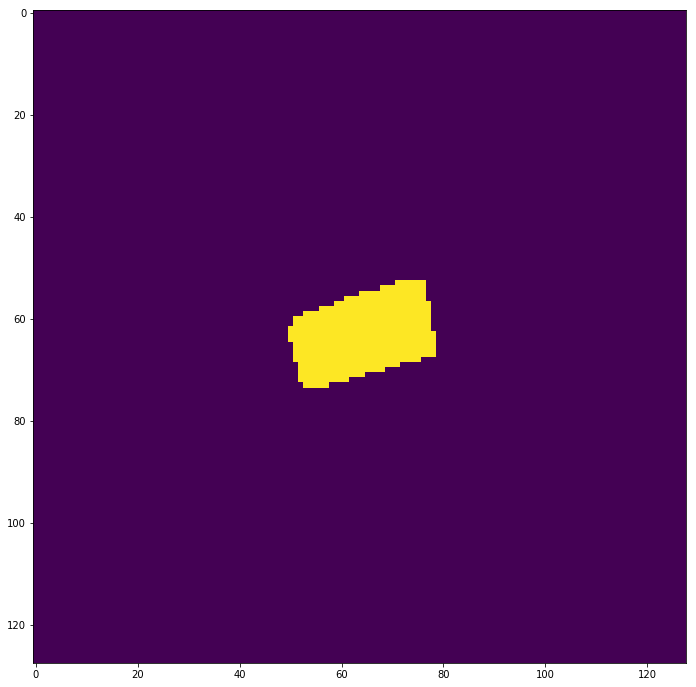

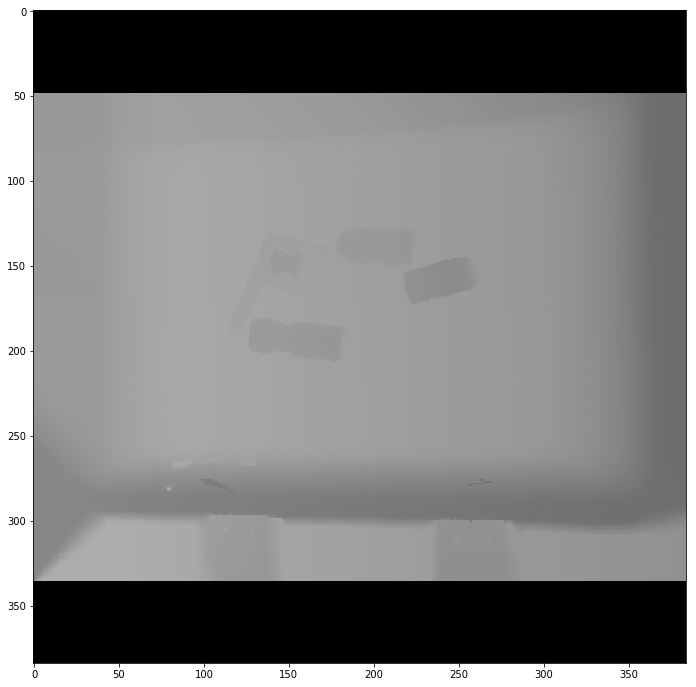

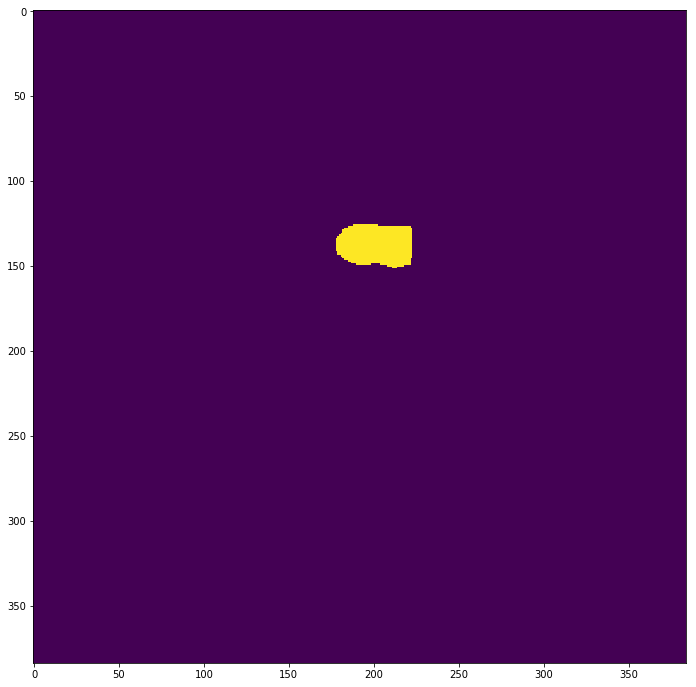

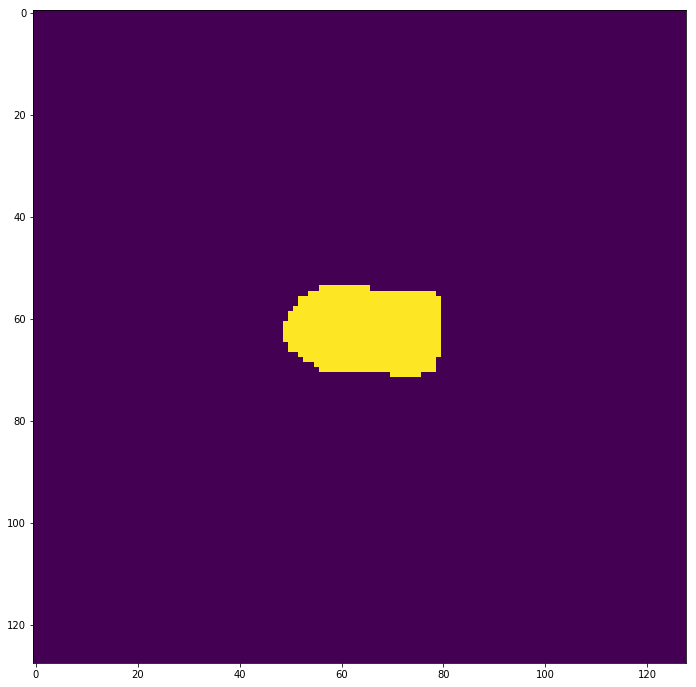

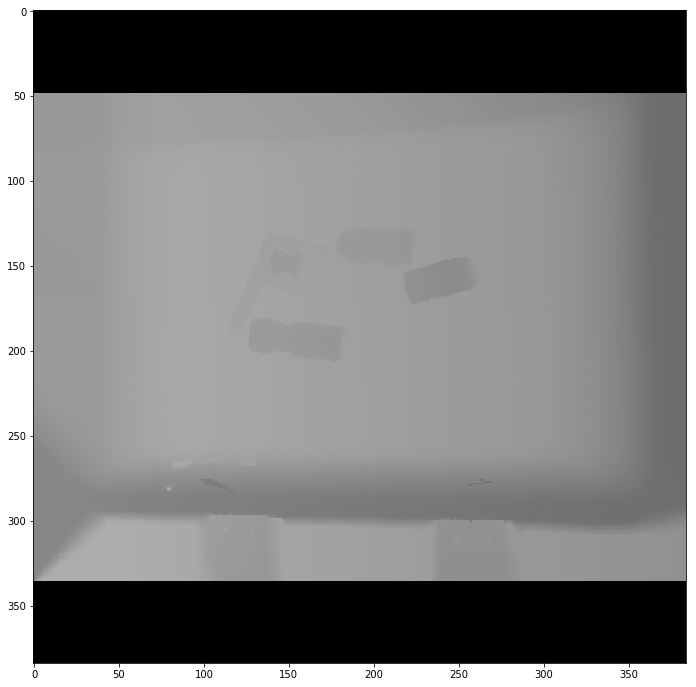

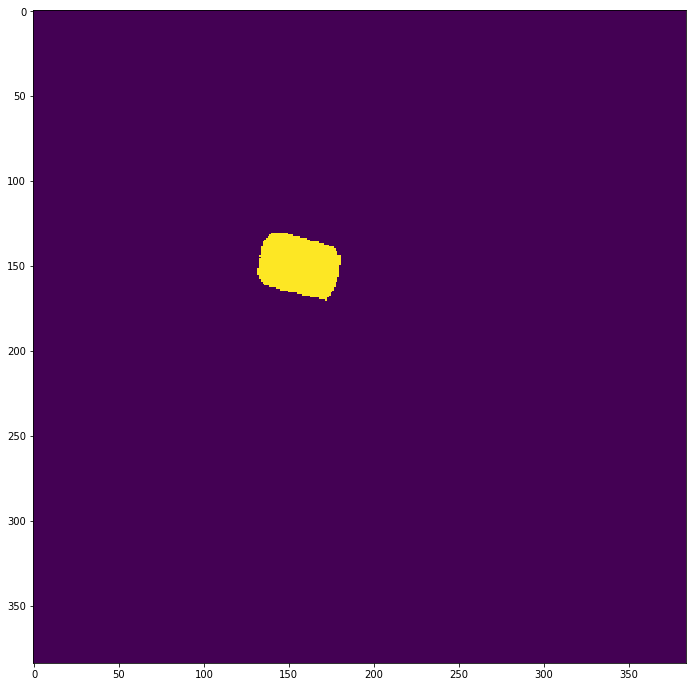

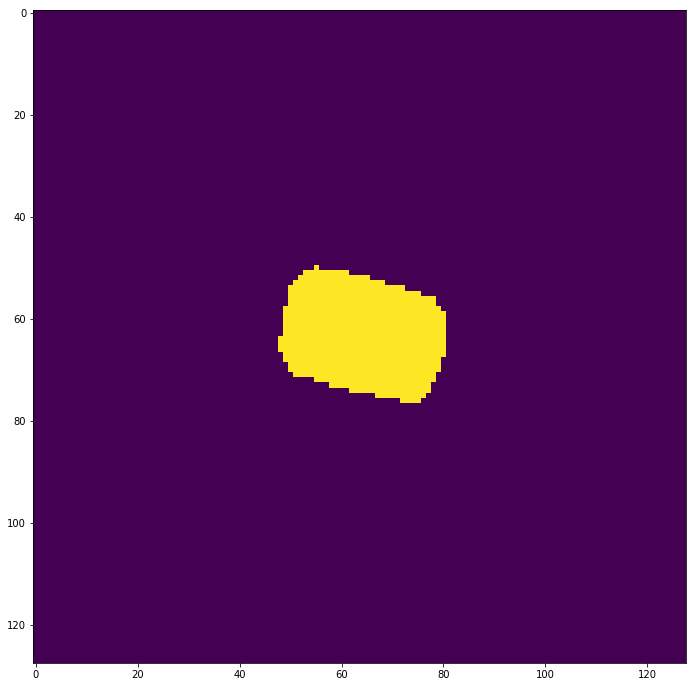

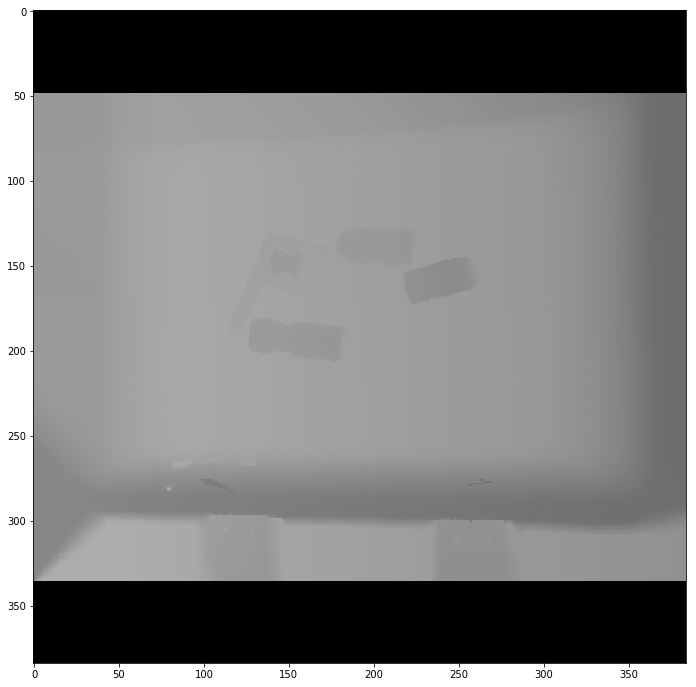

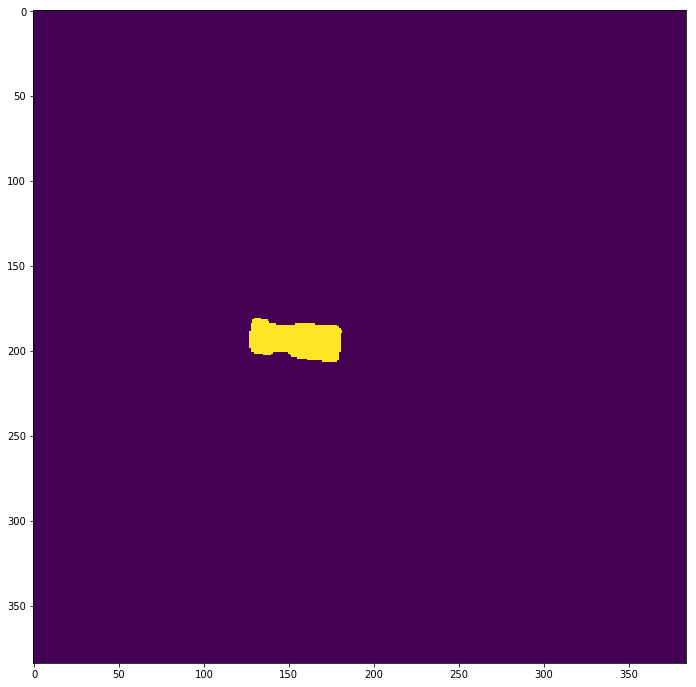

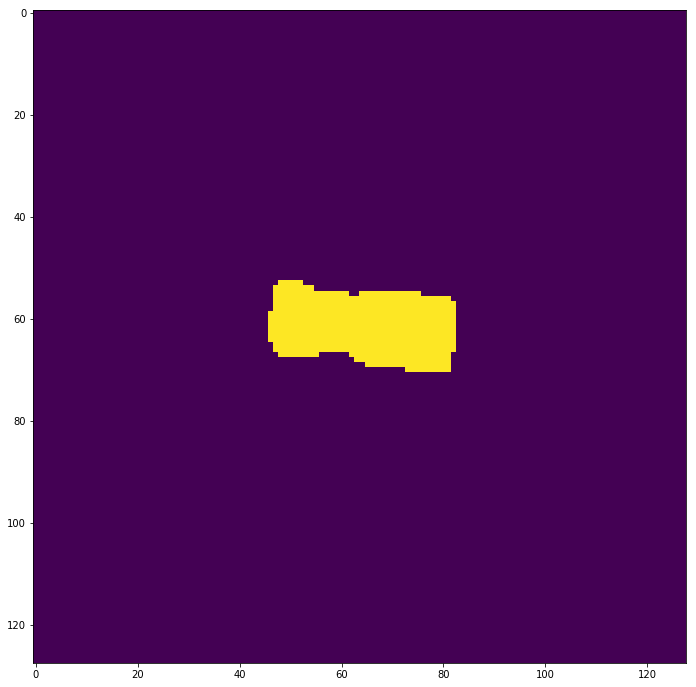

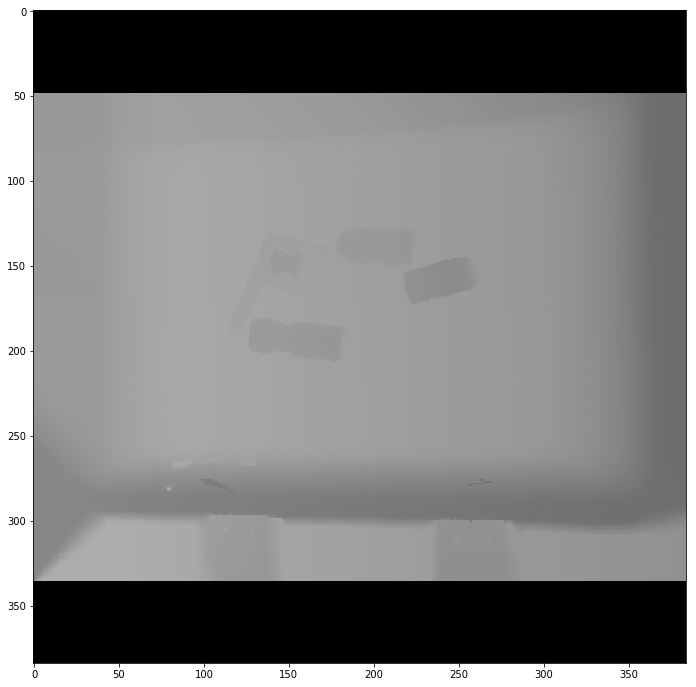

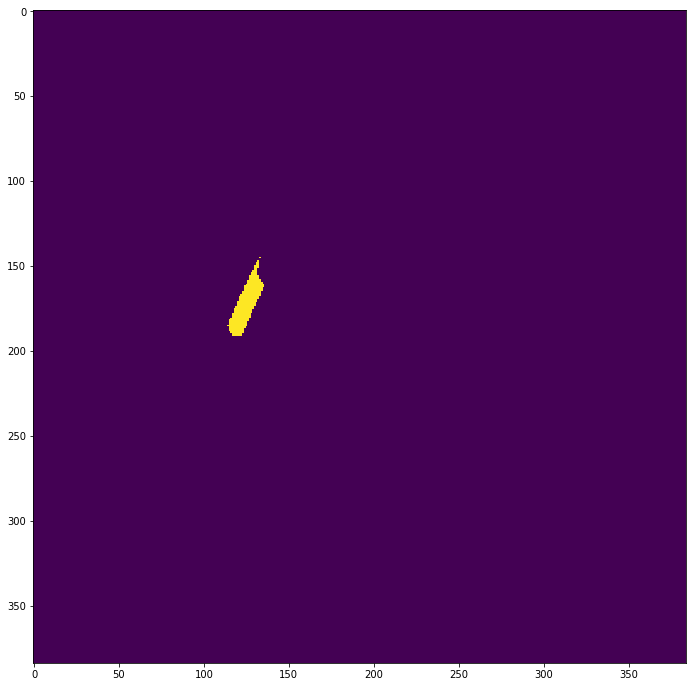

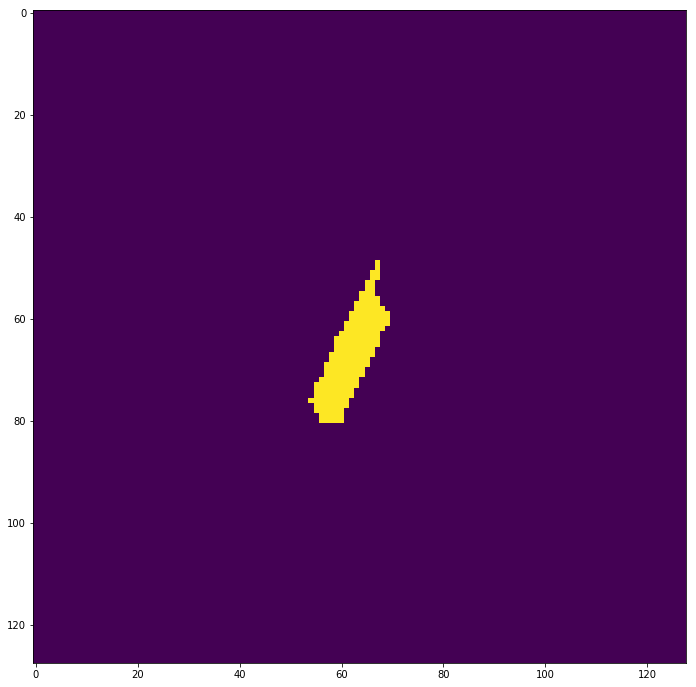

 67%|██████▋   | 20/30 [00:57<00:28,  2.89s/it]

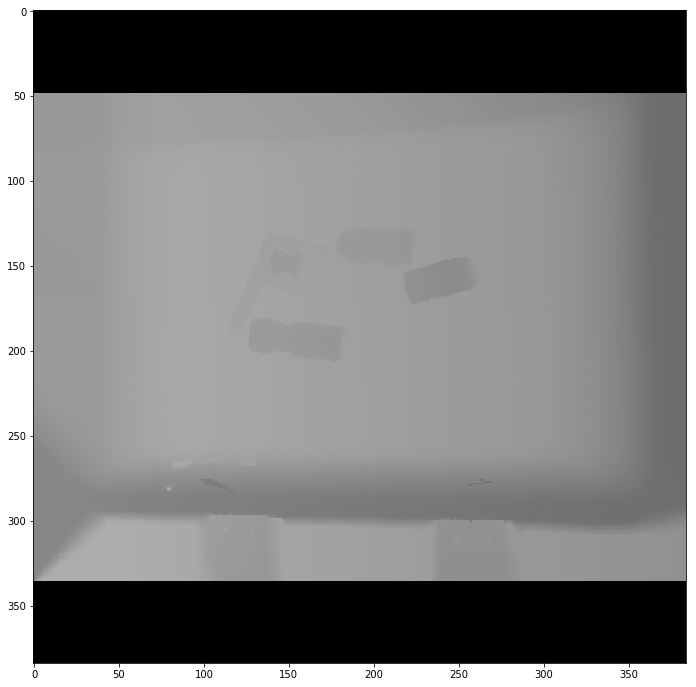

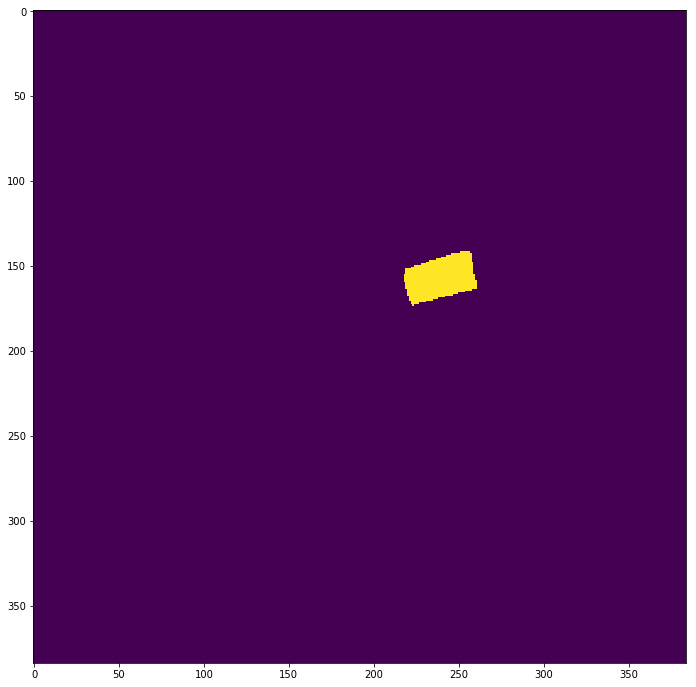

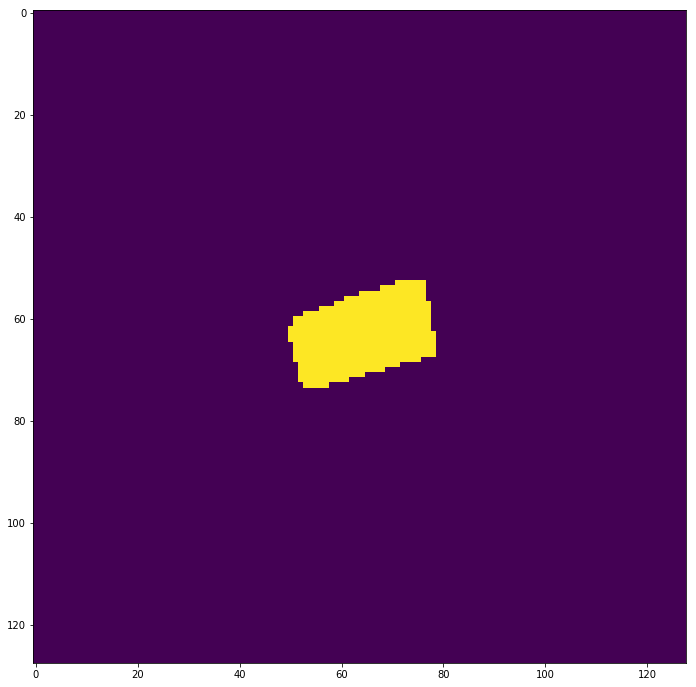

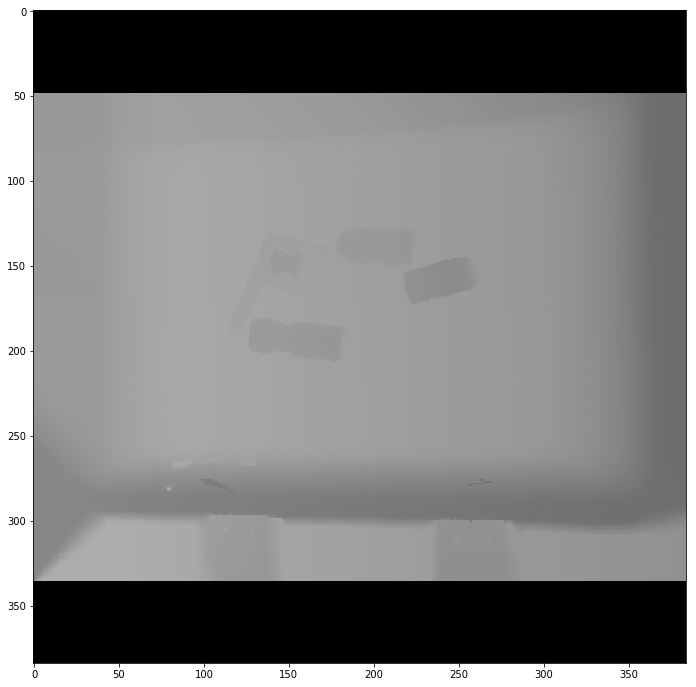

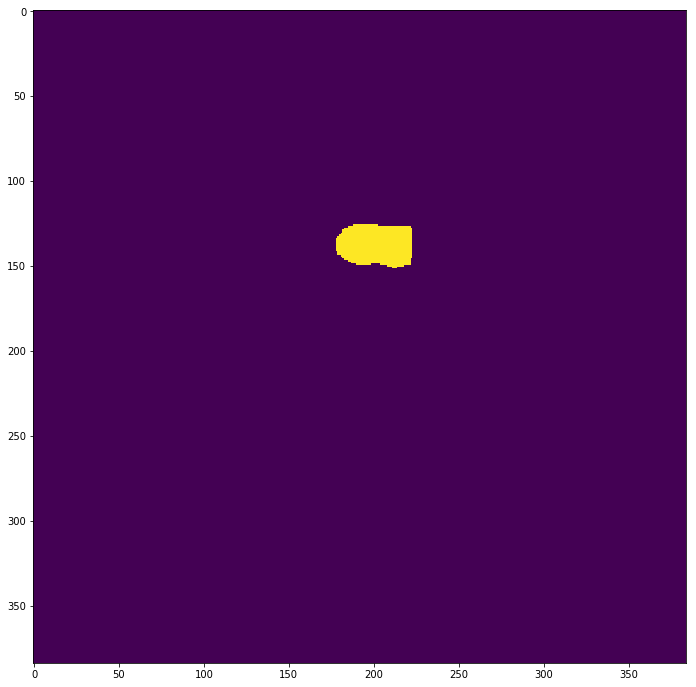

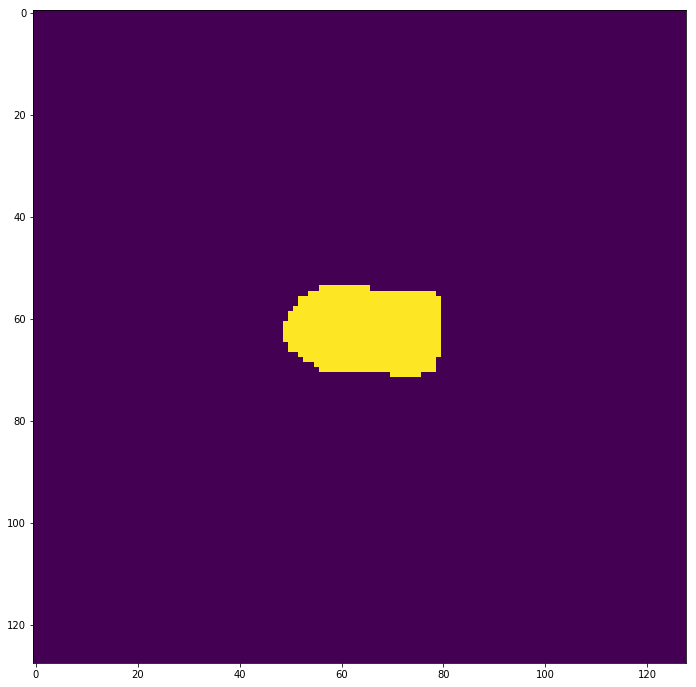

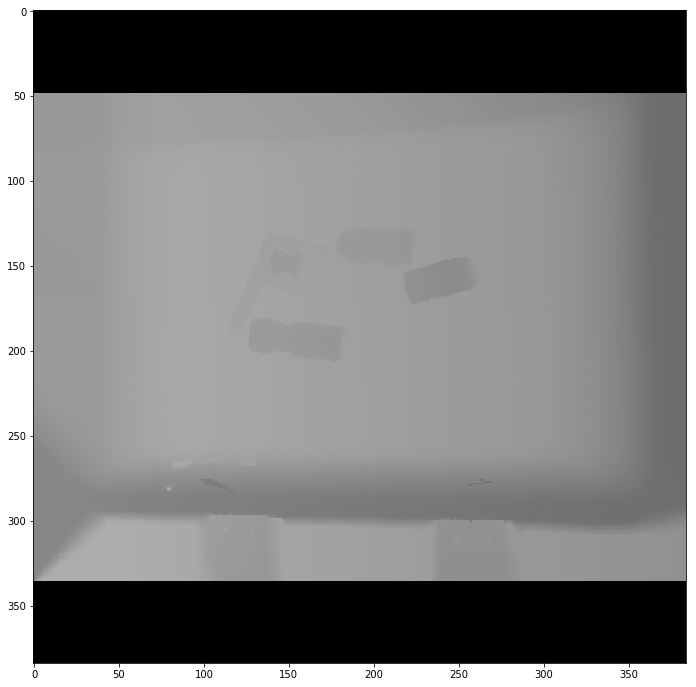

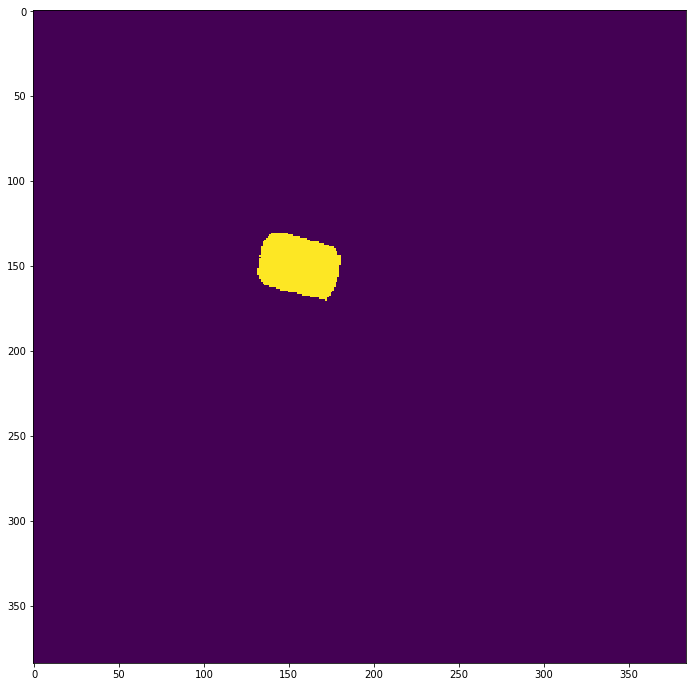

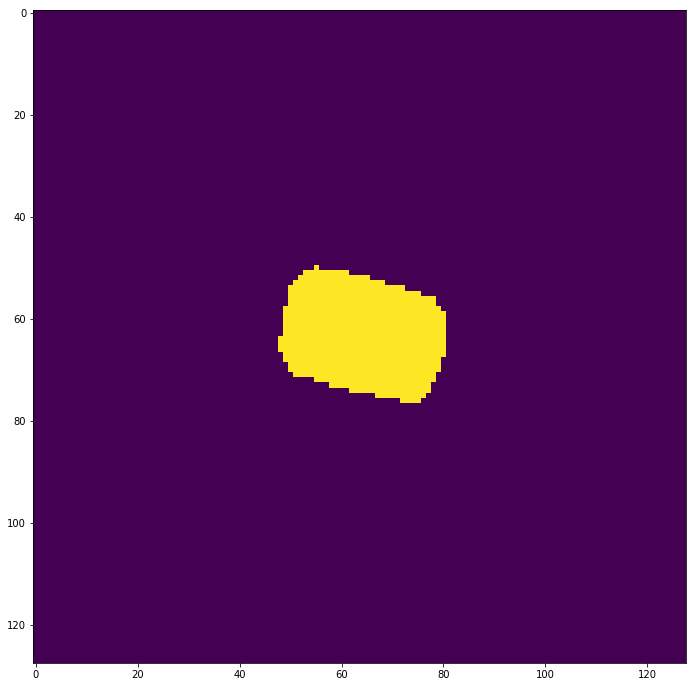

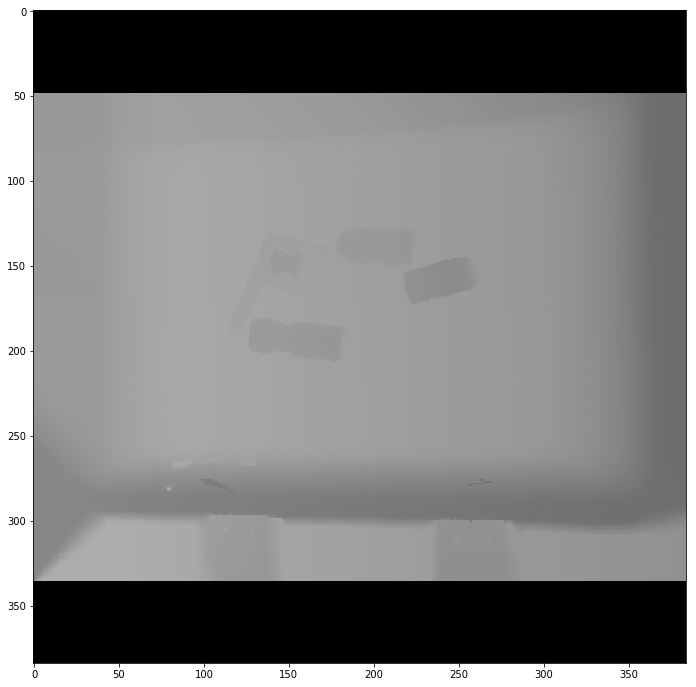

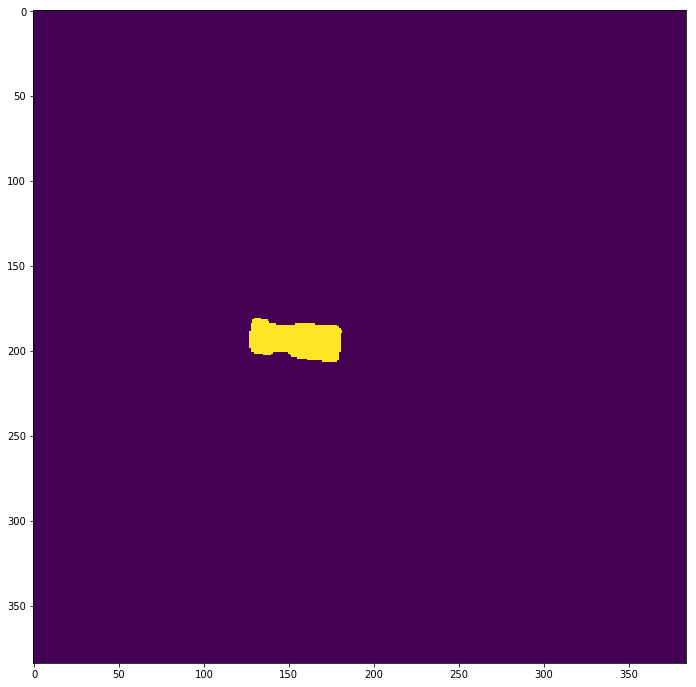

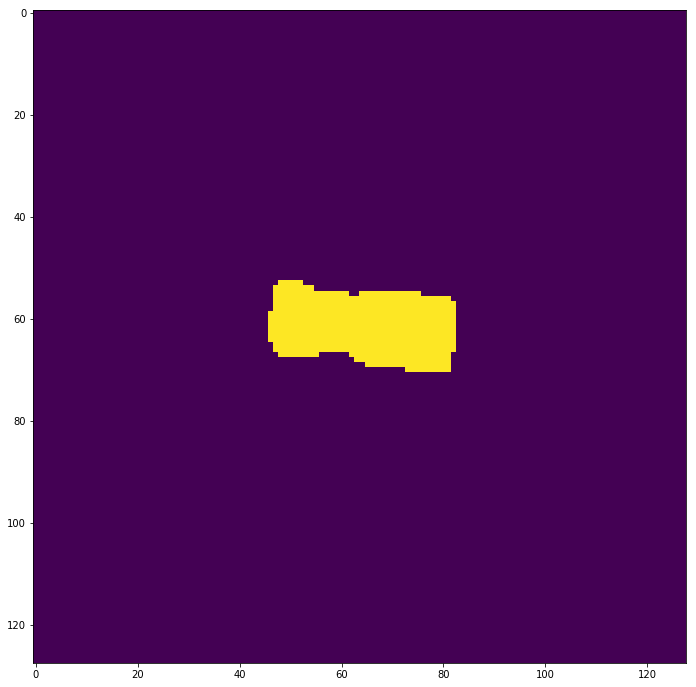

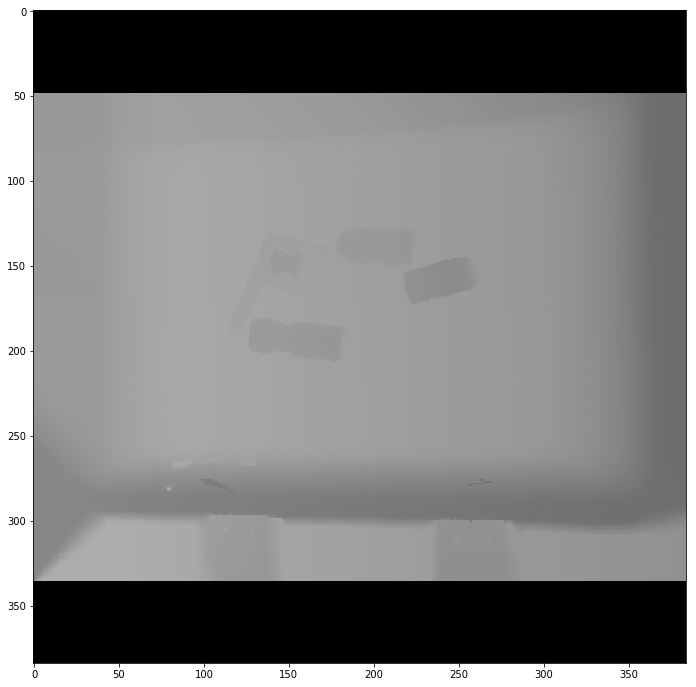

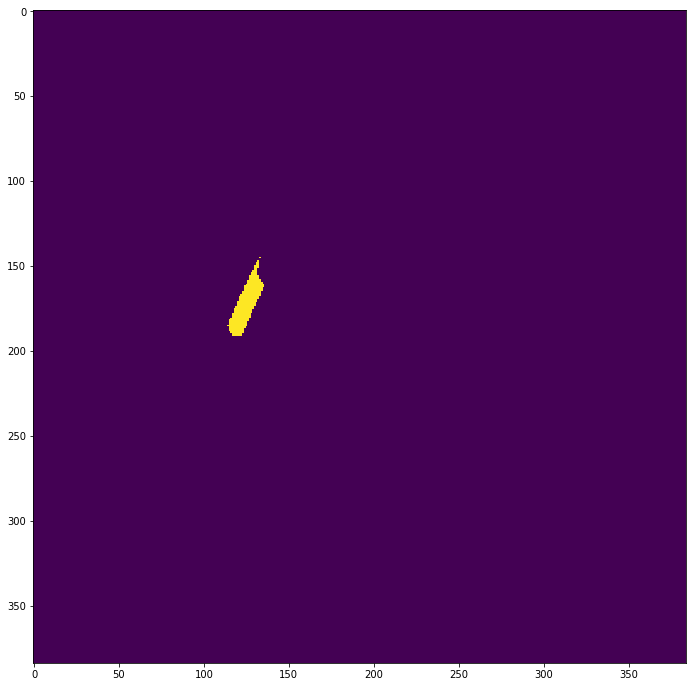

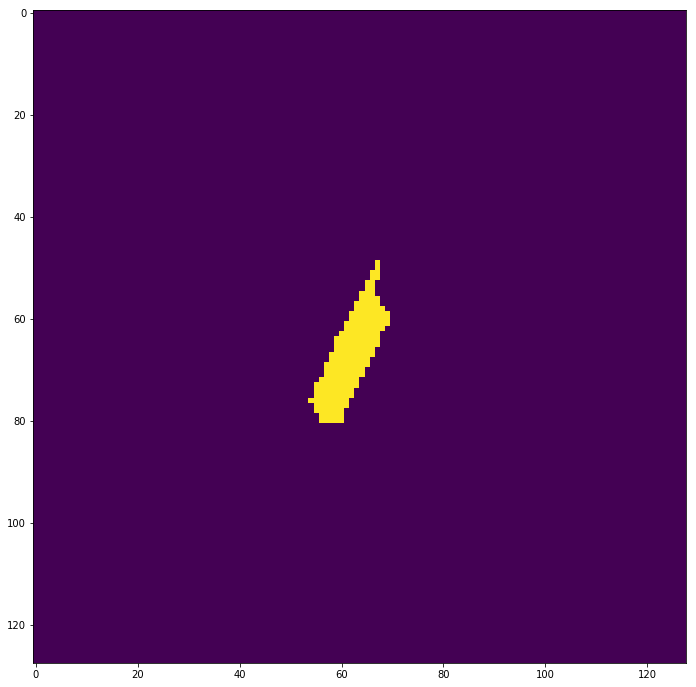

 70%|███████   | 21/30 [01:00<00:26,  2.90s/it]

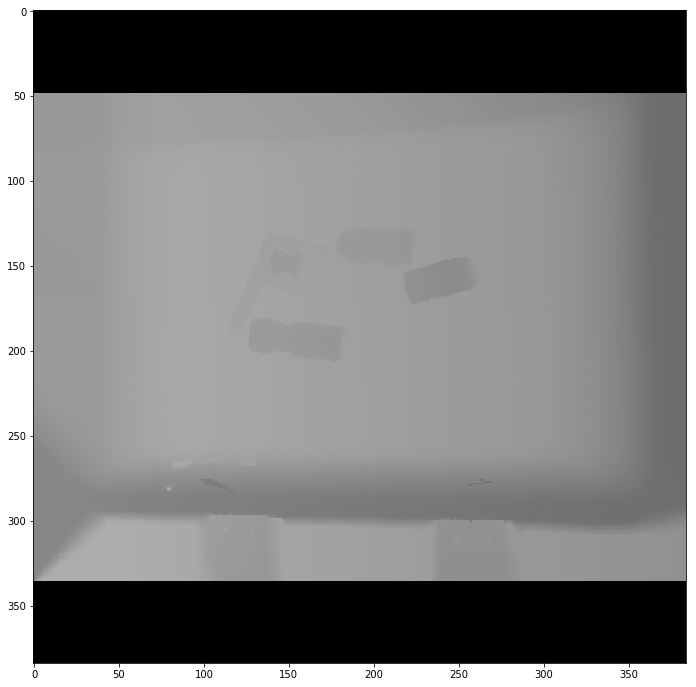

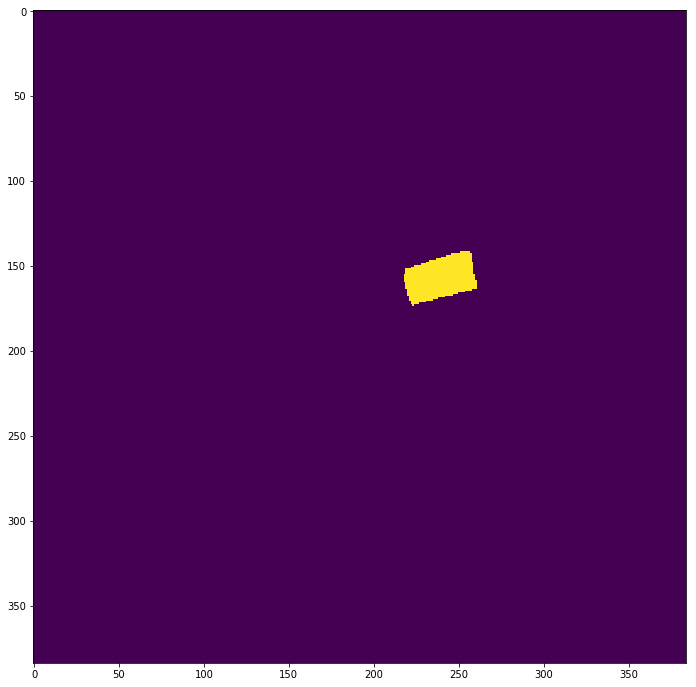

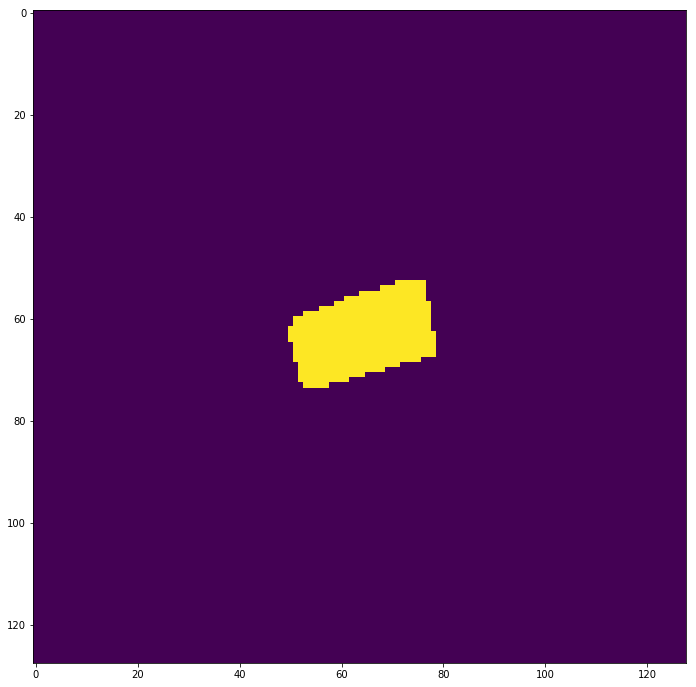

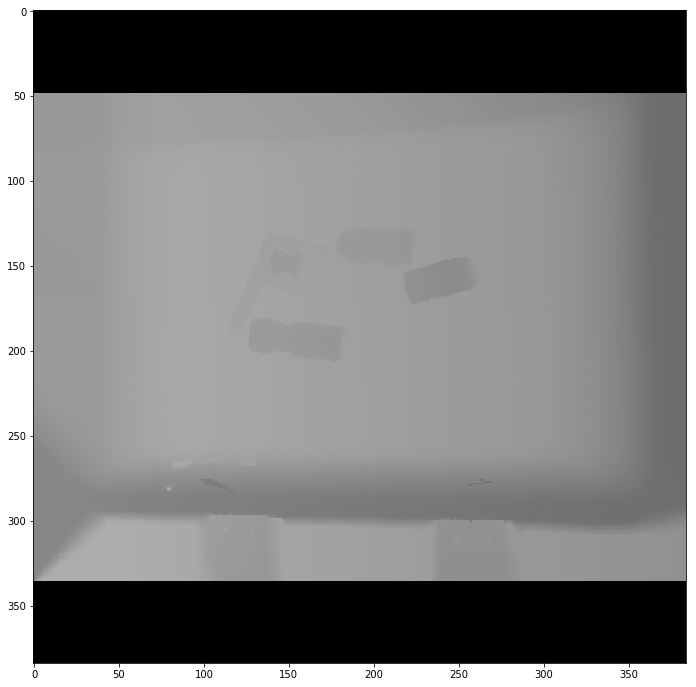

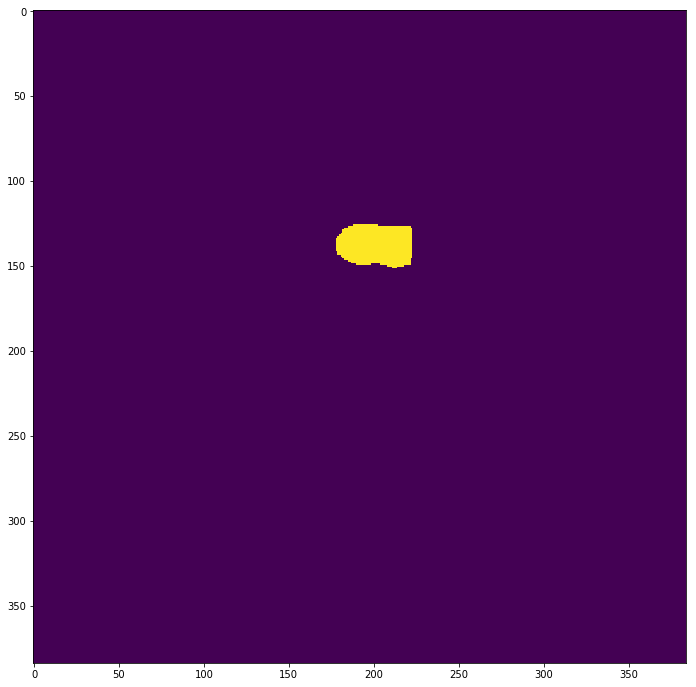

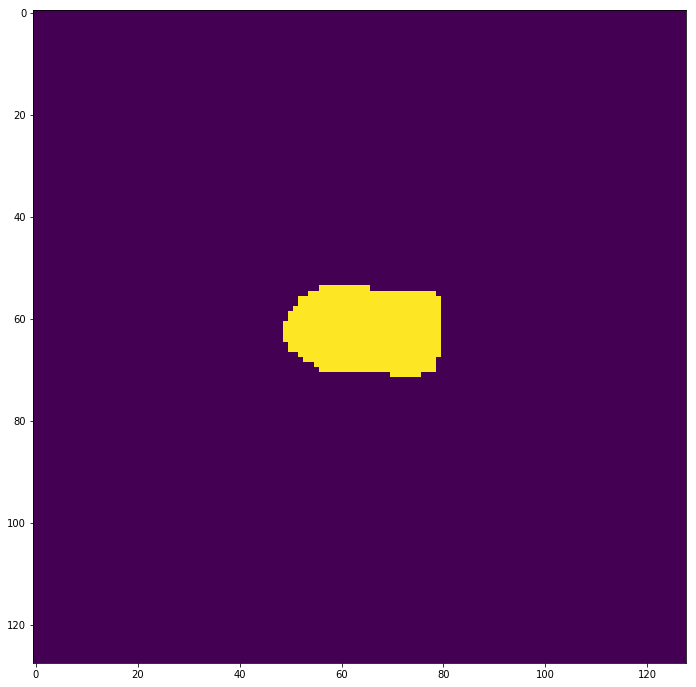

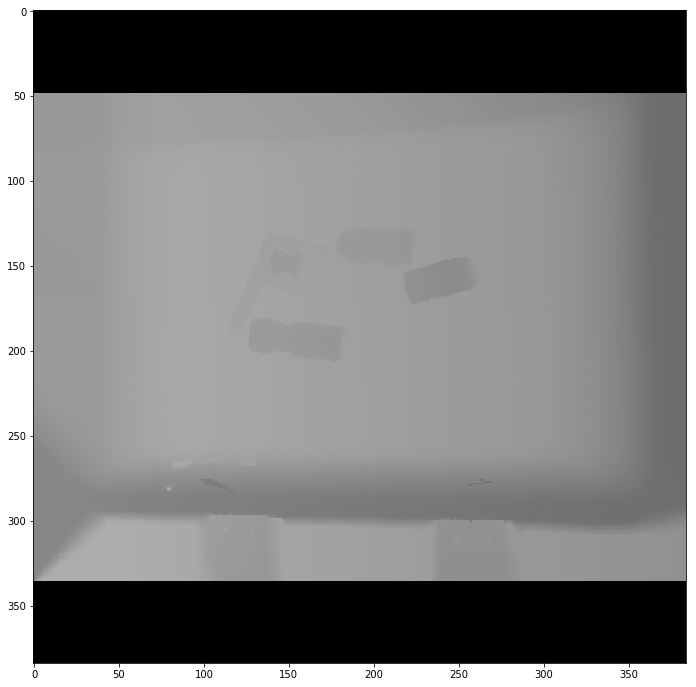

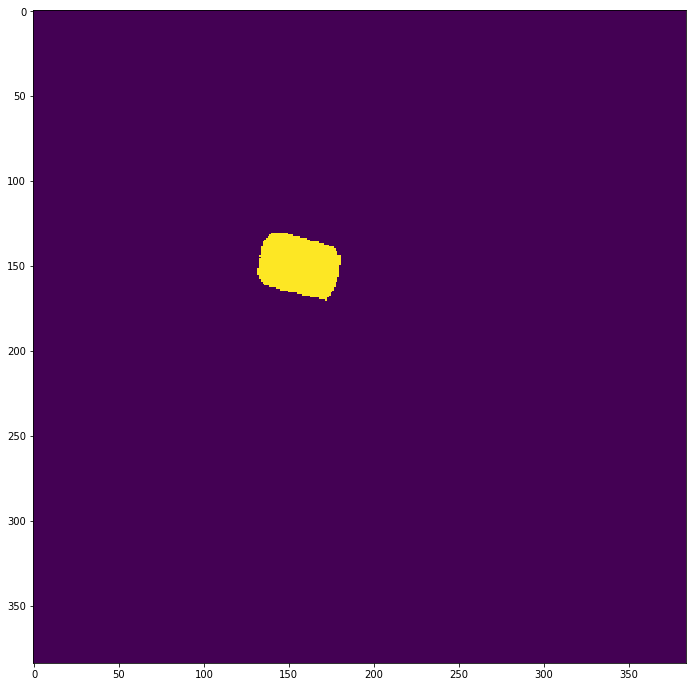

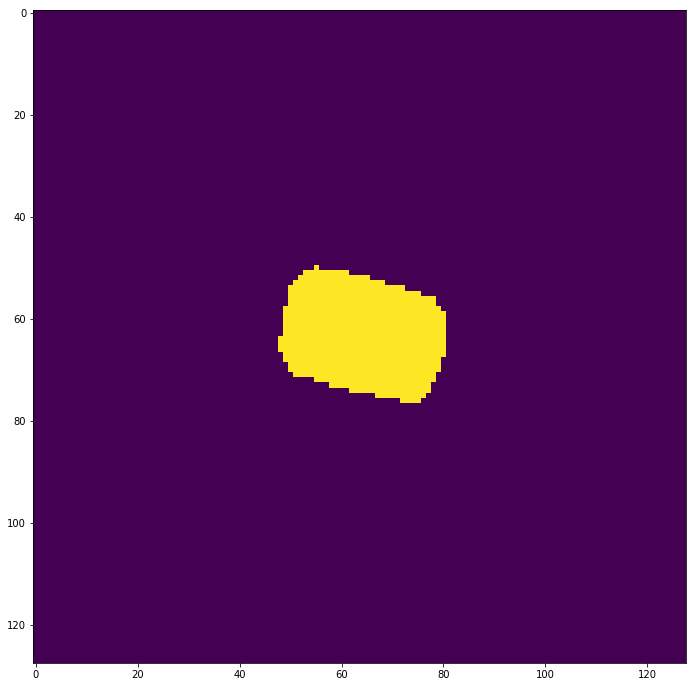

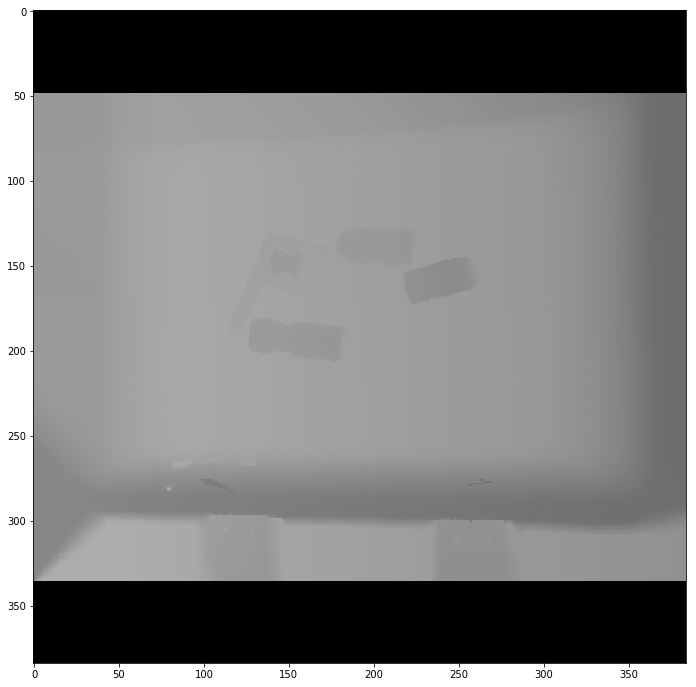

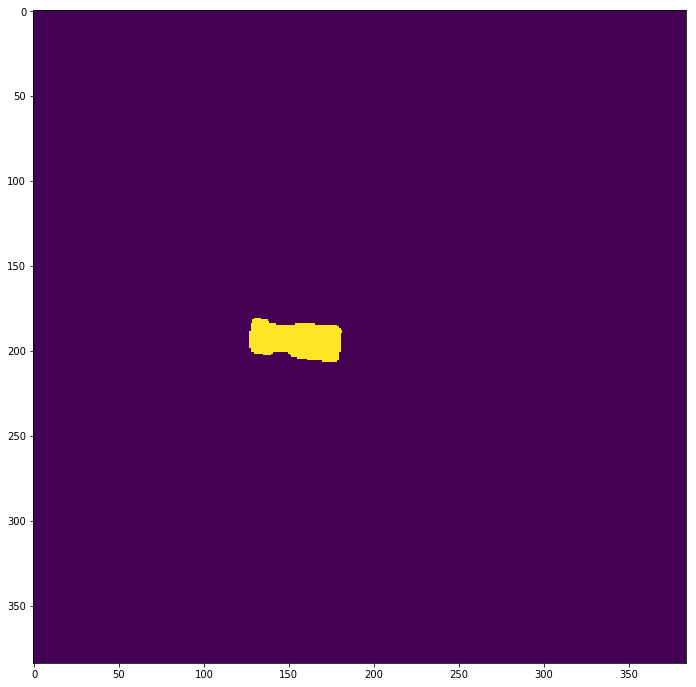

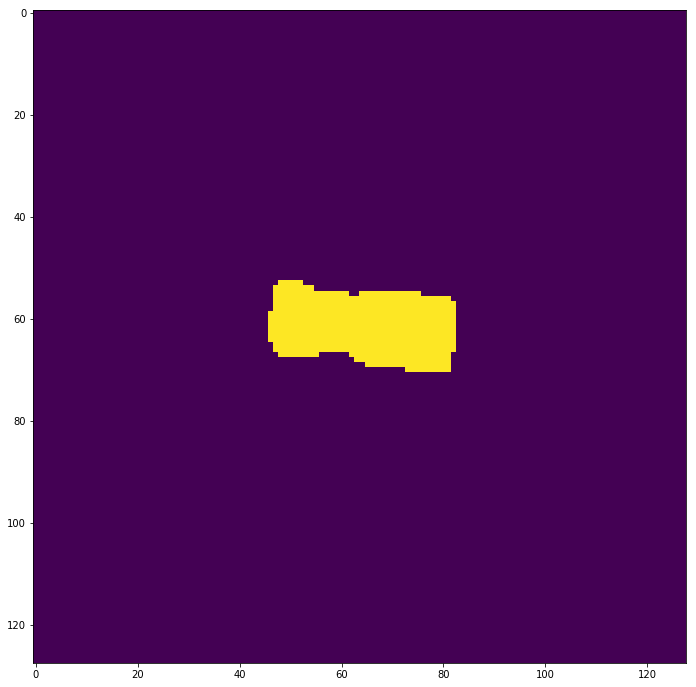

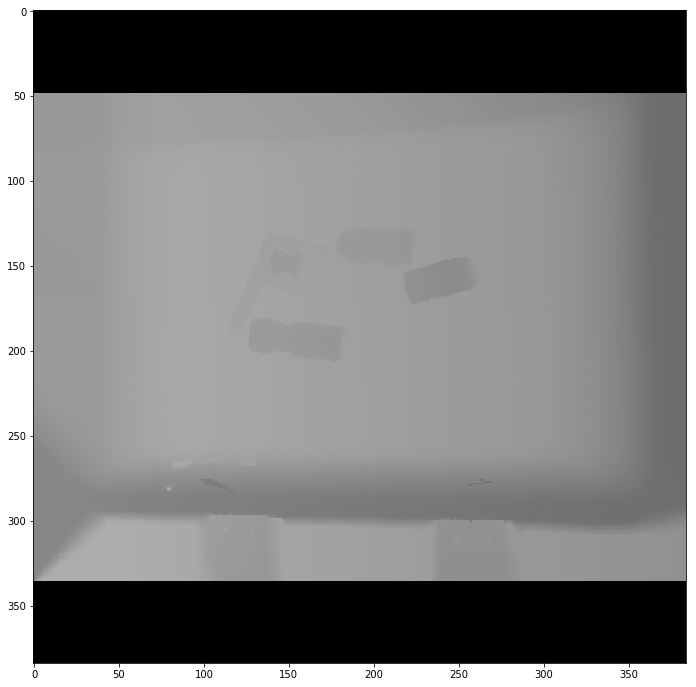

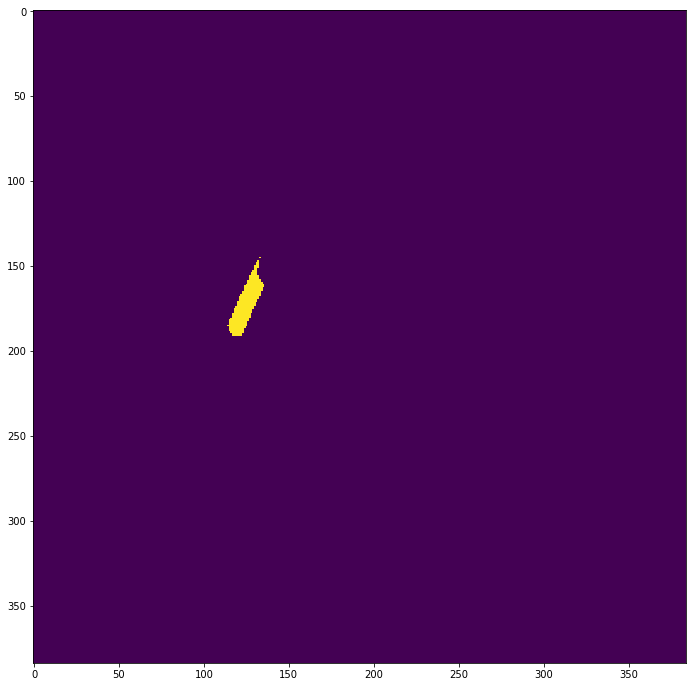

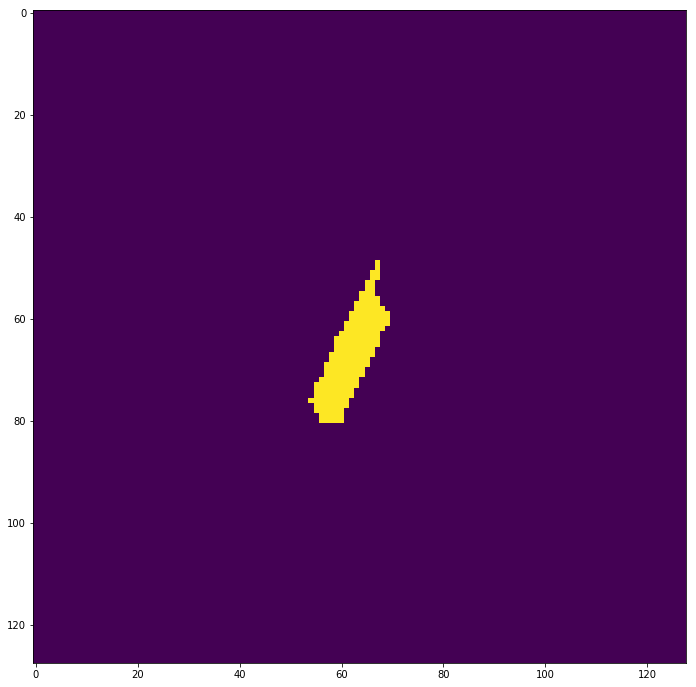

 73%|███████▎  | 22/30 [01:03<00:23,  2.90s/it]

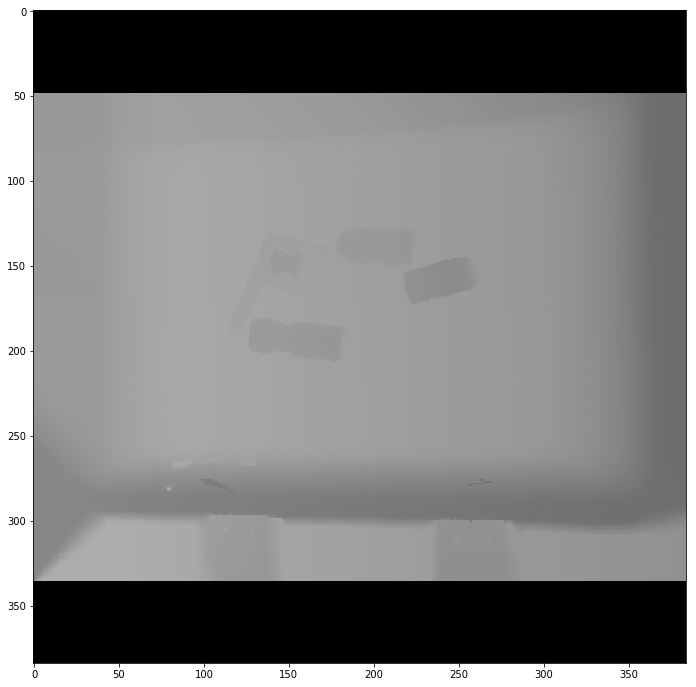

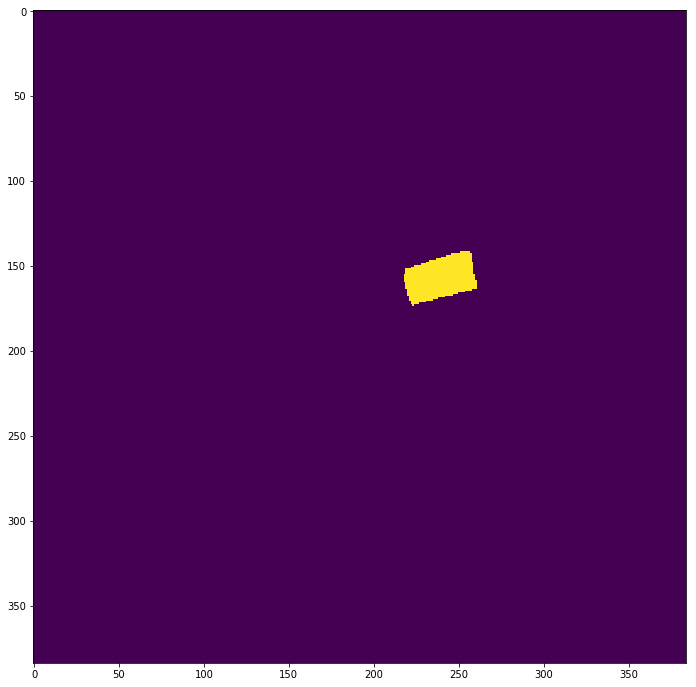

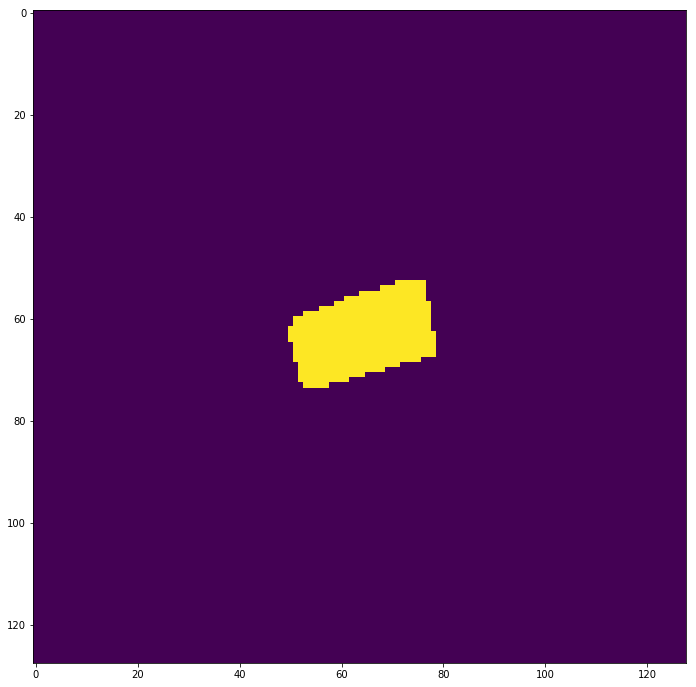

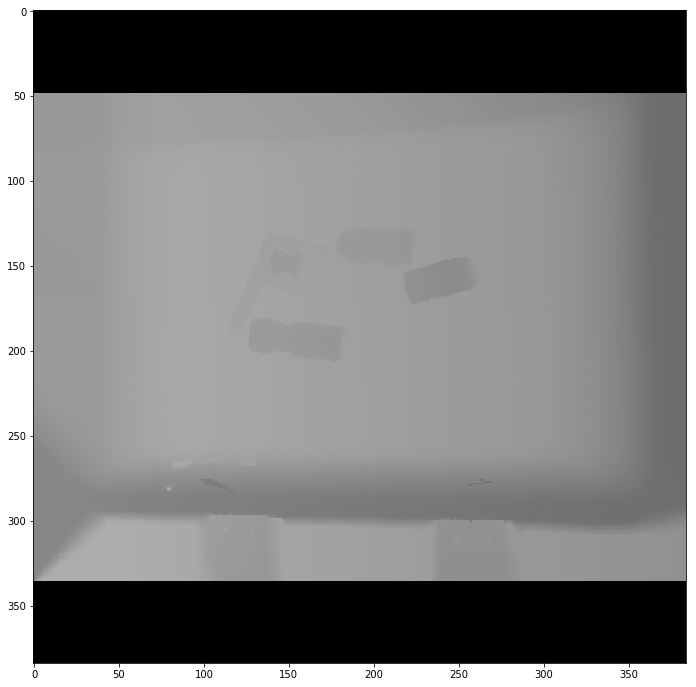

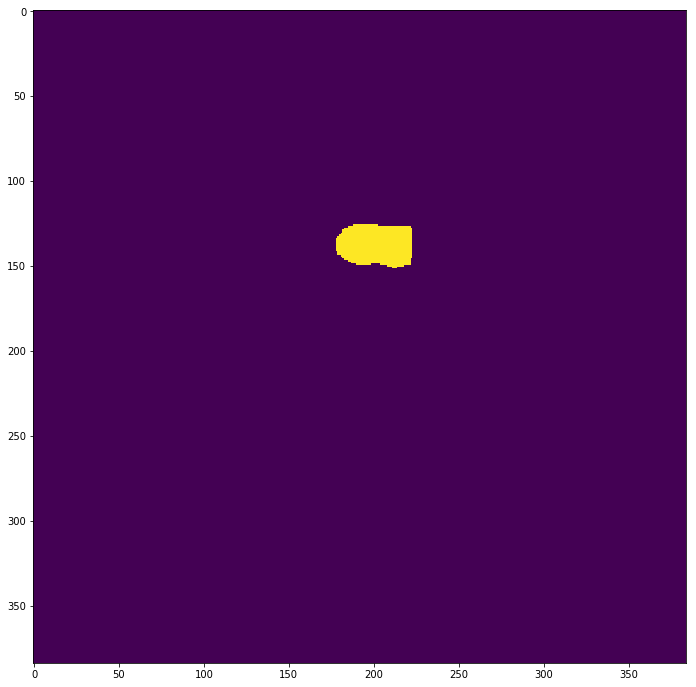

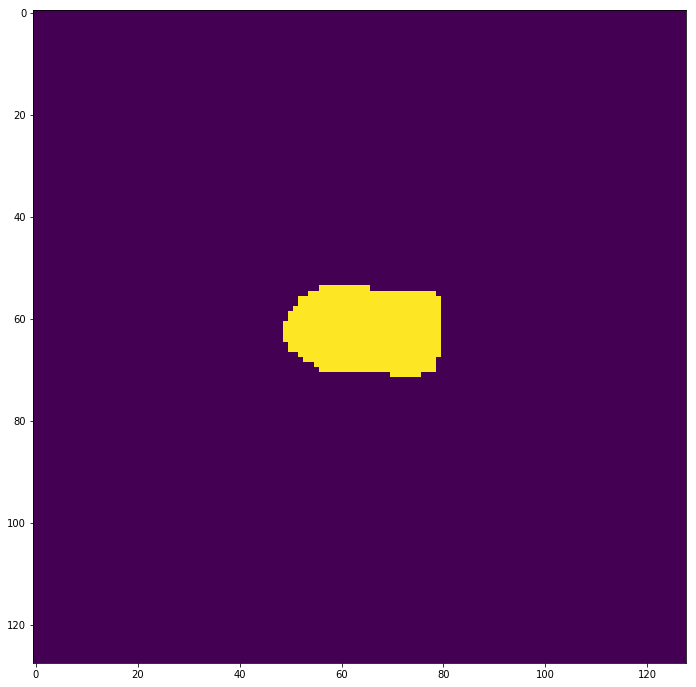

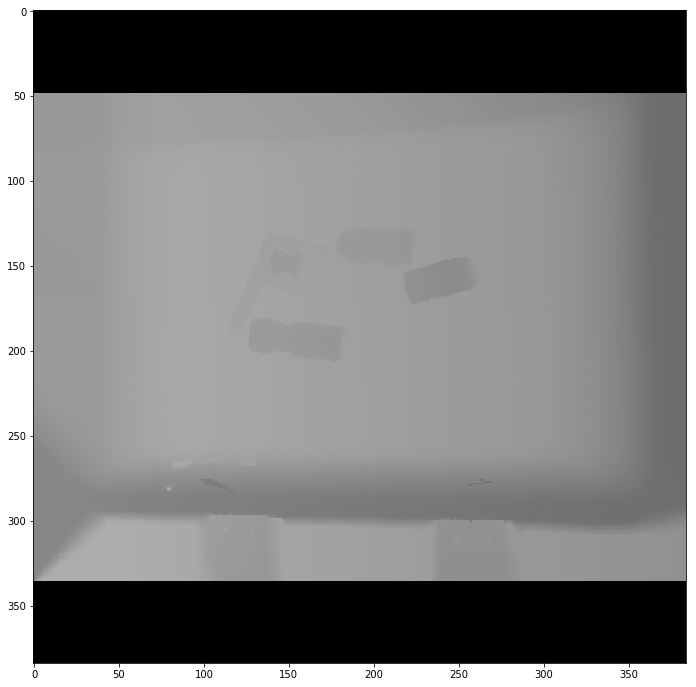

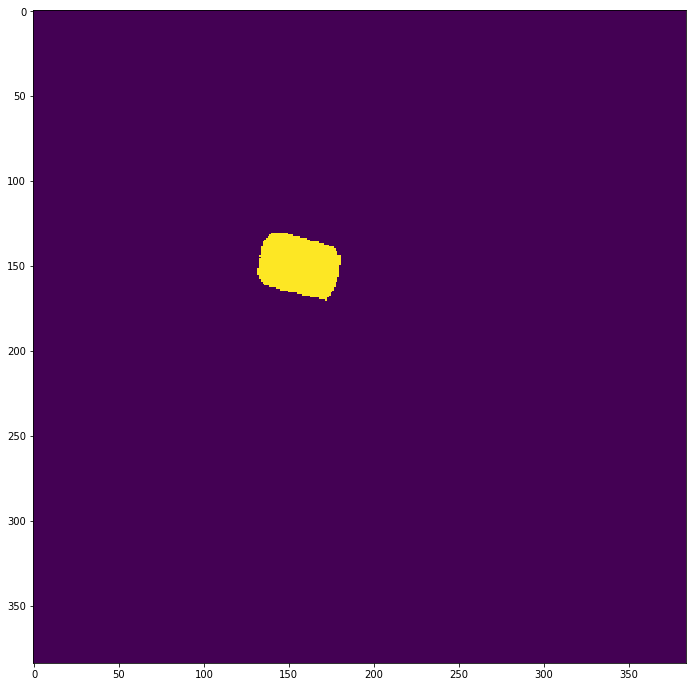

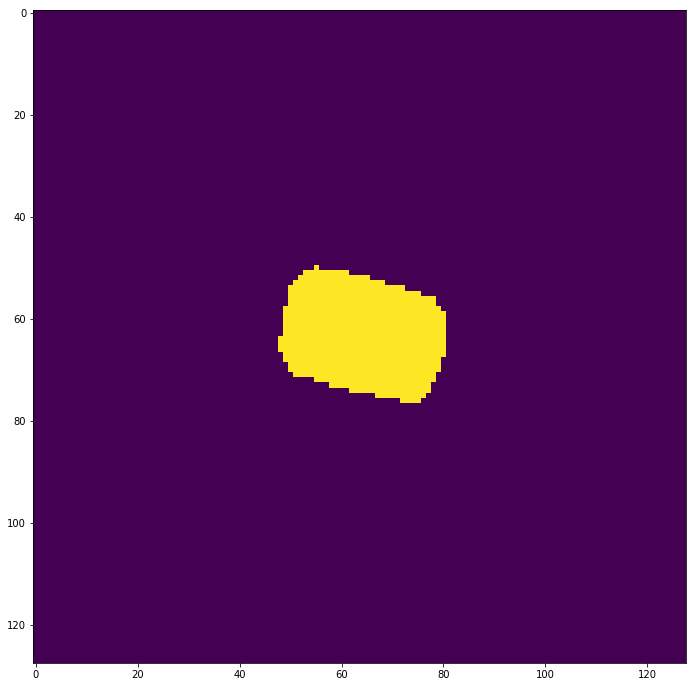

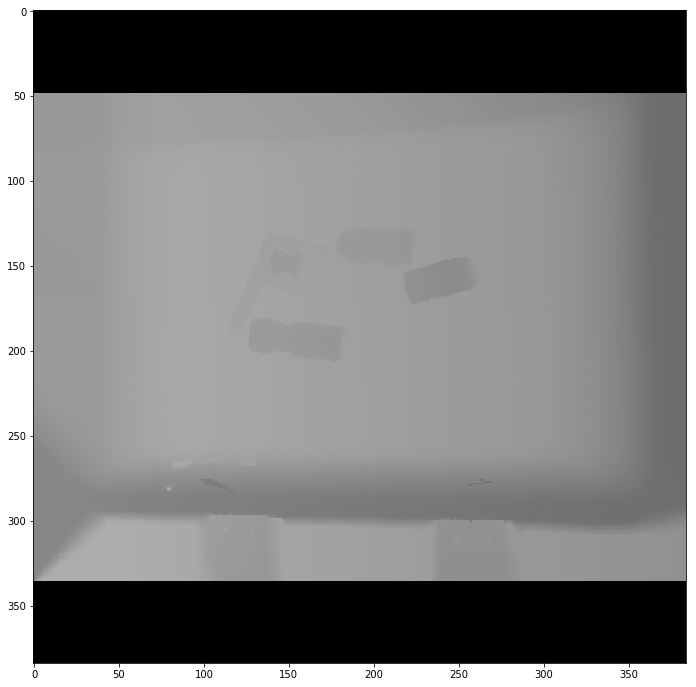

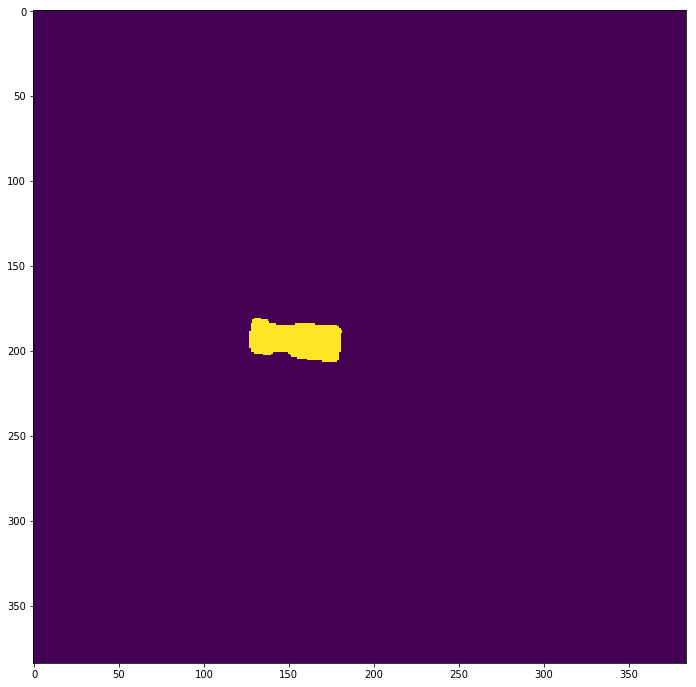

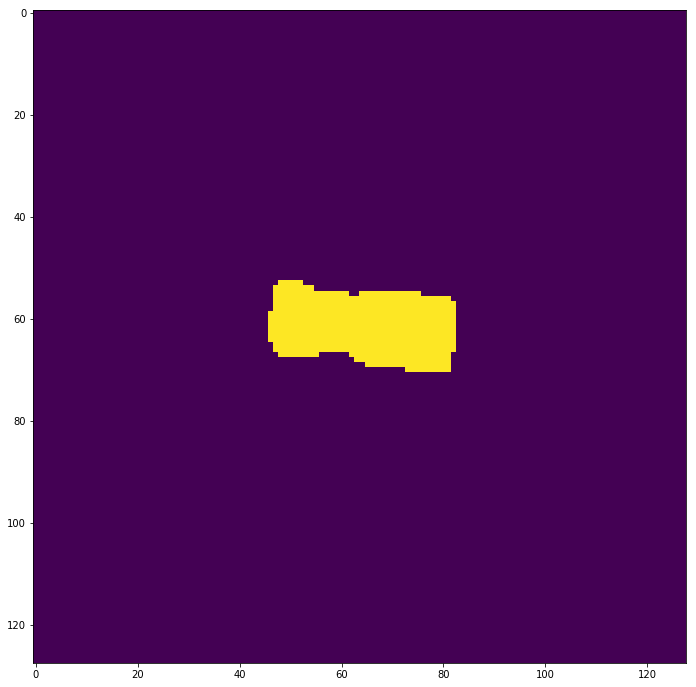

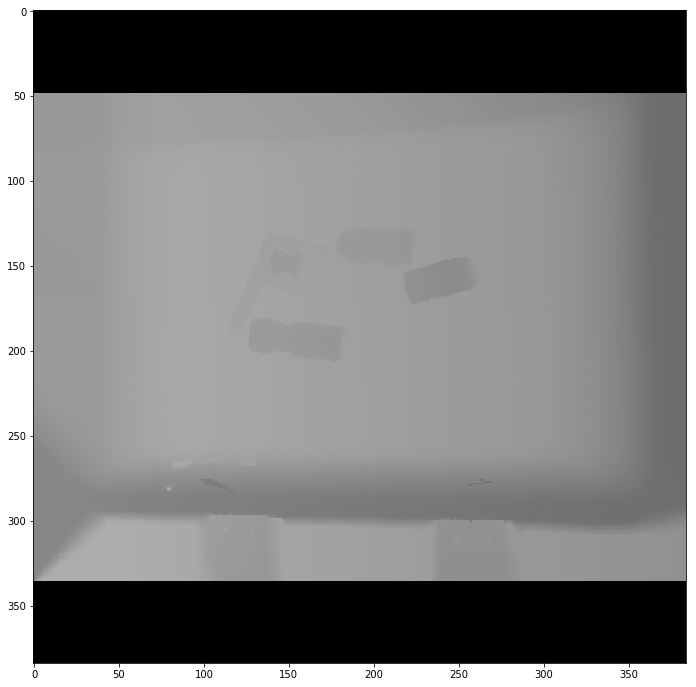

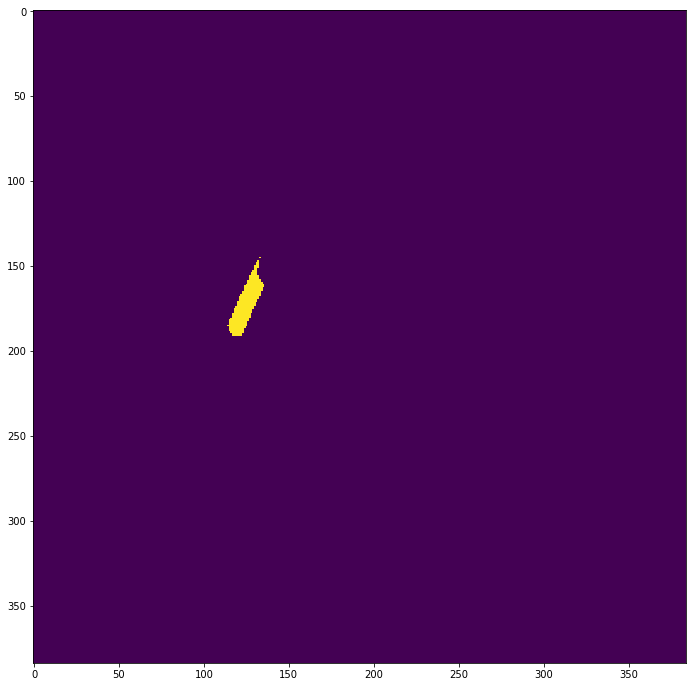

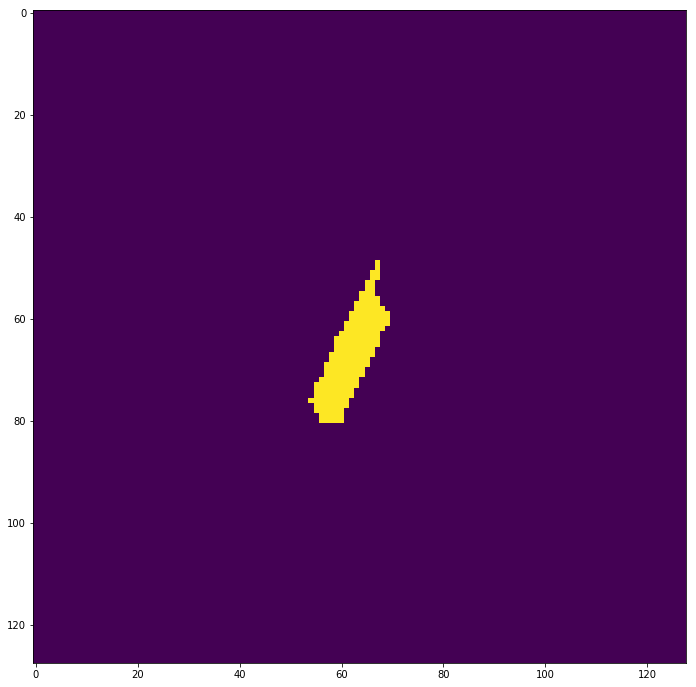

 77%|███████▋  | 23/30 [01:06<00:20,  2.91s/it]

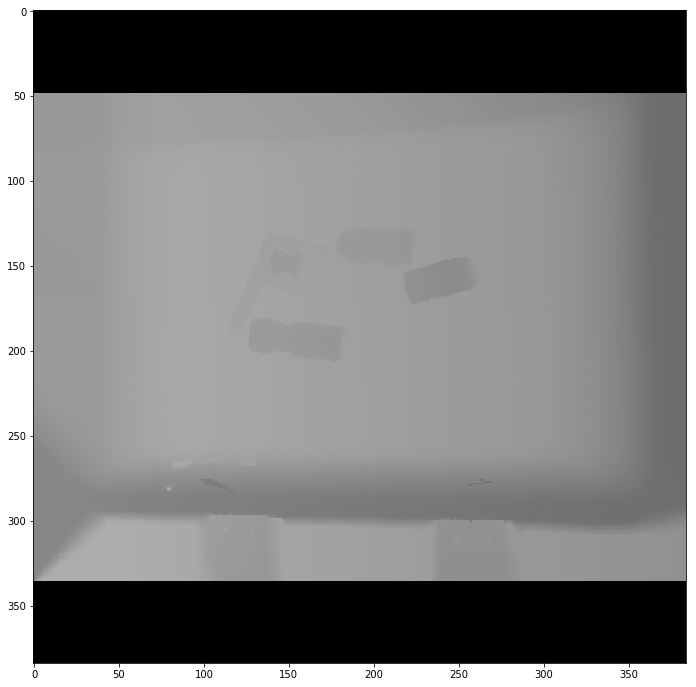

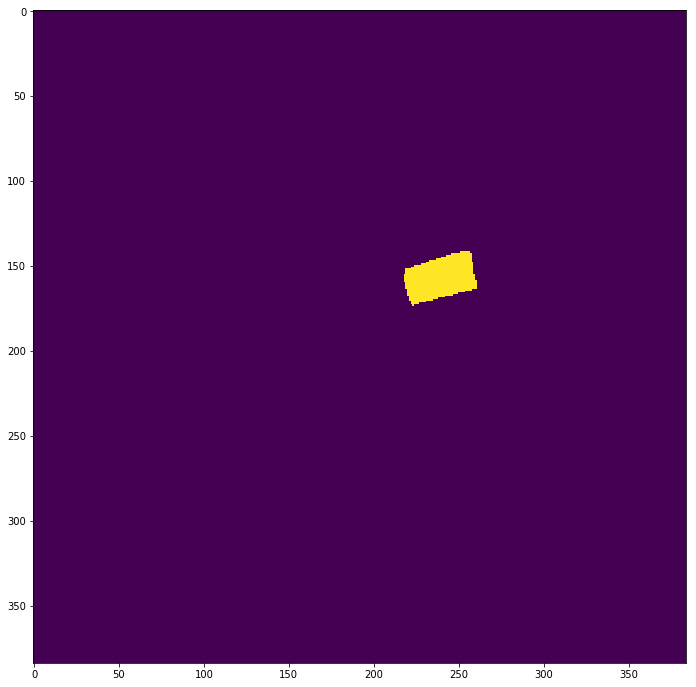

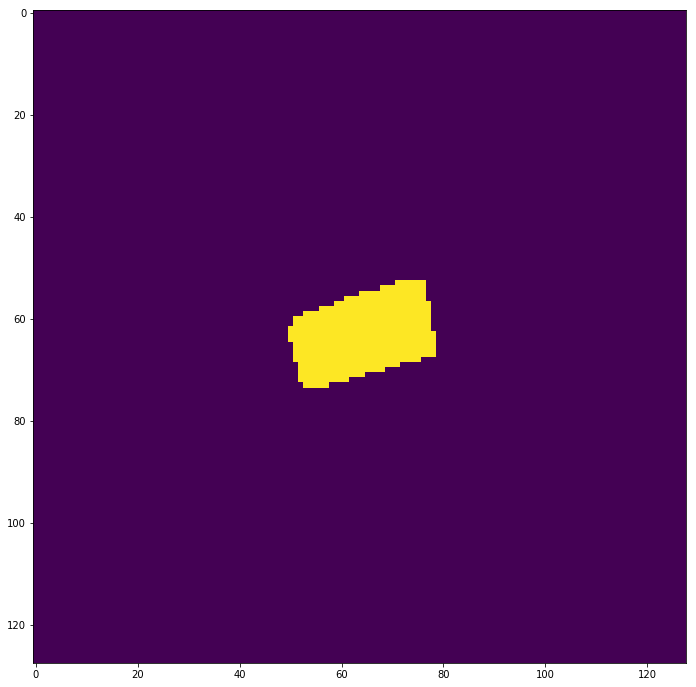

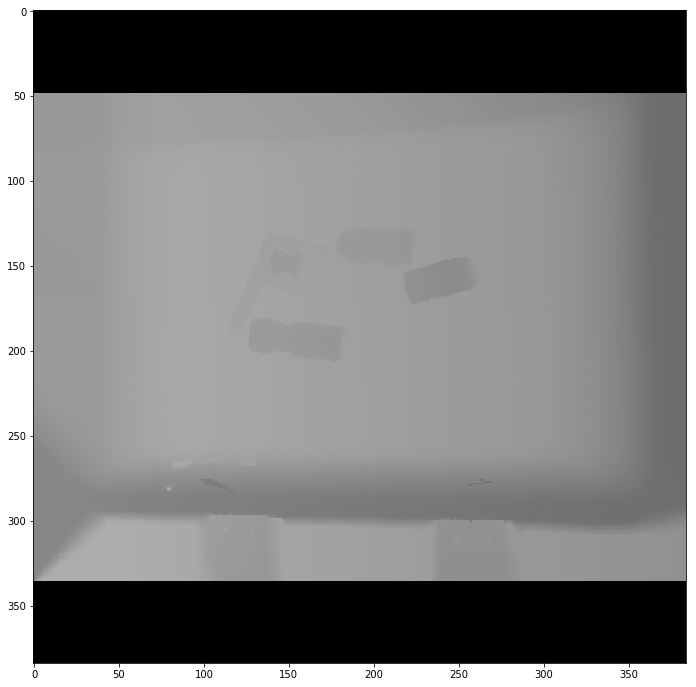

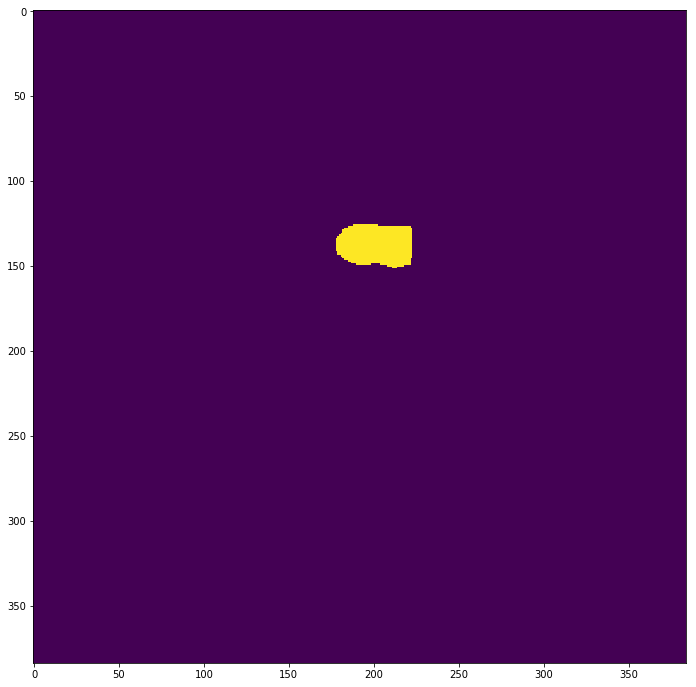

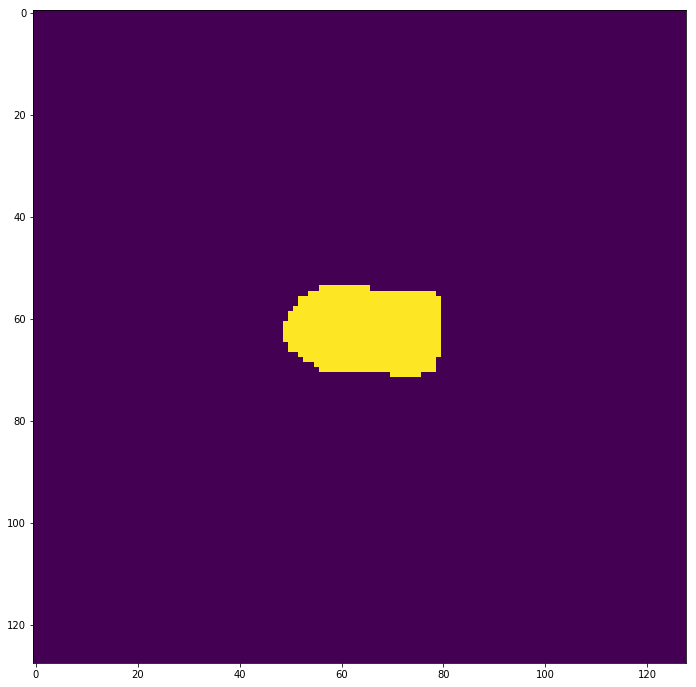

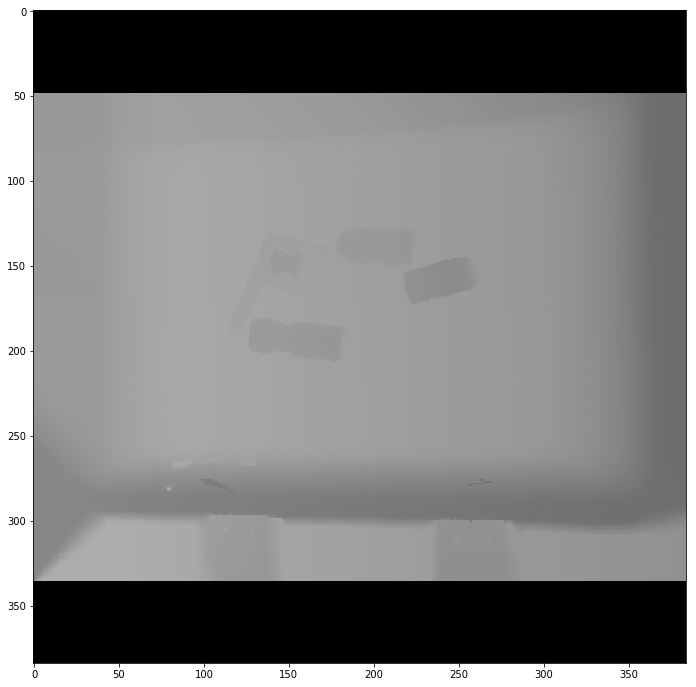

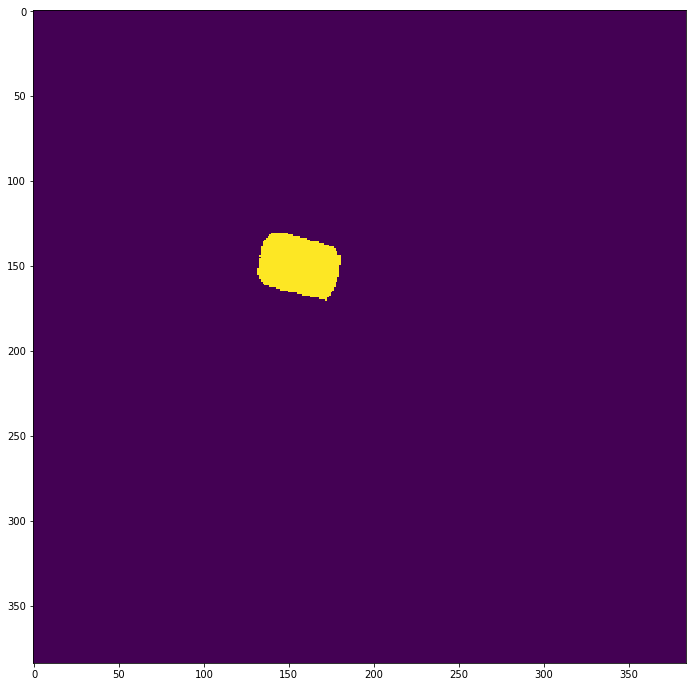

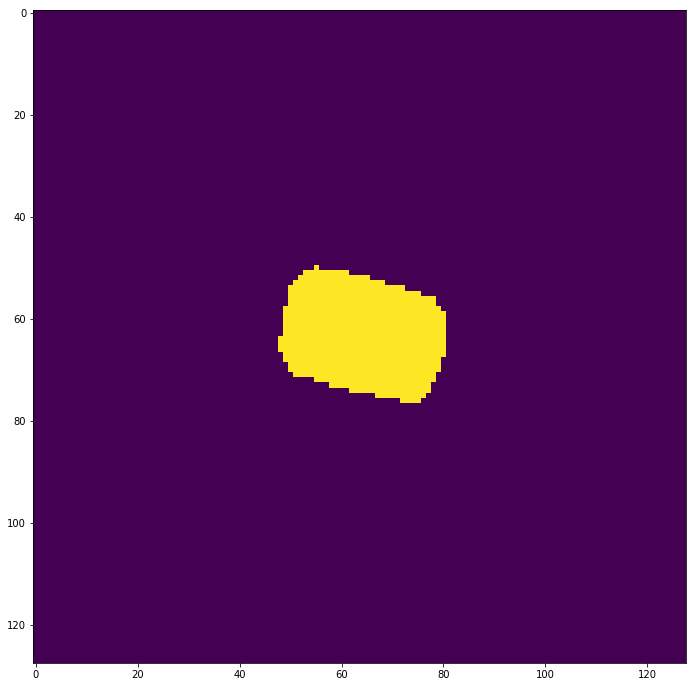

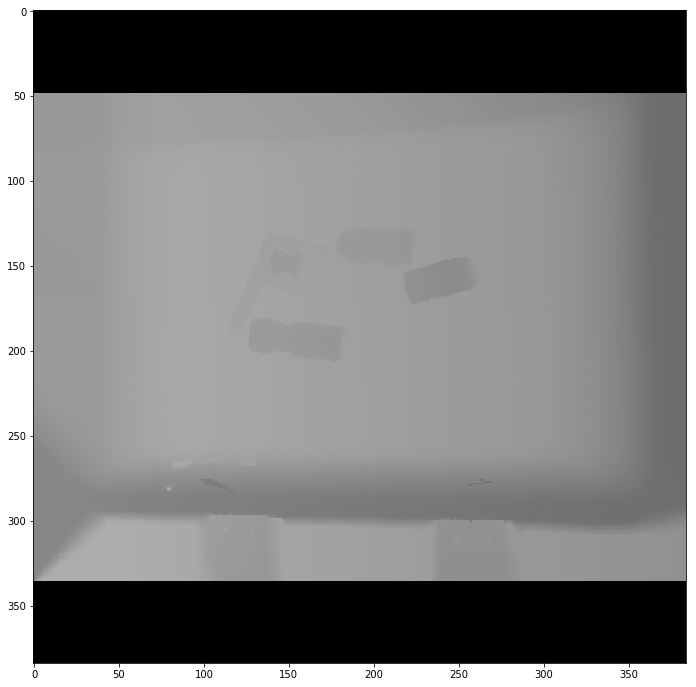

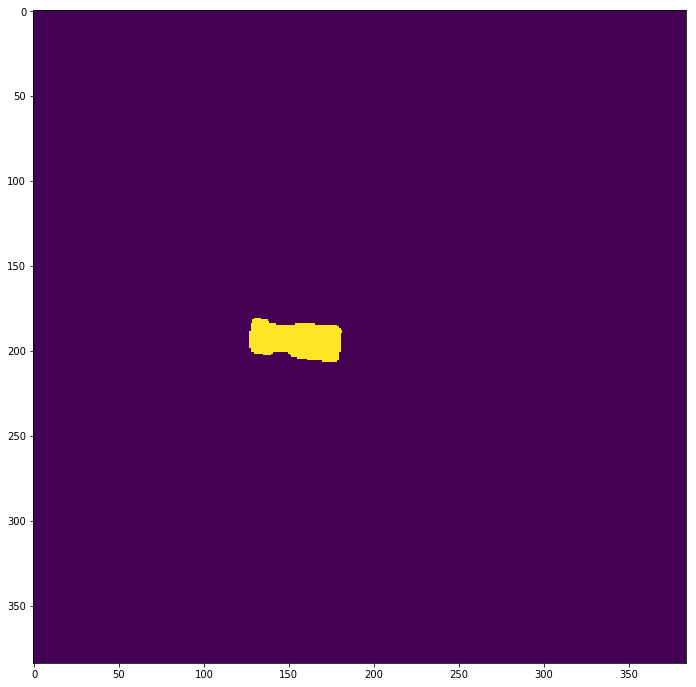

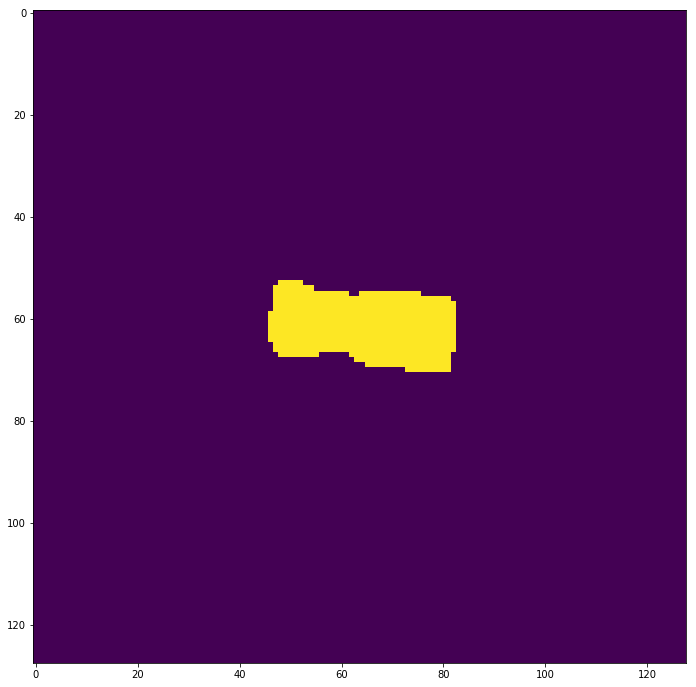

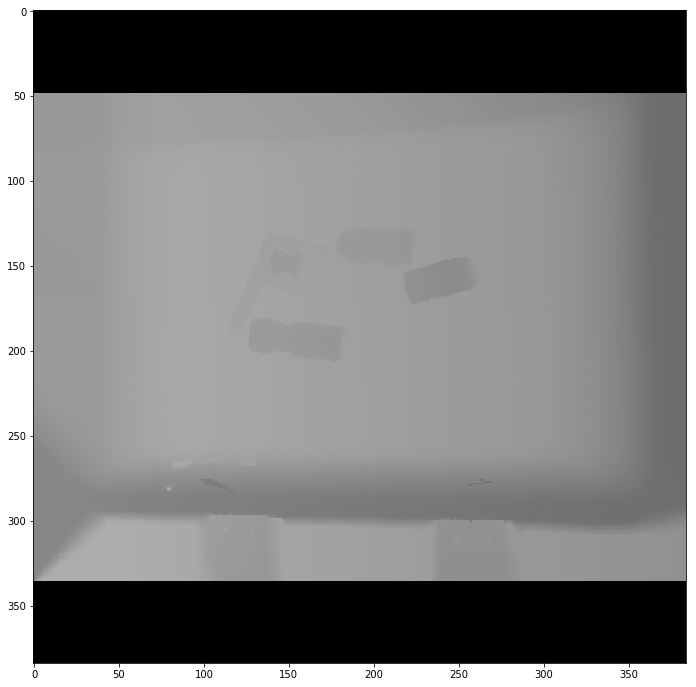

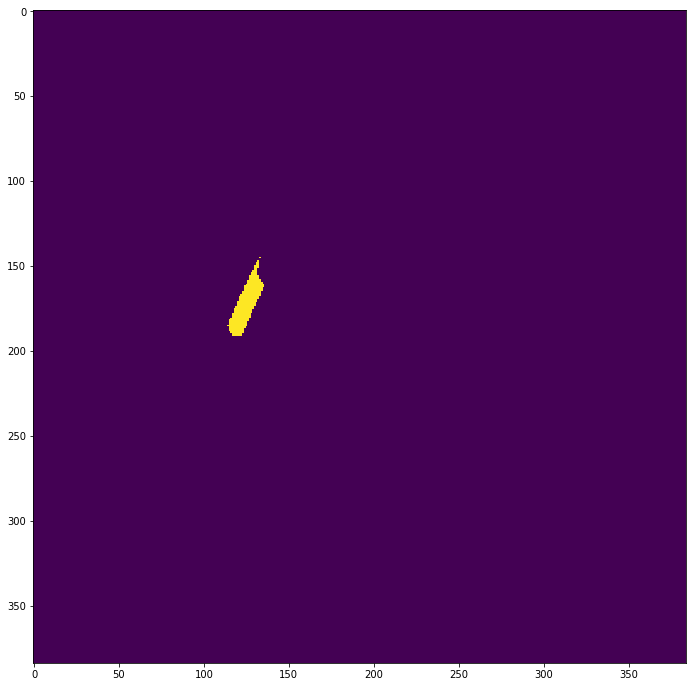

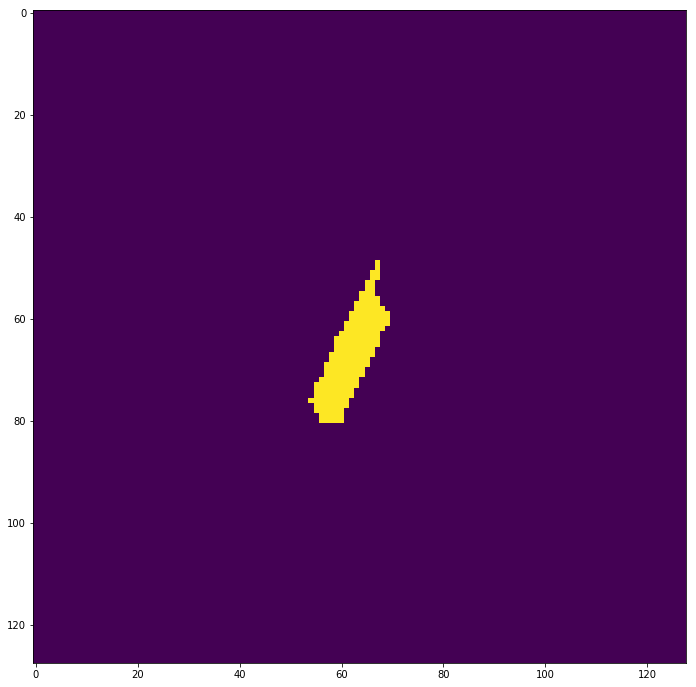

 80%|████████  | 24/30 [01:09<00:17,  2.89s/it]

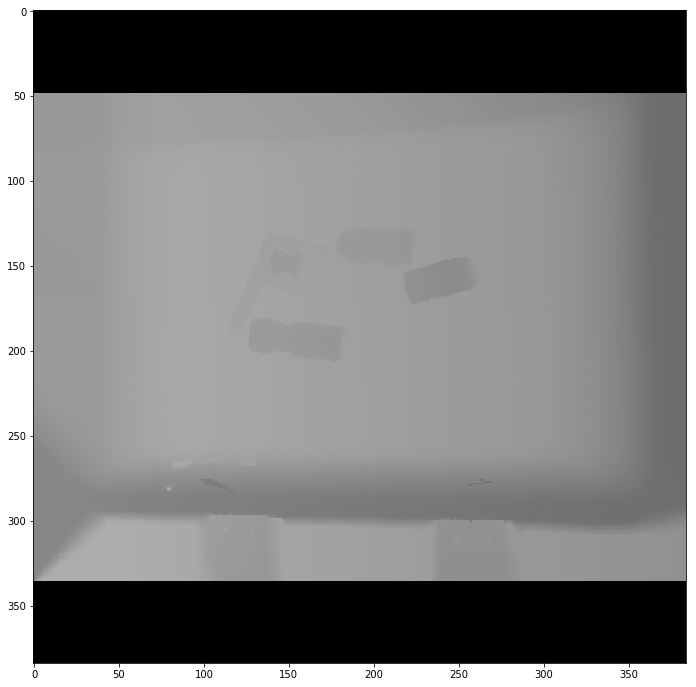

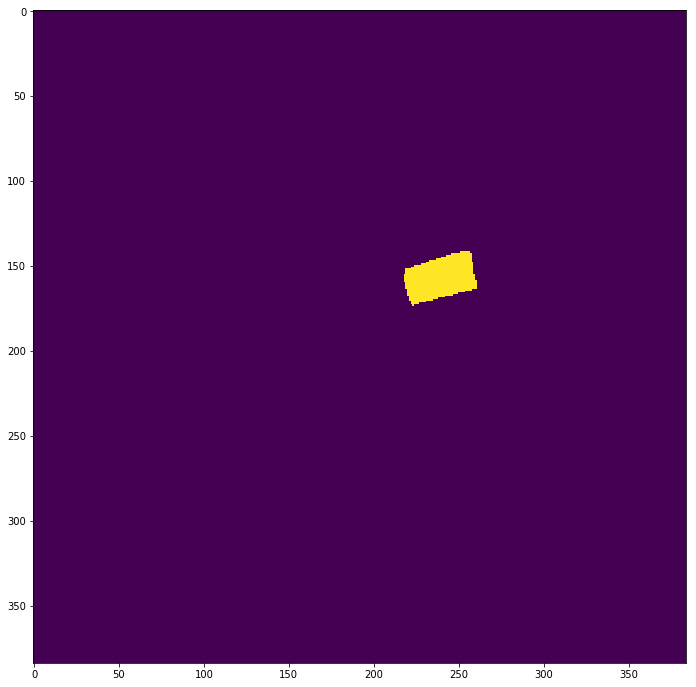

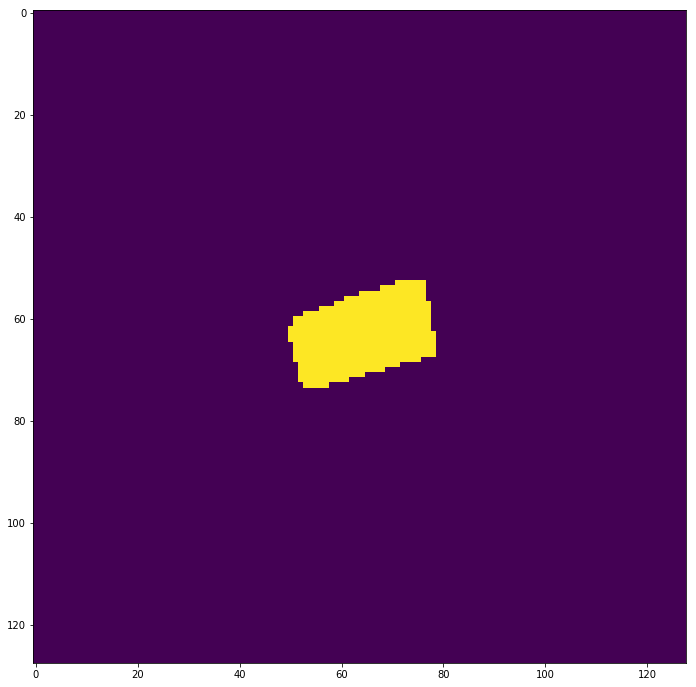

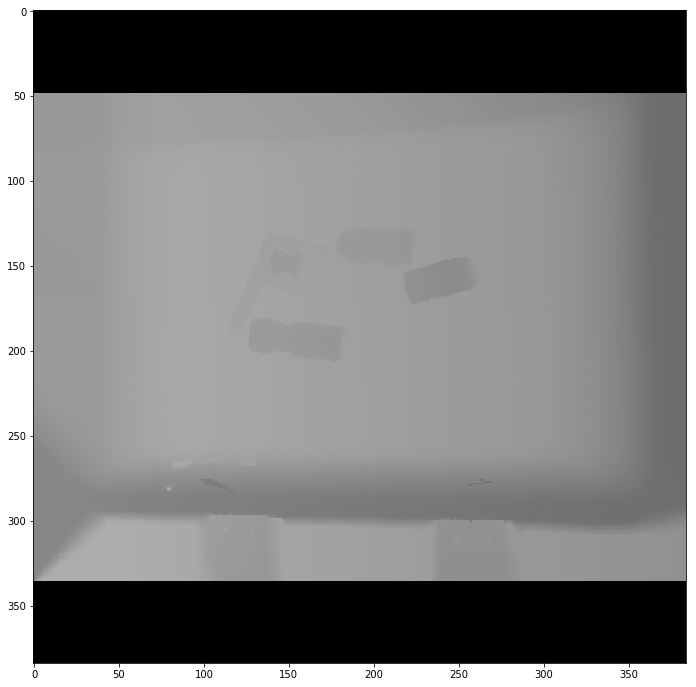

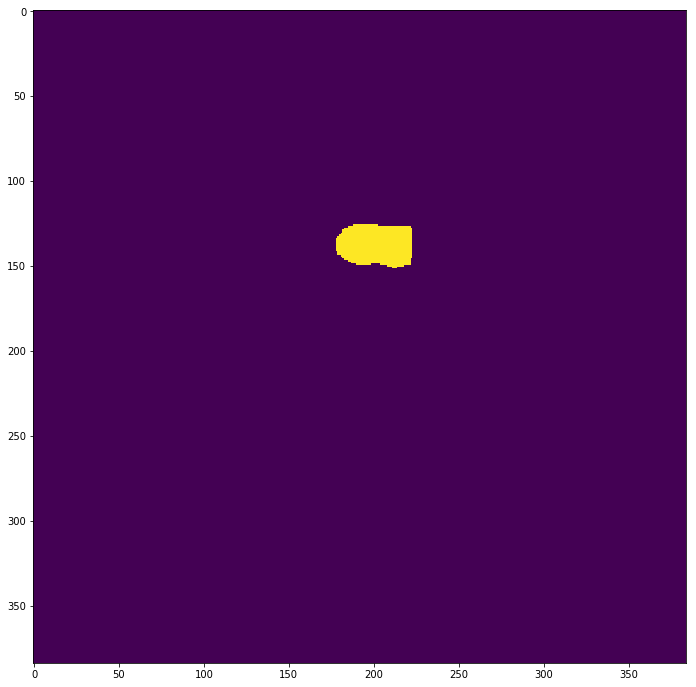

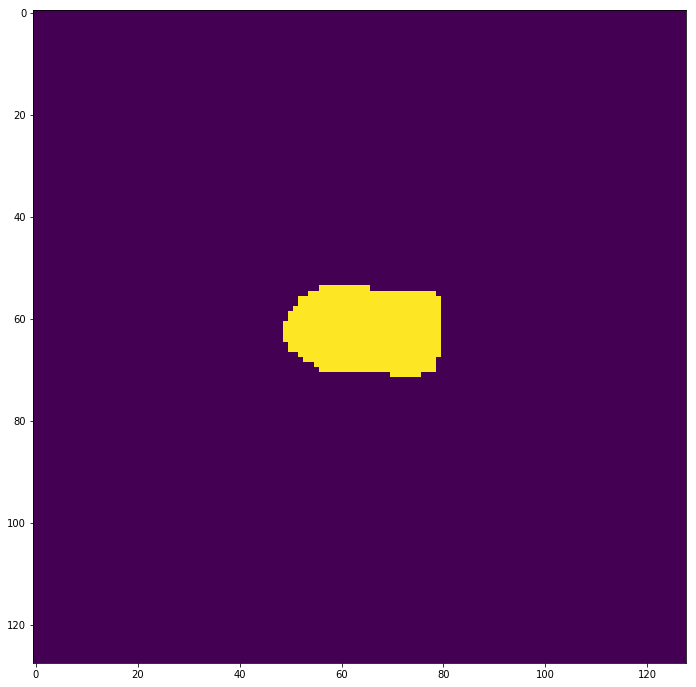

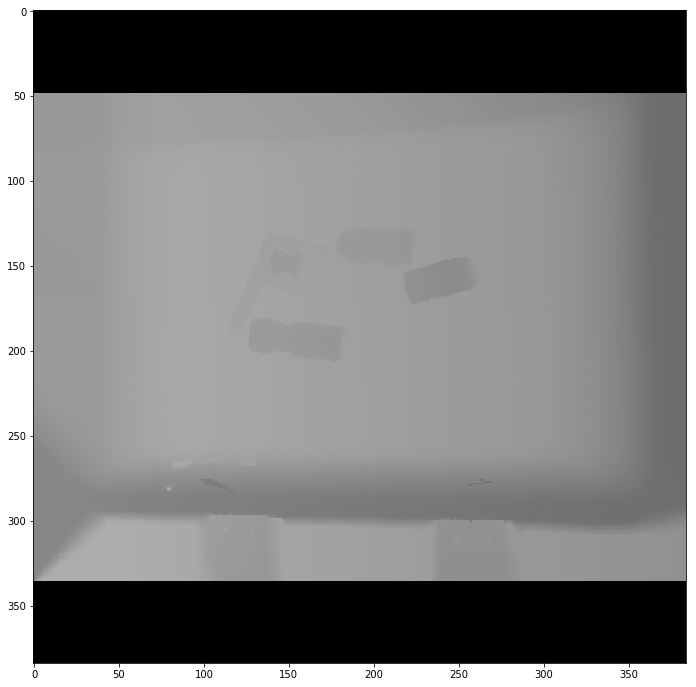

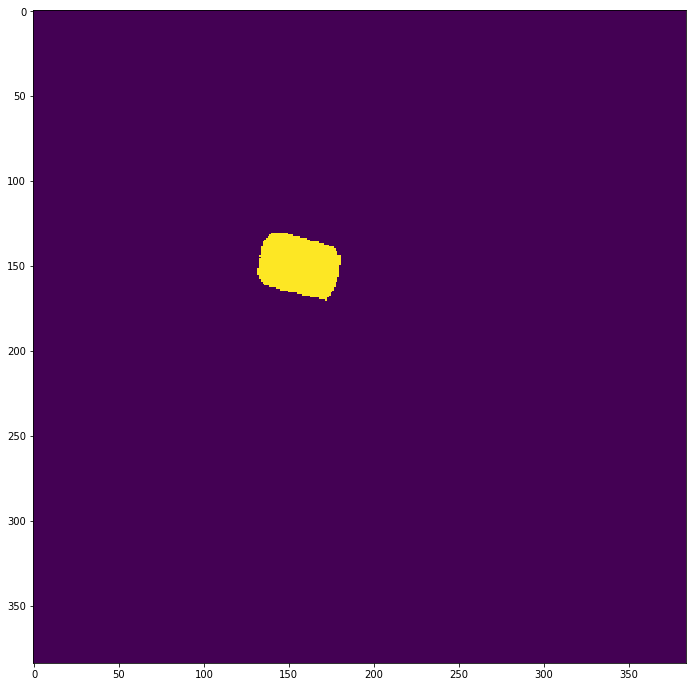

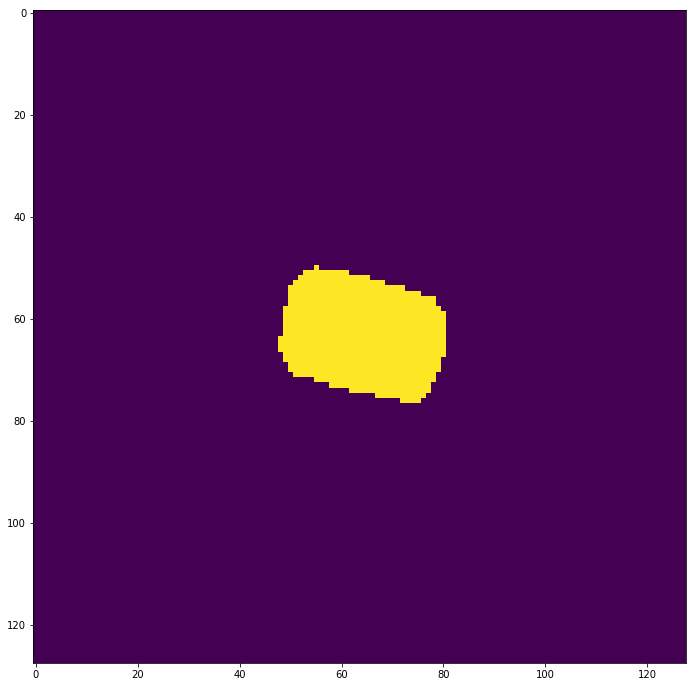

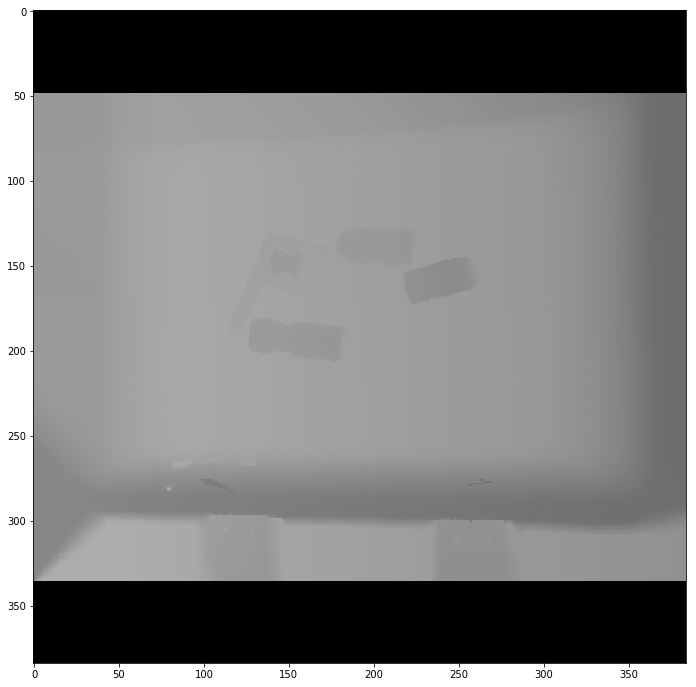

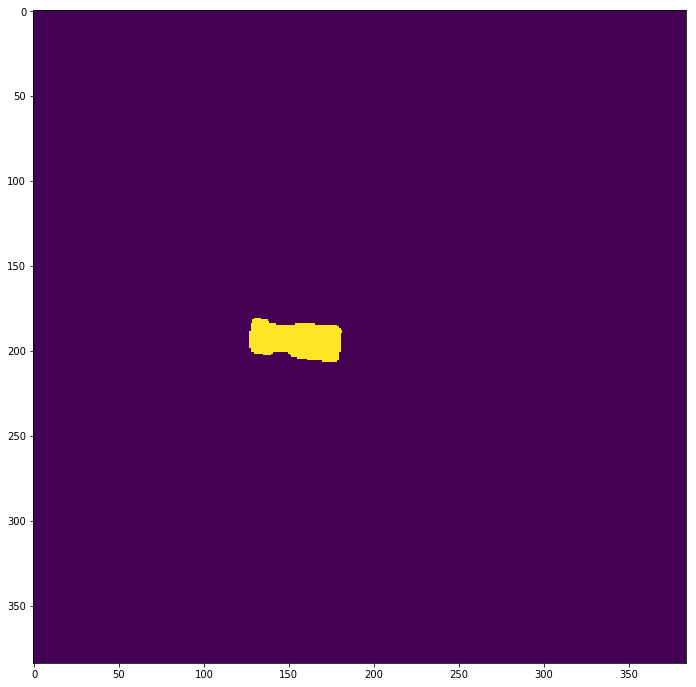

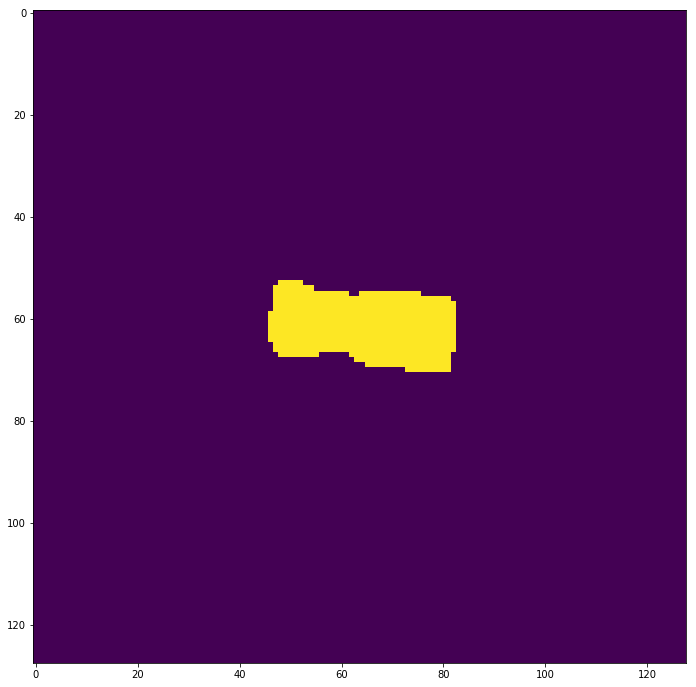

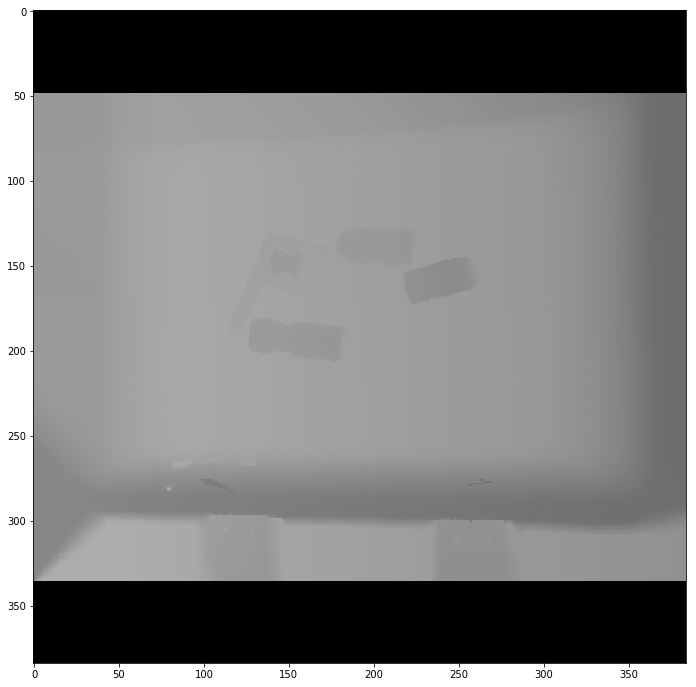

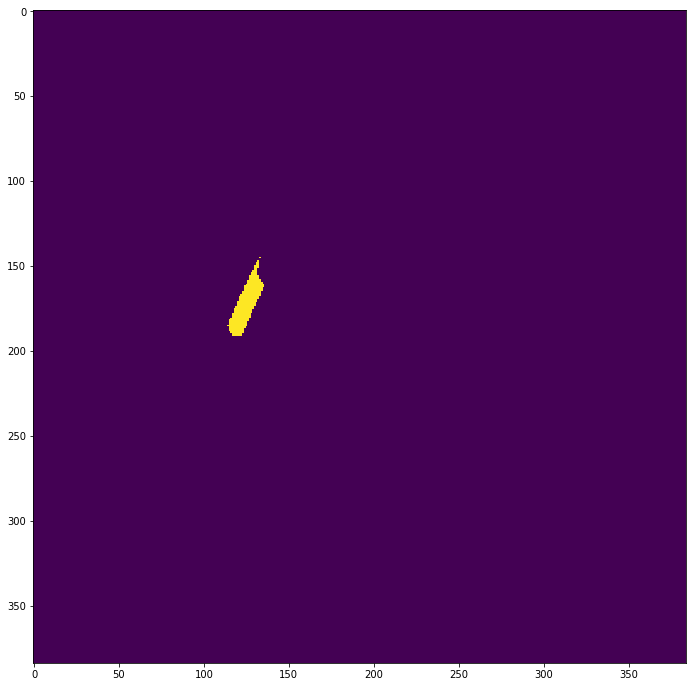

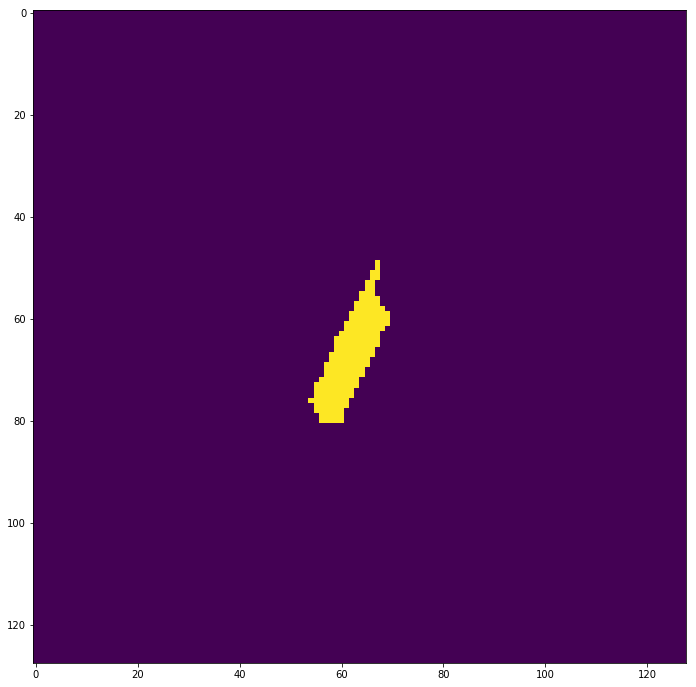

 83%|████████▎ | 25/30 [01:12<00:14,  2.88s/it]

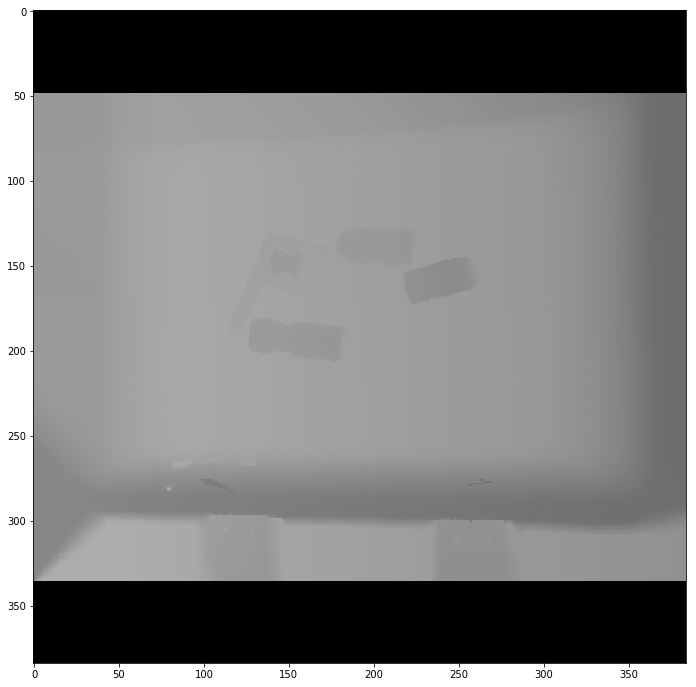

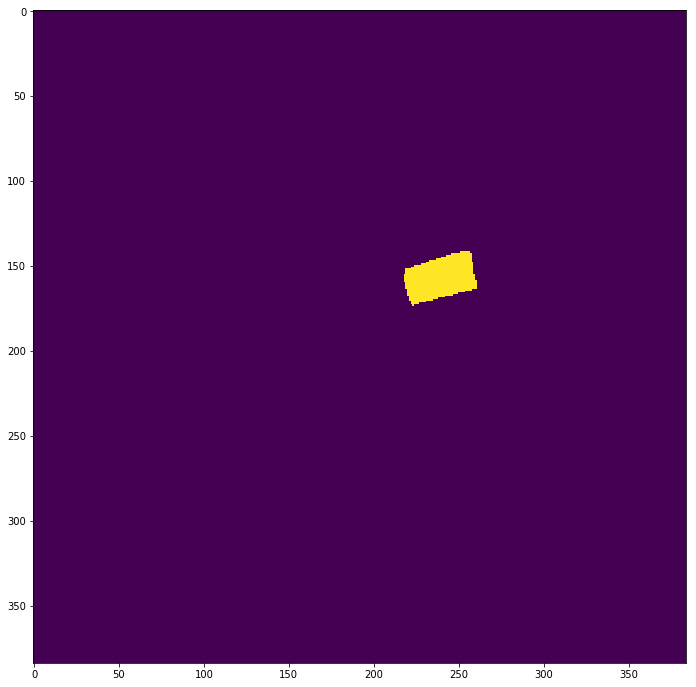

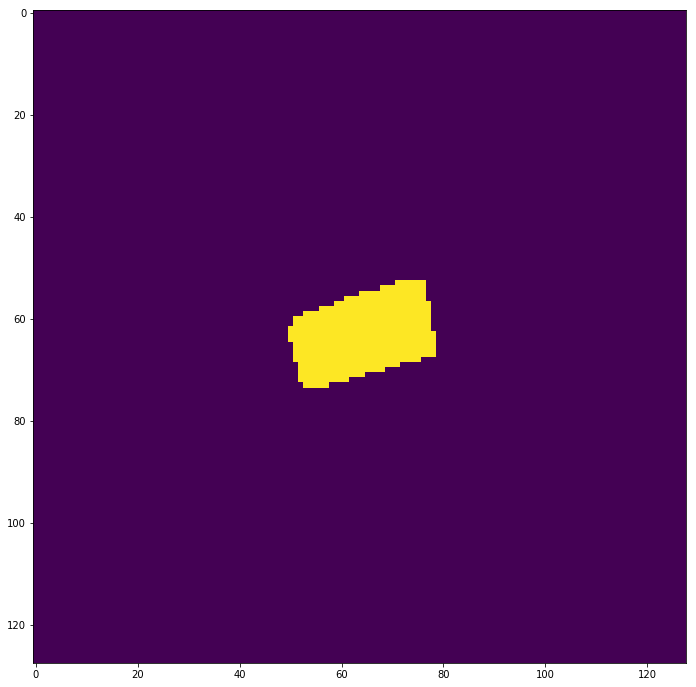

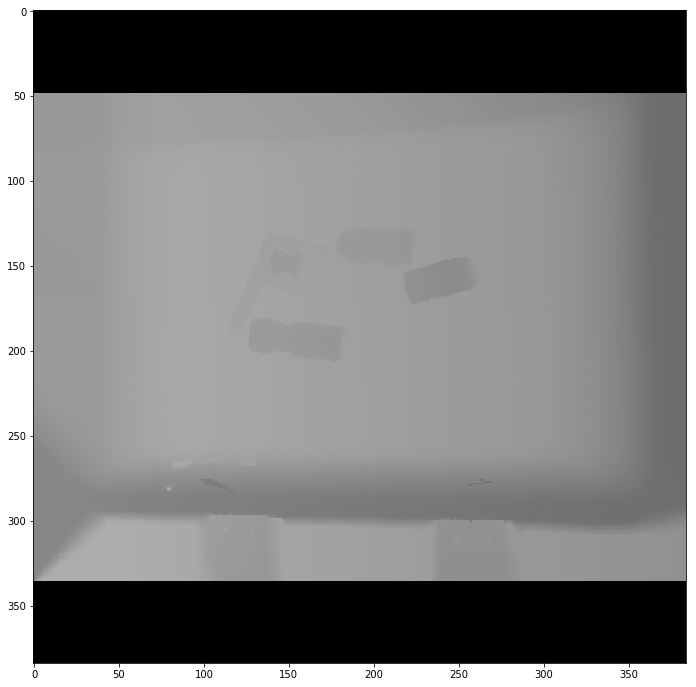

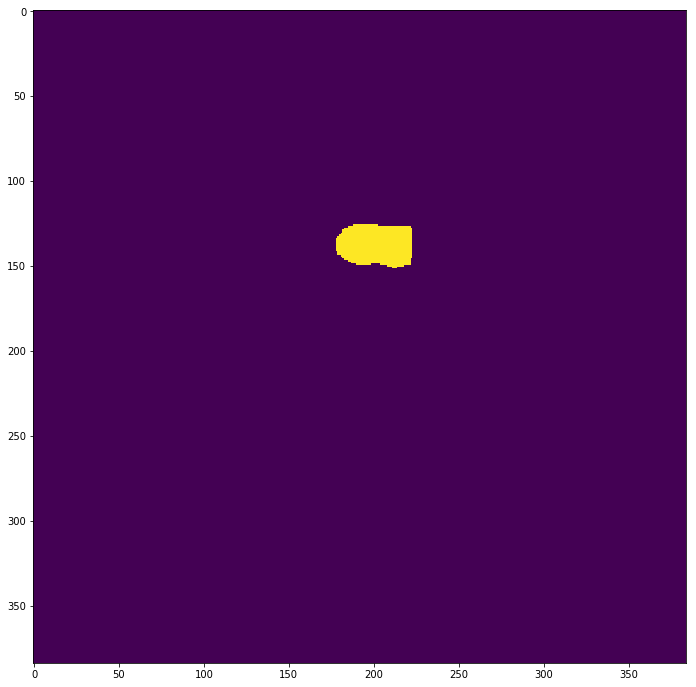

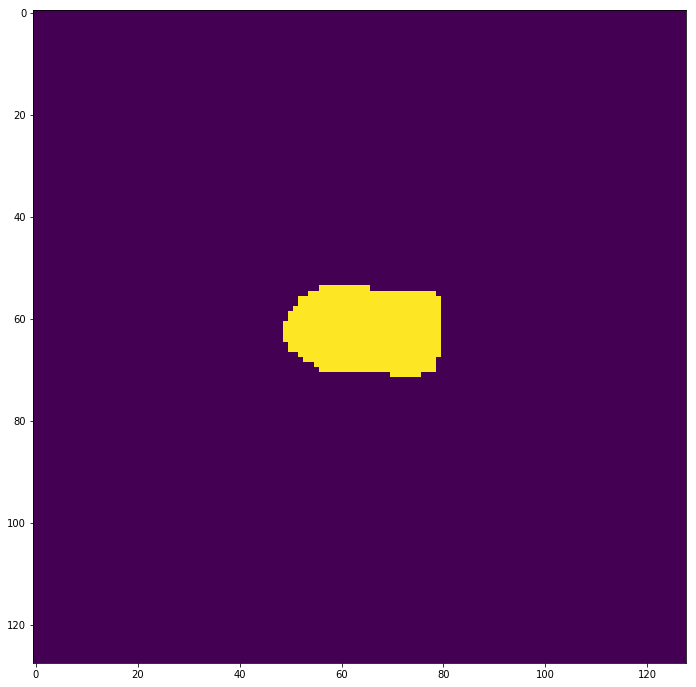

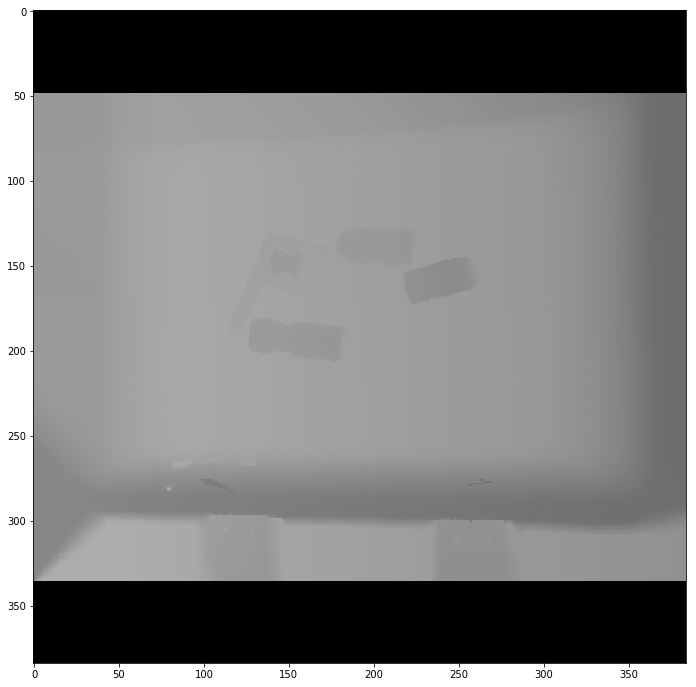

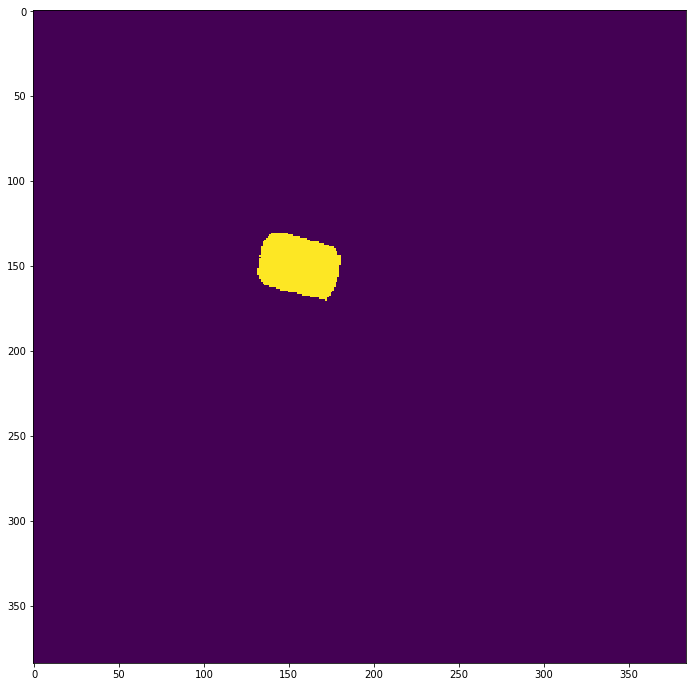

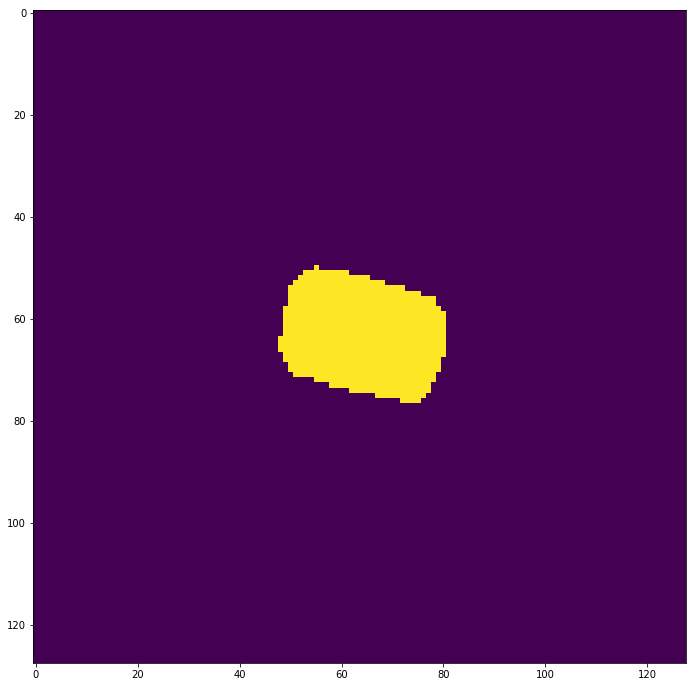

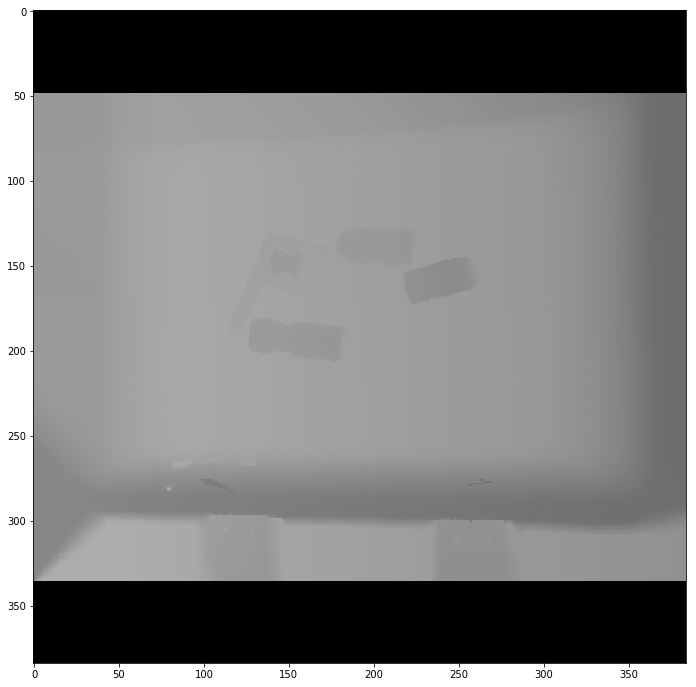

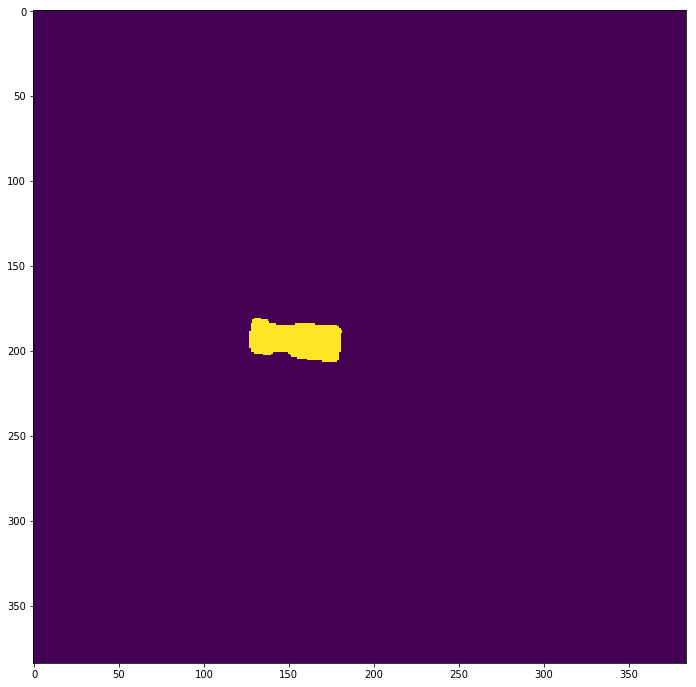

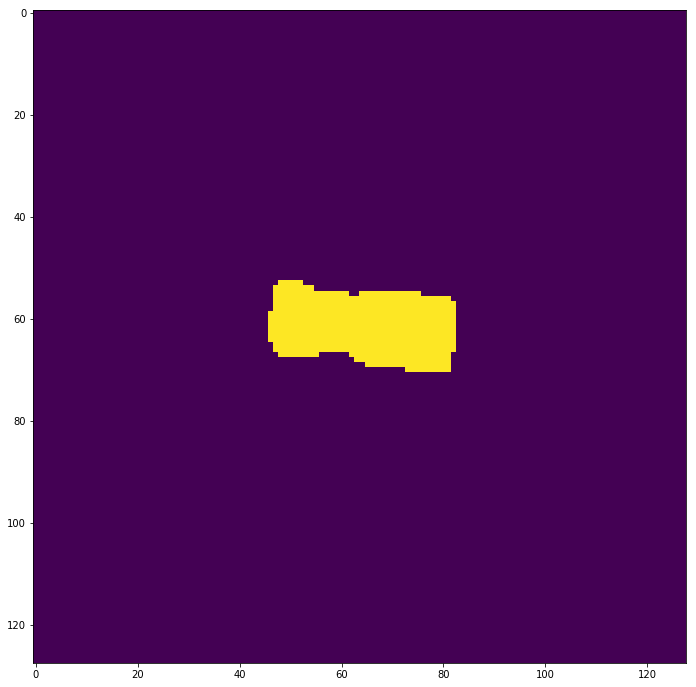

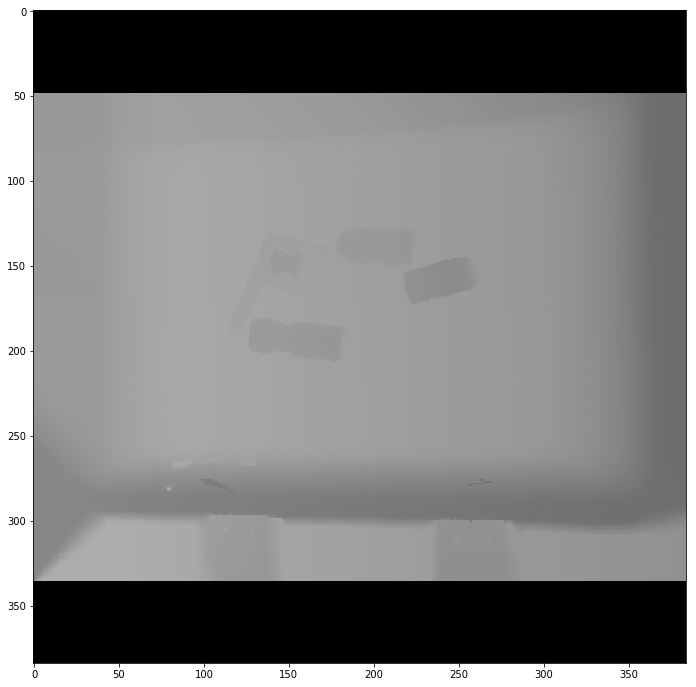

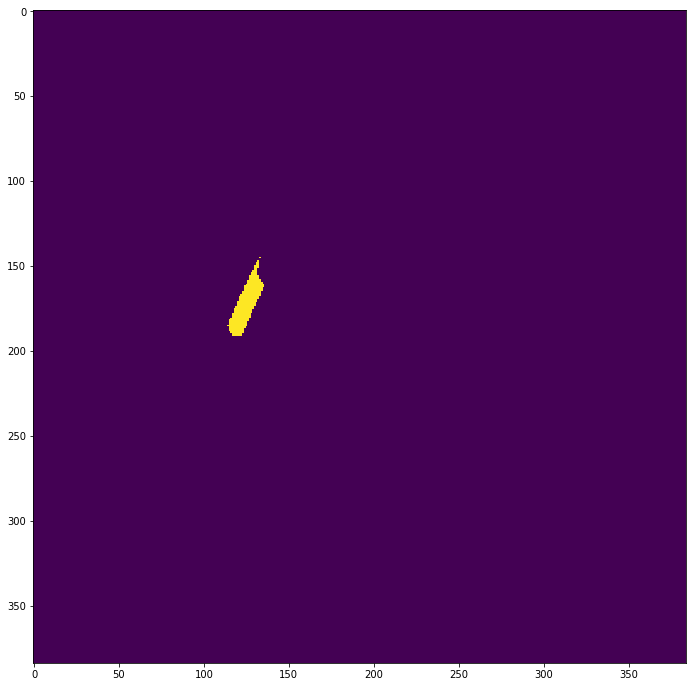

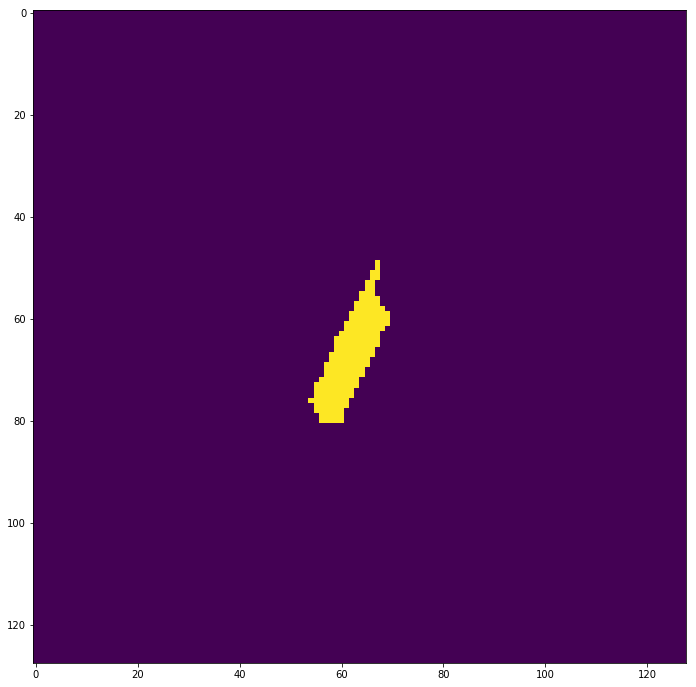

 87%|████████▋ | 26/30 [01:15<00:11,  2.88s/it]

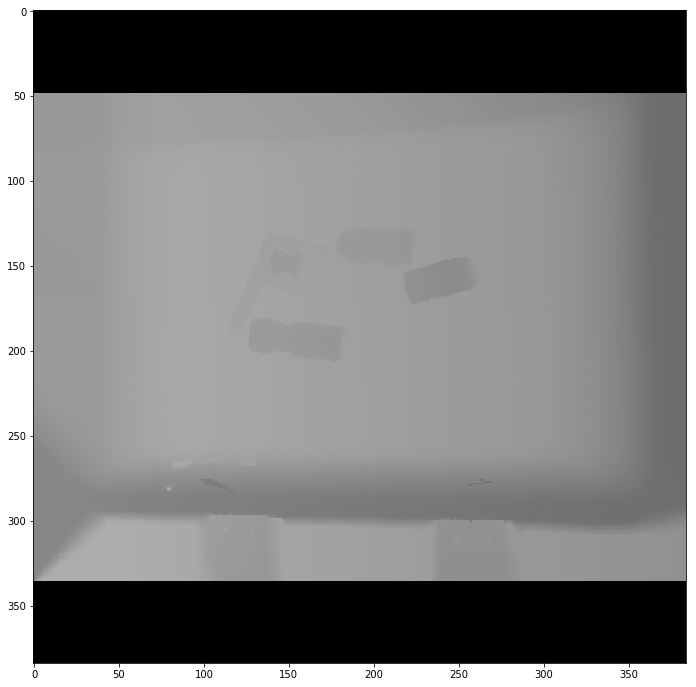

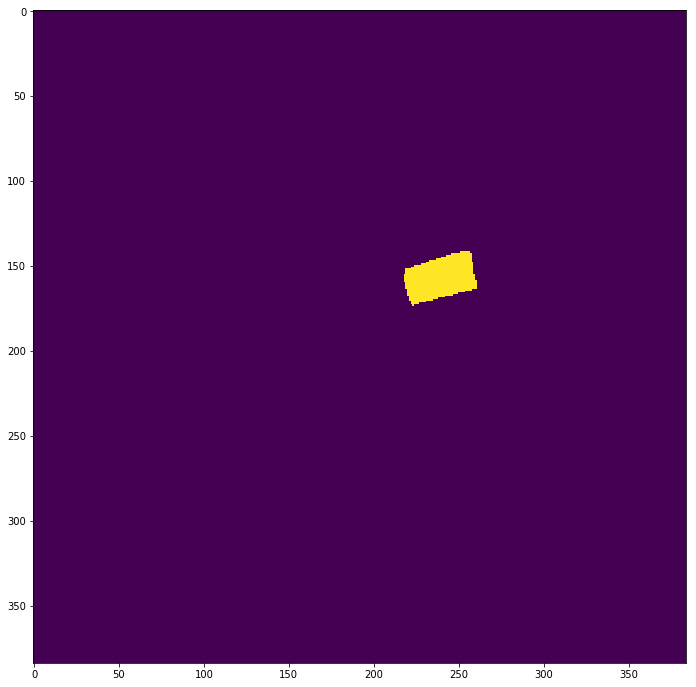

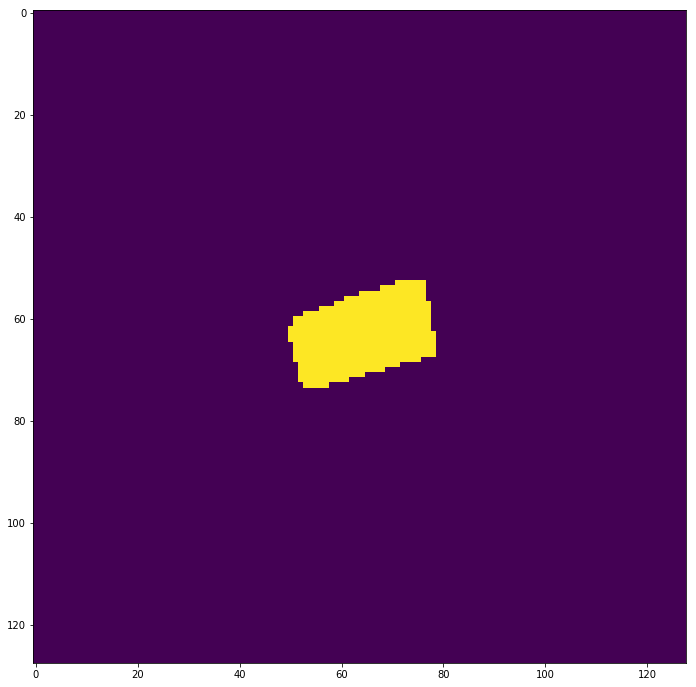

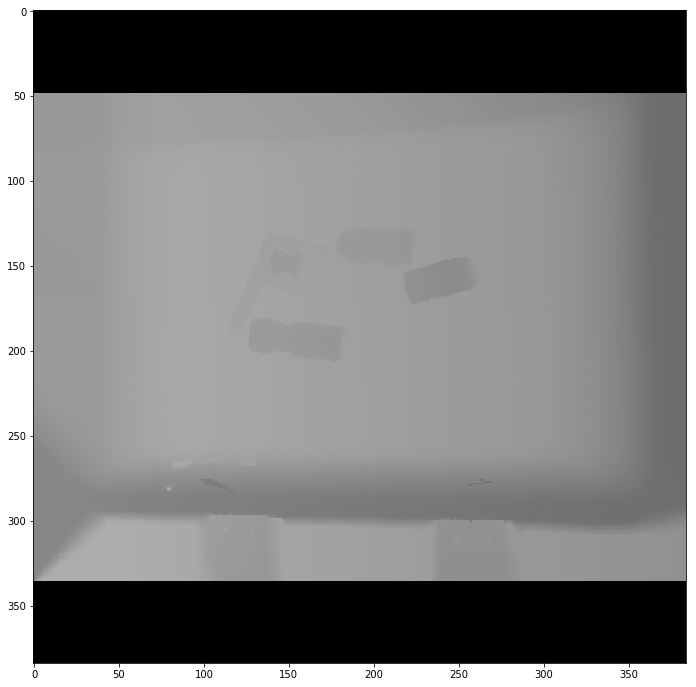

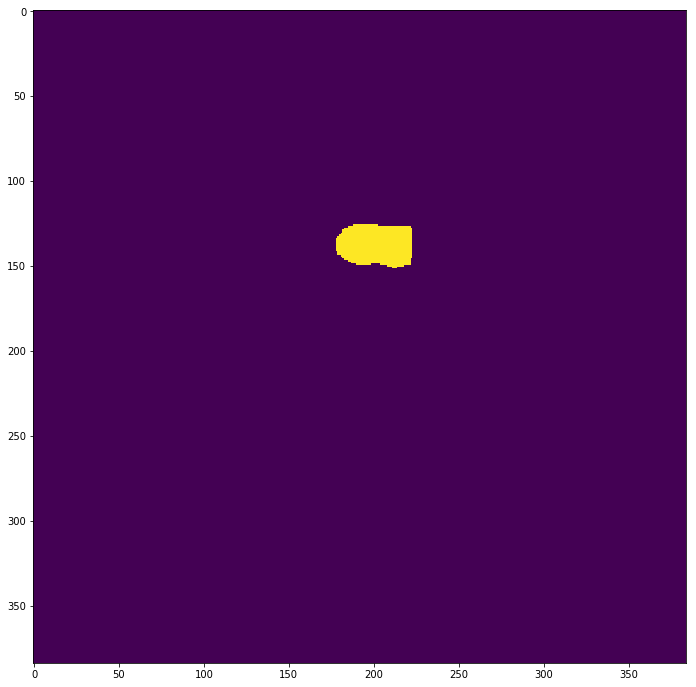

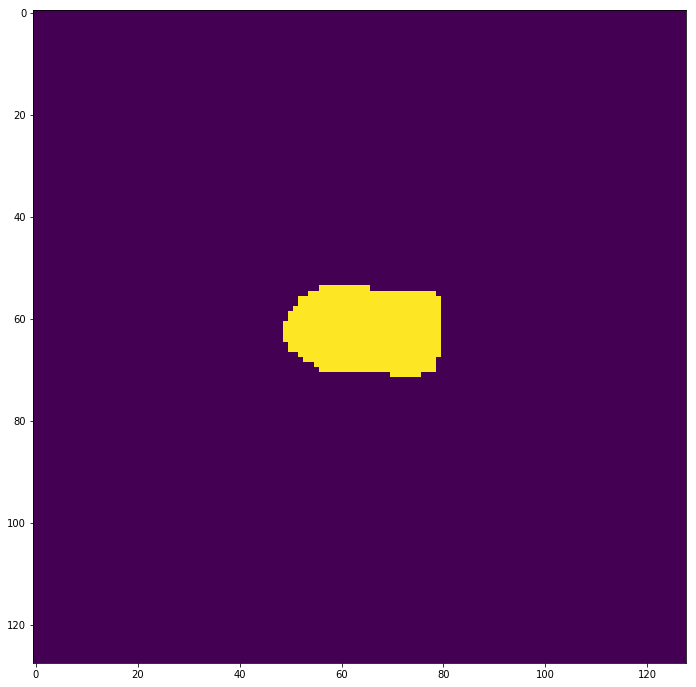

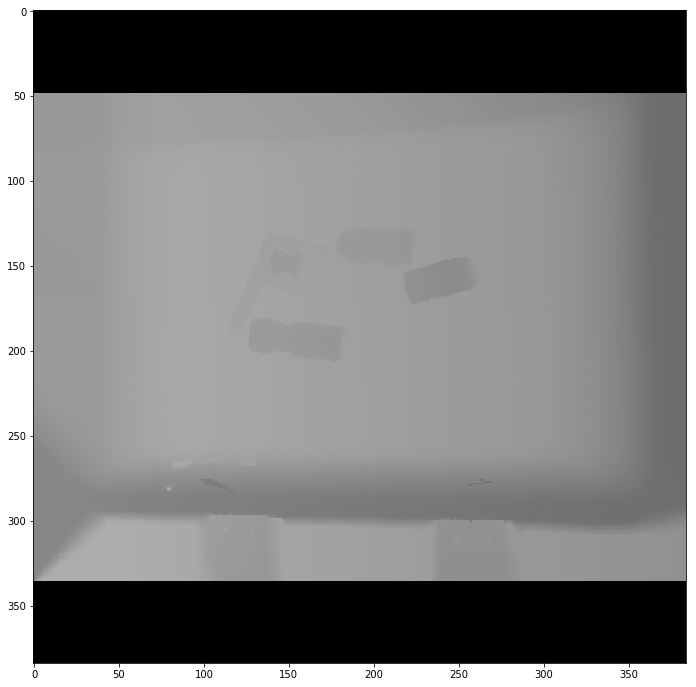

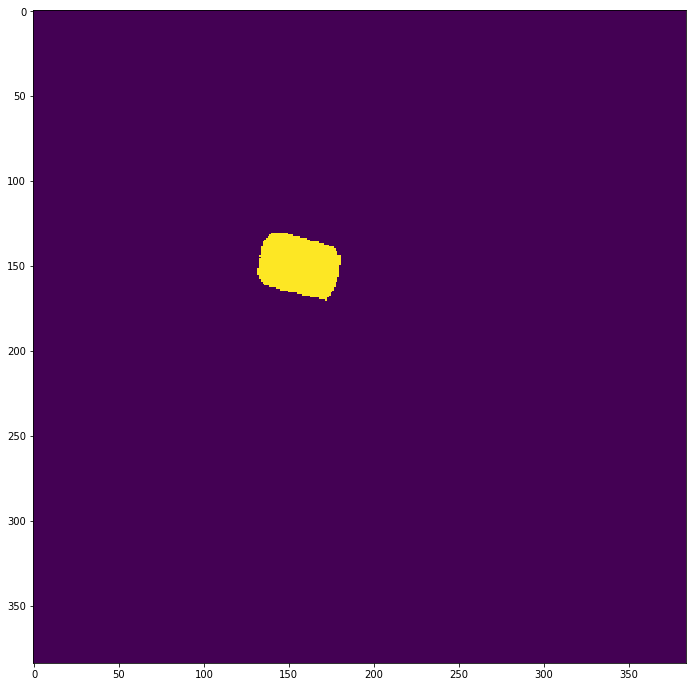

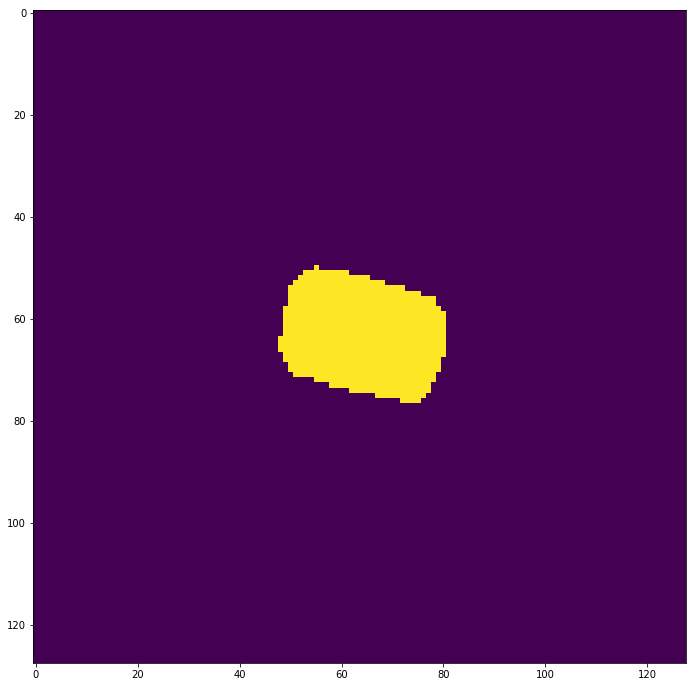

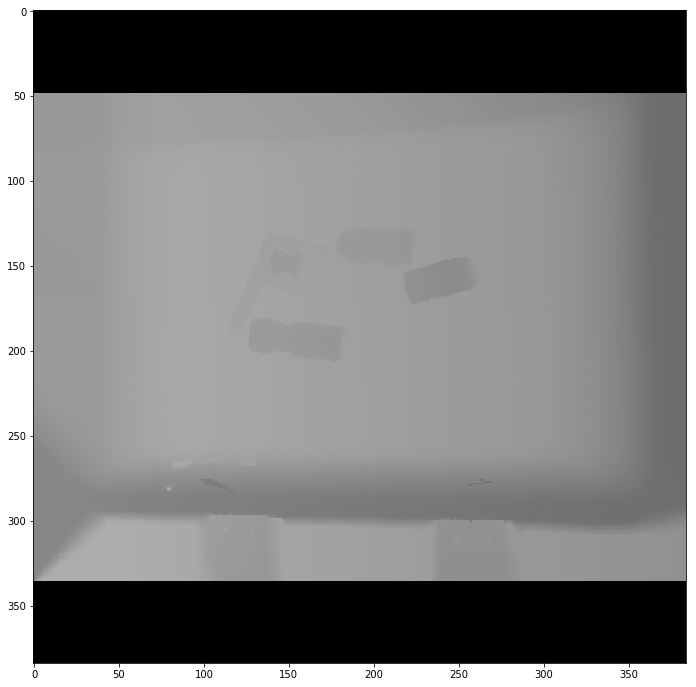

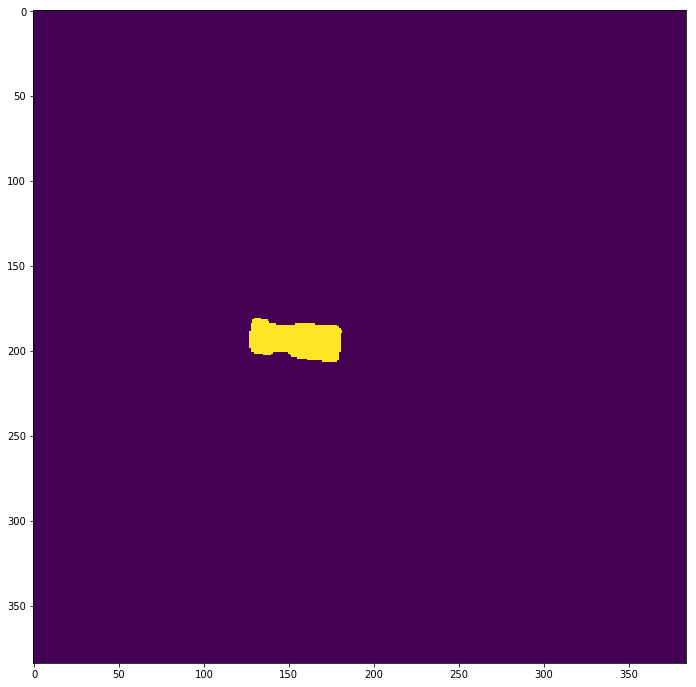

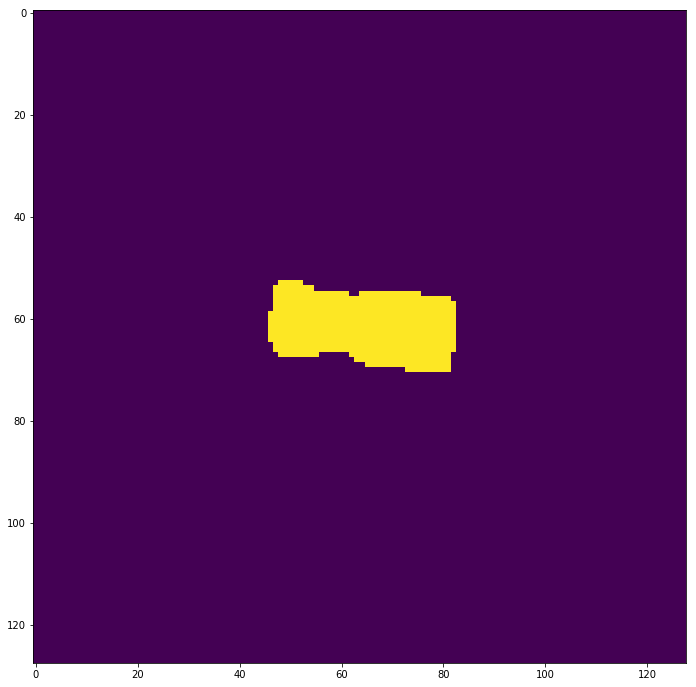

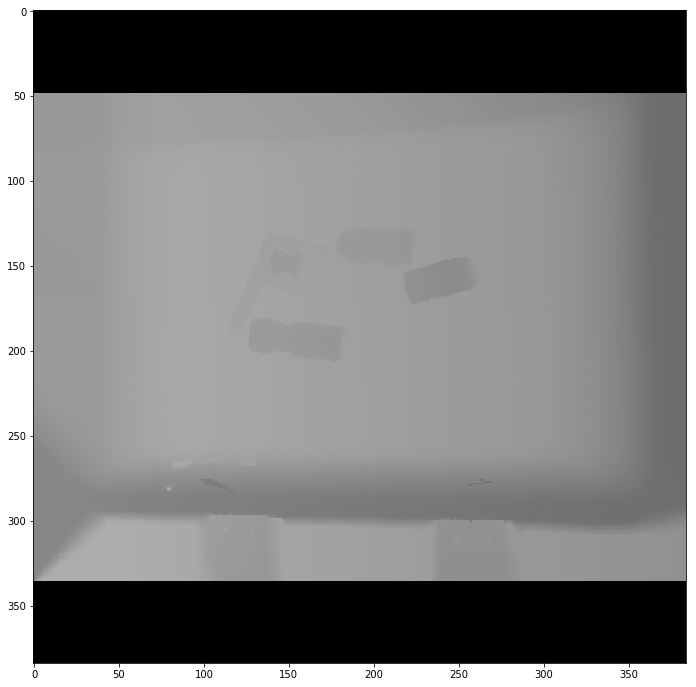

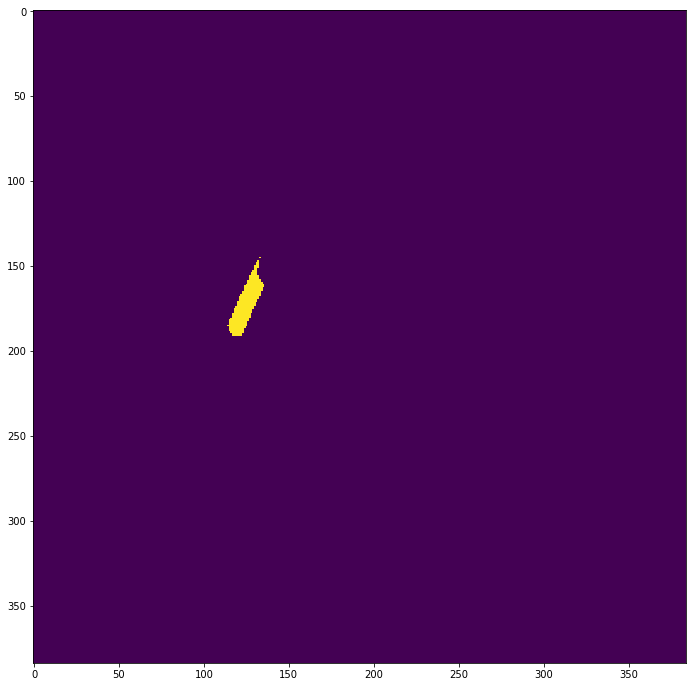

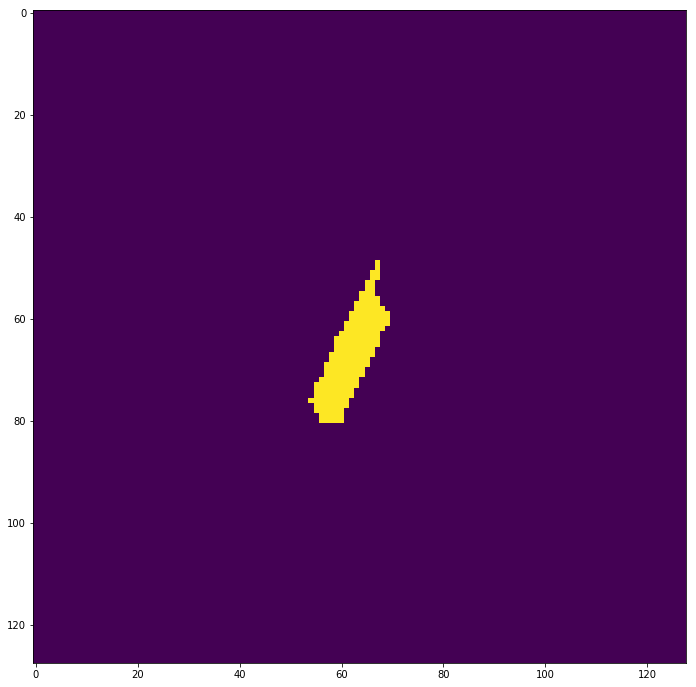

 90%|█████████ | 27/30 [01:18<00:08,  2.89s/it]

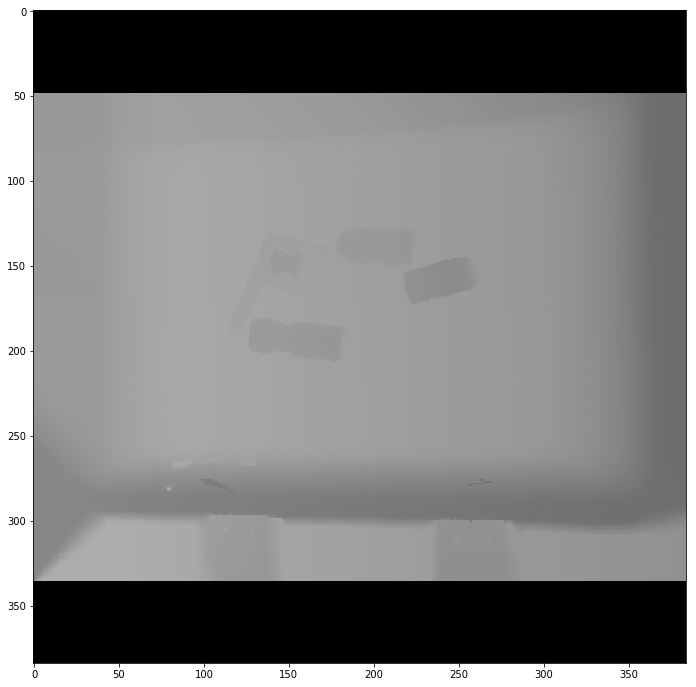

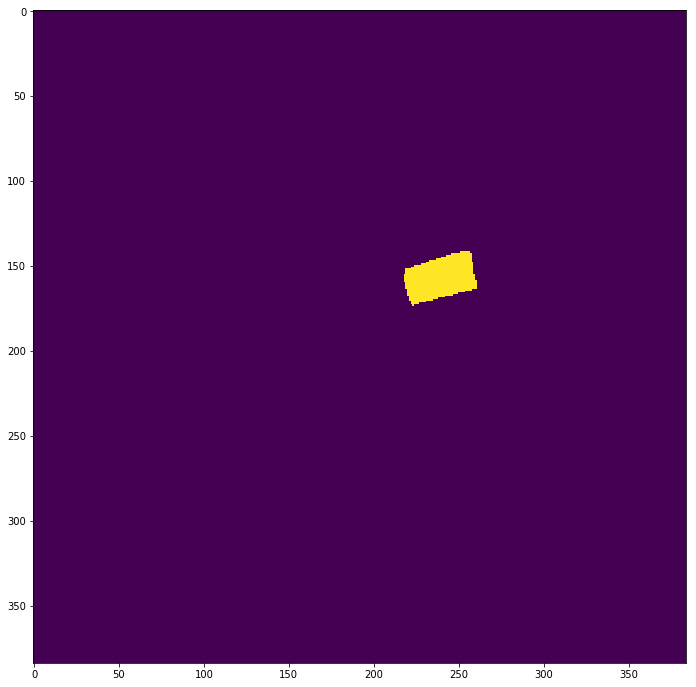

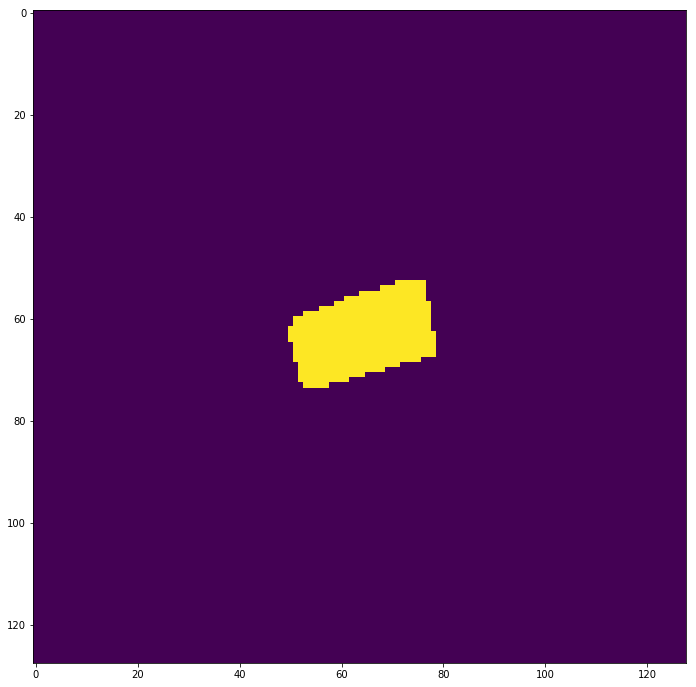

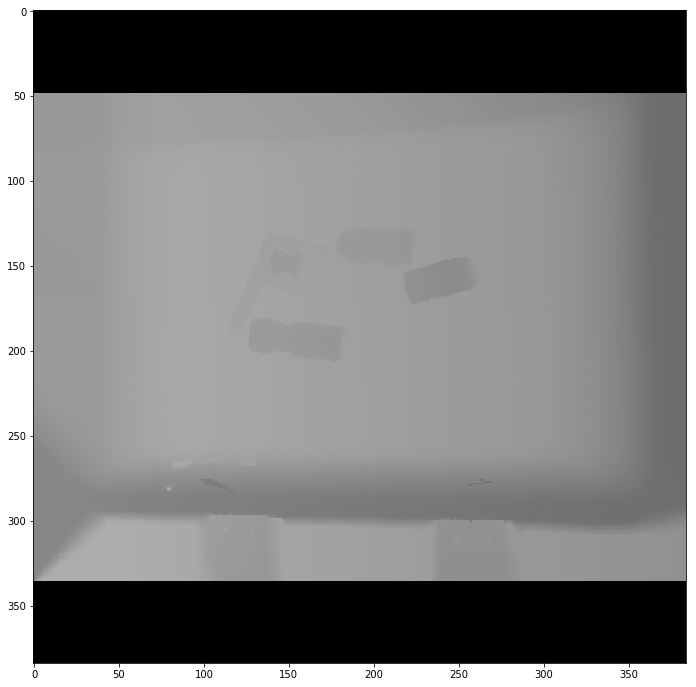

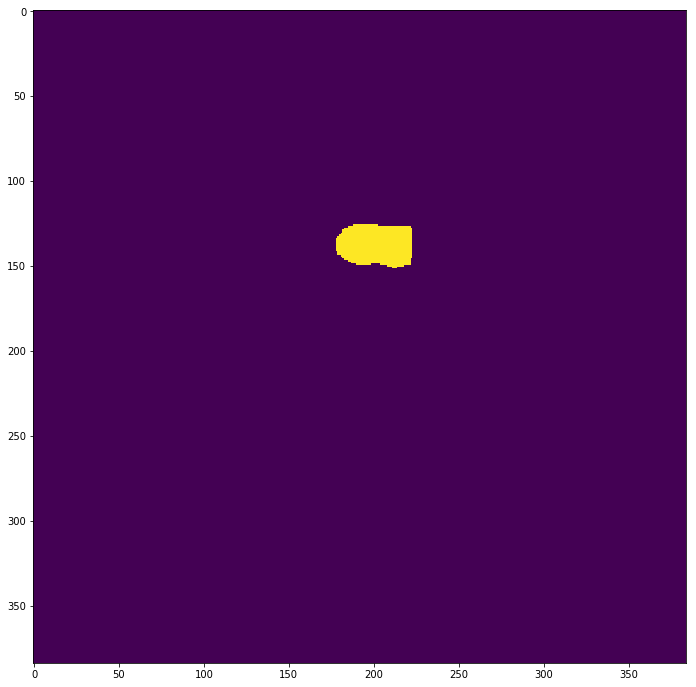

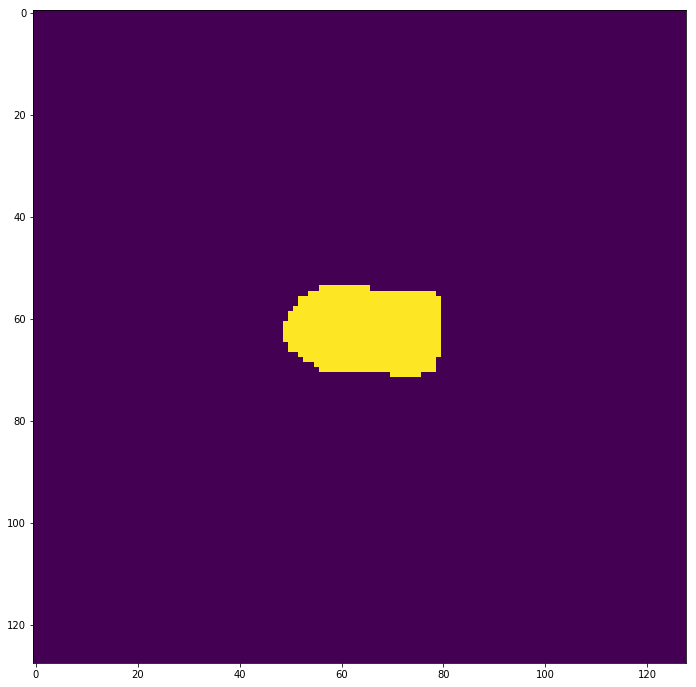

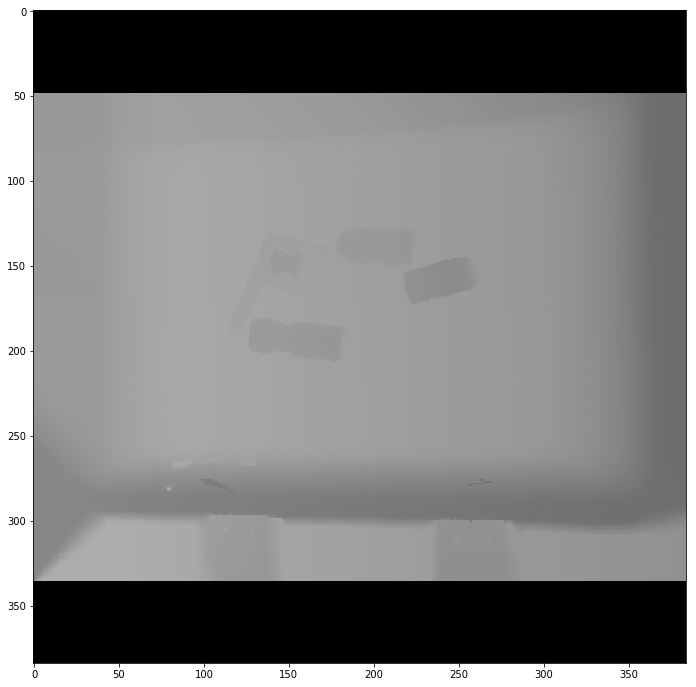

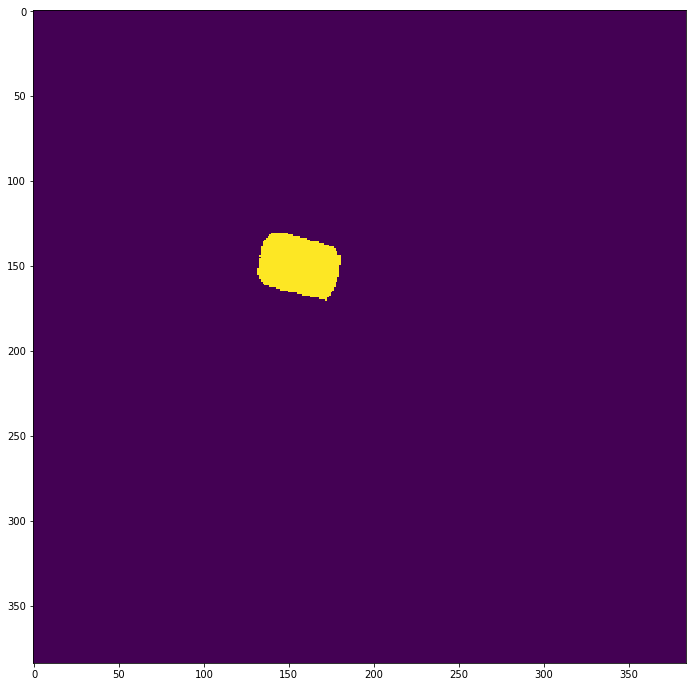

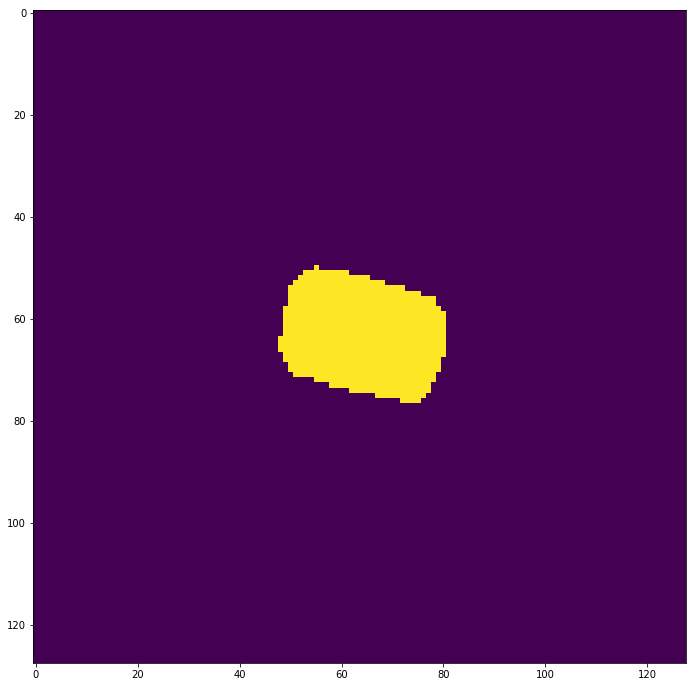

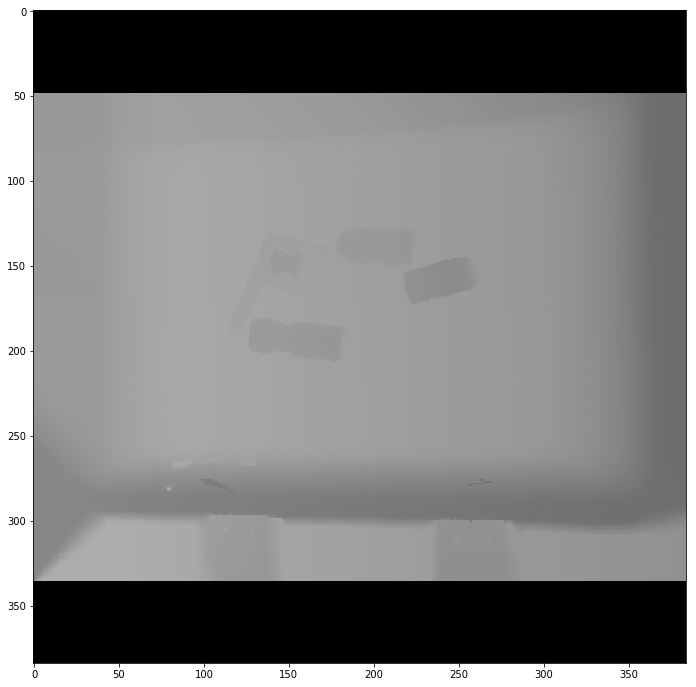

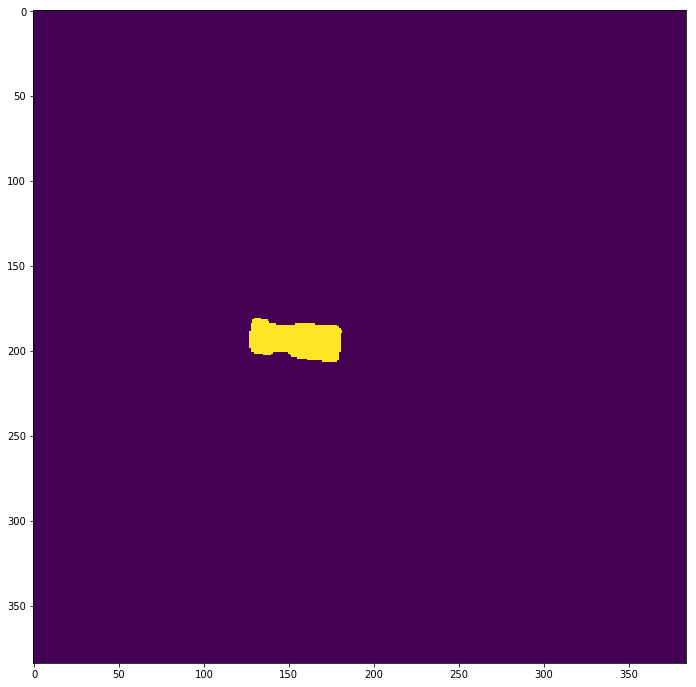

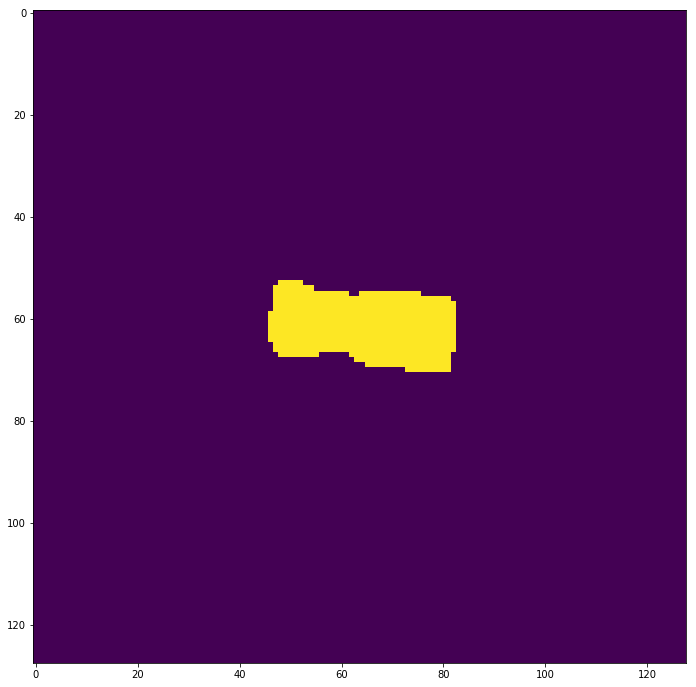

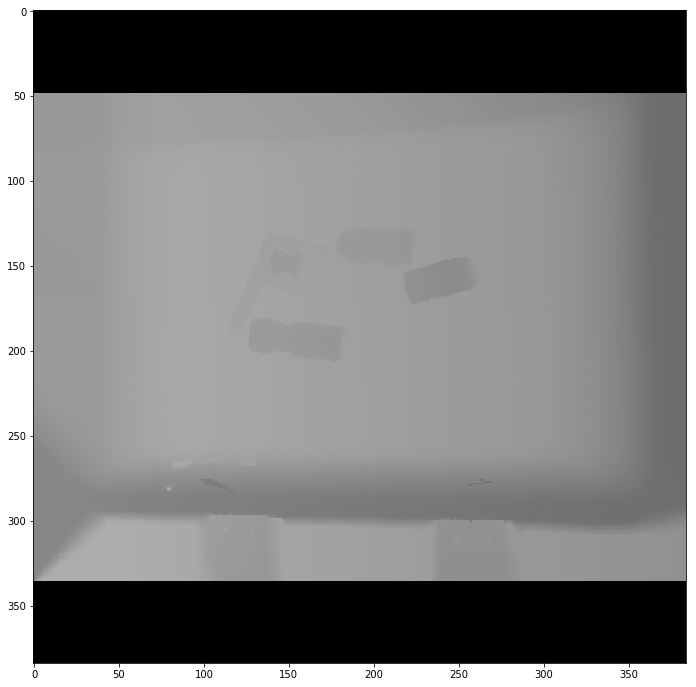

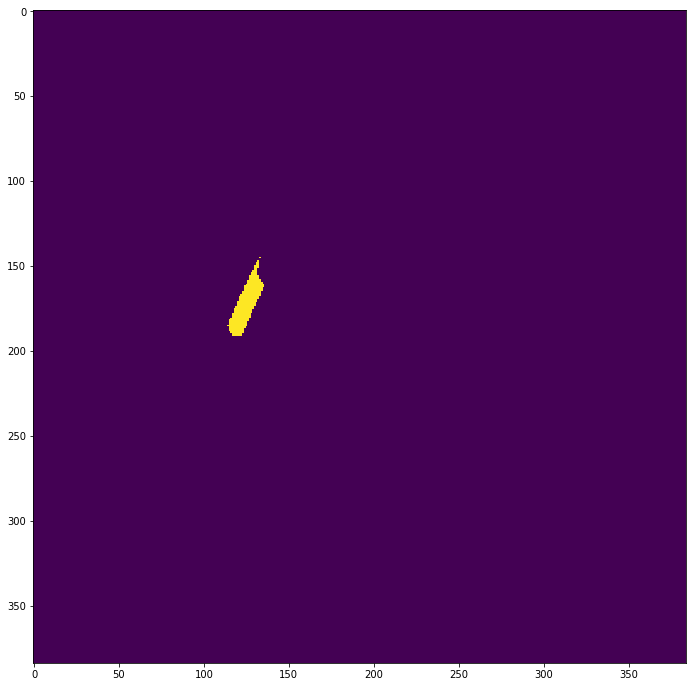

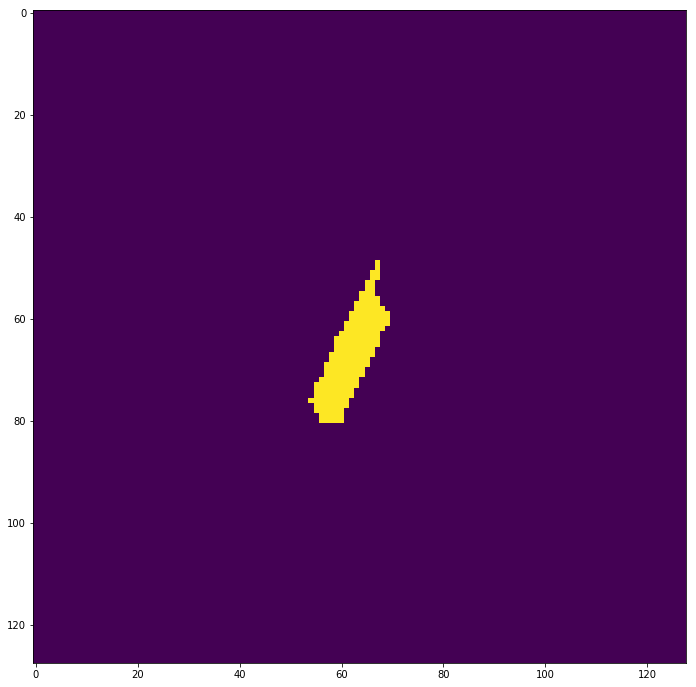

 93%|█████████▎| 28/30 [01:20<00:05,  2.90s/it]

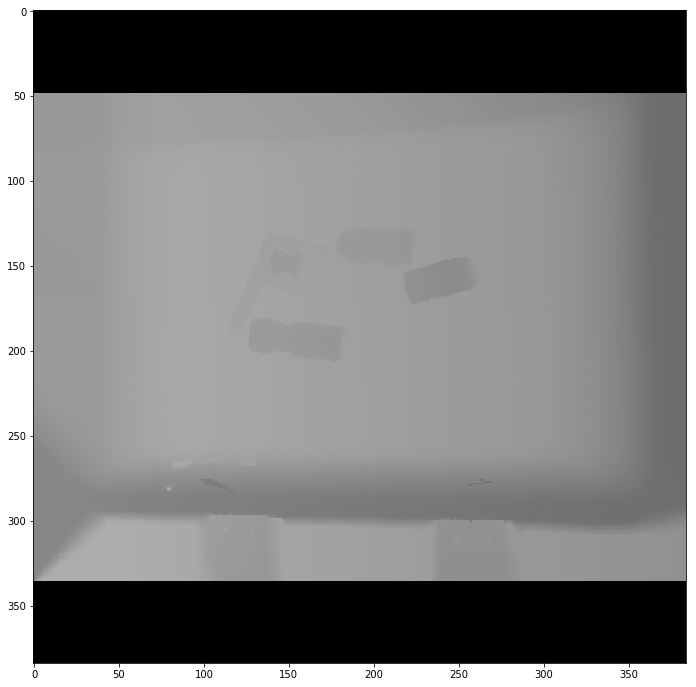

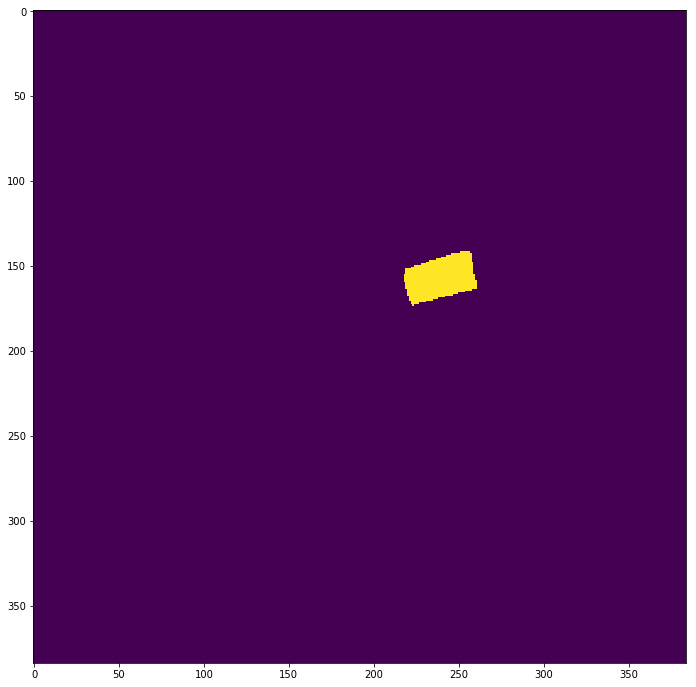

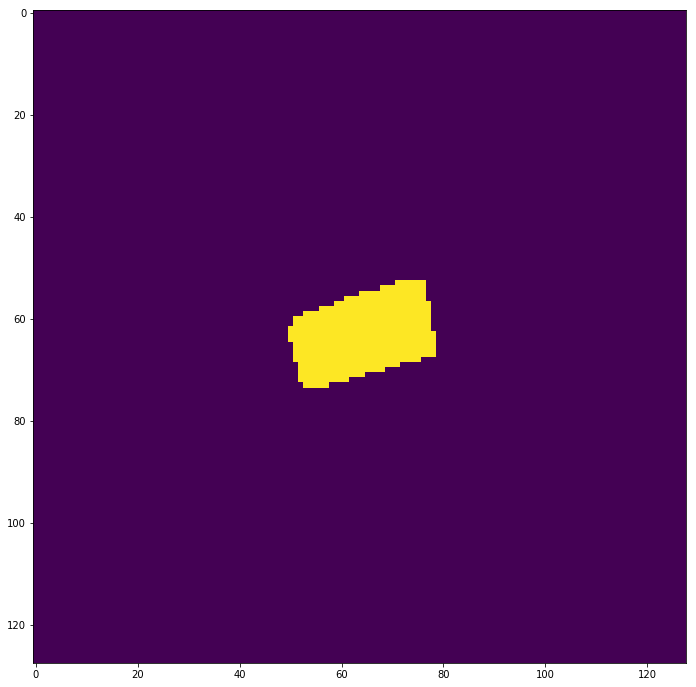

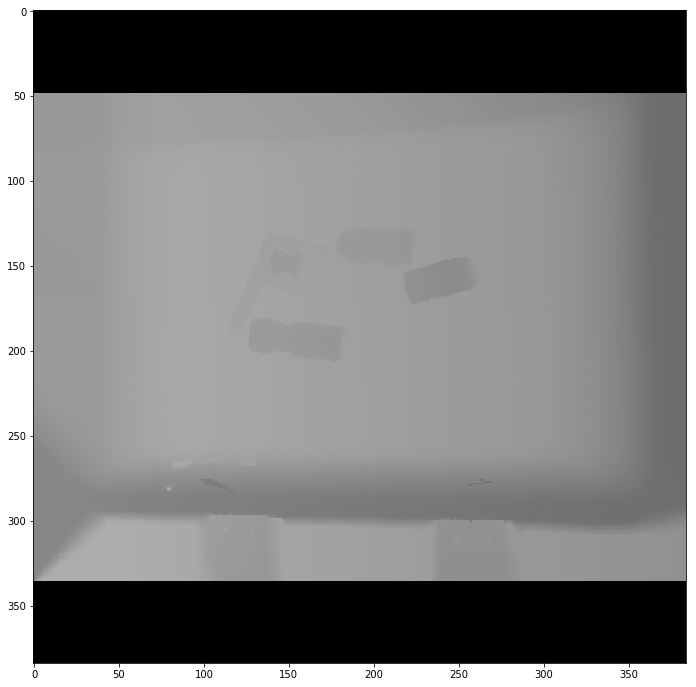

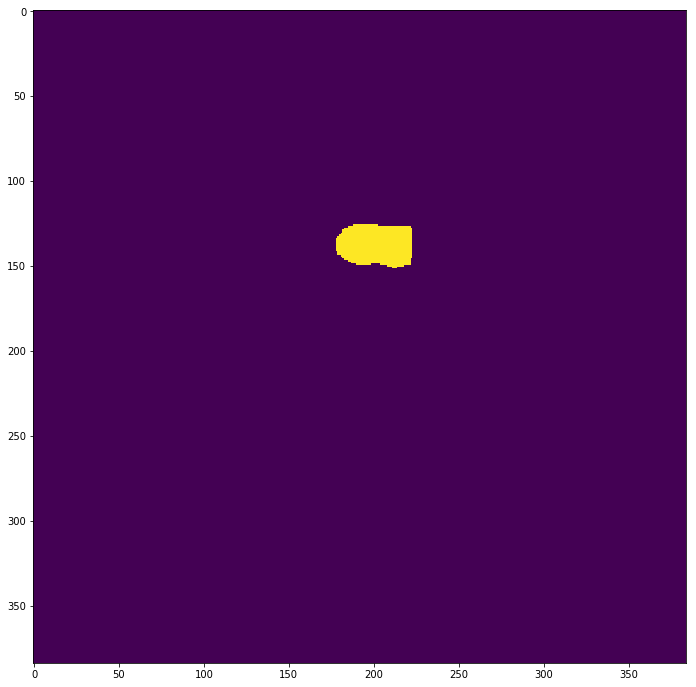

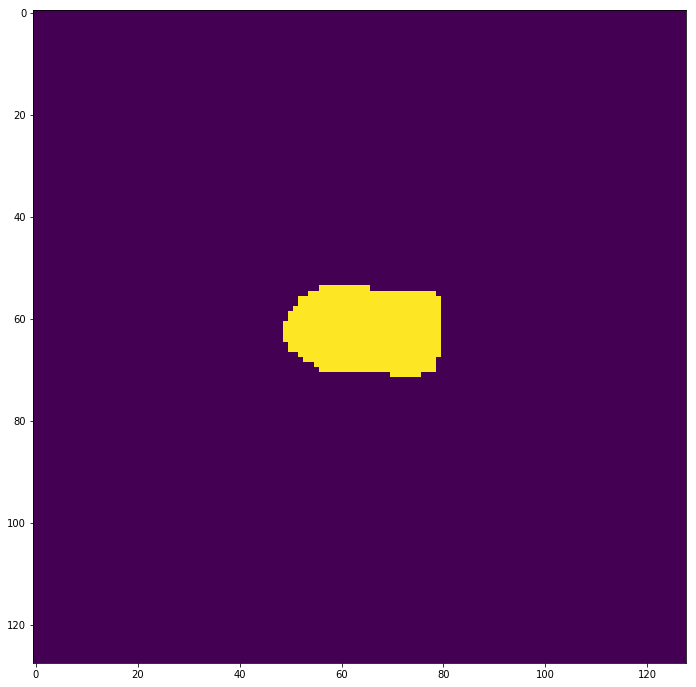

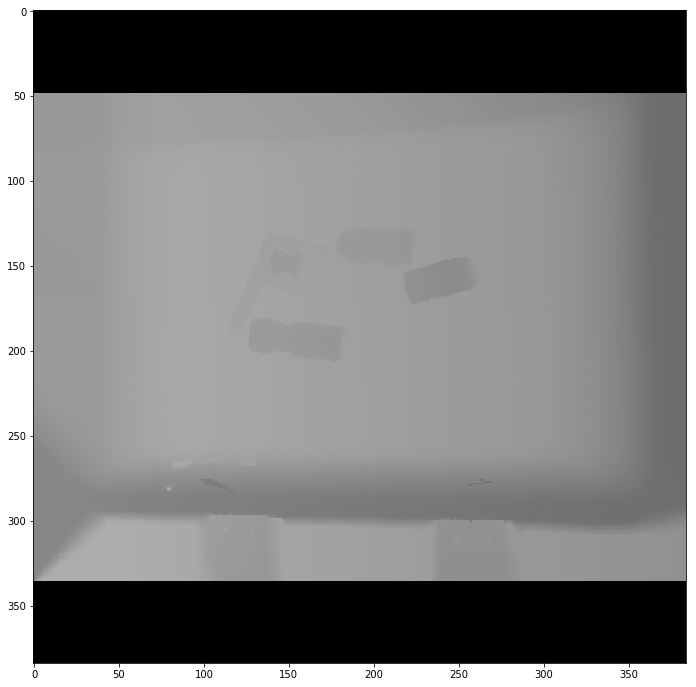

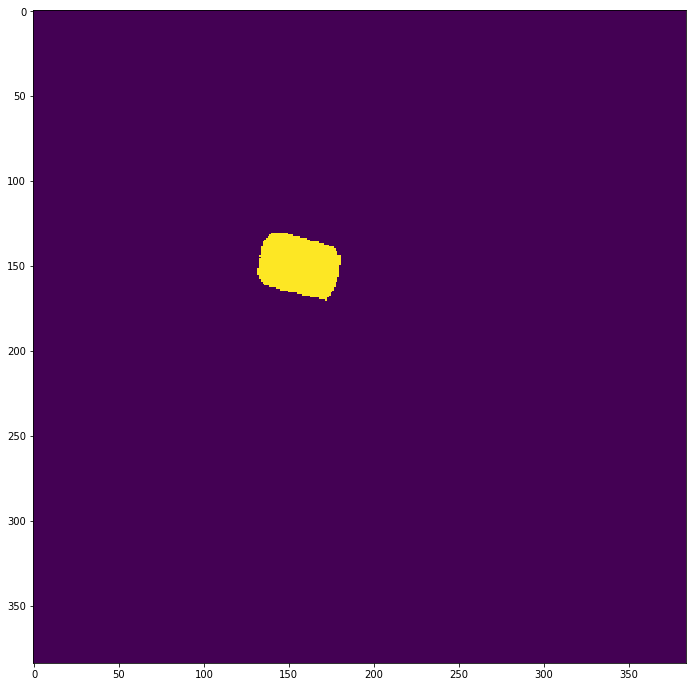

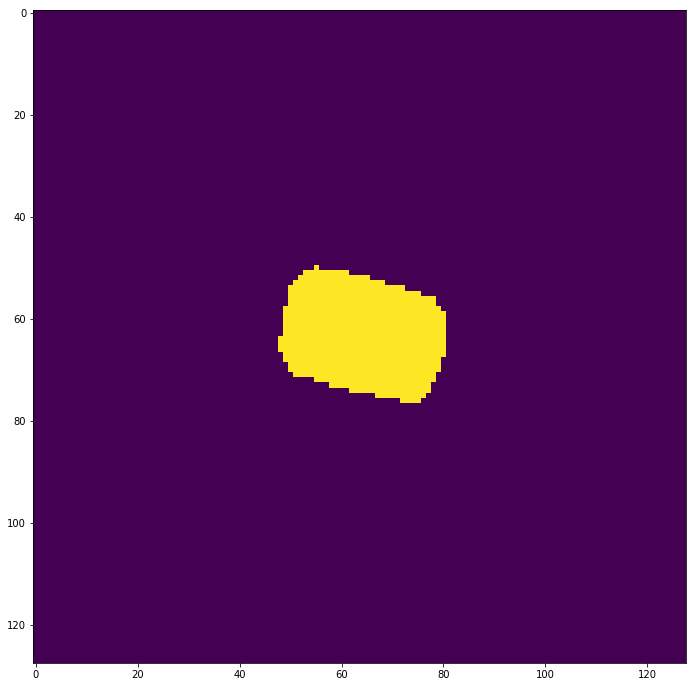

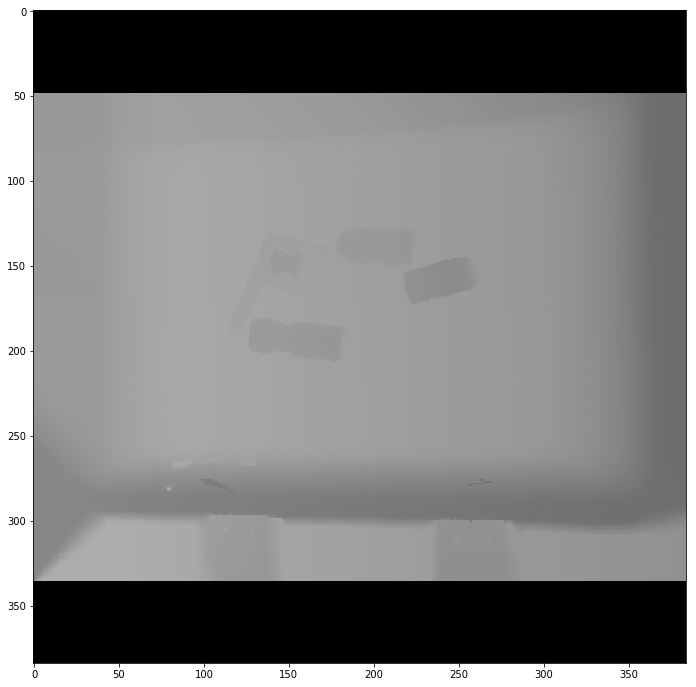

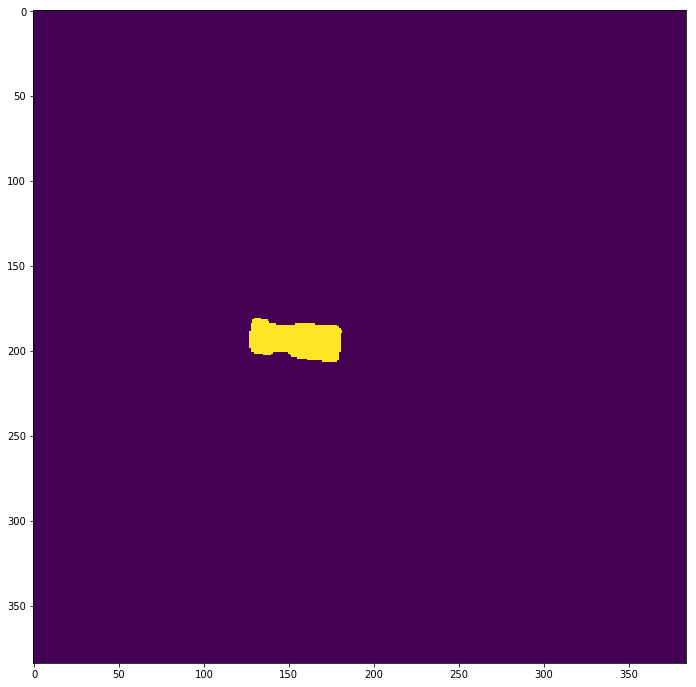

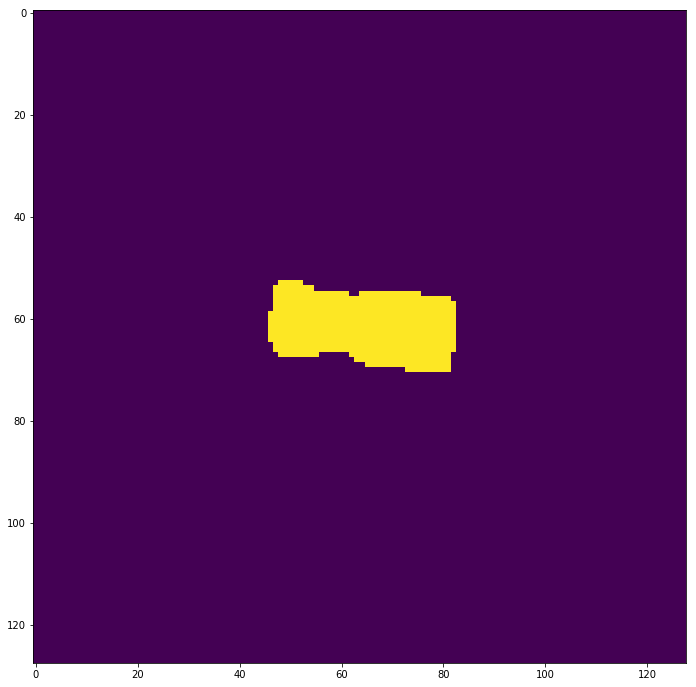

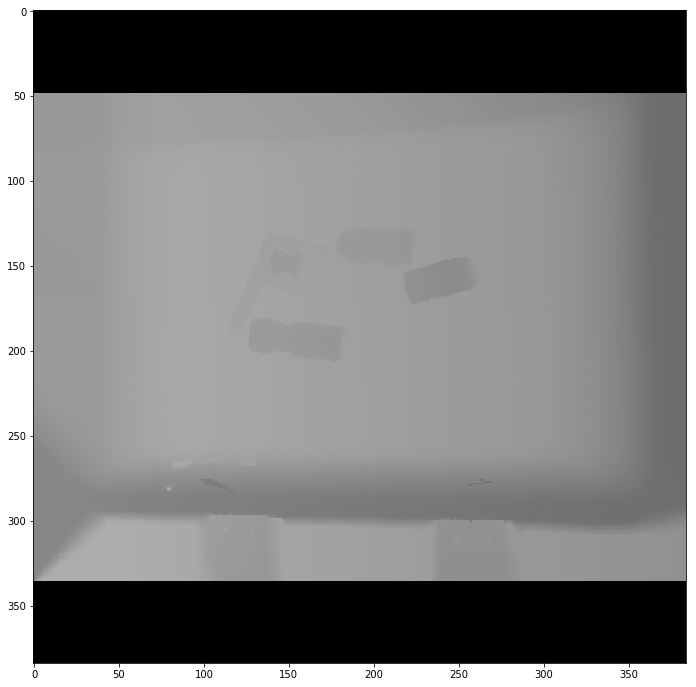

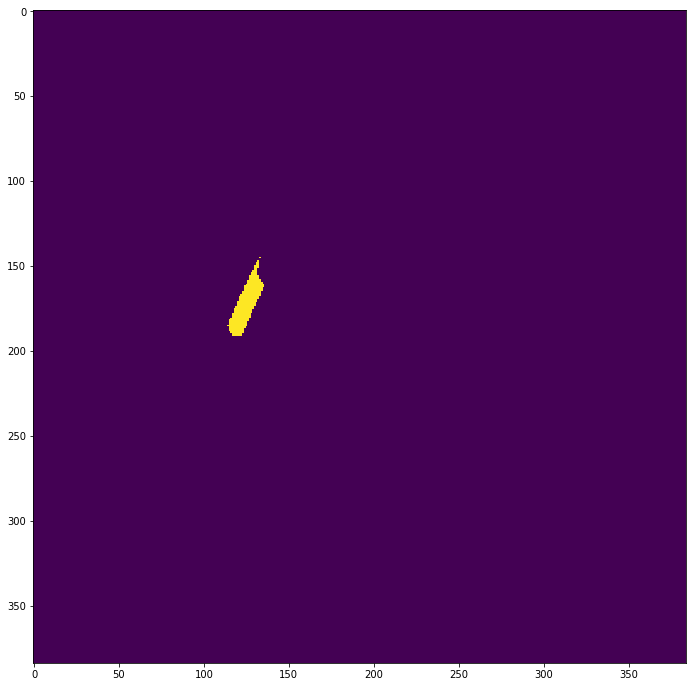

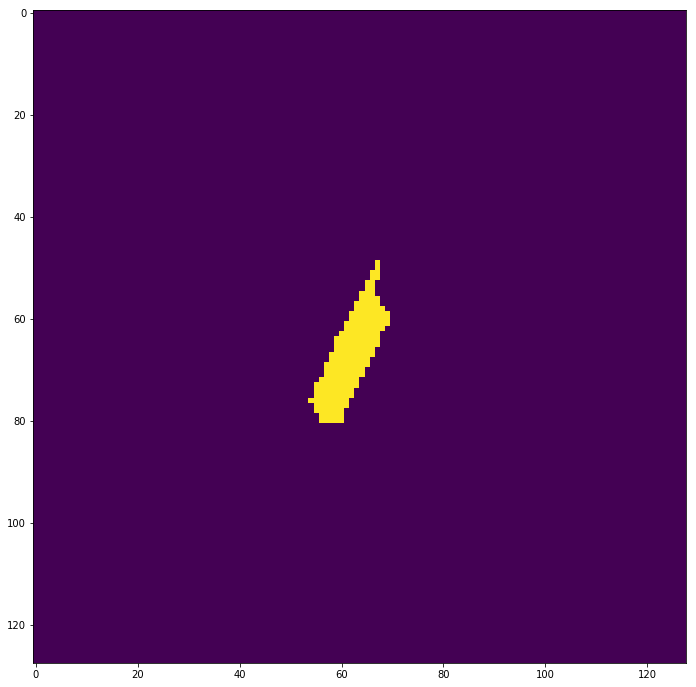

 97%|█████████▋| 29/30 [01:23<00:02,  2.88s/it]

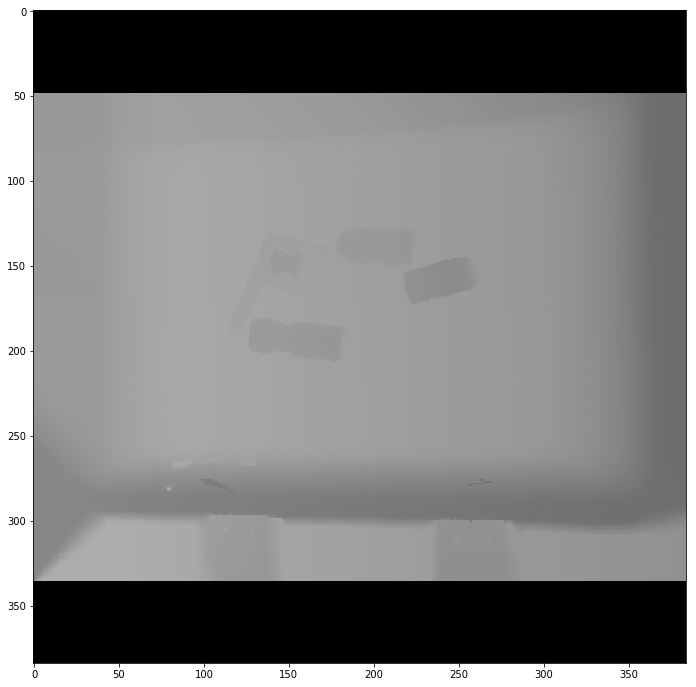

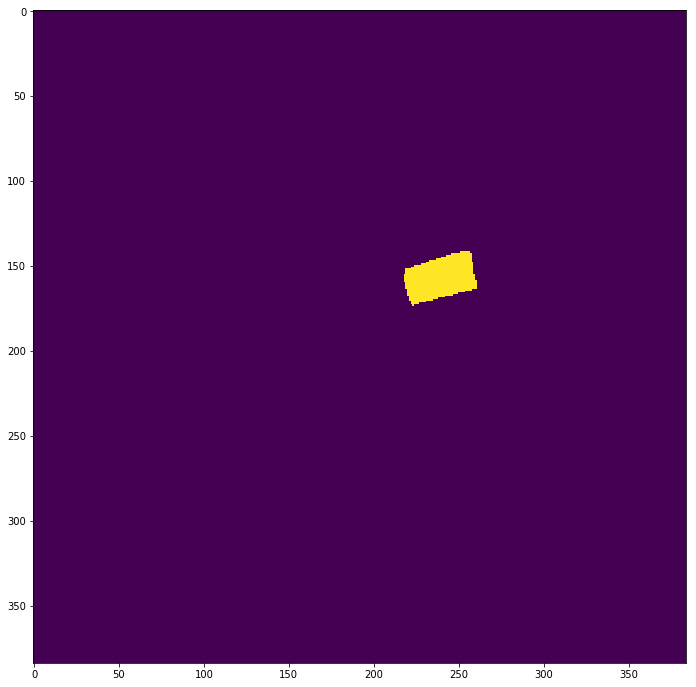

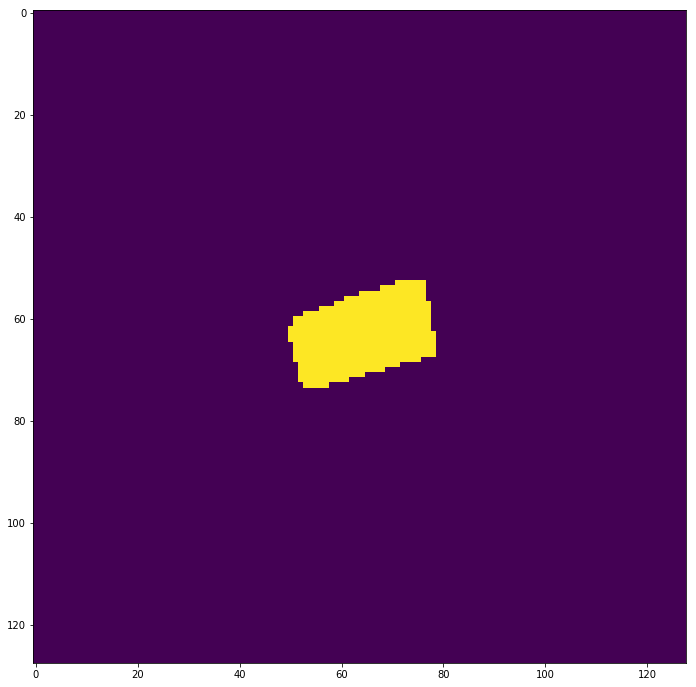

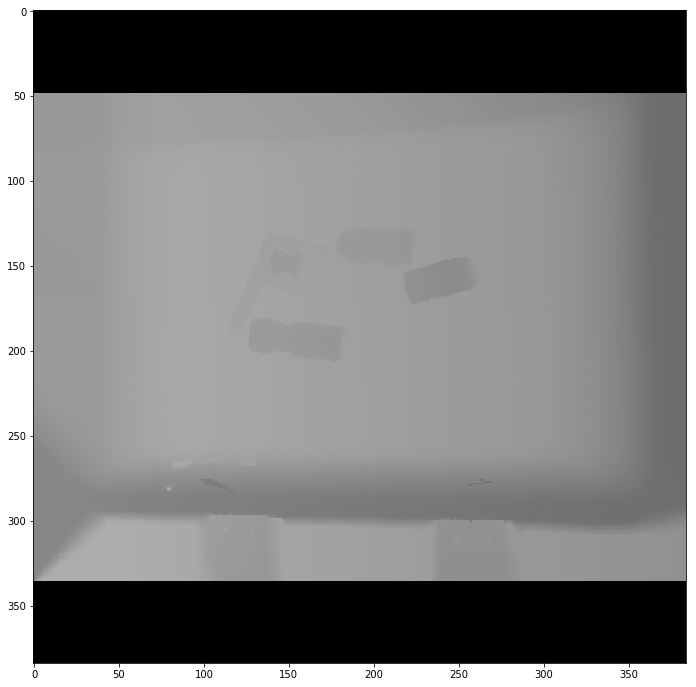

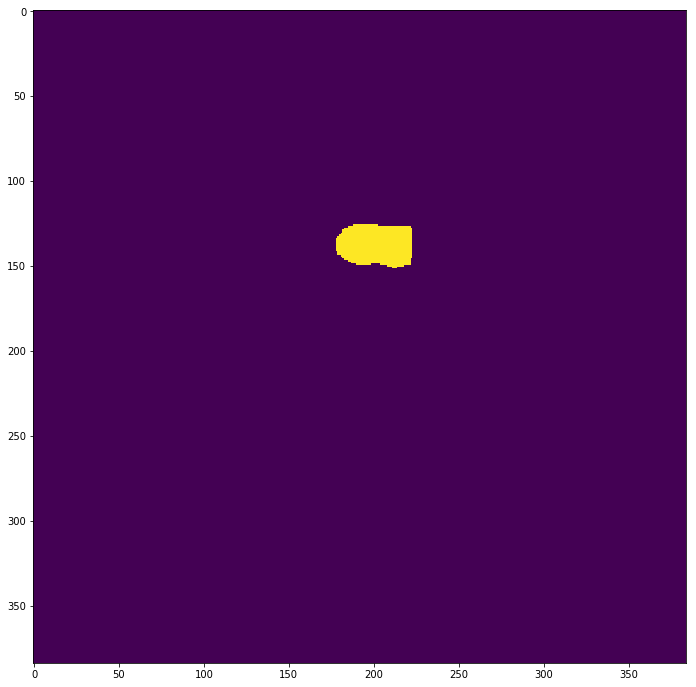

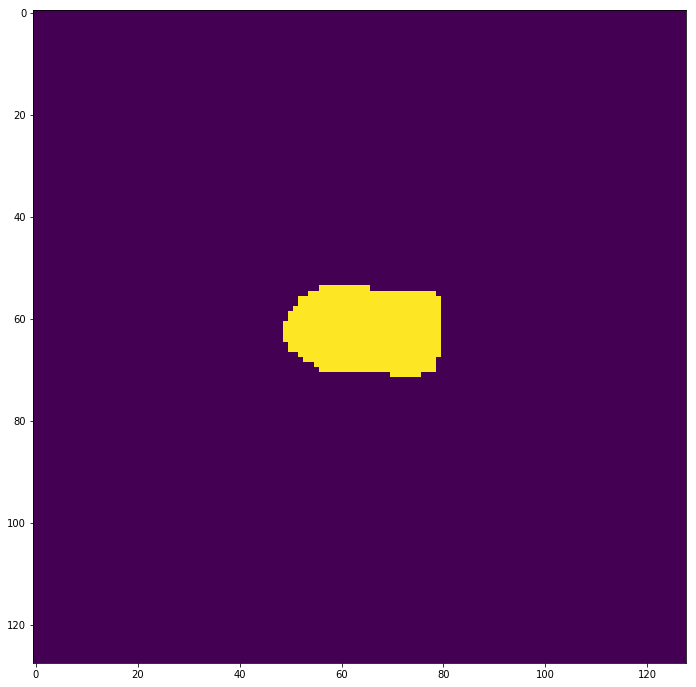

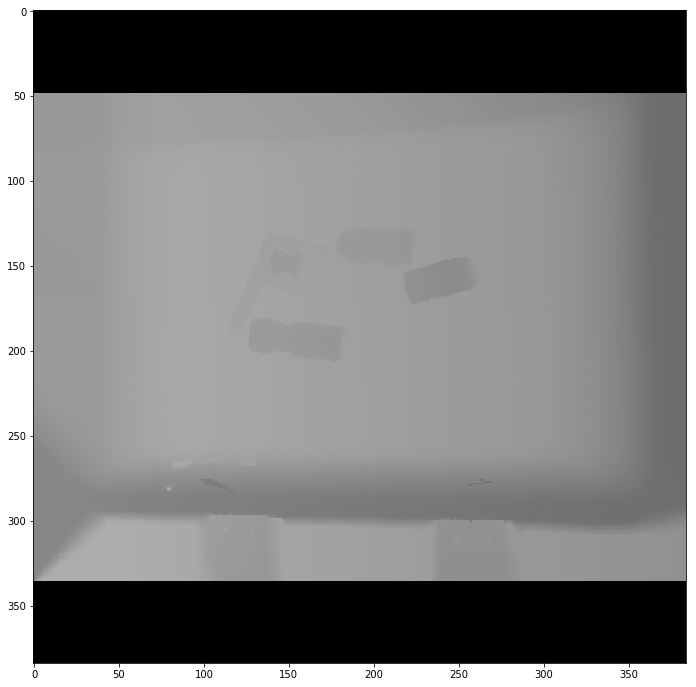

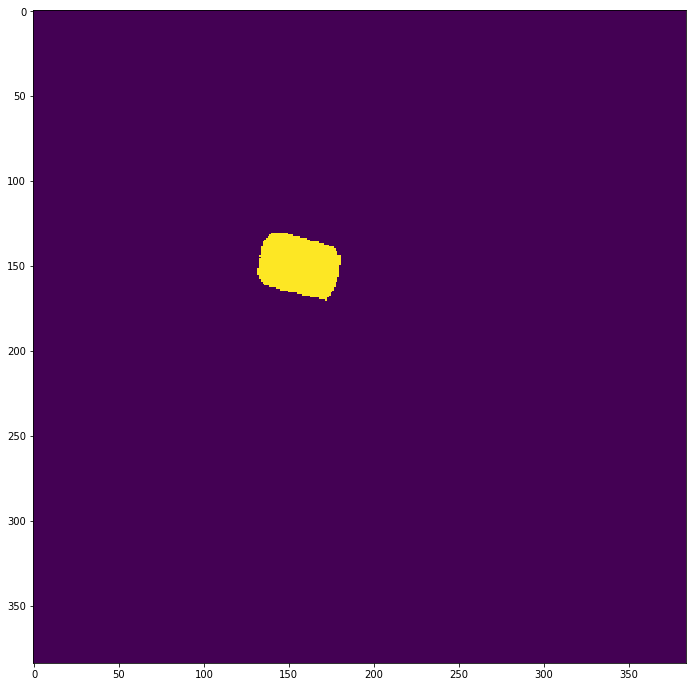

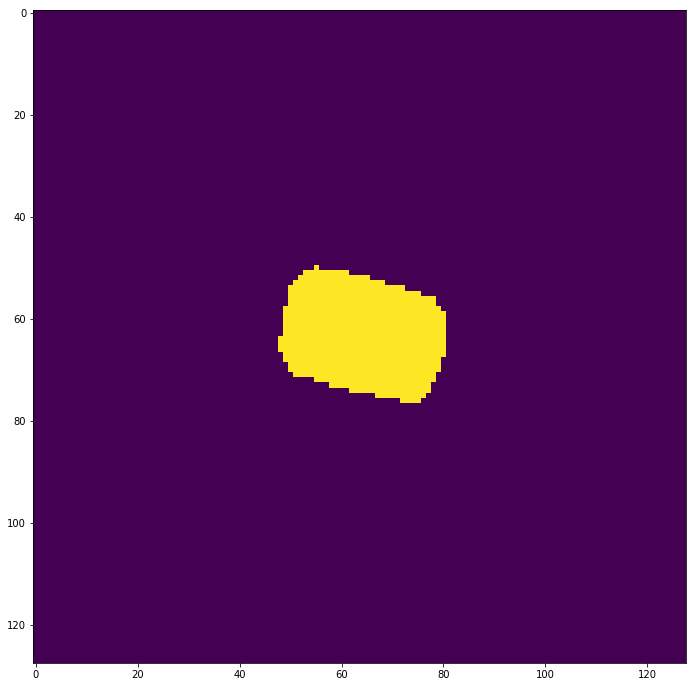

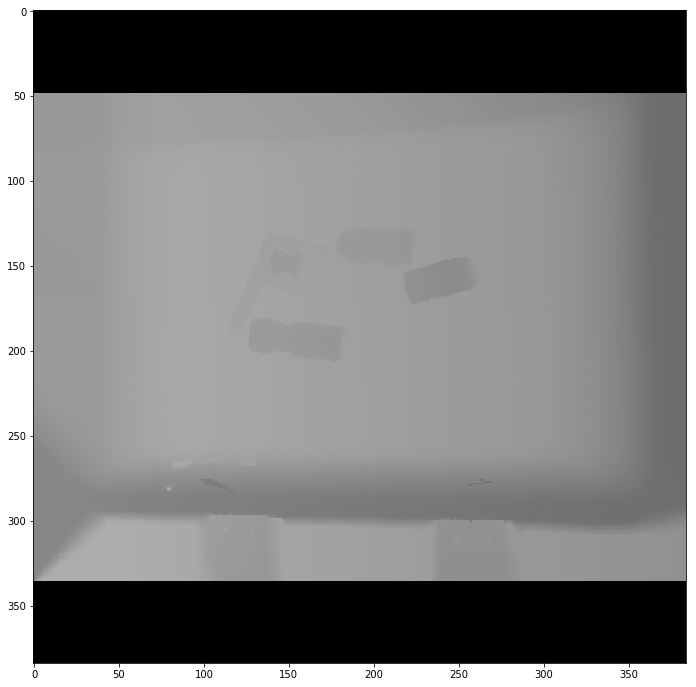

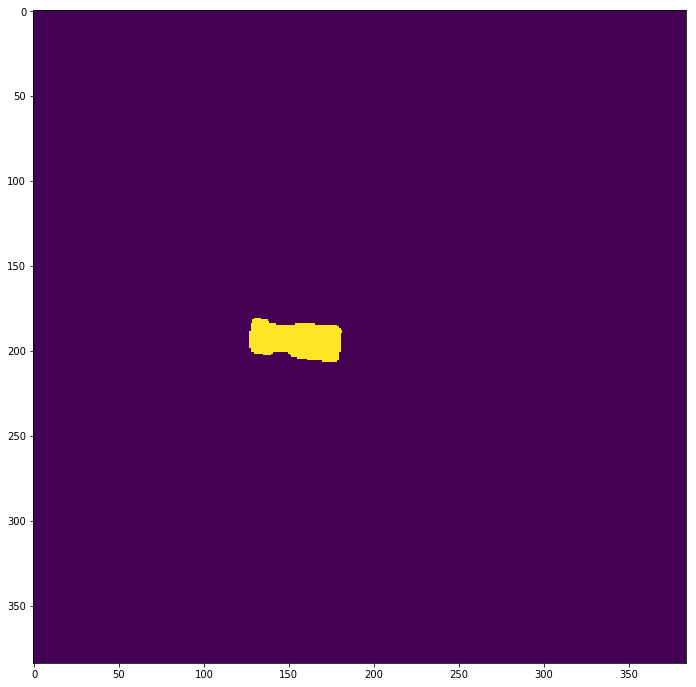

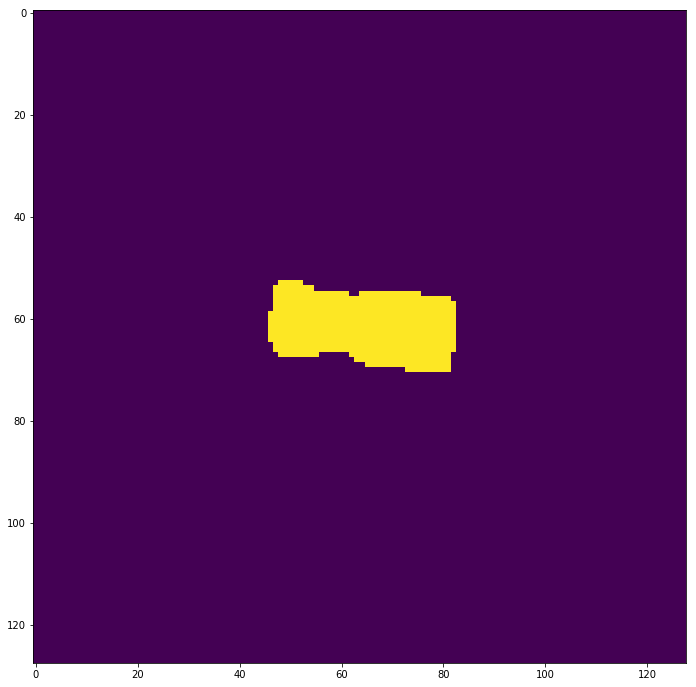

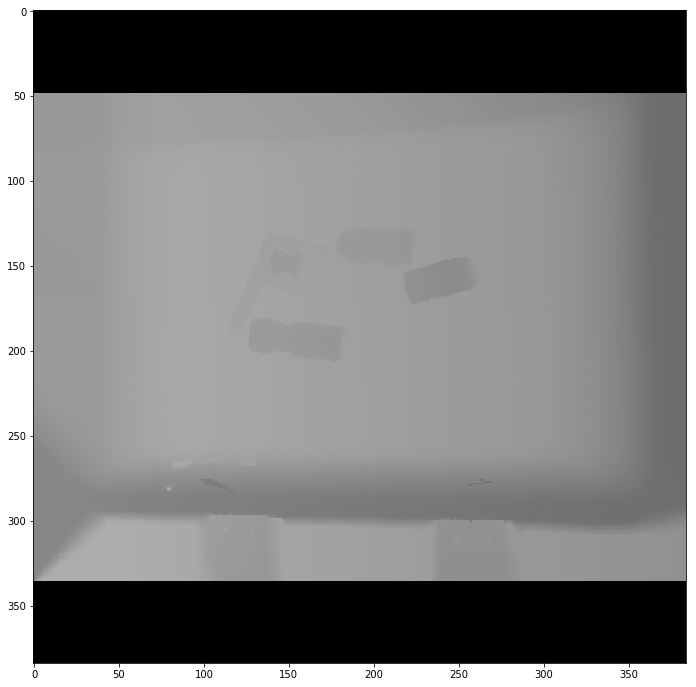

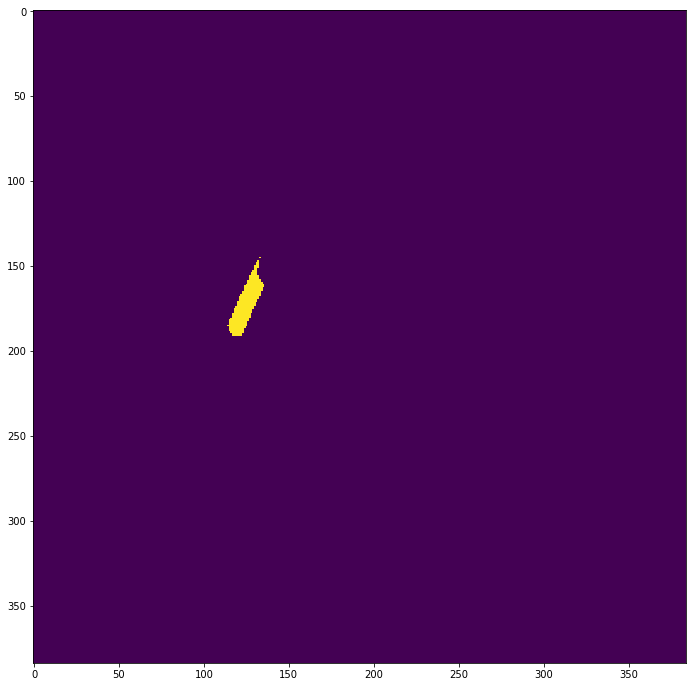

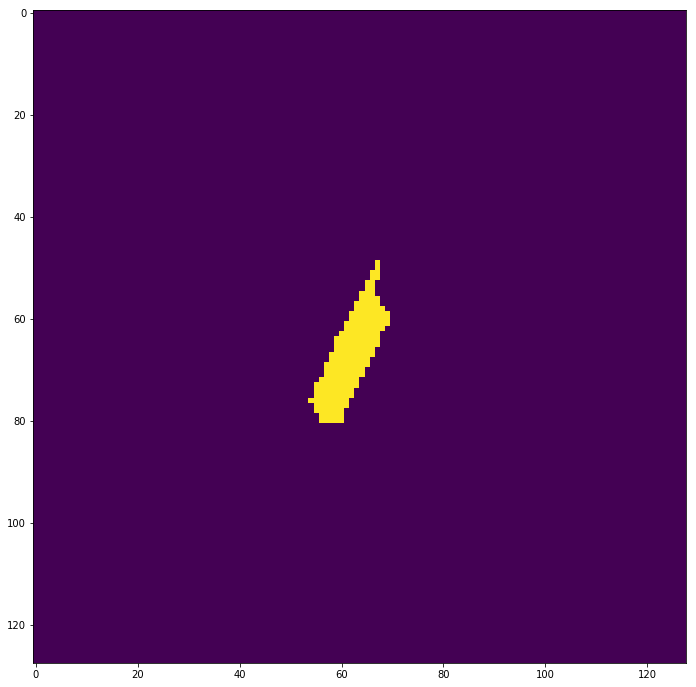

100%|██████████| 30/30 [01:26<00:00,  2.86s/it]


In [8]:
# Looping through all image indices
#   Looping through all labels in the json list
#     Get the name
#     Get the target file corresponding to the name
#     Add the image to the batch
#     Process the segmask from modal_segmasks

data_count = 0
for meta_idx in tqdm(range(NUM_IMS * 30)):
    idx = meta_idx % NUM_IMS
    f = open(os.path.join(JSON_DIR, "image_{:06d}.json".format(idx)))
    json_file = json.load(f)
    scene_path = os.path.join(SCENE_DIR, "image_{:06d}.png".format(idx))
    mask_path = os.path.join(MASK_DIR, "image_{:06d}.png".format(idx))

    # read and blockify scene
    scene_im = io.imread(scene_path)
    scene_im = resize_scene(scene_im)

    # for modal masks
    joint_mask = io.imread(mask_path)
    for label in json_file["labels"]:
        target_name = label["label_class"]
        target_id = label["object_id"]
        target_path = os.path.join(AMODAL_MASK_DIR, 
                                   "image_{:06d}".format(idx), 
                                   "{}.png".format(target_name))
        try:
            target_im = io.imread(target_path)
            # get first (basically equivalent slice)
            target_im = target_im[:, :, 0]
            modal_target = make_target(target_im, ANGLE, SHEAR)
            modal_target[modal_target > 0] = 1
        except:
            break
        
        modal_mask = np.copy(joint_mask)
        modal_mask[modal_mask != target_id] = 0
        modal_mask = resize_scene(modal_mask)
        modal_mask[modal_mask > 0] = 1
        data_count += 1

        plt.imshow(scene_im)
        plt.show()
        plt.imshow(modal_mask)
        plt.show()
        plt.imshow(modal_target)
        plt.show()
        
        """print(modal_mask.shape)
        print(amodal_mask.shape)
        print(scene_im.shape)
        print(np.unique(modal_mask))
        print(np.unique(amodal_mask))
        print(np.unique(scene_im))
        print(modal_mask.dtype)
        print(amodal_mask.dtype)
        print(scene_im.dtype)"""
        continue
        
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "image_{:08d}.png".format(meta_idx)),
               scene_im)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "segmentation_{:08d}.png".format(meta_idx)),
               modal_mask)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-train/",
            "modal_target_{:08d}.png".format(meta_idx)),
               modal_target)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "image_{:08d}.png".format(meta_idx)),
               scene_im)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "segmentation_{:08d}.png".format(meta_idx)),
               modal_mask)
        io.imsave(os.path.join(
            OUT_DIR,
            "test-one-shot/",
            "modal_target_{:08d}.png".format(meta_idx)),
               modal_target)        
        
            
        
        
